In [1]:
from utils import infer_parse_args
from multi_BD import MultiBlipDisenBooth
import torch
from safetensors.torch import load_file
from PIL import Image

/shenzihe/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/shenzihe/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using CUDA device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("Using CPU device")

Using CUDA device: NVIDIA GeForce RTX 3090


In [3]:
from types import SimpleNamespace
args = {
    "qformer_num_query_token": 16,
    "qformer_cross_attention_freq": 1,
    "qformer_train": False,
    "proj_train": False,
    "img_encoder_train": False,
    "img_adapter_train": False,
    "train_text_encoder": False,
    "pretrained_model_name_or_path": "runwayml/stable-diffusion-v1-5",
    "pretrained_BLIPdiffusion_name_or_path": "https://storage.googleapis.com/sfr-vision-language-research/LAVIS/models/BLIP-Diffusion/blip-diffusion.tar.gz",
    "finetuned_ckpt": "/shenzihe/multi_BlipDisenBooth/model_weights.pth",
    "loss":0,
    "loss_1":0,
    "loss_2":0,
    "text_prompt":"a corgi with <p_A> pose and a chow chow with <p_B> pose in <b> background",
    "train_batch_size":3
}
args = SimpleNamespace(**args)
print(args.qformer_num_query_token)

16


In [4]:
# Load model
model = MultiBlipDisenBooth(args)
model.to(device)

MultiBlipDisenBooth(
  (blip): Blip2Qformer(
    (visual_encoder): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_

In [5]:
model.load_checkpoint(args.finetuned_ckpt)

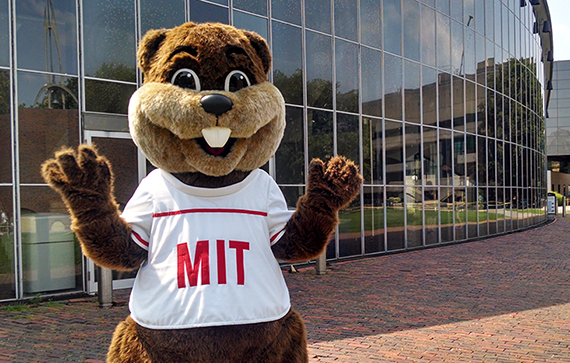

In [16]:
ref_image = {"corgi":Image.open("/shenzihe/multi_BlipDisenBooth/dataset/category/dog6_and_dog2/a00.jpg"),
             "chow chow":Image.open("/shenzihe/multi_BlipDisenBooth/dataset/category/dog6_and_dog2/b00.jpg")}
cond_subject = ["mit_mascot"]
tgt_subject = ["mit_mascot"]
text_prompt = ["with the Eiffel Tower in the background"]
samples = {
    "ref_images": ref_image,
    "cond_images": None,
    "cond_subject": cond_subject,
    "tgt_subject": tgt_subject,
    "prompt": text_prompt,
}
display(ref_image)

100%|██████████| 101/101 [00:13<00:00,  7.68it/s]


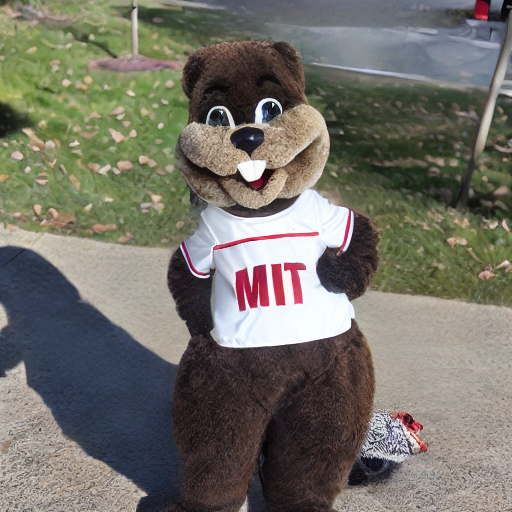

: 

In [17]:
num_output = 1

iter_seed = 8888
guidance_scale = 7
num_inference_steps = 100
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

for i in range(num_output):
    output = model.generate(
        samples,
        seed=iter_seed + i,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        neg_prompt=negative_prompt,
        height=512,
        width=512,
        text_weight=1.0,
        image_weight=0.0,
    )

    img = output[0]
    display(img)

## Subject-driven text-to-image generation

In [8]:
cond_subject = ["mit_mascot"]
tgt_subject = ["mit_mascot"]
text_prompt = ["on the beach"]
samples = {
    "cond_subject": cond_subject,
    "tgt_subject": tgt_subject,
    "prompt": text_prompt,
}
negative_prompt = "over-exposure, under-exposure, saturated, duplicate, out of frame, lowres, cropped, worst quality, low quality, jpeg artifacts, morbid, mutilated, out of frame, ugly, bad anatomy, bad proportions, deformed, blurry, duplicate"

## Identity-irrelevant generation

In [9]:
ref_im = Image.open("./dog7/00.jpg")
ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
# image = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt = "", text_weight=0.0, image_weight=1.0)[0]
image = disenbooth_infer(pipe, img_model, samples, adapter, proj_layer, reference_image=ref_image, num_inference_steps=num_inference_steps,text_weight=0.0, image_weight=1.0)[0]

image

NameError: name 'preprocess' is not defined

## Customization with identity-irrelevant information
generating different subjects, the image weight and text weight need to be adjusted

  0%|          | 0/50 [00:00<?, ?it/s]

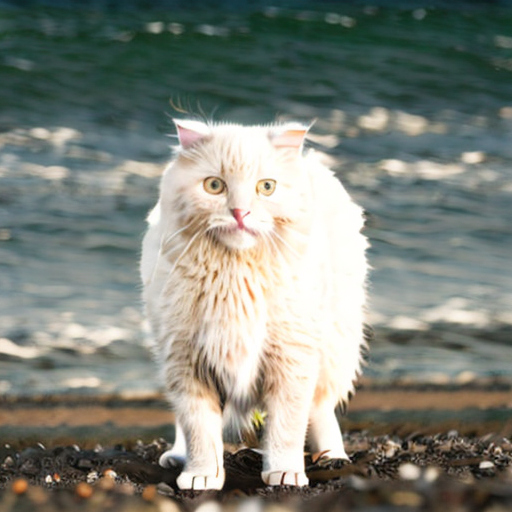

In [ ]:
ref_im = Image.open("./dog7/02.jpg")
ref_image = preprocess(ref_im).unsqueeze(0).to("cuda")
image = disenbooth_infer(pipe, img_model, adapter, reference_image=ref_image, prompt = "a white cat", text_weight=1.0, image_weight=1.0)[0]
image

In [1]:
prompt = 'red'
if prompt in {'red','purple','shiny','wet','cube shaped'}:
    print(prompt)

red


In [2]:
# 定義五個特殊字串的集合
special_strings = {'red', 'purple', 'shiny', 'wet', 'cube shaped'}

# 定義要檢查的字串列表
prompt_list = [
    'in the jungle',
    'in the snow',
    'on the beach',
    'on a cobblestone street',
    'on top of pink fabric',
    'on top of a wooden floor',
    'with a city in the background',
    'with a mountain in the background',
    'with a blue house in the background',
    'on top of a purple rug in a forest',
    'with a wheat field in the background',
    'with a tree and autumn leaves in the background',
    'with the Eiffel Tower in the background',
    'floating on top of water',
    'floating in an ocean of milk',
    'on top of green grass with sunflowers around it',
    'on top of a mirror',
    'on top of the sidewalk in a crowded street',
    'on top of a dirt road',
    'on top of a white rug',
    'red',
    'purple',
    'shiny',
    'wet',
    'cube shaped'
]

# 定義初始的 tgt_subject
tgt_subject = ["example_subject"]

# 處理每個 prompt
for prompt in prompt_list:
    if prompt in special_strings:
        tgt_subject = tgt_subject
        tgt_subject = [f"{prompt} {tgt_subject[0]}"]
        prompt = ""
    print(tgt_subject)  # 打印當前的 tgt_subject

['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['example_subject']
['red example_subject']
['purple red example_subject']
['shiny purple red example_subject']
['wet shiny purple red example_subject']
['cube shaped wet shiny purple red example_subject']


In [1]:
import os

# 定義目錄路徑
dir_path = "/shenzihe/WD-Disk/output"

# 遍歷目錄並擷取所有checkpoint相關的資料夾
checkpoint_dirs = []

for root, dirs, files in os.walk(dir_path):
    for dir_name in dirs:
        if "checkpoint" in dir_name:
            checkpoint_dirs.append(os.path.join(root, dir_name))

# 列出所有找到的checkpoint資料夾
for folder in checkpoint_dirs:
    print(folder)

/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1/checkpoint-2000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1/checkpoint-3000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1/checkpoint-1000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1/checkpoint-2000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1/checkpoint-3000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1/checkpoint-1000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1/checkpoint-2000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1/checkpoint-3000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1/checkpoint-1000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1/checkpoint-2000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1/checkpoint-3000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1/checkpoint-1000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1/checkpoint-2000
/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1/checkpoint-3000
/shen

In [23]:
import os
import glob
image_paths = []
json_paths = []
# sample_root = "/shenzihe/WD-Disk/output/"
sample_root = "/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1/checkpoint-20"

# 遍歷sample_root目錄下的所有子目錄，找到圖片和json文件
for root, dirs, files in os.walk(sample_root):
    for file in files:
        if file.endswith('.png'):
            image_paths.append(os.path.join(root, file))
        elif file.endswith('.json'):
            json_paths.append(os.path.join(root, file))


In [36]:
dirs = os.listdir("/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0")
dirs = [d for d in dirs if d.startswith("checkpoint")]
dirs = sorted(dirs, key=lambda x: int(x.split("-")[1]))
path = dirs[-1] if len(dirs) > 0 else None
path

'checkpoint-60'

In [33]:
data = pd.read_pickle("/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01/checkpoint-20/evaluation.pkl")
data

CLIP Text alignment  \
purple                                                      0.909790   
with_a_city_in_the_background                               0.809082   
on_top_of_a_dirt_road                                       0.846313   
on_top_of_a_white_rug                                       0.779297   
with_the_Eiffel_Tower_in_the_background                     0.841675   
on_top_of_green_grass_with_sunflowers_around_it             0.868286   
with_a_tree_and_autumn_leaves_in_the_background             0.827271   
on_top_of_pink_fabric                                       0.798828   
with_a_blue_house_in_the_background                         0.771729   
with_a_wheat_field_in_the_background                        0.810303   
cube_shaped                                                 0.739990   
red                                                         0.804321   
on_the_beach                                                0.891235   
with_a_mountain_in_the_background                           0.831543   
on_top_of_a_mirror                                          0.688477   
in_the_snow                                                 0.751343   
on_top_of_a_wooden_floor                                    0.878418   
on_top_of_a_purple_rug_in_a_forest                          0.868774   
on_a_cobblestone_street                                     0.777710   
on_top_of_the_sidewalk_in_a_crowded_street                  0.750854   
floating_on_top_of_water                                    0.849976   
shiny                                                       0.775269   
in_the_jungle                                               0.756470   
floating_in_an_ocean_of_milk                                0.712158   
wet                                                         0.751587   
Average                                                     0.803628   

                                                 CLIP Image alignment  \
purple                                                       0.717773   
with_a_city_in_the_background                                0.740234   
on_top_of_a_dirt_road                                        0.734863   
on_top_of_a_white_rug                                        0.759277   
with_the_Eiffel_Tower_in_the_background                      0.738770   
on_top_of_green_grass_with_sunflowers_around_it              0.714844   
with_a_tree_and_autumn_leaves_in_the_background              0.745117   
on_top_of_pink_fabric                                        0.712402   
with_a_blue_house_in_the_background                          0.721680   
with_a_wheat_field_in_the_background                         0.724609   
cube_shaped                                                  0.748535   
red                                                          0.764160   
on_the_beach                                                 0.708008   
with_a_mountain_in_the_background                            0.737793   
on_top_of_a_mirror                                           0.746582   
in_the_snow                                                  0.741211   
on_top_of_a_wooden_floor                                     0.753906   
on_top_of_a_purple_rug_in_a_forest                           0.723633   
on_a_cobblestone_street                                      0.747559   
on_top_of_the_sidewalk_in_a_crowded_street                   0.749512   
floating_on_top_of_water                                     0.753418   
shiny                                                        0.738281   
in_the_jungle                                                0.761719   
floating_in_an_ocean_of_milk                                 0.722168   
wet                                                          0.729980   
Average                                                      0.737305   

                                                 DINO Image alignment  
purple                                                      

In [11]:
import os
sorted_checkpoints = sorted(os.listdir(sample_root+'/mit_mascot_bsz_2_loss_0_1_1'), key=lambda x: int(x.split('-')[1]))
sorted_checkpoints


['checkpoint-20',
 'checkpoint-40',
 'checkpoint-60',
 'checkpoint-80',
 'checkpoint-100',
 'checkpoint-120',
 'checkpoint-140',
 'checkpoint-160']

In [15]:
# for root, dirs, files in os.walk(sample_root):
#     print(root, dirs, files)
import json, os
import pandas as pd
sample_root = "/shenzihe/WD-Disk/output/"

for subdir in os.listdir(sample_root):
    root = os.path.join(sample_root, subdir)
    print(sorted(os.listdir(root), key=lambda 
    x: int(x.split('-')[1])))
    for check_point in sorted(os.listdir(root), key=lambda x: int(x.split('-')[1])):
        pkl_path = os.path.join( root, check_point, "evaluation.pkl" )
        eval = pd.read_pickle(pkl_path)
        display(root, check_point,eval)


['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.362732   
with_a_city_in_the_background                               0.323059   
on_top_of_a_dirt_road                                       0.337585   
on_top_of_a_white_rug                                       0.311829   
with_the_Eiffel_Tower_in_the_background                     0.327393   
on_top_of_green_grass_with_sunflowers_around_it             0.352417   
with_a_tree_and_autumn_leaves_in_the_background             0.329895   
on_top_of_pink_fabric                                       0.317627   
with_a_blue_house_in_the_background                         0.303040   
with_a_wheat_field_in_the_background                        0.323792   
cube_shaped                                                 0.295837   
red                                                         0.321594   
on_the_beach                                                0.357788   
with_a_mountain_in_the_background                           0.333252   
on_top_of_a_mirror                                          0.275116   
in_the_snow                                                 0.299927   
on_top_of_a_wooden_floor                                    0.350647   
on_top_of_a_purple_rug_in_a_forest                          0.347046   
on_a_cobblestone_street                                     0.310730   
on_top_of_the_sidewalk_in_a_crowded_street                  0.302246   
floating_on_top_of_water                                    0.338745   
shiny                                                       0.311584   
in_the_jungle                                               0.301575   
floating_in_an_ocean_of_milk                                0.282166   
wet                                                         0.304626   
Average                                                     0.320890   

                                                 CLIP Image alignment  \
purple                                                       0.718750   
with_a_city_in_the_background                                0.738770   
on_top_of_a_dirt_road                                        0.731934   
on_top_of_a_white_rug                                        0.761230   
with_the_Eiffel_Tower_in_the_background                      0.729004   
on_top_of_green_grass_with_sunflowers_around_it              0.716309   
with_a_tree_and_autumn_leaves_in_the_background              0.745117   
on_top_of_pink_fabric                                        0.712891   
with_a_blue_house_in_the_background                          0.713867   
with_a_wheat_field_in_the_background                         0.725586   
cube_shaped                                                  0.750977   
red                                                          0.765625   
on_the_beach                                                 0.704590   
with_a_mountain_in_the_background                            0.735840   
on_top_of_a_mirror                                           0.747070   
in_the_snow                                                  0.742676   
on_top_of_a_wooden_floor                                     0.753906   
on_top_of_a_purple_rug_in_a_forest                           0.723633   
on_a_cobblestone_street                                      0.748047   
on_top_of_the_sidewalk_in_a_crowded_street                   0.750000   
floating_on_top_of_water                                     0.753418   
shiny                                                        0.737305   
in_the_jungle                                                0.762207   
floating_in_an_ocean_of_milk                                 0.719727   
wet                                                          0.732422   
Average                                                      0.736816   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.387939   
with_a_city_in_the_background                               0.352966   
on_top_of_a_dirt_road                                       0.374573   
on_top_of_a_white_rug                                       0.342834   
with_the_Eiffel_Tower_in_the_background                     0.371338   
on_top_of_green_grass_with_sunflowers_around_it             0.388184   
with_a_tree_and_autumn_leaves_in_the_background             0.389465   
on_top_of_pink_fabric                                       0.351562   
with_a_blue_house_in_the_background                         0.335388   
with_a_wheat_field_in_the_background                        0.385315   
cube_shaped                                                 0.330750   
red                                                         0.342163   
on_the_beach                                                0.382996   
with_a_mountain_in_the_background                           0.383484   
on_top_of_a_mirror                                          0.303162   
in_the_snow                                                 0.347229   
on_top_of_a_wooden_floor                                    0.378662   
on_top_of_a_purple_rug_in_a_forest                          0.374817   
on_a_cobblestone_street                                     0.358887   
on_top_of_the_sidewalk_in_a_crowded_street                  0.299805   
floating_on_top_of_water                                    0.340881   
shiny                                                       0.339050   
in_the_jungle                                               0.328064   
floating_in_an_ocean_of_milk                                0.314026   
wet                                                         0.336060   
Average                                                     0.353584   

                                                 CLIP Image alignment  \
purple                                                       0.764648   
with_a_city_in_the_background                                0.763672   
on_top_of_a_dirt_road                                        0.775391   
on_top_of_a_white_rug                                        0.800293   
with_the_Eiffel_Tower_in_the_background                      0.767578   
on_top_of_green_grass_with_sunflowers_around_it              0.737305   
with_a_tree_and_autumn_leaves_in_the_background              0.767090   
on_top_of_pink_fabric                                        0.770020   
with_a_blue_house_in_the_background                          0.746094   
with_a_wheat_field_in_the_background                         0.757812   
cube_shaped                                                  0.824219   
red                                                          0.811035   
on_the_beach                                                 0.763184   
with_a_mountain_in_the_background                            0.779297   
on_top_of_a_mirror                                           0.806152   
in_the_snow                                                  0.809082   
on_top_of_a_wooden_floor                                     0.818359   
on_top_of_a_purple_rug_in_a_forest                           0.715332   
on_a_cobblestone_street                                      0.804688   
on_top_of_the_sidewalk_in_a_crowded_street                   0.801270   
floating_on_top_of_water                                     0.728516   
shiny                                                        0.803223   
in_the_jungle                                                0.777344   
floating_in_an_ocean_of_milk                                 0.758301   
wet                                                          0.786133   
Average                                                      0.777344   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.387756   
with_a_city_in_the_background                               0.380493   
on_top_of_a_dirt_road                                       0.355408   
on_top_of_a_white_rug                                       0.318970   
with_the_Eiffel_Tower_in_the_background                     0.399109   
on_top_of_green_grass_with_sunflowers_around_it             0.325195   
with_a_tree_and_autumn_leaves_in_the_background             0.392822   
on_top_of_pink_fabric                                       0.336487   
with_a_blue_house_in_the_background                         0.324951   
with_a_wheat_field_in_the_background                        0.382141   
cube_shaped                                                 0.348999   
red                                                         0.342773   
on_the_beach                                                0.389587   
with_a_mountain_in_the_background                           0.389648   
on_top_of_a_mirror                                          0.310059   
in_the_snow                                                 0.325928   
on_top_of_a_wooden_floor                                    0.373535   
on_top_of_a_purple_rug_in_a_forest                          0.375671   
on_a_cobblestone_street                                     0.340027   
on_top_of_the_sidewalk_in_a_crowded_street                  0.323486   
floating_on_top_of_water                                    0.354248   
shiny                                                       0.345337   
in_the_jungle                                               0.323486   
floating_in_an_ocean_of_milk                                0.304871   
wet                                                         0.358704   
Average                                                     0.352388   

                                                 CLIP Image alignment  \
purple                                                       0.784668   
with_a_city_in_the_background                                0.808594   
on_top_of_a_dirt_road                                        0.783203   
on_top_of_a_white_rug                                        0.777344   
with_the_Eiffel_Tower_in_the_background                      0.772949   
on_top_of_green_grass_with_sunflowers_around_it              0.783203   
with_a_tree_and_autumn_leaves_in_the_background              0.810059   
on_top_of_pink_fabric                                        0.746582   
with_a_blue_house_in_the_background                          0.780762   
with_a_wheat_field_in_the_background                         0.770996   
cube_shaped                                                  0.823242   
red                                                          0.819336   
on_the_beach                                                 0.789062   
with_a_mountain_in_the_background                            0.802734   
on_top_of_a_mirror                                           0.820312   
in_the_snow                                                  0.794922   
on_top_of_a_wooden_floor                                     0.791992   
on_top_of_a_purple_rug_in_a_forest                           0.777344   
on_a_cobblestone_street                                      0.791016   
on_top_of_the_sidewalk_in_a_crowded_street                   0.822266   
floating_on_top_of_water                                     0.777344   
shiny                                                        0.814941   
in_the_jungle                                                0.788086   
floating_in_an_ocean_of_milk                                 0.760254   
wet                                                          0.813477   
Average                                                      0.792480   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.386414   
with_a_city_in_the_background                               0.392029   
on_top_of_a_dirt_road                                       0.376953   
on_top_of_a_white_rug                                       0.351929   
with_the_Eiffel_Tower_in_the_background                     0.358643   
on_top_of_green_grass_with_sunflowers_around_it             0.373901   
with_a_tree_and_autumn_leaves_in_the_background             0.388123   
on_top_of_pink_fabric                                       0.382080   
with_a_blue_house_in_the_background                         0.347229   
with_a_wheat_field_in_the_background                        0.362610   
cube_shaped                                                 0.333557   
red                                                         0.341675   
on_the_beach                                                0.382507   
with_a_mountain_in_the_background                           0.394470   
on_top_of_a_mirror                                          0.329163   
in_the_snow                                                 0.383972   
on_top_of_a_wooden_floor                                    0.392944   
on_top_of_a_purple_rug_in_a_forest                          0.382019   
on_a_cobblestone_street                                     0.364929   
on_top_of_the_sidewalk_in_a_crowded_street                  0.331604   
floating_on_top_of_water                                    0.364197   
shiny                                                       0.361633   
in_the_jungle                                               0.336304   
floating_in_an_ocean_of_milk                                0.342285   
wet                                                         0.351807   
Average                                                     0.364519   

                                                 CLIP Image alignment  \
purple                                                       0.806152   
with_a_city_in_the_background                                0.857910   
on_top_of_a_dirt_road                                        0.811035   
on_top_of_a_white_rug                                        0.824707   
with_the_Eiffel_Tower_in_the_background                      0.818359   
on_top_of_green_grass_with_sunflowers_around_it              0.800293   
with_a_tree_and_autumn_leaves_in_the_background              0.817871   
on_top_of_pink_fabric                                        0.803711   
with_a_blue_house_in_the_background                          0.813477   
with_a_wheat_field_in_the_background                         0.772949   
cube_shaped                                                  0.823242   
red                                                          0.841309   
on_the_beach                                                 0.792480   
with_a_mountain_in_the_background                            0.798340   
on_top_of_a_mirror                                           0.860840   
in_the_snow                                                  0.822754   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.772461   
on_a_cobblestone_street                                      0.820312   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848145   
floating_on_top_of_water                                     0.795898   
shiny                                                        0.832520   
in_the_jungle                                                0.827637   
floating_in_an_ocean_of_milk                                 0.805176   
wet                                                          0.817383   
Average                                                      0.816895   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.377136   
with_a_city_in_the_background                               0.393250   
on_top_of_a_dirt_road                                       0.350220   
on_top_of_a_white_rug                                       0.362244   
with_the_Eiffel_Tower_in_the_background                     0.407776   
on_top_of_green_grass_with_sunflowers_around_it             0.343262   
with_a_tree_and_autumn_leaves_in_the_background             0.383179   
on_top_of_pink_fabric                                       0.354126   
with_a_blue_house_in_the_background                         0.360779   
with_a_wheat_field_in_the_background                        0.396057   
cube_shaped                                                 0.351746   
red                                                         0.349609   
on_the_beach                                                0.362549   
with_a_mountain_in_the_background                           0.401550   
on_top_of_a_mirror                                          0.317139   
in_the_snow                                                 0.368164   
on_top_of_a_wooden_floor                                    0.388428   
on_top_of_a_purple_rug_in_a_forest                          0.374207   
on_a_cobblestone_street                                     0.372559   
on_top_of_the_sidewalk_in_a_crowded_street                  0.343079   
floating_on_top_of_water                                    0.358887   
shiny                                                       0.346802   
in_the_jungle                                               0.342468   
floating_in_an_ocean_of_milk                                0.335449   
wet                                                         0.354187   
Average                                                     0.363794   

                                                 CLIP Image alignment  \
purple                                                       0.827148   
with_a_city_in_the_background                                0.851074   
on_top_of_a_dirt_road                                        0.818848   
on_top_of_a_white_rug                                        0.826660   
with_the_Eiffel_Tower_in_the_background                      0.850586   
on_top_of_green_grass_with_sunflowers_around_it              0.825195   
with_a_tree_and_autumn_leaves_in_the_background              0.820801   
on_top_of_pink_fabric                                        0.789551   
with_a_blue_house_in_the_background                          0.833984   
with_a_wheat_field_in_the_background                         0.834961   
cube_shaped                                                  0.833984   
red                                                          0.843262   
on_the_beach                                                 0.794434   
with_a_mountain_in_the_background                            0.842285   
on_top_of_a_mirror                                           0.847168   
in_the_snow                                                  0.816895   
on_top_of_a_wooden_floor                                     0.825195   
on_top_of_a_purple_rug_in_a_forest                           0.817871   
on_a_cobblestone_street                                      0.838867   
on_top_of_the_sidewalk_in_a_crowded_street                   0.843750   
floating_on_top_of_water                                     0.817871   
shiny                                                        0.811035   
in_the_jungle                                                0.817871   
floating_in_an_ocean_of_milk                                 0.811523   
wet                                                          0.823242   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.403870   
with_a_city_in_the_background                               0.411682   
on_top_of_a_dirt_road                                       0.368774   
on_top_of_a_white_rug                                       0.360779   
with_the_Eiffel_Tower_in_the_background                     0.411072   
on_top_of_green_grass_with_sunflowers_around_it             0.346008   
with_a_tree_and_autumn_leaves_in_the_background             0.411072   
on_top_of_pink_fabric                                       0.355774   
with_a_blue_house_in_the_background                         0.381042   
with_a_wheat_field_in_the_background                        0.415039   
cube_shaped                                                 0.353027   
red                                                         0.340454   
on_the_beach                                                0.365723   
with_a_mountain_in_the_background                           0.419983   
on_top_of_a_mirror                                          0.347473   
in_the_snow                                                 0.366272   
on_top_of_a_wooden_floor                                    0.385803   
on_top_of_a_purple_rug_in_a_forest                          0.373657   
on_a_cobblestone_street                                     0.380066   
on_top_of_the_sidewalk_in_a_crowded_street                  0.340027   
floating_on_top_of_water                                    0.362488   
shiny                                                       0.373230   
in_the_jungle                                               0.357788   
floating_in_an_ocean_of_milk                                0.350159   
wet                                                         0.362488   
Average                                                     0.373750   

                                                 CLIP Image alignment  \
purple                                                       0.806641   
with_a_city_in_the_background                                0.849609   
on_top_of_a_dirt_road                                        0.836914   
on_top_of_a_white_rug                                        0.830078   
with_the_Eiffel_Tower_in_the_background                      0.851074   
on_top_of_green_grass_with_sunflowers_around_it              0.828613   
with_a_tree_and_autumn_leaves_in_the_background              0.847168   
on_top_of_pink_fabric                                        0.789062   
with_a_blue_house_in_the_background                          0.835938   
with_a_wheat_field_in_the_background                         0.801270   
cube_shaped                                                  0.847168   
red                                                          0.828613   
on_the_beach                                                 0.825195   
with_a_mountain_in_the_background                            0.842285   
on_top_of_a_mirror                                           0.855469   
in_the_snow                                                  0.831055   
on_top_of_a_wooden_floor                                     0.805176   
on_top_of_a_purple_rug_in_a_forest                           0.823730   
on_a_cobblestone_street                                      0.844238   
on_top_of_the_sidewalk_in_a_crowded_street                   0.857910   
floating_on_top_of_water                                     0.799316   
shiny                                                        0.851074   
in_the_jungle                                                0.831543   
floating_in_an_ocean_of_milk                                 0.822754   
wet                                                          0.828125   
Average                                                      0.830566   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.341125   
with_a_city_in_the_background                               0.381531   
on_top_of_a_dirt_road                                       0.336365   
on_top_of_a_white_rug                                       0.365601   
with_the_Eiffel_Tower_in_the_background                     0.382751   
on_top_of_green_grass_with_sunflowers_around_it             0.353638   
with_a_tree_and_autumn_leaves_in_the_background             0.400635   
on_top_of_pink_fabric                                       0.351501   
with_a_blue_house_in_the_background                         0.350464   
with_a_wheat_field_in_the_background                        0.396729   
cube_shaped                                                 0.331238   
red                                                         0.337585   
on_the_beach                                                0.336792   
with_a_mountain_in_the_background                           0.368225   
on_top_of_a_mirror                                          0.316162   
in_the_snow                                                 0.350952   
on_top_of_a_wooden_floor                                    0.394165   
on_top_of_a_purple_rug_in_a_forest                          0.344666   
on_a_cobblestone_street                                     0.379028   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330627   
floating_on_top_of_water                                    0.355530   
shiny                                                       0.338013   
in_the_jungle                                               0.326538   
floating_in_an_ocean_of_milk                                0.343872   
wet                                                         0.342407   
Average                                                     0.354246   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.829102   
on_top_of_a_dirt_road                                        0.817871   
on_top_of_a_white_rug                                        0.851074   
with_the_Eiffel_Tower_in_the_background                      0.851562   
on_top_of_green_grass_with_sunflowers_around_it              0.821289   
with_a_tree_and_autumn_leaves_in_the_background              0.832031   
on_top_of_pink_fabric                                        0.834473   
with_a_blue_house_in_the_background                          0.823242   
with_a_wheat_field_in_the_background                         0.821777   
cube_shaped                                                  0.845215   
red                                                          0.846680   
on_the_beach                                                 0.831055   
with_a_mountain_in_the_background                            0.809570   
on_top_of_a_mirror                                           0.852051   
in_the_snow                                                  0.833984   
on_top_of_a_wooden_floor                                     0.833008   
on_top_of_a_purple_rug_in_a_forest                           0.817383   
on_a_cobblestone_street                                      0.842773   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844727   
floating_on_top_of_water                                     0.795898   
shiny                                                        0.846191   
in_the_jungle                                                0.824707   
floating_in_an_ocean_of_milk                                 0.811035   
wet                                                          0.834961   
Average                                                      0.830566   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.364868   
with_a_city_in_the_background                               0.390930   
on_top_of_a_dirt_road                                       0.346008   
on_top_of_a_white_rug                                       0.345764   
with_the_Eiffel_Tower_in_the_background                     0.389832   
on_top_of_green_grass_with_sunflowers_around_it             0.354492   
with_a_tree_and_autumn_leaves_in_the_background             0.376038   
on_top_of_pink_fabric                                       0.373291   
with_a_blue_house_in_the_background                         0.366760   
with_a_wheat_field_in_the_background                        0.385498   
cube_shaped                                                 0.338013   
red                                                         0.336792   
on_the_beach                                                0.348999   
with_a_mountain_in_the_background                           0.387817   
on_top_of_a_mirror                                          0.326599   
in_the_snow                                                 0.332214   
on_top_of_a_wooden_floor                                    0.400818   
on_top_of_a_purple_rug_in_a_forest                          0.370056   
on_a_cobblestone_street                                     0.351868   
on_top_of_the_sidewalk_in_a_crowded_street                  0.316772   
floating_on_top_of_water                                    0.332642   
shiny                                                       0.346497   
in_the_jungle                                               0.338074   
floating_in_an_ocean_of_milk                                0.321655   
wet                                                         0.343262   
Average                                                     0.355422   

                                                 CLIP Image alignment  \
purple                                                       0.788086   
with_a_city_in_the_background                                0.862305   
on_top_of_a_dirt_road                                        0.854492   
on_top_of_a_white_rug                                        0.807129   
with_the_Eiffel_Tower_in_the_background                      0.854980   
on_top_of_green_grass_with_sunflowers_around_it              0.774902   
with_a_tree_and_autumn_leaves_in_the_background              0.822266   
on_top_of_pink_fabric                                        0.806641   
with_a_blue_house_in_the_background                          0.833984   
with_a_wheat_field_in_the_background                         0.769043   
cube_shaped                                                  0.854980   
red                                                          0.842285   
on_the_beach                                                 0.834961   
with_a_mountain_in_the_background                            0.843262   
on_top_of_a_mirror                                           0.848633   
in_the_snow                                                  0.828125   
on_top_of_a_wooden_floor                                     0.828125   
on_top_of_a_purple_rug_in_a_forest                           0.804688   
on_a_cobblestone_street                                      0.847168   
on_top_of_the_sidewalk_in_a_crowded_street                   0.858887   
floating_on_top_of_water                                     0.801758   
shiny                                                        0.842285   
in_the_jungle                                                0.843262   
floating_in_an_ocean_of_milk                                 0.817383   
wet                                                          0.839355   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.363953   
with_a_city_in_the_background                               0.348633   
on_top_of_a_dirt_road                                       0.368103   
on_top_of_a_white_rug                                       0.314453   
with_the_Eiffel_Tower_in_the_background                     0.387207   
on_top_of_green_grass_with_sunflowers_around_it             0.379822   
with_a_tree_and_autumn_leaves_in_the_background             0.392151   
on_top_of_pink_fabric                                       0.331604   
with_a_blue_house_in_the_background                         0.320251   
with_a_wheat_field_in_the_background                        0.366516   
cube_shaped                                                 0.297058   
red                                                         0.324402   
on_the_beach                                                0.366943   
with_a_mountain_in_the_background                           0.352722   
on_top_of_a_mirror                                          0.296936   
in_the_snow                                                 0.302002   
on_top_of_a_wooden_floor                                    0.353455   
on_top_of_a_purple_rug_in_a_forest                          0.371887   
on_a_cobblestone_street                                     0.322754   
on_top_of_the_sidewalk_in_a_crowded_street                  0.290161   
floating_on_top_of_water                                    0.325195   
shiny                                                       0.329468   
in_the_jungle                                               0.323242   
floating_in_an_ocean_of_milk                                0.302551   
wet                                                         0.322327   
Average                                                     0.338152   

                                                 CLIP Image alignment  \
purple                                                       0.776367   
with_a_city_in_the_background                                0.789551   
on_top_of_a_dirt_road                                        0.748535   
on_top_of_a_white_rug                                        0.767090   
with_the_Eiffel_Tower_in_the_background                      0.738770   
on_top_of_green_grass_with_sunflowers_around_it              0.734375   
with_a_tree_and_autumn_leaves_in_the_background              0.791504   
on_top_of_pink_fabric                                        0.766602   
with_a_blue_house_in_the_background                          0.780762   
with_a_wheat_field_in_the_background                         0.749023   
cube_shaped                                                  0.770508   
red                                                          0.803711   
on_the_beach                                                 0.731934   
with_a_mountain_in_the_background                            0.793945   
on_top_of_a_mirror                                           0.784180   
in_the_snow                                                  0.775391   
on_top_of_a_wooden_floor                                     0.799805   
on_top_of_a_purple_rug_in_a_forest                           0.766602   
on_a_cobblestone_street                                      0.789062   
on_top_of_the_sidewalk_in_a_crowded_street                   0.805664   
floating_on_top_of_water                                     0.733398   
shiny                                                        0.800781   
in_the_jungle                                                0.783691   
floating_in_an_ocean_of_milk                                 0.772461   
wet                                                          0.795898   
Average                                                      0.773926   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.353699   
with_a_city_in_the_background                               0.356628   
on_top_of_a_dirt_road                                       0.357178   
on_top_of_a_white_rug                                       0.302002   
with_the_Eiffel_Tower_in_the_background                     0.357971   
on_top_of_green_grass_with_sunflowers_around_it             0.383789   
with_a_tree_and_autumn_leaves_in_the_background             0.410828   
on_top_of_pink_fabric                                       0.324036   
with_a_blue_house_in_the_background                         0.332275   
with_a_wheat_field_in_the_background                        0.405884   
cube_shaped                                                 0.287720   
red                                                         0.296082   
on_the_beach                                                0.341919   
with_a_mountain_in_the_background                           0.373657   
on_top_of_a_mirror                                          0.299622   
in_the_snow                                                 0.316406   
on_top_of_a_wooden_floor                                    0.340515   
on_top_of_a_purple_rug_in_a_forest                          0.352600   
on_a_cobblestone_street                                     0.341797   
on_top_of_the_sidewalk_in_a_crowded_street                  0.277496   
floating_on_top_of_water                                    0.309662   
shiny                                                       0.306763   
in_the_jungle                                               0.350159   
floating_in_an_ocean_of_milk                                0.274658   
wet                                                         0.316101   
Average                                                     0.334778   

                                                 CLIP Image alignment  \
purple                                                       0.720215   
with_a_city_in_the_background                                0.802246   
on_top_of_a_dirt_road                                        0.733887   
on_top_of_a_white_rug                                        0.780273   
with_the_Eiffel_Tower_in_the_background                      0.740723   
on_top_of_green_grass_with_sunflowers_around_it              0.760742   
with_a_tree_and_autumn_leaves_in_the_background              0.780762   
on_top_of_pink_fabric                                        0.710449   
with_a_blue_house_in_the_background                          0.761230   
with_a_wheat_field_in_the_background                         0.782227   
cube_shaped                                                  0.774414   
red                                                          0.790039   
on_the_beach                                                 0.706055   
with_a_mountain_in_the_background                            0.761230   
on_top_of_a_mirror                                           0.791992   
in_the_snow                                                  0.787598   
on_top_of_a_wooden_floor                                     0.762207   
on_top_of_a_purple_rug_in_a_forest                           0.716797   
on_a_cobblestone_street                                      0.771973   
on_top_of_the_sidewalk_in_a_crowded_street                   0.796387   
floating_on_top_of_water                                     0.717773   
shiny                                                        0.771973   
in_the_jungle                                                0.776367   
floating_in_an_ocean_of_milk                                 0.712891   
wet                                                          0.791504   
Average                                                      0.759766   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.360291   
with_a_city_in_the_background                               0.377380   
on_top_of_a_dirt_road                                       0.339722   
on_top_of_a_white_rug                                       0.320801   
with_the_Eiffel_Tower_in_the_background                     0.372070   
on_top_of_green_grass_with_sunflowers_around_it             0.328674   
with_a_tree_and_autumn_leaves_in_the_background             0.380615   
on_top_of_pink_fabric                                       0.369263   
with_a_blue_house_in_the_background                         0.356384   
with_a_wheat_field_in_the_background                        0.368469   
cube_shaped                                                 0.319641   
red                                                         0.326660   
on_the_beach                                                0.347229   
with_a_mountain_in_the_background                           0.411560   
on_top_of_a_mirror                                          0.294556   
in_the_snow                                                 0.357910   
on_top_of_a_wooden_floor                                    0.346436   
on_top_of_a_purple_rug_in_a_forest                          0.357788   
on_a_cobblestone_street                                     0.344055   
on_top_of_the_sidewalk_in_a_crowded_street                  0.303040   
floating_on_top_of_water                                    0.356201   
shiny                                                       0.330139   
in_the_jungle                                               0.320984   
floating_in_an_ocean_of_milk                                0.322876   
wet                                                         0.339722   
Average                                                     0.346099   

                                                 CLIP Image alignment  \
purple                                                       0.812988   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.809570   
on_top_of_a_white_rug                                        0.815430   
with_the_Eiffel_Tower_in_the_background                      0.818359   
on_top_of_green_grass_with_sunflowers_around_it              0.799805   
with_a_tree_and_autumn_leaves_in_the_background              0.821289   
on_top_of_pink_fabric                                        0.813477   
with_a_blue_house_in_the_background                          0.840820   
with_a_wheat_field_in_the_background                         0.778320   
cube_shaped                                                  0.834473   
red                                                          0.836914   
on_the_beach                                                 0.748535   
with_a_mountain_in_the_background                            0.831543   
on_top_of_a_mirror                                           0.829590   
in_the_snow                                                  0.833496   
on_top_of_a_wooden_floor                                     0.831543   
on_top_of_a_purple_rug_in_a_forest                           0.825195   
on_a_cobblestone_street                                      0.848145   
on_top_of_the_sidewalk_in_a_crowded_street                   0.833496   
floating_on_top_of_water                                     0.819336   
shiny                                                        0.816895   
in_the_jungle                                                0.821777   
floating_in_an_ocean_of_milk                                 0.797852   
wet                                                          0.830566   
Average                                                      0.819336   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.382507   
with_a_city_in_the_background                               0.388550   
on_top_of_a_dirt_road                                       0.347168   
on_top_of_a_white_rug                                       0.348083   
with_the_Eiffel_Tower_in_the_background                     0.400879   
on_top_of_green_grass_with_sunflowers_around_it             0.355469   
with_a_tree_and_autumn_leaves_in_the_background             0.348877   
on_top_of_pink_fabric                                       0.341614   
with_a_blue_house_in_the_background                         0.332458   
with_a_wheat_field_in_the_background                        0.374268   
cube_shaped                                                 0.302460   
red                                                         0.339355   
on_the_beach                                                0.342590   
with_a_mountain_in_the_background                           0.378235   
on_top_of_a_mirror                                          0.311707   
in_the_snow                                                 0.352234   
on_top_of_a_wooden_floor                                    0.367737   
on_top_of_a_purple_rug_in_a_forest                          0.370850   
on_a_cobblestone_street                                     0.332825   
on_top_of_the_sidewalk_in_a_crowded_street                  0.304138   
floating_on_top_of_water                                    0.301544   
shiny                                                       0.347046   
in_the_jungle                                               0.340454   
floating_in_an_ocean_of_milk                                0.318542   
wet                                                         0.356384   
Average                                                     0.347439   

                                                 CLIP Image alignment  \
purple                                                       0.782715   
with_a_city_in_the_background                                0.845703   
on_top_of_a_dirt_road                                        0.812012   
on_top_of_a_white_rug                                        0.845215   
with_the_Eiffel_Tower_in_the_background                      0.859863   
on_top_of_green_grass_with_sunflowers_around_it              0.778320   
with_a_tree_and_autumn_leaves_in_the_background              0.812012   
on_top_of_pink_fabric                                        0.755371   
with_a_blue_house_in_the_background                          0.809570   
with_a_wheat_field_in_the_background                         0.790527   
cube_shaped                                                  0.814453   
red                                                          0.846680   
on_the_beach                                                 0.792969   
with_a_mountain_in_the_background                            0.814453   
on_top_of_a_mirror                                           0.813965   
in_the_snow                                                  0.853516   
on_top_of_a_wooden_floor                                     0.821289   
on_top_of_a_purple_rug_in_a_forest                           0.808594   
on_a_cobblestone_street                                      0.818359   
on_top_of_the_sidewalk_in_a_crowded_street                   0.821289   
floating_on_top_of_water                                     0.798828   
shiny                                                        0.840820   
in_the_jungle                                                0.821777   
floating_in_an_ocean_of_milk                                 0.816406   
wet                                                          0.846191   
Average                                                      0.816895   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.379211   
with_a_city_in_the_background                               0.356140   
on_top_of_a_dirt_road                                       0.320007   
on_top_of_a_white_rug                                       0.368347   
with_the_Eiffel_Tower_in_the_background                     0.374390   
on_top_of_green_grass_with_sunflowers_around_it             0.345215   
with_a_tree_and_autumn_leaves_in_the_background             0.330963   
on_top_of_pink_fabric                                       0.393921   
with_a_blue_house_in_the_background                         0.356567   
with_a_wheat_field_in_the_background                        0.378723   
cube_shaped                                                 0.321838   
red                                                         0.322632   
on_the_beach                                                0.336487   
with_a_mountain_in_the_background                           0.381836   
on_top_of_a_mirror                                          0.314087   
in_the_snow                                                 0.312012   
on_top_of_a_wooden_floor                                    0.380005   
on_top_of_a_purple_rug_in_a_forest                          0.336182   
on_a_cobblestone_street                                     0.356140   
on_top_of_the_sidewalk_in_a_crowded_street                  0.328003   
floating_on_top_of_water                                    0.304077   
shiny                                                       0.354004   
in_the_jungle                                               0.325623   
floating_in_an_ocean_of_milk                                0.346252   
wet                                                         0.347473   
Average                                                     0.346805   

                                                 CLIP Image alignment  \
purple                                                       0.812988   
with_a_city_in_the_background                                0.827148   
on_top_of_a_dirt_road                                        0.829590   
on_top_of_a_white_rug                                        0.856445   
with_the_Eiffel_Tower_in_the_background                      0.848633   
on_top_of_green_grass_with_sunflowers_around_it              0.848145   
with_a_tree_and_autumn_leaves_in_the_background              0.828125   
on_top_of_pink_fabric                                        0.826660   
with_a_blue_house_in_the_background                          0.852051   
with_a_wheat_field_in_the_background                         0.862793   
cube_shaped                                                  0.858398   
red                                                          0.813477   
on_the_beach                                                 0.851074   
with_a_mountain_in_the_background                            0.858398   
on_top_of_a_mirror                                           0.828613   
in_the_snow                                                  0.840820   
on_top_of_a_wooden_floor                                     0.842285   
on_top_of_a_purple_rug_in_a_forest                           0.799316   
on_a_cobblestone_street                                      0.836914   
on_top_of_the_sidewalk_in_a_crowded_street                   0.860840   
floating_on_top_of_water                                     0.830078   
shiny                                                        0.848633   
in_the_jungle                                                0.825195   
floating_in_an_ocean_of_milk                                 0.864746   
wet                                                          0.853027   
Average                                                      0.839844   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.374390   
with_a_city_in_the_background                               0.380981   
on_top_of_a_dirt_road                                       0.342712   
on_top_of_a_white_rug                                       0.347595   
with_the_Eiffel_Tower_in_the_background                     0.367126   
on_top_of_green_grass_with_sunflowers_around_it             0.323975   
with_a_tree_and_autumn_leaves_in_the_background             0.357483   
on_top_of_pink_fabric                                       0.362427   
with_a_blue_house_in_the_background                         0.365784   
with_a_wheat_field_in_the_background                        0.370850   
cube_shaped                                                 0.318542   
red                                                         0.334961   
on_the_beach                                                0.333923   
with_a_mountain_in_the_background                           0.380188   
on_top_of_a_mirror                                          0.314270   
in_the_snow                                                 0.331665   
on_top_of_a_wooden_floor                                    0.383484   
on_top_of_a_purple_rug_in_a_forest                          0.356934   
on_a_cobblestone_street                                     0.356140   
on_top_of_the_sidewalk_in_a_crowded_street                  0.309875   
floating_on_top_of_water                                    0.331665   
shiny                                                       0.349121   
in_the_jungle                                               0.331726   
floating_in_an_ocean_of_milk                                0.350891   
wet                                                         0.353638   
Average                                                     0.349214   

                                                 CLIP Image alignment  \
purple                                                       0.819336   
with_a_city_in_the_background                                0.854492   
on_top_of_a_dirt_road                                        0.848633   
on_top_of_a_white_rug                                        0.836914   
with_the_Eiffel_Tower_in_the_background                      0.857422   
on_top_of_green_grass_with_sunflowers_around_it              0.827148   
with_a_tree_and_autumn_leaves_in_the_background              0.853516   
on_top_of_pink_fabric                                        0.802246   
with_a_blue_house_in_the_background                          0.839844   
with_a_wheat_field_in_the_background                         0.835938   
cube_shaped                                                  0.848145   
red                                                          0.852539   
on_the_beach                                                 0.851562   
with_a_mountain_in_the_background                            0.845703   
on_top_of_a_mirror                                           0.832031   
in_the_snow                                                  0.857422   
on_top_of_a_wooden_floor                                     0.856445   
on_top_of_a_purple_rug_in_a_forest                           0.821289   
on_a_cobblestone_street                                      0.854492   
on_top_of_the_sidewalk_in_a_crowded_street                   0.855469   
floating_on_top_of_water                                     0.841797   
shiny                                                        0.856934   
in_the_jungle                                                0.845703   
floating_in_an_ocean_of_milk                                 0.851074   
wet                                                          0.854492   
Average                                                      0.843750   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.367126   
with_a_city_in_the_background                               0.391235   
on_top_of_a_dirt_road                                       0.364319   
on_top_of_a_white_rug                                       0.355835   
with_the_Eiffel_Tower_in_the_background                     0.395142   
on_top_of_green_grass_with_sunflowers_around_it             0.332764   
with_a_tree_and_autumn_leaves_in_the_background             0.380371   
on_top_of_pink_fabric                                       0.384888   
with_a_blue_house_in_the_background                         0.354675   
with_a_wheat_field_in_the_background                        0.390930   
cube_shaped                                                 0.329407   
red                                                         0.340576   
on_the_beach                                                0.349365   
with_a_mountain_in_the_background                           0.401855   
on_top_of_a_mirror                                          0.319031   
in_the_snow                                                 0.347229   
on_top_of_a_wooden_floor                                    0.380859   
on_top_of_a_purple_rug_in_a_forest                          0.332642   
on_a_cobblestone_street                                     0.365479   
on_top_of_the_sidewalk_in_a_crowded_street                  0.328430   
floating_on_top_of_water                                    0.352051   
shiny                                                       0.358154   
in_the_jungle                                               0.347473   
floating_in_an_ocean_of_milk                                0.334167   
wet                                                         0.360413   
Average                                                     0.358577   

                                                 CLIP Image alignment  \
purple                                                       0.821777   
with_a_city_in_the_background                                0.849121   
on_top_of_a_dirt_road                                        0.847656   
on_top_of_a_white_rug                                        0.837402   
with_the_Eiffel_Tower_in_the_background                      0.849609   
on_top_of_green_grass_with_sunflowers_around_it              0.819336   
with_a_tree_and_autumn_leaves_in_the_background              0.833984   
on_top_of_pink_fabric                                        0.817383   
with_a_blue_house_in_the_background                          0.823730   
with_a_wheat_field_in_the_background                         0.821777   
cube_shaped                                                  0.837891   
red                                                          0.837891   
on_the_beach                                                 0.849121   
with_a_mountain_in_the_background                            0.849121   
on_top_of_a_mirror                                           0.837891   
in_the_snow                                                  0.855469   
on_top_of_a_wooden_floor                                     0.824707   
on_top_of_a_purple_rug_in_a_forest                           0.830566   
on_a_cobblestone_street                                      0.839355   
on_top_of_the_sidewalk_in_a_crowded_street                   0.846191   
floating_on_top_of_water                                     0.851562   
shiny                                                        0.848145   
in_the_jungle                                                0.848633   
floating_in_an_ocean_of_milk                                 0.843262   
wet                                                          0.842285   
Average                                                      0.838867   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.349854   
with_a_city_in_the_background                               0.360901   
on_top_of_a_dirt_road                                       0.330444   
on_top_of_a_white_rug                                       0.328705   
with_the_Eiffel_Tower_in_the_background                     0.341858   
on_top_of_green_grass_with_sunflowers_around_it             0.313721   
with_a_tree_and_autumn_leaves_in_the_background             0.377441   
on_top_of_pink_fabric                                       0.315216   
with_a_blue_house_in_the_background                         0.329956   
with_a_wheat_field_in_the_background                        0.385620   
cube_shaped                                                 0.329285   
red                                                         0.333191   
on_the_beach                                                0.316467   
with_a_mountain_in_the_background                           0.354614   
on_top_of_a_mirror                                          0.301910   
in_the_snow                                                 0.287781   
on_top_of_a_wooden_floor                                    0.353699   
on_top_of_a_purple_rug_in_a_forest                          0.305969   
on_a_cobblestone_street                                     0.338135   
on_top_of_the_sidewalk_in_a_crowded_street                  0.289429   
floating_on_top_of_water                                    0.307922   
shiny                                                       0.333557   
in_the_jungle                                               0.341858   
floating_in_an_ocean_of_milk                                0.338501   
wet                                                         0.321960   
Average                                                     0.331520   

                                                 CLIP Image alignment  \
purple                                                       0.802246   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.773926   
on_top_of_a_white_rug                                        0.804199   
with_the_Eiffel_Tower_in_the_background                      0.834473   
on_top_of_green_grass_with_sunflowers_around_it              0.749512   
with_a_tree_and_autumn_leaves_in_the_background              0.858887   
on_top_of_pink_fabric                                        0.791504   
with_a_blue_house_in_the_background                          0.832031   
with_a_wheat_field_in_the_background                         0.797852   
cube_shaped                                                  0.869141   
red                                                          0.831055   
on_the_beach                                                 0.800293   
with_a_mountain_in_the_background                            0.813965   
on_top_of_a_mirror                                           0.811523   
in_the_snow                                                  0.804199   
on_top_of_a_wooden_floor                                     0.807129   
on_top_of_a_purple_rug_in_a_forest                           0.795898   
on_a_cobblestone_street                                      0.801758   
on_top_of_the_sidewalk_in_a_crowded_street                   0.817871   
floating_on_top_of_water                                     0.802246   
shiny                                                        0.797852   
in_the_jungle                                                0.833984   
floating_in_an_ocean_of_milk                                 0.853516   
wet                                                          0.806641   
Average                                                      0.812988   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.351318   
with_a_city_in_the_background                               0.329346   
on_top_of_a_dirt_road                                       0.349304   
on_top_of_a_white_rug                                       0.311157   
with_the_Eiffel_Tower_in_the_background                     0.312775   
on_top_of_green_grass_with_sunflowers_around_it             0.363403   
with_a_tree_and_autumn_leaves_in_the_background             0.357056   
on_top_of_pink_fabric                                       0.299133   
with_a_blue_house_in_the_background                         0.300720   
with_a_wheat_field_in_the_background                        0.330566   
cube_shaped                                                 0.317505   
red                                                         0.313110   
on_the_beach                                                0.366699   
with_a_mountain_in_the_background                           0.336670   
on_top_of_a_mirror                                          0.284546   
in_the_snow                                                 0.297516   
on_top_of_a_wooden_floor                                    0.346985   
on_top_of_a_purple_rug_in_a_forest                          0.324707   
on_a_cobblestone_street                                     0.326721   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301636   
floating_on_top_of_water                                    0.332520   
shiny                                                       0.317932   
in_the_jungle                                               0.321289   
floating_in_an_ocean_of_milk                                0.293396   
wet                                                         0.301331   
Average                                                     0.323494   

                                                 CLIP Image alignment  \
purple                                                       0.711914   
with_a_city_in_the_background                                0.743652   
on_top_of_a_dirt_road                                        0.729004   
on_top_of_a_white_rug                                        0.756348   
with_the_Eiffel_Tower_in_the_background                      0.706055   
on_top_of_green_grass_with_sunflowers_around_it              0.714844   
with_a_tree_and_autumn_leaves_in_the_background              0.736328   
on_top_of_pink_fabric                                        0.697754   
with_a_blue_house_in_the_background                          0.701172   
with_a_wheat_field_in_the_background                         0.718750   
cube_shaped                                                  0.754883   
red                                                          0.744629   
on_the_beach                                                 0.718750   
with_a_mountain_in_the_background                            0.751465   
on_top_of_a_mirror                                           0.737305   
in_the_snow                                                  0.745117   
on_top_of_a_wooden_floor                                     0.744141   
on_top_of_a_purple_rug_in_a_forest                           0.703613   
on_a_cobblestone_street                                      0.765625   
on_top_of_the_sidewalk_in_a_crowded_street                   0.757812   
floating_on_top_of_water                                     0.725098   
shiny                                                        0.731934   
in_the_jungle                                                0.757324   
floating_in_an_ocean_of_milk                                 0.717773   
wet                                                          0.729004   
Average                                                      0.731934   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.380493   
with_a_city_in_the_background                               0.360046   
on_top_of_a_dirt_road                                       0.399780   
on_top_of_a_white_rug                                       0.331055   
with_the_Eiffel_Tower_in_the_background                     0.412170   
on_top_of_green_grass_with_sunflowers_around_it             0.383911   
with_a_tree_and_autumn_leaves_in_the_background             0.402832   
on_top_of_pink_fabric                                       0.330688   
with_a_blue_house_in_the_background                         0.367737   
with_a_wheat_field_in_the_background                        0.407654   
cube_shaped                                                 0.334290   
red                                                         0.327515   
on_the_beach                                                0.401062   
with_a_mountain_in_the_background                           0.385925   
on_top_of_a_mirror                                          0.303406   
in_the_snow                                                 0.371338   
on_top_of_a_wooden_floor                                    0.375061   
on_top_of_a_purple_rug_in_a_forest                          0.377930   
on_a_cobblestone_street                                     0.363525   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321594   
floating_on_top_of_water                                    0.344055   
shiny                                                       0.337585   
in_the_jungle                                               0.338806   
floating_in_an_ocean_of_milk                                0.305176   
wet                                                         0.343384   
Average                                                     0.360281   

                                                 CLIP Image alignment  \
purple                                                       0.783203   
with_a_city_in_the_background                                0.811523   
on_top_of_a_dirt_road                                        0.784668   
on_top_of_a_white_rug                                        0.812500   
with_the_Eiffel_Tower_in_the_background                      0.789062   
on_top_of_green_grass_with_sunflowers_around_it              0.773438   
with_a_tree_and_autumn_leaves_in_the_background              0.790039   
on_top_of_pink_fabric                                        0.776855   
with_a_blue_house_in_the_background                          0.793457   
with_a_wheat_field_in_the_background                         0.770508   
cube_shaped                                                  0.832031   
red                                                          0.798340   
on_the_beach                                                 0.782227   
with_a_mountain_in_the_background                            0.782715   
on_top_of_a_mirror                                           0.835449   
in_the_snow                                                  0.809570   
on_top_of_a_wooden_floor                                     0.824219   
on_top_of_a_purple_rug_in_a_forest                           0.759766   
on_a_cobblestone_street                                      0.804199   
on_top_of_the_sidewalk_in_a_crowded_street                   0.826172   
floating_on_top_of_water                                     0.760742   
shiny                                                        0.821777   
in_the_jungle                                                0.782227   
floating_in_an_ocean_of_milk                                 0.758789   
wet                                                          0.823730   
Average                                                      0.795410   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.380859   
with_a_city_in_the_background                               0.366211   
on_top_of_a_dirt_road                                       0.373779   
on_top_of_a_white_rug                                       0.354675   
with_the_Eiffel_Tower_in_the_background                     0.414368   
on_top_of_green_grass_with_sunflowers_around_it             0.376526   
with_a_tree_and_autumn_leaves_in_the_background             0.385559   
on_top_of_pink_fabric                                       0.368347   
with_a_blue_house_in_the_background                         0.355713   
with_a_wheat_field_in_the_background                        0.397766   
cube_shaped                                                 0.327454   
red                                                         0.335693   
on_the_beach                                                0.376770   
with_a_mountain_in_the_background                           0.387451   
on_top_of_a_mirror                                          0.289185   
in_the_snow                                                 0.358948   
on_top_of_a_wooden_floor                                    0.373779   
on_top_of_a_purple_rug_in_a_forest                          0.371155   
on_a_cobblestone_street                                     0.368591   
on_top_of_the_sidewalk_in_a_crowded_street                  0.332092   
floating_on_top_of_water                                    0.360229   
shiny                                                       0.343506   
in_the_jungle                                               0.322205   
floating_in_an_ocean_of_milk                                0.335999   
wet                                                         0.347839   
Average                                                     0.360188   

                                                 CLIP Image alignment  \
purple                                                       0.786621   
with_a_city_in_the_background                                0.777832   
on_top_of_a_dirt_road                                        0.789062   
on_top_of_a_white_rug                                        0.818359   
with_the_Eiffel_Tower_in_the_background                      0.796875   
on_top_of_green_grass_with_sunflowers_around_it              0.770020   
with_a_tree_and_autumn_leaves_in_the_background              0.803711   
on_top_of_pink_fabric                                        0.802246   
with_a_blue_house_in_the_background                          0.796875   
with_a_wheat_field_in_the_background                         0.771973   
cube_shaped                                                  0.825684   
red                                                          0.815430   
on_the_beach                                                 0.783203   
with_a_mountain_in_the_background                            0.779785   
on_top_of_a_mirror                                           0.804199   
in_the_snow                                                  0.799805   
on_top_of_a_wooden_floor                                     0.822754   
on_top_of_a_purple_rug_in_a_forest                           0.802246   
on_a_cobblestone_street                                      0.793457   
on_top_of_the_sidewalk_in_a_crowded_street                   0.833984   
floating_on_top_of_water                                     0.783691   
shiny                                                        0.810059   
in_the_jungle                                                0.808105   
floating_in_an_ocean_of_milk                                 0.787598   
wet                                                          0.814941   
Average                                                      0.799316   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.401794   
with_a_city_in_the_background                               0.399963   
on_top_of_a_dirt_road                                       0.350342   
on_top_of_a_white_rug                                       0.343872   
with_the_Eiffel_Tower_in_the_background                     0.415039   
on_top_of_green_grass_with_sunflowers_around_it             0.350708   
with_a_tree_and_autumn_leaves_in_the_background             0.414001   
on_top_of_pink_fabric                                       0.367371   
with_a_blue_house_in_the_background                         0.377319   
with_a_wheat_field_in_the_background                        0.391602   
cube_shaped                                                 0.321533   
red                                                         0.343628   
on_the_beach                                                0.359802   
with_a_mountain_in_the_background                           0.425476   
on_top_of_a_mirror                                          0.345764   
in_the_snow                                                 0.359314   
on_top_of_a_wooden_floor                                    0.381409   
on_top_of_a_purple_rug_in_a_forest                          0.383545   
on_a_cobblestone_street                                     0.385437   
on_top_of_the_sidewalk_in_a_crowded_street                  0.343750   
floating_on_top_of_water                                    0.349854   
shiny                                                       0.358948   
in_the_jungle                                               0.352234   
floating_in_an_ocean_of_milk                                0.330261   
wet                                                         0.370361   
Average                                                     0.368933   

                                                 CLIP Image alignment  \
purple                                                       0.787598   
with_a_city_in_the_background                                0.839355   
on_top_of_a_dirt_road                                        0.800293   
on_top_of_a_white_rug                                        0.821289   
with_the_Eiffel_Tower_in_the_background                      0.848145   
on_top_of_green_grass_with_sunflowers_around_it              0.808105   
with_a_tree_and_autumn_leaves_in_the_background              0.830566   
on_top_of_pink_fabric                                        0.755859   
with_a_blue_house_in_the_background                          0.817871   
with_a_wheat_field_in_the_background                         0.823242   
cube_shaped                                                  0.824707   
red                                                          0.810547   
on_the_beach                                                 0.771973   
with_a_mountain_in_the_background                            0.812012   
on_top_of_a_mirror                                           0.839355   
in_the_snow                                                  0.803223   
on_top_of_a_wooden_floor                                     0.830566   
on_top_of_a_purple_rug_in_a_forest                           0.820312   
on_a_cobblestone_street                                      0.863281   
on_top_of_the_sidewalk_in_a_crowded_street                   0.856445   
floating_on_top_of_water                                     0.818359   
shiny                                                        0.833984   
in_the_jungle                                                0.821289   
floating_in_an_ocean_of_milk                                 0.815430   
wet                                                          0.809082   
Average                                                      0.818848   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.368286   
with_a_city_in_the_background                               0.350769   
on_top_of_a_dirt_road                                       0.339294   
on_top_of_a_white_rug                                       0.335144   
with_the_Eiffel_Tower_in_the_background                     0.373840   
on_top_of_green_grass_with_sunflowers_around_it             0.328979   
with_a_tree_and_autumn_leaves_in_the_background             0.368286   
on_top_of_pink_fabric                                       0.353699   
with_a_blue_house_in_the_background                         0.355957   
with_a_wheat_field_in_the_background                        0.373169   
cube_shaped                                                 0.303345   
red                                                         0.335388   
on_the_beach                                                0.358459   
with_a_mountain_in_the_background                           0.362976   
on_top_of_a_mirror                                          0.300598   
in_the_snow                                                 0.351440   
on_top_of_a_wooden_floor                                    0.345947   
on_top_of_a_purple_rug_in_a_forest                          0.337708   
on_a_cobblestone_street                                     0.367004   
on_top_of_the_sidewalk_in_a_crowded_street                  0.311523   
floating_on_top_of_water                                    0.354187   
shiny                                                       0.334839   
in_the_jungle                                               0.326660   
floating_in_an_ocean_of_milk                                0.333740   
wet                                                         0.341858   
Average                                                     0.344524   

                                                 CLIP Image alignment  \
purple                                                       0.795410   
with_a_city_in_the_background                                0.812500   
on_top_of_a_dirt_road                                        0.824219   
on_top_of_a_white_rug                                        0.814941   
with_the_Eiffel_Tower_in_the_background                      0.832520   
on_top_of_green_grass_with_sunflowers_around_it              0.812012   
with_a_tree_and_autumn_leaves_in_the_background              0.818848   
on_top_of_pink_fabric                                        0.786621   
with_a_blue_house_in_the_background                          0.828125   
with_a_wheat_field_in_the_background                         0.815918   
cube_shaped                                                  0.813965   
red                                                          0.821289   
on_the_beach                                                 0.818848   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.830078   
in_the_snow                                                  0.819336   
on_top_of_a_wooden_floor                                     0.819824   
on_top_of_a_purple_rug_in_a_forest                           0.793457   
on_a_cobblestone_street                                      0.854004   
on_top_of_the_sidewalk_in_a_crowded_street                   0.835938   
floating_on_top_of_water                                     0.808105   
shiny                                                        0.823242   
in_the_jungle                                                0.813477   
floating_in_an_ocean_of_milk                                 0.810059   
wet                                                          0.827148   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.376465   
with_a_city_in_the_background                               0.403137   
on_top_of_a_dirt_road                                       0.369019   
on_top_of_a_white_rug                                       0.358765   
with_the_Eiffel_Tower_in_the_background                     0.395691   
on_top_of_green_grass_with_sunflowers_around_it             0.359436   
with_a_tree_and_autumn_leaves_in_the_background             0.401733   
on_top_of_pink_fabric                                       0.385681   
with_a_blue_house_in_the_background                         0.381104   
with_a_wheat_field_in_the_background                        0.401184   
cube_shaped                                                 0.332520   
red                                                         0.345032   
on_the_beach                                                0.352478   
with_a_mountain_in_the_background                           0.419861   
on_top_of_a_mirror                                          0.326111   
in_the_snow                                                 0.389771   
on_top_of_a_wooden_floor                                    0.376343   
on_top_of_a_purple_rug_in_a_forest                          0.360962   
on_a_cobblestone_street                                     0.373108   
on_top_of_the_sidewalk_in_a_crowded_street                  0.329651   
floating_on_top_of_water                                    0.351624   
shiny                                                       0.361938   
in_the_jungle                                               0.352722   
floating_in_an_ocean_of_milk                                0.343506   
wet                                                         0.361450   
Average                                                     0.368372   

                                                 CLIP Image alignment  \
purple                                                       0.795898   
with_a_city_in_the_background                                0.801758   
on_top_of_a_dirt_road                                        0.846191   
on_top_of_a_white_rug                                        0.826172   
with_the_Eiffel_Tower_in_the_background                      0.837891   
on_top_of_green_grass_with_sunflowers_around_it              0.828613   
with_a_tree_and_autumn_leaves_in_the_background              0.843750   
on_top_of_pink_fabric                                        0.788574   
with_a_blue_house_in_the_background                          0.821777   
with_a_wheat_field_in_the_background                         0.791504   
cube_shaped                                                  0.803223   
red                                                          0.858398   
on_the_beach                                                 0.828613   
with_a_mountain_in_the_background                            0.835938   
on_top_of_a_mirror                                           0.821289   
in_the_snow                                                  0.797363   
on_top_of_a_wooden_floor                                     0.822754   
on_top_of_a_purple_rug_in_a_forest                           0.829590   
on_a_cobblestone_street                                      0.844727   
on_top_of_the_sidewalk_in_a_crowded_street                   0.834473   
floating_on_top_of_water                                     0.824707   
shiny                                                        0.853516   
in_the_jungle                                                0.792480   
floating_in_an_ocean_of_milk                                 0.830078   
wet                                                          0.818848   
Average                                                      0.823242   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.351440   
with_a_city_in_the_background                               0.359924   
on_top_of_a_dirt_road                                       0.338257   
on_top_of_a_white_rug                                       0.362976   
with_the_Eiffel_Tower_in_the_background                     0.408142   
on_top_of_green_grass_with_sunflowers_around_it             0.345703   
with_a_tree_and_autumn_leaves_in_the_background             0.381836   
on_top_of_pink_fabric                                       0.367371   
with_a_blue_house_in_the_background                         0.344849   
with_a_wheat_field_in_the_background                        0.388367   
cube_shaped                                                 0.337280   
red                                                         0.327637   
on_the_beach                                                0.355347   
with_a_mountain_in_the_background                           0.403381   
on_top_of_a_mirror                                          0.315125   
in_the_snow                                                 0.336853   
on_top_of_a_wooden_floor                                    0.365173   
on_top_of_a_purple_rug_in_a_forest                          0.351929   
on_a_cobblestone_street                                     0.368286   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326843   
floating_on_top_of_water                                    0.354126   
shiny                                                       0.336304   
in_the_jungle                                               0.347778   
floating_in_an_ocean_of_milk                                0.340881   
wet                                                         0.354004   
Average                                                     0.354792   

                                                 CLIP Image alignment  \
purple                                                       0.839355   
with_a_city_in_the_background                                0.804199   
on_top_of_a_dirt_road                                        0.824219   
on_top_of_a_white_rug                                        0.832520   
with_the_Eiffel_Tower_in_the_background                      0.857422   
on_top_of_green_grass_with_sunflowers_around_it              0.816895   
with_a_tree_and_autumn_leaves_in_the_background              0.821289   
on_top_of_pink_fabric                                        0.828613   
with_a_blue_house_in_the_background                          0.832031   
with_a_wheat_field_in_the_background                         0.825195   
cube_shaped                                                  0.847168   
red                                                          0.846191   
on_the_beach                                                 0.833496   
with_a_mountain_in_the_background                            0.844238   
on_top_of_a_mirror                                           0.827148   
in_the_snow                                                  0.844238   
on_top_of_a_wooden_floor                                     0.830566   
on_top_of_a_purple_rug_in_a_forest                           0.809570   
on_a_cobblestone_street                                      0.831543   
on_top_of_the_sidewalk_in_a_crowded_street                   0.823242   
floating_on_top_of_water                                     0.837891   
shiny                                                        0.837891   
in_the_jungle                                                0.840820   
floating_in_an_ocean_of_milk                                 0.855469   
wet                                                          0.853027   
Average                                                      0.833984   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.387329   
with_a_city_in_the_background                               0.393494   
on_top_of_a_dirt_road                                       0.343994   
on_top_of_a_white_rug                                       0.378479   
with_the_Eiffel_Tower_in_the_background                     0.391846   
on_top_of_green_grass_with_sunflowers_around_it             0.380249   
with_a_tree_and_autumn_leaves_in_the_background             0.421692   
on_top_of_pink_fabric                                       0.390259   
with_a_blue_house_in_the_background                         0.365540   
with_a_wheat_field_in_the_background                        0.409180   
cube_shaped                                                 0.343506   
red                                                         0.340454   
on_the_beach                                                0.354187   
with_a_mountain_in_the_background                           0.415588   
on_top_of_a_mirror                                          0.333984   
in_the_snow                                                 0.334106   
on_top_of_a_wooden_floor                                    0.346985   
on_top_of_a_purple_rug_in_a_forest                          0.369507   
on_a_cobblestone_street                                     0.367493   
on_top_of_the_sidewalk_in_a_crowded_street                  0.317810   
floating_on_top_of_water                                    0.361023   
shiny                                                       0.346863   
in_the_jungle                                               0.338562   
floating_in_an_ocean_of_milk                                0.335999   
wet                                                         0.365295   
Average                                                     0.365337   

                                                 CLIP Image alignment  \
purple                                                       0.817871   
with_a_city_in_the_background                                0.849121   
on_top_of_a_dirt_road                                        0.826660   
on_top_of_a_white_rug                                        0.856934   
with_the_Eiffel_Tower_in_the_background                      0.845215   
on_top_of_green_grass_with_sunflowers_around_it              0.830566   
with_a_tree_and_autumn_leaves_in_the_background              0.843262   
on_top_of_pink_fabric                                        0.813477   
with_a_blue_house_in_the_background                          0.831055   
with_a_wheat_field_in_the_background                         0.836914   
cube_shaped                                                  0.866211   
red                                                          0.852051   
on_the_beach                                                 0.833496   
with_a_mountain_in_the_background                            0.858398   
on_top_of_a_mirror                                           0.841309   
in_the_snow                                                  0.824219   
on_top_of_a_wooden_floor                                     0.815918   
on_top_of_a_purple_rug_in_a_forest                           0.821289   
on_a_cobblestone_street                                      0.845215   
on_top_of_the_sidewalk_in_a_crowded_street                   0.832520   
floating_on_top_of_water                                     0.852051   
shiny                                                        0.833984   
in_the_jungle                                                0.838379   
floating_in_an_ocean_of_milk                                 0.852539   
wet                                                          0.841309   
Average                                                      0.837891   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.366821   
with_a_city_in_the_background                               0.328003   
on_top_of_a_dirt_road                                       0.334717   
on_top_of_a_white_rug                                       0.282135   
with_the_Eiffel_Tower_in_the_background                     0.357056   
on_top_of_green_grass_with_sunflowers_around_it             0.369873   
with_a_tree_and_autumn_leaves_in_the_background             0.382996   
on_top_of_pink_fabric                                       0.310577   
with_a_blue_house_in_the_background                         0.312134   
with_a_wheat_field_in_the_background                        0.374084   
cube_shaped                                                 0.305298   
red                                                         0.323242   
on_the_beach                                                0.379639   
with_a_mountain_in_the_background                           0.393616   
on_top_of_a_mirror                                          0.282410   
in_the_snow                                                 0.295624   
on_top_of_a_wooden_floor                                    0.326294   
on_top_of_a_purple_rug_in_a_forest                          0.343933   
on_a_cobblestone_street                                     0.331360   
on_top_of_the_sidewalk_in_a_crowded_street                  0.288513   
floating_on_top_of_water                                    0.314575   
shiny                                                       0.307190   
in_the_jungle                                               0.315308   
floating_in_an_ocean_of_milk                                0.287964   
wet                                                         0.310669   
Average                                                     0.328961   

                                                 CLIP Image alignment  \
purple                                                       0.743164   
with_a_city_in_the_background                                0.755859   
on_top_of_a_dirt_road                                        0.723145   
on_top_of_a_white_rug                                        0.749023   
with_the_Eiffel_Tower_in_the_background                      0.713379   
on_top_of_green_grass_with_sunflowers_around_it              0.710938   
with_a_tree_and_autumn_leaves_in_the_background              0.767090   
on_top_of_pink_fabric                                        0.749023   
with_a_blue_house_in_the_background                          0.744629   
with_a_wheat_field_in_the_background                         0.744141   
cube_shaped                                                  0.768555   
red                                                          0.766602   
on_the_beach                                                 0.761230   
with_a_mountain_in_the_background                            0.787109   
on_top_of_a_mirror                                           0.765137   
in_the_snow                                                  0.741699   
on_top_of_a_wooden_floor                                     0.741211   
on_top_of_a_purple_rug_in_a_forest                           0.726562   
on_a_cobblestone_street                                      0.772949   
on_top_of_the_sidewalk_in_a_crowded_street                   0.779785   
floating_on_top_of_water                                     0.690918   
shiny                                                        0.750977   
in_the_jungle                                                0.730957   
floating_in_an_ocean_of_milk                                 0.714355   
wet                                                          0.773438   
Average                                                      0.747070   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.381409   
with_a_city_in_the_background                               0.386963   
on_top_of_a_dirt_road                                       0.397278   
on_top_of_a_white_rug                                       0.355896   
with_the_Eiffel_Tower_in_the_background                     0.422668   
on_top_of_green_grass_with_sunflowers_around_it             0.389893   
with_a_tree_and_autumn_leaves_in_the_background             0.421570   
on_top_of_pink_fabric                                       0.330444   
with_a_blue_house_in_the_background                         0.343506   
with_a_wheat_field_in_the_background                        0.414612   
cube_shaped                                                 0.317993   
red                                                         0.324890   
on_the_beach                                                0.414307   
with_a_mountain_in_the_background                           0.394165   
on_top_of_a_mirror                                          0.320312   
in_the_snow                                                 0.398071   
on_top_of_a_wooden_floor                                    0.386353   
on_top_of_a_purple_rug_in_a_forest                          0.353577   
on_a_cobblestone_street                                     0.353149   
on_top_of_the_sidewalk_in_a_crowded_street                  0.316833   
floating_on_top_of_water                                    0.376526   
shiny                                                       0.337891   
in_the_jungle                                               0.370728   
floating_in_an_ocean_of_milk                                0.331055   
wet                                                         0.343445   
Average                                                     0.367341   

                                                 CLIP Image alignment  \
purple                                                       0.770996   
with_a_city_in_the_background                                0.837402   
on_top_of_a_dirt_road                                        0.762207   
on_top_of_a_white_rug                                        0.835449   
with_the_Eiffel_Tower_in_the_background                      0.797852   
on_top_of_green_grass_with_sunflowers_around_it              0.725586   
with_a_tree_and_autumn_leaves_in_the_background              0.805664   
on_top_of_pink_fabric                                        0.746582   
with_a_blue_house_in_the_background                          0.801758   
with_a_wheat_field_in_the_background                         0.789551   
cube_shaped                                                  0.808105   
red                                                          0.803711   
on_the_beach                                                 0.776367   
with_a_mountain_in_the_background                            0.788086   
on_top_of_a_mirror                                           0.840332   
in_the_snow                                                  0.835938   
on_top_of_a_wooden_floor                                     0.833008   
on_top_of_a_purple_rug_in_a_forest                           0.728516   
on_a_cobblestone_street                                      0.791016   
on_top_of_the_sidewalk_in_a_crowded_street                   0.788086   
floating_on_top_of_water                                     0.795410   
shiny                                                        0.817383   
in_the_jungle                                                0.809082   
floating_in_an_ocean_of_milk                                 0.786621   
wet                                                          0.807129   
Average                                                      0.794922   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.364075   
with_a_city_in_the_background                               0.387390   
on_top_of_a_dirt_road                                       0.367188   
on_top_of_a_white_rug                                       0.342957   
with_the_Eiffel_Tower_in_the_background                     0.401978   
on_top_of_green_grass_with_sunflowers_around_it             0.360535   
with_a_tree_and_autumn_leaves_in_the_background             0.415100   
on_top_of_pink_fabric                                       0.369751   
with_a_blue_house_in_the_background                         0.335449   
with_a_wheat_field_in_the_background                        0.396362   
cube_shaped                                                 0.321106   
red                                                         0.319580   
on_the_beach                                                0.382996   
with_a_mountain_in_the_background                           0.411377   
on_top_of_a_mirror                                          0.293518   
in_the_snow                                                 0.380737   
on_top_of_a_wooden_floor                                    0.376648   
on_top_of_a_purple_rug_in_a_forest                          0.341858   
on_a_cobblestone_street                                     0.373779   
on_top_of_the_sidewalk_in_a_crowded_street                  0.320679   
floating_on_top_of_water                                    0.346008   
shiny                                                       0.334351   
in_the_jungle                                               0.325684   
floating_in_an_ocean_of_milk                                0.330383   
wet                                                         0.344910   
Average                                                     0.357776   

                                                 CLIP Image alignment  \
purple                                                       0.792969   
with_a_city_in_the_background                                0.816895   
on_top_of_a_dirt_road                                        0.738770   
on_top_of_a_white_rug                                        0.808105   
with_the_Eiffel_Tower_in_the_background                      0.763672   
on_top_of_green_grass_with_sunflowers_around_it              0.775879   
with_a_tree_and_autumn_leaves_in_the_background              0.796875   
on_top_of_pink_fabric                                        0.793457   
with_a_blue_house_in_the_background                          0.791504   
with_a_wheat_field_in_the_background                         0.764160   
cube_shaped                                                  0.814453   
red                                                          0.801270   
on_the_beach                                                 0.746094   
with_a_mountain_in_the_background                            0.776855   
on_top_of_a_mirror                                           0.794922   
in_the_snow                                                  0.781738   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.761230   
on_a_cobblestone_street                                      0.800781   
on_top_of_the_sidewalk_in_a_crowded_street                   0.813965   
floating_on_top_of_water                                     0.747070   
shiny                                                        0.808594   
in_the_jungle                                                0.772461   
floating_in_an_ocean_of_milk                                 0.778809   
wet                                                          0.800293   
Average                                                      0.787109   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.395386   
with_a_city_in_the_background                               0.385864   
on_top_of_a_dirt_road                                       0.352051   
on_top_of_a_white_rug                                       0.360046   
with_the_Eiffel_Tower_in_the_background                     0.394043   
on_top_of_green_grass_with_sunflowers_around_it             0.352783   
with_a_tree_and_autumn_leaves_in_the_background             0.399353   
on_top_of_pink_fabric                                       0.347900   
with_a_blue_house_in_the_background                         0.342896   
with_a_wheat_field_in_the_background                        0.400146   
cube_shaped                                                 0.343445   
red                                                         0.329041   
on_the_beach                                                0.374695   
with_a_mountain_in_the_background                           0.375610   
on_top_of_a_mirror                                          0.297424   
in_the_snow                                                 0.323547   
on_top_of_a_wooden_floor                                    0.395813   
on_top_of_a_purple_rug_in_a_forest                          0.341370   
on_a_cobblestone_street                                     0.380554   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321350   
floating_on_top_of_water                                    0.357483   
shiny                                                       0.347290   
in_the_jungle                                               0.353821   
floating_in_an_ocean_of_milk                                0.345703   
wet                                                         0.357361   
Average                                                     0.358999   

                                                 CLIP Image alignment  \
purple                                                       0.798340   
with_a_city_in_the_background                                0.815430   
on_top_of_a_dirt_road                                        0.808105   
on_top_of_a_white_rug                                        0.824707   
with_the_Eiffel_Tower_in_the_background                      0.790527   
on_top_of_green_grass_with_sunflowers_around_it              0.793457   
with_a_tree_and_autumn_leaves_in_the_background              0.810059   
on_top_of_pink_fabric                                        0.760742   
with_a_blue_house_in_the_background                          0.772949   
with_a_wheat_field_in_the_background                         0.776367   
cube_shaped                                                  0.828125   
red                                                          0.793945   
on_the_beach                                                 0.775391   
with_a_mountain_in_the_background                            0.804199   
on_top_of_a_mirror                                           0.792480   
in_the_snow                                                  0.792969   
on_top_of_a_wooden_floor                                     0.829102   
on_top_of_a_purple_rug_in_a_forest                           0.773438   
on_a_cobblestone_street                                      0.814453   
on_top_of_the_sidewalk_in_a_crowded_street                   0.809082   
floating_on_top_of_water                                     0.798828   
shiny                                                        0.793945   
in_the_jungle                                                0.844727   
floating_in_an_ocean_of_milk                                 0.795410   
wet                                                          0.803223   
Average                                                      0.799805   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.387512   
with_a_city_in_the_background                               0.410706   
on_top_of_a_dirt_road                                       0.387817   
on_top_of_a_white_rug                                       0.386780   
with_the_Eiffel_Tower_in_the_background                     0.396423   
on_top_of_green_grass_with_sunflowers_around_it             0.368896   
with_a_tree_and_autumn_leaves_in_the_background             0.414734   
on_top_of_pink_fabric                                       0.367432   
with_a_blue_house_in_the_background                         0.371216   
with_a_wheat_field_in_the_background                        0.414551   
cube_shaped                                                 0.352234   
red                                                         0.340088   
on_the_beach                                                0.411377   
with_a_mountain_in_the_background                           0.438171   
on_top_of_a_mirror                                          0.322083   
in_the_snow                                                 0.361755   
on_top_of_a_wooden_floor                                    0.411743   
on_top_of_a_purple_rug_in_a_forest                          0.403748   
on_a_cobblestone_street                                     0.378601   
on_top_of_the_sidewalk_in_a_crowded_street                  0.349426   
floating_on_top_of_water                                    0.384155   
shiny                                                       0.367249   
in_the_jungle                                               0.374207   
floating_in_an_ocean_of_milk                                0.360596   
wet                                                         0.361206   
Average                                                     0.380908   

                                                 CLIP Image alignment  \
purple                                                       0.768555   
with_a_city_in_the_background                                0.837891   
on_top_of_a_dirt_road                                        0.816895   
on_top_of_a_white_rug                                        0.839844   
with_the_Eiffel_Tower_in_the_background                      0.824219   
on_top_of_green_grass_with_sunflowers_around_it              0.818359   
with_a_tree_and_autumn_leaves_in_the_background              0.828125   
on_top_of_pink_fabric                                        0.797363   
with_a_blue_house_in_the_background                          0.842773   
with_a_wheat_field_in_the_background                         0.812988   
cube_shaped                                                  0.835449   
red                                                          0.819336   
on_the_beach                                                 0.823242   
with_a_mountain_in_the_background                            0.840332   
on_top_of_a_mirror                                           0.839355   
in_the_snow                                                  0.841797   
on_top_of_a_wooden_floor                                     0.827148   
on_top_of_a_purple_rug_in_a_forest                           0.827148   
on_a_cobblestone_street                                      0.809570   
on_top_of_the_sidewalk_in_a_crowded_street                   0.842285   
floating_on_top_of_water                                     0.834473   
shiny                                                        0.845703   
in_the_jungle                                                0.834961   
floating_in_an_ocean_of_milk                                 0.847656   
wet                                                          0.825195   
Average                                                      0.827637   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.385437   
with_a_city_in_the_background                               0.389954   
on_top_of_a_dirt_road                                       0.344727   
on_top_of_a_white_rug                                       0.364136   
with_the_Eiffel_Tower_in_the_background                     0.400391   
on_top_of_green_grass_with_sunflowers_around_it             0.346619   
with_a_tree_and_autumn_leaves_in_the_background             0.399170   
on_top_of_pink_fabric                                       0.367126   
with_a_blue_house_in_the_background                         0.363098   
with_a_wheat_field_in_the_background                        0.407104   
cube_shaped                                                 0.340027   
red                                                         0.336853   
on_the_beach                                                0.365234   
with_a_mountain_in_the_background                           0.394043   
on_top_of_a_mirror                                          0.323914   
in_the_snow                                                 0.346375   
on_top_of_a_wooden_floor                                    0.346985   
on_top_of_a_purple_rug_in_a_forest                          0.324524   
on_a_cobblestone_street                                     0.346924   
on_top_of_the_sidewalk_in_a_crowded_street                  0.331238   
floating_on_top_of_water                                    0.343018   
shiny                                                       0.359131   
in_the_jungle                                               0.363525   
floating_in_an_ocean_of_milk                                0.335693   
wet                                                         0.368103   
Average                                                     0.359734   

                                                 CLIP Image alignment  \
purple                                                       0.814941   
with_a_city_in_the_background                                0.844727   
on_top_of_a_dirt_road                                        0.837891   
on_top_of_a_white_rug                                        0.843262   
with_the_Eiffel_Tower_in_the_background                      0.837402   
on_top_of_green_grass_with_sunflowers_around_it              0.819336   
with_a_tree_and_autumn_leaves_in_the_background              0.855957   
on_top_of_pink_fabric                                        0.801270   
with_a_blue_house_in_the_background                          0.843750   
with_a_wheat_field_in_the_background                         0.848633   
cube_shaped                                                  0.834473   
red                                                          0.857910   
on_the_beach                                                 0.839355   
with_a_mountain_in_the_background                            0.815430   
on_top_of_a_mirror                                           0.831543   
in_the_snow                                                  0.830078   
on_top_of_a_wooden_floor                                     0.800781   
on_top_of_a_purple_rug_in_a_forest                           0.851562   
on_a_cobblestone_street                                      0.804688   
on_top_of_the_sidewalk_in_a_crowded_street                   0.820312   
floating_on_top_of_water                                     0.838867   
shiny                                                        0.852539   
in_the_jungle                                                0.844238   
floating_in_an_ocean_of_milk                                 0.828125   
wet                                                          0.865234   
Average                                                      0.834473   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.376404   
with_a_city_in_the_background                               0.373840   
on_top_of_a_dirt_road                                       0.305176   
on_top_of_a_white_rug                                       0.325623   
with_the_Eiffel_Tower_in_the_background                     0.369629   
on_top_of_green_grass_with_sunflowers_around_it             0.315674   
with_a_tree_and_autumn_leaves_in_the_background             0.362427   
on_top_of_pink_fabric                                       0.366028   
with_a_blue_house_in_the_background                         0.313049   
with_a_wheat_field_in_the_background                        0.354126   
cube_shaped                                                 0.313904   
red                                                         0.318909   
on_the_beach                                                0.321411   
with_a_mountain_in_the_background                           0.376343   
on_top_of_a_mirror                                          0.291565   
in_the_snow                                                 0.341248   
on_top_of_a_wooden_floor                                    0.348694   
on_top_of_a_purple_rug_in_a_forest                          0.299438   
on_a_cobblestone_street                                     0.347839   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324158   
floating_on_top_of_water                                    0.330811   
shiny                                                       0.334717   
in_the_jungle                                               0.320374   
floating_in_an_ocean_of_milk                                0.316528   
wet                                                         0.339661   
Average                                                     0.335503   

                                                 CLIP Image alignment  \
purple                                                       0.787598   
with_a_city_in_the_background                                0.809082   
on_top_of_a_dirt_road                                        0.808105   
on_top_of_a_white_rug                                        0.803223   
with_the_Eiffel_Tower_in_the_background                      0.798828   
on_top_of_green_grass_with_sunflowers_around_it              0.779297   
with_a_tree_and_autumn_leaves_in_the_background              0.807617   
on_top_of_pink_fabric                                        0.783691   
with_a_blue_house_in_the_background                          0.799316   
with_a_wheat_field_in_the_background                         0.758789   
cube_shaped                                                  0.833496   
red                                                          0.816406   
on_the_beach                                                 0.805176   
with_a_mountain_in_the_background                            0.812500   
on_top_of_a_mirror                                           0.802734   
in_the_snow                                                  0.804688   
on_top_of_a_wooden_floor                                     0.805176   
on_top_of_a_purple_rug_in_a_forest                           0.782227   
on_a_cobblestone_street                                      0.803711   
on_top_of_the_sidewalk_in_a_crowded_street                   0.822266   
floating_on_top_of_water                                     0.809082   
shiny                                                        0.809570   
in_the_jungle                                                0.801758   
floating_in_an_ocean_of_milk                                 0.824219   
wet                                                          0.813477   
Average                                                      0.803223   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.371399   
with_a_city_in_the_background                               0.368713   
on_top_of_a_dirt_road                                       0.343628   
on_top_of_a_white_rug                                       0.369080   
with_the_Eiffel_Tower_in_the_background                     0.358215   
on_top_of_green_grass_with_sunflowers_around_it             0.335876   
with_a_tree_and_autumn_leaves_in_the_background             0.360840   
on_top_of_pink_fabric                                       0.364990   
with_a_blue_house_in_the_background                         0.344604   
with_a_wheat_field_in_the_background                        0.379700   
cube_shaped                                                 0.327026   
red                                                         0.316589   
on_the_beach                                                0.324524   
with_a_mountain_in_the_background                           0.380249   
on_top_of_a_mirror                                          0.312805   
in_the_snow                                                 0.305237   
on_top_of_a_wooden_floor                                    0.377136   
on_top_of_a_purple_rug_in_a_forest                          0.364136   
on_a_cobblestone_street                                     0.313354   
on_top_of_the_sidewalk_in_a_crowded_street                  0.304688   
floating_on_top_of_water                                    0.298767   
shiny                                                       0.335144   
in_the_jungle                                               0.335144   
floating_in_an_ocean_of_milk                                0.337830   
wet                                                         0.329712   
Average                                                     0.342375   

                                                 CLIP Image alignment  \
purple                                                       0.782227   
with_a_city_in_the_background                                0.821289   
on_top_of_a_dirt_road                                        0.839844   
on_top_of_a_white_rug                                        0.829590   
with_the_Eiffel_Tower_in_the_background                      0.816406   
on_top_of_green_grass_with_sunflowers_around_it              0.745605   
with_a_tree_and_autumn_leaves_in_the_background              0.791016   
on_top_of_pink_fabric                                        0.765137   
with_a_blue_house_in_the_background                          0.796875   
with_a_wheat_field_in_the_background                         0.788086   
cube_shaped                                                  0.830566   
red                                                          0.804688   
on_the_beach                                                 0.816406   
with_a_mountain_in_the_background                            0.818848   
on_top_of_a_mirror                                           0.819336   
in_the_snow                                                  0.833008   
on_top_of_a_wooden_floor                                     0.800781   
on_top_of_a_purple_rug_in_a_forest                           0.789062   
on_a_cobblestone_street                                      0.776855   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825195   
floating_on_top_of_water                                     0.807129   
shiny                                                        0.835938   
in_the_jungle                                                0.822754   
floating_in_an_ocean_of_milk                                 0.848633   
wet                                                          0.815918   
Average                                                      0.808594   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.363953   
with_a_city_in_the_background                               0.325806   
on_top_of_a_dirt_road                                       0.338196   
on_top_of_a_white_rug                                       0.311951   
with_the_Eiffel_Tower_in_the_background                     0.328644   
on_top_of_green_grass_with_sunflowers_around_it             0.357910   
with_a_tree_and_autumn_leaves_in_the_background             0.329956   
on_top_of_pink_fabric                                       0.321167   
with_a_blue_house_in_the_background                         0.302948   
with_a_wheat_field_in_the_background                        0.323303   
cube_shaped                                                 0.295837   
red                                                         0.319641   
on_the_beach                                                0.358215   
with_a_mountain_in_the_background                           0.332825   
on_top_of_a_mirror                                          0.275574   
in_the_snow                                                 0.299744   
on_top_of_a_wooden_floor                                    0.350586   
on_top_of_a_purple_rug_in_a_forest                          0.346863   
on_a_cobblestone_street                                     0.309814   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301819   
floating_on_top_of_water                                    0.337891   
shiny                                                       0.316406   
in_the_jungle                                               0.302490   
floating_in_an_ocean_of_milk                                0.281250   
wet                                                         0.304382   
Average                                                     0.321487   

                                                 CLIP Image alignment  \
purple                                                       0.720215   
with_a_city_in_the_background                                0.740234   
on_top_of_a_dirt_road                                        0.732422   
on_top_of_a_white_rug                                        0.761719   
with_the_Eiffel_Tower_in_the_background                      0.731445   
on_top_of_green_grass_with_sunflowers_around_it              0.714355   
with_a_tree_and_autumn_leaves_in_the_background              0.745117   
on_top_of_pink_fabric                                        0.715332   
with_a_blue_house_in_the_background                          0.718750   
with_a_wheat_field_in_the_background                         0.721191   
cube_shaped                                                  0.752441   
red                                                          0.763184   
on_the_beach                                                 0.704590   
with_a_mountain_in_the_background                            0.734863   
on_top_of_a_mirror                                           0.746582   
in_the_snow                                                  0.742676   
on_top_of_a_wooden_floor                                     0.753906   
on_top_of_a_purple_rug_in_a_forest                           0.724121   
on_a_cobblestone_street                                      0.748047   
on_top_of_the_sidewalk_in_a_crowded_street                   0.750488   
floating_on_top_of_water                                     0.754395   
shiny                                                        0.741211   
in_the_jungle                                                0.762207   
floating_in_an_ocean_of_milk                                 0.721191   
wet                                                          0.734375   
Average                                                      0.737305   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.388123   
with_a_city_in_the_background                               0.359375   
on_top_of_a_dirt_road                                       0.375793   
on_top_of_a_white_rug                                       0.347412   
with_the_Eiffel_Tower_in_the_background                     0.366516   
on_top_of_green_grass_with_sunflowers_around_it             0.389160   
with_a_tree_and_autumn_leaves_in_the_background             0.384155   
on_top_of_pink_fabric                                       0.351990   
with_a_blue_house_in_the_background                         0.342224   
with_a_wheat_field_in_the_background                        0.403137   
cube_shaped                                                 0.334351   
red                                                         0.339661   
on_the_beach                                                0.384277   
with_a_mountain_in_the_background                           0.364502   
on_top_of_a_mirror                                          0.307129   
in_the_snow                                                 0.333099   
on_top_of_a_wooden_floor                                    0.375488   
on_top_of_a_purple_rug_in_a_forest                          0.372192   
on_a_cobblestone_street                                     0.369690   
on_top_of_the_sidewalk_in_a_crowded_street                  0.298950   
floating_on_top_of_water                                    0.356873   
shiny                                                       0.335449   
in_the_jungle                                               0.328125   
floating_in_an_ocean_of_milk                                0.314758   
wet                                                         0.334656   
Average                                                     0.354283   

                                                 CLIP Image alignment  \
purple                                                       0.756348   
with_a_city_in_the_background                                0.775879   
on_top_of_a_dirt_road                                        0.763672   
on_top_of_a_white_rug                                        0.798828   
with_the_Eiffel_Tower_in_the_background                      0.778320   
on_top_of_green_grass_with_sunflowers_around_it              0.721680   
with_a_tree_and_autumn_leaves_in_the_background              0.763184   
on_top_of_pink_fabric                                        0.780762   
with_a_blue_house_in_the_background                          0.738281   
with_a_wheat_field_in_the_background                         0.771973   
cube_shaped                                                  0.826172   
red                                                          0.804199   
on_the_beach                                                 0.786133   
with_a_mountain_in_the_background                            0.751465   
on_top_of_a_mirror                                           0.818359   
in_the_snow                                                  0.778320   
on_top_of_a_wooden_floor                                     0.822266   
on_top_of_a_purple_rug_in_a_forest                           0.729492   
on_a_cobblestone_street                                      0.812012   
on_top_of_the_sidewalk_in_a_crowded_street                   0.812500   
floating_on_top_of_water                                     0.744141   
shiny                                                        0.794434   
in_the_jungle                                                0.759766   
floating_in_an_ocean_of_milk                                 0.751953   
wet                                                          0.793457   
Average                                                      0.777344   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.385498   
with_a_city_in_the_background                               0.341064   
on_top_of_a_dirt_road                                       0.382874   
on_top_of_a_white_rug                                       0.322266   
with_the_Eiffel_Tower_in_the_background                     0.356567   
on_top_of_green_grass_with_sunflowers_around_it             0.371826   
with_a_tree_and_autumn_leaves_in_the_background             0.398987   
on_top_of_pink_fabric                                       0.335388   
with_a_blue_house_in_the_background                         0.330322   
with_a_wheat_field_in_the_background                        0.374451   
cube_shaped                                                 0.336609   
red                                                         0.333008   
on_the_beach                                                0.364197   
with_a_mountain_in_the_background                           0.378052   
on_top_of_a_mirror                                          0.296753   
in_the_snow                                                 0.339966   
on_top_of_a_wooden_floor                                    0.372314   
on_top_of_a_purple_rug_in_a_forest                          0.346680   
on_a_cobblestone_street                                     0.341797   
on_top_of_the_sidewalk_in_a_crowded_street                  0.286621   
floating_on_top_of_water                                    0.358398   
shiny                                                       0.347107   
in_the_jungle                                               0.352905   
floating_in_an_ocean_of_milk                                0.325623   
wet                                                         0.341492   
Average                                                     0.348831   

                                                 CLIP Image alignment  \
purple                                                       0.796875   
with_a_city_in_the_background                                0.807129   
on_top_of_a_dirt_road                                        0.801758   
on_top_of_a_white_rug                                        0.824707   
with_the_Eiffel_Tower_in_the_background                      0.799805   
on_top_of_green_grass_with_sunflowers_around_it              0.767090   
with_a_tree_and_autumn_leaves_in_the_background              0.786133   
on_top_of_pink_fabric                                        0.755371   
with_a_blue_house_in_the_background                          0.794434   
with_a_wheat_field_in_the_background                         0.789062   
cube_shaped                                                  0.835449   
red                                                          0.834473   
on_the_beach                                                 0.766113   
with_a_mountain_in_the_background                            0.788086   
on_top_of_a_mirror                                           0.815918   
in_the_snow                                                  0.814941   
on_top_of_a_wooden_floor                                     0.828613   
on_top_of_a_purple_rug_in_a_forest                           0.789062   
on_a_cobblestone_street                                      0.812988   
on_top_of_the_sidewalk_in_a_crowded_street                   0.808594   
floating_on_top_of_water                                     0.781250   
shiny                                                        0.841309   
in_the_jungle                                                0.799805   
floating_in_an_ocean_of_milk                                 0.798828   
wet                                                          0.816895   
Average                                                      0.802734   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.384277   
with_a_city_in_the_background                               0.388794   
on_top_of_a_dirt_road                                       0.359436   
on_top_of_a_white_rug                                       0.343567   
with_the_Eiffel_Tower_in_the_background                     0.403748   
on_top_of_green_grass_with_sunflowers_around_it             0.370544   
with_a_tree_and_autumn_leaves_in_the_background             0.431213   
on_top_of_pink_fabric                                       0.373108   
with_a_blue_house_in_the_background                         0.326050   
with_a_wheat_field_in_the_background                        0.394958   
cube_shaped                                                 0.319397   
red                                                         0.347168   
on_the_beach                                                0.365051   
with_a_mountain_in_the_background                           0.392944   
on_top_of_a_mirror                                          0.320862   
in_the_snow                                                 0.341980   
on_top_of_a_wooden_floor                                    0.367371   
on_top_of_a_purple_rug_in_a_forest                          0.372498   
on_a_cobblestone_street                                     0.367920   
on_top_of_the_sidewalk_in_a_crowded_street                  0.339722   
floating_on_top_of_water                                    0.338623   
shiny                                                       0.353455   
in_the_jungle                                               0.371887   
floating_in_an_ocean_of_milk                                0.326782   
wet                                                         0.363464   
Average                                                     0.362593   

                                                 CLIP Image alignment  \
purple                                                       0.770508   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.801758   
on_top_of_a_white_rug                                        0.849609   
with_the_Eiffel_Tower_in_the_background                      0.850098   
on_top_of_green_grass_with_sunflowers_around_it              0.791016   
with_a_tree_and_autumn_leaves_in_the_background              0.849121   
on_top_of_pink_fabric                                        0.781250   
with_a_blue_house_in_the_background                          0.786133   
with_a_wheat_field_in_the_background                         0.795410   
cube_shaped                                                  0.825195   
red                                                          0.830566   
on_the_beach                                                 0.794434   
with_a_mountain_in_the_background                            0.812988   
on_top_of_a_mirror                                           0.863770   
in_the_snow                                                  0.845215   
on_top_of_a_wooden_floor                                     0.816406   
on_top_of_a_purple_rug_in_a_forest                           0.768555   
on_a_cobblestone_street                                      0.805176   
on_top_of_the_sidewalk_in_a_crowded_street                   0.857910   
floating_on_top_of_water                                     0.788086   
shiny                                                        0.849121   
in_the_jungle                                                0.818359   
floating_in_an_ocean_of_milk                                 0.810547   
wet                                                          0.845215   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.395081   
with_a_city_in_the_background                               0.394287   
on_top_of_a_dirt_road                                       0.377380   
on_top_of_a_white_rug                                       0.368591   
with_the_Eiffel_Tower_in_the_background                     0.414490   
on_top_of_green_grass_with_sunflowers_around_it             0.338562   
with_a_tree_and_autumn_leaves_in_the_background             0.421387   
on_top_of_pink_fabric                                       0.352478   
with_a_blue_house_in_the_background                         0.375305   
with_a_wheat_field_in_the_background                        0.390442   
cube_shaped                                                 0.349182   
red                                                         0.356995   
on_the_beach                                                0.401794   
with_a_mountain_in_the_background                           0.395386   
on_top_of_a_mirror                                          0.320679   
in_the_snow                                                 0.369141   
on_top_of_a_wooden_floor                                    0.390564   
on_top_of_a_purple_rug_in_a_forest                          0.384827   
on_a_cobblestone_street                                     0.374329   
on_top_of_the_sidewalk_in_a_crowded_street                  0.332886   
floating_on_top_of_water                                    0.358215   
shiny                                                       0.356506   
in_the_jungle                                               0.351257   
floating_in_an_ocean_of_milk                                0.353760   
wet                                                         0.358093   
Average                                                     0.371265   

                                                 CLIP Image alignment  \
purple                                                       0.808594   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.825195   
on_top_of_a_white_rug                                        0.823730   
with_the_Eiffel_Tower_in_the_background                      0.827148   
on_top_of_green_grass_with_sunflowers_around_it              0.809570   
with_a_tree_and_autumn_leaves_in_the_background              0.844727   
on_top_of_pink_fabric                                        0.799316   
with_a_blue_house_in_the_background                          0.817871   
with_a_wheat_field_in_the_background                         0.808105   
cube_shaped                                                  0.814941   
red                                                          0.821777   
on_the_beach                                                 0.814941   
with_a_mountain_in_the_background                            0.825684   
on_top_of_a_mirror                                           0.833984   
in_the_snow                                                  0.816895   
on_top_of_a_wooden_floor                                     0.808594   
on_top_of_a_purple_rug_in_a_forest                           0.794922   
on_a_cobblestone_street                                      0.825684   
on_top_of_the_sidewalk_in_a_crowded_street                   0.828613   
floating_on_top_of_water                                     0.785156   
shiny                                                        0.825684   
in_the_jungle                                                0.817383   
floating_in_an_ocean_of_milk                                 0.824707   
wet                                                          0.836914   
Average                                                      0.819336   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.369202   
with_a_city_in_the_background                               0.385559   
on_top_of_a_dirt_road                                       0.335571   
on_top_of_a_white_rug                                       0.373230   
with_the_Eiffel_Tower_in_the_background                     0.359253   
on_top_of_green_grass_with_sunflowers_around_it             0.363525   
with_a_tree_and_autumn_leaves_in_the_background             0.393799   
on_top_of_pink_fabric                                       0.354431   
with_a_blue_house_in_the_background                         0.319275   
with_a_wheat_field_in_the_background                        0.368774   
cube_shaped                                                 0.330811   
red                                                         0.333496   
on_the_beach                                                0.335999   
with_a_mountain_in_the_background                           0.382141   
on_top_of_a_mirror                                          0.321533   
in_the_snow                                                 0.366150   
on_top_of_a_wooden_floor                                    0.370422   
on_top_of_a_purple_rug_in_a_forest                          0.336304   
on_a_cobblestone_street                                     0.365906   
on_top_of_the_sidewalk_in_a_crowded_street                  0.327087   
floating_on_top_of_water                                    0.332825   
shiny                                                       0.338501   
in_the_jungle                                               0.343506   
floating_in_an_ocean_of_milk                                0.335571   
wet                                                         0.348572   
Average                                                     0.351658   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.833008   
on_top_of_a_dirt_road                                        0.824707   
on_top_of_a_white_rug                                        0.851562   
with_the_Eiffel_Tower_in_the_background                      0.833984   
on_top_of_green_grass_with_sunflowers_around_it              0.807129   
with_a_tree_and_autumn_leaves_in_the_background              0.824219   
on_top_of_pink_fabric                                        0.790039   
with_a_blue_house_in_the_background                          0.802734   
with_a_wheat_field_in_the_background                         0.824707   
cube_shaped                                                  0.833008   
red                                                          0.834473   
on_the_beach                                                 0.831055   
with_a_mountain_in_the_background                            0.843750   
on_top_of_a_mirror                                           0.841309   
in_the_snow                                                  0.828125   
on_top_of_a_wooden_floor                                     0.805176   
on_top_of_a_purple_rug_in_a_forest                           0.806641   
on_a_cobblestone_street                                      0.858398   
on_top_of_the_sidewalk_in_a_crowded_street                   0.837402   
floating_on_top_of_water                                     0.836914   
shiny                                                        0.835449   
in_the_jungle                                                0.826660   
floating_in_an_ocean_of_milk                                 0.833496   
wet                                                          0.835449   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.350342   
with_a_city_in_the_background                               0.407349   
on_top_of_a_dirt_road                                       0.358948   
on_top_of_a_white_rug                                       0.352905   
with_the_Eiffel_Tower_in_the_background                     0.406494   
on_top_of_green_grass_with_sunflowers_around_it             0.343628   
with_a_tree_and_autumn_leaves_in_the_background             0.425598   
on_top_of_pink_fabric                                       0.362793   
with_a_blue_house_in_the_background                         0.369934   
with_a_wheat_field_in_the_background                        0.399536   
cube_shaped                                                 0.334167   
red                                                         0.342407   
on_the_beach                                                0.342834   
with_a_mountain_in_the_background                           0.402283   
on_top_of_a_mirror                                          0.333801   
in_the_snow                                                 0.421692   
on_top_of_a_wooden_floor                                    0.376587   
on_top_of_a_purple_rug_in_a_forest                          0.318848   
on_a_cobblestone_street                                     0.348633   
on_top_of_the_sidewalk_in_a_crowded_street                  0.304810   
floating_on_top_of_water                                    0.352478   
shiny                                                       0.358276   
in_the_jungle                                               0.353699   
floating_in_an_ocean_of_milk                                0.333252   
wet                                                         0.346741   
Average                                                     0.361921   

                                                 CLIP Image alignment  \
purple                                                       0.832031   
with_a_city_in_the_background                                0.863281   
on_top_of_a_dirt_road                                        0.848633   
on_top_of_a_white_rug                                        0.822266   
with_the_Eiffel_Tower_in_the_background                      0.868164   
on_top_of_green_grass_with_sunflowers_around_it              0.832031   
with_a_tree_and_autumn_leaves_in_the_background              0.844727   
on_top_of_pink_fabric                                        0.821289   
with_a_blue_house_in_the_background                          0.870117   
with_a_wheat_field_in_the_background                         0.829590   
cube_shaped                                                  0.843262   
red                                                          0.852051   
on_the_beach                                                 0.833984   
with_a_mountain_in_the_background                            0.841797   
on_top_of_a_mirror                                           0.860352   
in_the_snow                                                  0.827148   
on_top_of_a_wooden_floor                                     0.841797   
on_top_of_a_purple_rug_in_a_forest                           0.809082   
on_a_cobblestone_street                                      0.831055   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825684   
floating_on_top_of_water                                     0.803223   
shiny                                                        0.860352   
in_the_jungle                                                0.848145   
floating_in_an_ocean_of_milk                                 0.804688   
wet                                                          0.818848   
Average                                                      0.837402   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.01'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.366333   
with_a_city_in_the_background                               0.374695   
on_top_of_a_dirt_road                                       0.346069   
on_top_of_a_white_rug                                       0.351318   
with_the_Eiffel_Tower_in_the_background                     0.373047   
on_top_of_green_grass_with_sunflowers_around_it             0.399414   
with_a_tree_and_autumn_leaves_in_the_background             0.410095   
on_top_of_pink_fabric                                       0.394470   
with_a_blue_house_in_the_background                         0.342651   
with_a_wheat_field_in_the_background                        0.381042   
cube_shaped                                                 0.341431   
red                                                         0.331604   
on_the_beach                                                0.350647   
with_a_mountain_in_the_background                           0.374451   
on_top_of_a_mirror                                          0.303528   
in_the_snow                                                 0.329224   
on_top_of_a_wooden_floor                                    0.391602   
on_top_of_a_purple_rug_in_a_forest                          0.343994   
on_a_cobblestone_street                                     0.362732   
on_top_of_the_sidewalk_in_a_crowded_street                  0.316895   
floating_on_top_of_water                                    0.351074   
shiny                                                       0.345825   
in_the_jungle                                               0.342651   
floating_in_an_ocean_of_milk                                0.348083   
wet                                                         0.369751   
Average                                                     0.357705   

                                                 CLIP Image alignment  \
purple                                                       0.819336   
with_a_city_in_the_background                                0.838379   
on_top_of_a_dirt_road                                        0.836914   
on_top_of_a_white_rug                                        0.836426   
with_the_Eiffel_Tower_in_the_background                      0.849121   
on_top_of_green_grass_with_sunflowers_around_it              0.814453   
with_a_tree_and_autumn_leaves_in_the_background              0.835938   
on_top_of_pink_fabric                                        0.814453   
with_a_blue_house_in_the_background                          0.845703   
with_a_wheat_field_in_the_background                         0.808105   
cube_shaped                                                  0.833008   
red                                                          0.826660   
on_the_beach                                                 0.843750   
with_a_mountain_in_the_background                            0.812500   
on_top_of_a_mirror                                           0.805176   
in_the_snow                                                  0.820312   
on_top_of_a_wooden_floor                                     0.826172   
on_top_of_a_purple_rug_in_a_forest                           0.846680   
on_a_cobblestone_street                                      0.847656   
on_top_of_the_sidewalk_in_a_crowded_street                   0.833008   
floating_on_top_of_water                                     0.828125   
shiny                                                        0.850098   
in_the_jungle                                                0.806641   
floating_in_an_ocean_of_milk                                 0.847168   
wet                                                          0.852539   
Average                                                      0.831055   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.354736   
with_a_city_in_the_background                               0.323608   
on_top_of_a_dirt_road                                       0.343750   
on_top_of_a_white_rug                                       0.306213   
with_the_Eiffel_Tower_in_the_background                     0.317993   
on_top_of_green_grass_with_sunflowers_around_it             0.349976   
with_a_tree_and_autumn_leaves_in_the_background             0.340759   
on_top_of_pink_fabric                                       0.306122   
with_a_blue_house_in_the_background                         0.300446   
with_a_wheat_field_in_the_background                        0.329346   
cube_shaped                                                 0.293701   
red                                                         0.315979   
on_the_beach                                                0.371704   
with_a_mountain_in_the_background                           0.330078   
on_top_of_a_mirror                                          0.274994   
in_the_snow                                                 0.304565   
on_top_of_a_wooden_floor                                    0.347351   
on_top_of_a_purple_rug_in_a_forest                          0.347168   
on_a_cobblestone_street                                     0.318542   
on_top_of_the_sidewalk_in_a_crowded_street                  0.303894   
floating_on_top_of_water                                    0.342529   
shiny                                                       0.309998   
in_the_jungle                                               0.308655   
floating_in_an_ocean_of_milk                                0.290405   
wet                                                         0.289978   
Average                                                     0.320900   

                                                 CLIP Image alignment  \
purple                                                       0.712402   
with_a_city_in_the_background                                0.750488   
on_top_of_a_dirt_road                                        0.729492   
on_top_of_a_white_rug                                        0.759766   
with_the_Eiffel_Tower_in_the_background                      0.729004   
on_top_of_green_grass_with_sunflowers_around_it              0.708496   
with_a_tree_and_autumn_leaves_in_the_background              0.755859   
on_top_of_pink_fabric                                        0.733398   
with_a_blue_house_in_the_background                          0.715820   
with_a_wheat_field_in_the_background                         0.724121   
cube_shaped                                                  0.753906   
red                                                          0.765137   
on_the_beach                                                 0.710938   
with_a_mountain_in_the_background                            0.738281   
on_top_of_a_mirror                                           0.746094   
in_the_snow                                                  0.746094   
on_top_of_a_wooden_floor                                     0.748535   
on_top_of_a_purple_rug_in_a_forest                           0.724609   
on_a_cobblestone_street                                      0.760254   
on_top_of_the_sidewalk_in_a_crowded_street                   0.758789   
floating_on_top_of_water                                     0.750488   
shiny                                                        0.736328   
in_the_jungle                                                0.765625   
floating_in_an_ocean_of_milk                                 0.730469   
wet                                                          0.725586   
Average                                                      0.739258   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.376282   
with_a_city_in_the_background                               0.365234   
on_top_of_a_dirt_road                                       0.377258   
on_top_of_a_white_rug                                       0.333801   
with_the_Eiffel_Tower_in_the_background                     0.395813   
on_top_of_green_grass_with_sunflowers_around_it             0.383545   
with_a_tree_and_autumn_leaves_in_the_background             0.390198   
on_top_of_pink_fabric                                       0.348511   
with_a_blue_house_in_the_background                         0.365723   
with_a_wheat_field_in_the_background                        0.403503   
cube_shaped                                                 0.333557   
red                                                         0.328430   
on_the_beach                                                0.397644   
with_a_mountain_in_the_background                           0.369202   
on_top_of_a_mirror                                          0.310913   
in_the_snow                                                 0.355225   
on_top_of_a_wooden_floor                                    0.373230   
on_top_of_a_purple_rug_in_a_forest                          0.368286   
on_a_cobblestone_street                                     0.366821   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324402   
floating_on_top_of_water                                    0.350342   
shiny                                                       0.332642   
in_the_jungle                                               0.334961   
floating_in_an_ocean_of_milk                                0.316467   
wet                                                         0.354797   
Average                                                     0.358271   

                                                 CLIP Image alignment  \
purple                                                       0.756836   
with_a_city_in_the_background                                0.791992   
on_top_of_a_dirt_road                                        0.781250   
on_top_of_a_white_rug                                        0.787109   
with_the_Eiffel_Tower_in_the_background                      0.792969   
on_top_of_green_grass_with_sunflowers_around_it              0.740234   
with_a_tree_and_autumn_leaves_in_the_background              0.779297   
on_top_of_pink_fabric                                        0.767578   
with_a_blue_house_in_the_background                          0.791504   
with_a_wheat_field_in_the_background                         0.771484   
cube_shaped                                                  0.799316   
red                                                          0.798828   
on_the_beach                                                 0.780273   
with_a_mountain_in_the_background                            0.762695   
on_top_of_a_mirror                                           0.822266   
in_the_snow                                                  0.796387   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.751465   
on_a_cobblestone_street                                      0.801270   
on_top_of_the_sidewalk_in_a_crowded_street                   0.831543   
floating_on_top_of_water                                     0.751953   
shiny                                                        0.797852   
in_the_jungle                                                0.775391   
floating_in_an_ocean_of_milk                                 0.760254   
wet                                                          0.822266   
Average                                                      0.785645   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.381104   
with_a_city_in_the_background                               0.377014   
on_top_of_a_dirt_road                                       0.375793   
on_top_of_a_white_rug                                       0.340515   
with_the_Eiffel_Tower_in_the_background                     0.373657   
on_top_of_green_grass_with_sunflowers_around_it             0.353149   
with_a_tree_and_autumn_leaves_in_the_background             0.353394   
on_top_of_pink_fabric                                       0.337036   
with_a_blue_house_in_the_background                         0.352905   
with_a_wheat_field_in_the_background                        0.373718   
cube_shaped                                                 0.339478   
red                                                         0.325500   
on_the_beach                                                0.379150   
with_a_mountain_in_the_background                           0.359985   
on_top_of_a_mirror                                          0.288269   
in_the_snow                                                 0.347412   
on_top_of_a_wooden_floor                                    0.362915   
on_top_of_a_purple_rug_in_a_forest                          0.339233   
on_a_cobblestone_street                                     0.357666   
on_top_of_the_sidewalk_in_a_crowded_street                  0.311340   
floating_on_top_of_water                                    0.347107   
shiny                                                       0.331543   
in_the_jungle                                               0.328918   
floating_in_an_ocean_of_milk                                0.316284   
wet                                                         0.335571   
Average                                                     0.347546   

                                                 CLIP Image alignment  \
purple                                                       0.791504   
with_a_city_in_the_background                                0.815430   
on_top_of_a_dirt_road                                        0.795898   
on_top_of_a_white_rug                                        0.833008   
with_the_Eiffel_Tower_in_the_background                      0.776855   
on_top_of_green_grass_with_sunflowers_around_it              0.768555   
with_a_tree_and_autumn_leaves_in_the_background              0.792969   
on_top_of_pink_fabric                                        0.779785   
with_a_blue_house_in_the_background                          0.823242   
with_a_wheat_field_in_the_background                         0.759766   
cube_shaped                                                  0.819824   
red                                                          0.805176   
on_the_beach                                                 0.780762   
with_a_mountain_in_the_background                            0.779785   
on_top_of_a_mirror                                           0.794922   
in_the_snow                                                  0.816895   
on_top_of_a_wooden_floor                                     0.803711   
on_top_of_a_purple_rug_in_a_forest                           0.777832   
on_a_cobblestone_street                                      0.809570   
on_top_of_the_sidewalk_in_a_crowded_street                   0.809570   
floating_on_top_of_water                                     0.755371   
shiny                                                        0.808594   
in_the_jungle                                                0.794922   
floating_in_an_ocean_of_milk                                 0.766113   
wet                                                          0.814941   
Average                                                      0.794922   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.388794   
with_a_city_in_the_background                               0.396667   
on_top_of_a_dirt_road                                       0.382263   
on_top_of_a_white_rug                                       0.357544   
with_the_Eiffel_Tower_in_the_background                     0.384338   
on_top_of_green_grass_with_sunflowers_around_it             0.380798   
with_a_tree_and_autumn_leaves_in_the_background             0.409851   
on_top_of_pink_fabric                                       0.370483   
with_a_blue_house_in_the_background                         0.343933   
with_a_wheat_field_in_the_background                        0.403748   
cube_shaped                                                 0.343445   
red                                                         0.346008   
on_the_beach                                                0.390564   
with_a_mountain_in_the_background                           0.408997   
on_top_of_a_mirror                                          0.338074   
in_the_snow                                                 0.357117   
on_top_of_a_wooden_floor                                    0.385315   
on_top_of_a_purple_rug_in_a_forest                          0.369690   
on_a_cobblestone_street                                     0.390930   
on_top_of_the_sidewalk_in_a_crowded_street                  0.335571   
floating_on_top_of_water                                    0.358826   
shiny                                                       0.357849   
in_the_jungle                                               0.347961   
floating_in_an_ocean_of_milk                                0.345642   
wet                                                         0.378418   
Average                                                     0.370913   

                                                 CLIP Image alignment  \
purple                                                       0.808105   
with_a_city_in_the_background                                0.851074   
on_top_of_a_dirt_road                                        0.831543   
on_top_of_a_white_rug                                        0.856934   
with_the_Eiffel_Tower_in_the_background                      0.853516   
on_top_of_green_grass_with_sunflowers_around_it              0.825195   
with_a_tree_and_autumn_leaves_in_the_background              0.841797   
on_top_of_pink_fabric                                        0.795410   
with_a_blue_house_in_the_background                          0.826660   
with_a_wheat_field_in_the_background                         0.816406   
cube_shaped                                                  0.834473   
red                                                          0.855469   
on_the_beach                                                 0.781738   
with_a_mountain_in_the_background                            0.830566   
on_top_of_a_mirror                                           0.853516   
in_the_snow                                                  0.843750   
on_top_of_a_wooden_floor                                     0.840332   
on_top_of_a_purple_rug_in_a_forest                           0.785645   
on_a_cobblestone_street                                      0.857422   
on_top_of_the_sidewalk_in_a_crowded_street                   0.861328   
floating_on_top_of_water                                     0.811523   
shiny                                                        0.849121   
in_the_jungle                                                0.844727   
floating_in_an_ocean_of_milk                                 0.828613   
wet                                                          0.855469   
Average                                                      0.833984   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.376892   
with_a_city_in_the_background                               0.366516   
on_top_of_a_dirt_road                                       0.364624   
on_top_of_a_white_rug                                       0.329712   
with_the_Eiffel_Tower_in_the_background                     0.405151   
on_top_of_green_grass_with_sunflowers_around_it             0.349548   
with_a_tree_and_autumn_leaves_in_the_background             0.412354   
on_top_of_pink_fabric                                       0.360046   
with_a_blue_house_in_the_background                         0.369934   
with_a_wheat_field_in_the_background                        0.388489   
cube_shaped                                                 0.327576   
red                                                         0.351440   
on_the_beach                                                0.363708   
with_a_mountain_in_the_background                           0.388855   
on_top_of_a_mirror                                          0.310425   
in_the_snow                                                 0.334961   
on_top_of_a_wooden_floor                                    0.377075   
on_top_of_a_purple_rug_in_a_forest                          0.365784   
on_a_cobblestone_street                                     0.382874   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330139   
floating_on_top_of_water                                    0.323242   
shiny                                                       0.345337   
in_the_jungle                                               0.359070   
floating_in_an_ocean_of_milk                                0.343506   
wet                                                         0.347351   
Average                                                     0.358984   

                                                 CLIP Image alignment  \
purple                                                       0.790039   
with_a_city_in_the_background                                0.832031   
on_top_of_a_dirt_road                                        0.835938   
on_top_of_a_white_rug                                        0.809082   
with_the_Eiffel_Tower_in_the_background                      0.845215   
on_top_of_green_grass_with_sunflowers_around_it              0.821777   
with_a_tree_and_autumn_leaves_in_the_background              0.841309   
on_top_of_pink_fabric                                        0.829590   
with_a_blue_house_in_the_background                          0.848145   
with_a_wheat_field_in_the_background                         0.816895   
cube_shaped                                                  0.815918   
red                                                          0.851562   
on_the_beach                                                 0.831543   
with_a_mountain_in_the_background                            0.829102   
on_top_of_a_mirror                                           0.833008   
in_the_snow                                                  0.825195   
on_top_of_a_wooden_floor                                     0.838867   
on_top_of_a_purple_rug_in_a_forest                           0.801270   
on_a_cobblestone_street                                      0.848633   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844238   
floating_on_top_of_water                                     0.801270   
shiny                                                        0.829590   
in_the_jungle                                                0.835938   
floating_in_an_ocean_of_milk                                 0.822266   
wet                                                          0.833008   
Average                                                      0.828613   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.400330   
with_a_city_in_the_background                               0.370483   
on_top_of_a_dirt_road                                       0.363831   
on_top_of_a_white_rug                                       0.354309   
with_the_Eiffel_Tower_in_the_background                     0.396240   
on_top_of_green_grass_with_sunflowers_around_it             0.350403   
with_a_tree_and_autumn_leaves_in_the_background             0.397339   
on_top_of_pink_fabric                                       0.344543   
with_a_blue_house_in_the_background                         0.349182   
with_a_wheat_field_in_the_background                        0.393921   
cube_shaped                                                 0.333130   
red                                                         0.350952   
on_the_beach                                                0.364624   
with_a_mountain_in_the_background                           0.381958   
on_top_of_a_mirror                                          0.333374   
in_the_snow                                                 0.359741   
on_top_of_a_wooden_floor                                    0.387756   
on_top_of_a_purple_rug_in_a_forest                          0.386597   
on_a_cobblestone_street                                     0.365662   
on_top_of_the_sidewalk_in_a_crowded_street                  0.342102   
floating_on_top_of_water                                    0.356934   
shiny                                                       0.364929   
in_the_jungle                                               0.347961   
floating_in_an_ocean_of_milk                                0.342102   
wet                                                         0.371826   
Average                                                     0.364409   

                                                 CLIP Image alignment  \
purple                                                       0.826660   
with_a_city_in_the_background                                0.822754   
on_top_of_a_dirt_road                                        0.850586   
on_top_of_a_white_rug                                        0.831543   
with_the_Eiffel_Tower_in_the_background                      0.848145   
on_top_of_green_grass_with_sunflowers_around_it              0.831543   
with_a_tree_and_autumn_leaves_in_the_background              0.842773   
on_top_of_pink_fabric                                        0.832031   
with_a_blue_house_in_the_background                          0.818848   
with_a_wheat_field_in_the_background                         0.825684   
cube_shaped                                                  0.818848   
red                                                          0.842773   
on_the_beach                                                 0.822754   
with_a_mountain_in_the_background                            0.834473   
on_top_of_a_mirror                                           0.825684   
in_the_snow                                                  0.820801   
on_top_of_a_wooden_floor                                     0.842285   
on_top_of_a_purple_rug_in_a_forest                           0.843750   
on_a_cobblestone_street                                      0.824219   
on_top_of_the_sidewalk_in_a_crowded_street                   0.842285   
floating_on_top_of_water                                     0.799805   
shiny                                                        0.843750   
in_the_jungle                                                0.837891   
floating_in_an_ocean_of_milk                                 0.799805   
wet                                                          0.839844   
Average                                                      0.830566   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.363220   
with_a_city_in_the_background                               0.396545   
on_top_of_a_dirt_road                                       0.363037   
on_top_of_a_white_rug                                       0.349243   
with_the_Eiffel_Tower_in_the_background                     0.382812   
on_top_of_green_grass_with_sunflowers_around_it             0.372498   
with_a_tree_and_autumn_leaves_in_the_background             0.401245   
on_top_of_pink_fabric                                       0.352295   
with_a_blue_house_in_the_background                         0.360840   
with_a_wheat_field_in_the_background                        0.413757   
cube_shaped                                                 0.339966   
red                                                         0.349304   
on_the_beach                                                0.356628   
with_a_mountain_in_the_background                           0.410706   
on_top_of_a_mirror                                          0.316101   
in_the_snow                                                 0.335815   
on_top_of_a_wooden_floor                                    0.376770   
on_top_of_a_purple_rug_in_a_forest                          0.368652   
on_a_cobblestone_street                                     0.370300   
on_top_of_the_sidewalk_in_a_crowded_street                  0.341736   
floating_on_top_of_water                                    0.371216   
shiny                                                       0.359985   
in_the_jungle                                               0.333618   
floating_in_an_ocean_of_milk                                0.348022   
wet                                                         0.362305   
Average                                                     0.363865   

                                                 CLIP Image alignment  \
purple                                                       0.811523   
with_a_city_in_the_background                                0.849121   
on_top_of_a_dirt_road                                        0.835449   
on_top_of_a_white_rug                                        0.857910   
with_the_Eiffel_Tower_in_the_background                      0.830566   
on_top_of_green_grass_with_sunflowers_around_it              0.837402   
with_a_tree_and_autumn_leaves_in_the_background              0.861328   
on_top_of_pink_fabric                                        0.834961   
with_a_blue_house_in_the_background                          0.832031   
with_a_wheat_field_in_the_background                         0.856445   
cube_shaped                                                  0.852051   
red                                                          0.848633   
on_the_beach                                                 0.821777   
with_a_mountain_in_the_background                            0.853516   
on_top_of_a_mirror                                           0.842285   
in_the_snow                                                  0.850098   
on_top_of_a_wooden_floor                                     0.847168   
on_top_of_a_purple_rug_in_a_forest                           0.847168   
on_a_cobblestone_street                                      0.855957   
on_top_of_the_sidewalk_in_a_crowded_street                   0.861816   
floating_on_top_of_water                                     0.832520   
shiny                                                        0.859863   
in_the_jungle                                                0.834961   
floating_in_an_ocean_of_milk                                 0.826172   
wet                                                          0.863281   
Average                                                      0.844238   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.380127   
with_a_city_in_the_background                               0.404846   
on_top_of_a_dirt_road                                       0.359985   
on_top_of_a_white_rug                                       0.352173   
with_the_Eiffel_Tower_in_the_background                     0.398987   
on_top_of_green_grass_with_sunflowers_around_it             0.366028   
with_a_tree_and_autumn_leaves_in_the_background             0.383789   
on_top_of_pink_fabric                                       0.382385   
with_a_blue_house_in_the_background                         0.379822   
with_a_wheat_field_in_the_background                        0.409485   
cube_shaped                                                 0.331055   
red                                                         0.327820   
on_the_beach                                                0.343628   
with_a_mountain_in_the_background                           0.408447   
on_top_of_a_mirror                                          0.331787   
in_the_snow                                                 0.332581   
on_top_of_a_wooden_floor                                    0.377686   
on_top_of_a_purple_rug_in_a_forest                          0.350220   
on_a_cobblestone_street                                     0.373291   
on_top_of_the_sidewalk_in_a_crowded_street                  0.347046   
floating_on_top_of_water                                    0.337585   
shiny                                                       0.357788   
in_the_jungle                                               0.346130   
floating_in_an_ocean_of_milk                                0.332214   
wet                                                         0.363770   
Average                                                     0.363147   

                                                 CLIP Image alignment  \
purple                                                       0.815918   
with_a_city_in_the_background                                0.858887   
on_top_of_a_dirt_road                                        0.857910   
on_top_of_a_white_rug                                        0.830566   
with_the_Eiffel_Tower_in_the_background                      0.862793   
on_top_of_green_grass_with_sunflowers_around_it              0.832031   
with_a_tree_and_autumn_leaves_in_the_background              0.843262   
on_top_of_pink_fabric                                        0.824707   
with_a_blue_house_in_the_background                          0.834961   
with_a_wheat_field_in_the_background                         0.856934   
cube_shaped                                                  0.839355   
red                                                          0.822754   
on_the_beach                                                 0.835449   
with_a_mountain_in_the_background                            0.856445   
on_top_of_a_mirror                                           0.854492   
in_the_snow                                                  0.830078   
on_top_of_a_wooden_floor                                     0.846680   
on_top_of_a_purple_rug_in_a_forest                           0.850098   
on_a_cobblestone_street                                      0.860840   
on_top_of_the_sidewalk_in_a_crowded_street                   0.862305   
floating_on_top_of_water                                     0.852051   
shiny                                                        0.831543   
in_the_jungle                                                0.853516   
floating_in_an_ocean_of_milk                                 0.842773   
wet                                                          0.842773   
Average                                                      0.843750   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160', 'checkpoint-180', 'checkpoint-200']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.364319   
with_a_city_in_the_background                               0.347778   
on_top_of_a_dirt_road                                       0.367981   
on_top_of_a_white_rug                                       0.314087   
with_the_Eiffel_Tower_in_the_background                     0.386902   
on_top_of_green_grass_with_sunflowers_around_it             0.378052   
with_a_tree_and_autumn_leaves_in_the_background             0.391785   
on_top_of_pink_fabric                                       0.332764   
with_a_blue_house_in_the_background                         0.321533   
with_a_wheat_field_in_the_background                        0.366272   
cube_shaped                                                 0.303284   
red                                                         0.324463   
on_the_beach                                                0.367493   
with_a_mountain_in_the_background                           0.353088   
on_top_of_a_mirror                                          0.296692   
in_the_snow                                                 0.301880   
on_top_of_a_wooden_floor                                    0.353210   
on_top_of_a_purple_rug_in_a_forest                          0.372314   
on_a_cobblestone_street                                     0.323730   
on_top_of_the_sidewalk_in_a_crowded_street                  0.290344   
floating_on_top_of_water                                    0.325073   
shiny                                                       0.329285   
in_the_jungle                                               0.322876   
floating_in_an_ocean_of_milk                                0.302856   
wet                                                         0.322388   
Average                                                     0.338418   

                                                 CLIP Image alignment  \
purple                                                       0.776855   
with_a_city_in_the_background                                0.790039   
on_top_of_a_dirt_road                                        0.749023   
on_top_of_a_white_rug                                        0.764648   
with_the_Eiffel_Tower_in_the_background                      0.740723   
on_top_of_green_grass_with_sunflowers_around_it              0.736328   
with_a_tree_and_autumn_leaves_in_the_background              0.791992   
on_top_of_pink_fabric                                        0.768066   
with_a_blue_house_in_the_background                          0.779297   
with_a_wheat_field_in_the_background                         0.748535   
cube_shaped                                                  0.774414   
red                                                          0.803711   
on_the_beach                                                 0.732422   
with_a_mountain_in_the_background                            0.792969   
on_top_of_a_mirror                                           0.783691   
in_the_snow                                                  0.774902   
on_top_of_a_wooden_floor                                     0.800781   
on_top_of_a_purple_rug_in_a_forest                           0.768066   
on_a_cobblestone_street                                      0.788086   
on_top_of_the_sidewalk_in_a_crowded_street                   0.806152   
floating_on_top_of_water                                     0.732422   
shiny                                                        0.800781   
in_the_jungle                                                0.783203   
floating_in_an_ocean_of_milk                                 0.772949   
wet                                                          0.795410   
Average                                                      0.774414   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.360840   
with_a_city_in_the_background                               0.361328   
on_top_of_a_dirt_road                                       0.353027   
on_top_of_a_white_rug                                       0.308472   
with_the_Eiffel_Tower_in_the_background                     0.360718   
on_top_of_green_grass_with_sunflowers_around_it             0.380859   
with_a_tree_and_autumn_leaves_in_the_background             0.397095   
on_top_of_pink_fabric                                       0.325684   
with_a_blue_house_in_the_background                         0.344543   
with_a_wheat_field_in_the_background                        0.401367   
cube_shaped                                                 0.292389   
red                                                         0.296326   
on_the_beach                                                0.345398   
with_a_mountain_in_the_background                           0.378967   
on_top_of_a_mirror                                          0.301636   
in_the_snow                                                 0.314362   
on_top_of_a_wooden_floor                                    0.339233   
on_top_of_a_purple_rug_in_a_forest                          0.347107   
on_a_cobblestone_street                                     0.338928   
on_top_of_the_sidewalk_in_a_crowded_street                  0.276703   
floating_on_top_of_water                                    0.307343   
shiny                                                       0.307495   
in_the_jungle                                               0.348877   
floating_in_an_ocean_of_milk                                0.272369   
wet                                                         0.316772   
Average                                                     0.335114   

                                                 CLIP Image alignment  \
purple                                                       0.730469   
with_a_city_in_the_background                                0.802246   
on_top_of_a_dirt_road                                        0.729004   
on_top_of_a_white_rug                                        0.787598   
with_the_Eiffel_Tower_in_the_background                      0.751465   
on_top_of_green_grass_with_sunflowers_around_it              0.747559   
with_a_tree_and_autumn_leaves_in_the_background              0.764160   
on_top_of_pink_fabric                                        0.721680   
with_a_blue_house_in_the_background                          0.767578   
with_a_wheat_field_in_the_background                         0.778809   
cube_shaped                                                  0.773438   
red                                                          0.784668   
on_the_beach                                                 0.710449   
with_a_mountain_in_the_background                            0.767578   
on_top_of_a_mirror                                           0.794922   
in_the_snow                                                  0.787598   
on_top_of_a_wooden_floor                                     0.771973   
on_top_of_a_purple_rug_in_a_forest                           0.710938   
on_a_cobblestone_street                                      0.770508   
on_top_of_the_sidewalk_in_a_crowded_street                   0.796875   
floating_on_top_of_water                                     0.715820   
shiny                                                        0.770508   
in_the_jungle                                                0.780273   
floating_in_an_ocean_of_milk                                 0.713379   
wet                                                          0.791992   
Average                                                      0.760742   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.352783   
with_a_city_in_the_background                               0.376221   
on_top_of_a_dirt_road                                       0.336487   
on_top_of_a_white_rug                                       0.333618   
with_the_Eiffel_Tower_in_the_background                     0.369507   
on_top_of_green_grass_with_sunflowers_around_it             0.331421   
with_a_tree_and_autumn_leaves_in_the_background             0.382263   
on_top_of_pink_fabric                                       0.361267   
with_a_blue_house_in_the_background                         0.355774   
with_a_wheat_field_in_the_background                        0.377686   
cube_shaped                                                 0.318604   
red                                                         0.323486   
on_the_beach                                                0.346741   
with_a_mountain_in_the_background                           0.402527   
on_top_of_a_mirror                                          0.289825   
in_the_snow                                                 0.355103   
on_top_of_a_wooden_floor                                    0.342529   
on_top_of_a_purple_rug_in_a_forest                          0.348572   
on_a_cobblestone_street                                     0.343201   
on_top_of_the_sidewalk_in_a_crowded_street                  0.289124   
floating_on_top_of_water                                    0.346313   
shiny                                                       0.330261   
in_the_jungle                                               0.320068   
floating_in_an_ocean_of_milk                                0.310608   
wet                                                         0.339172   
Average                                                     0.343326   

                                                 CLIP Image alignment  \
purple                                                       0.806641   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.804688   
on_top_of_a_white_rug                                        0.827637   
with_the_Eiffel_Tower_in_the_background                      0.815430   
on_top_of_green_grass_with_sunflowers_around_it              0.801758   
with_a_tree_and_autumn_leaves_in_the_background              0.832031   
on_top_of_pink_fabric                                        0.805176   
with_a_blue_house_in_the_background                          0.837402   
with_a_wheat_field_in_the_background                         0.779785   
cube_shaped                                                  0.836914   
red                                                          0.840332   
on_the_beach                                                 0.768555   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.827148   
in_the_snow                                                  0.831055   
on_top_of_a_wooden_floor                                     0.833984   
on_top_of_a_purple_rug_in_a_forest                           0.815918   
on_a_cobblestone_street                                      0.847656   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825684   
floating_on_top_of_water                                     0.811035   
shiny                                                        0.825195   
in_the_jungle                                                0.820801   
floating_in_an_ocean_of_milk                                 0.791992   
wet                                                          0.828613   
Average                                                      0.819336   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.387512   
with_a_city_in_the_background                               0.378601   
on_top_of_a_dirt_road                                       0.347534   
on_top_of_a_white_rug                                       0.338867   
with_the_Eiffel_Tower_in_the_background                     0.393555   
on_top_of_green_grass_with_sunflowers_around_it             0.331177   
with_a_tree_and_autumn_leaves_in_the_background             0.375244   
on_top_of_pink_fabric                                       0.358337   
with_a_blue_house_in_the_background                         0.333221   
with_a_wheat_field_in_the_background                        0.377075   
cube_shaped                                                 0.303467   
red                                                         0.338562   
on_the_beach                                                0.338562   
with_a_mountain_in_the_background                           0.379211   
on_top_of_a_mirror                                          0.307709   
in_the_snow                                                 0.336914   
on_top_of_a_wooden_floor                                    0.363953   
on_top_of_a_purple_rug_in_a_forest                          0.366699   
on_a_cobblestone_street                                     0.315063   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305481   
floating_on_top_of_water                                    0.306488   
shiny                                                       0.348511   
in_the_jungle                                               0.340515   
floating_in_an_ocean_of_milk                                0.317505   
wet                                                         0.353271   
Average                                                     0.345721   

                                                 CLIP Image alignment  \
purple                                                       0.791992   
with_a_city_in_the_background                                0.846191   
on_top_of_a_dirt_road                                        0.820801   
on_top_of_a_white_rug                                        0.828613   
with_the_Eiffel_Tower_in_the_background                      0.856445   
on_top_of_green_grass_with_sunflowers_around_it              0.750000   
with_a_tree_and_autumn_leaves_in_the_background              0.823730   
on_top_of_pink_fabric                                        0.761230   
with_a_blue_house_in_the_background                          0.816406   
with_a_wheat_field_in_the_background                         0.784180   
cube_shaped                                                  0.809570   
red                                                          0.839844   
on_the_beach                                                 0.783203   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.832520   
in_the_snow                                                  0.851074   
on_top_of_a_wooden_floor                                     0.818848   
on_top_of_a_purple_rug_in_a_forest                           0.803223   
on_a_cobblestone_street                                      0.806641   
on_top_of_the_sidewalk_in_a_crowded_street                   0.830078   
floating_on_top_of_water                                     0.791992   
shiny                                                        0.841309   
in_the_jungle                                                0.828125   
floating_in_an_ocean_of_milk                                 0.820312   
wet                                                          0.848633   
Average                                                      0.816406   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.373352   
with_a_city_in_the_background                               0.376221   
on_top_of_a_dirt_road                                       0.353088   
on_top_of_a_white_rug                                       0.361694   
with_the_Eiffel_Tower_in_the_background                     0.377319   
on_top_of_green_grass_with_sunflowers_around_it             0.321960   
with_a_tree_and_autumn_leaves_in_the_background             0.346252   
on_top_of_pink_fabric                                       0.378723   
with_a_blue_house_in_the_background                         0.342224   
with_a_wheat_field_in_the_background                        0.391602   
cube_shaped                                                 0.338928   
red                                                         0.341187   
on_the_beach                                                0.323853   
with_a_mountain_in_the_background                           0.366699   
on_top_of_a_mirror                                          0.328369   
in_the_snow                                                 0.325745   
on_top_of_a_wooden_floor                                    0.383972   
on_top_of_a_purple_rug_in_a_forest                          0.349548   
on_a_cobblestone_street                                     0.369995   
on_top_of_the_sidewalk_in_a_crowded_street                  0.327271   
floating_on_top_of_water                                    0.342285   
shiny                                                       0.348511   
in_the_jungle                                               0.332458   
floating_in_an_ocean_of_milk                                0.351074   
wet                                                         0.357544   
Average                                                     0.352395   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.853027   
on_top_of_a_dirt_road                                        0.862305   
on_top_of_a_white_rug                                        0.852051   
with_the_Eiffel_Tower_in_the_background                      0.864746   
on_top_of_green_grass_with_sunflowers_around_it              0.825684   
with_a_tree_and_autumn_leaves_in_the_background              0.845215   
on_top_of_pink_fabric                                        0.831055   
with_a_blue_house_in_the_background                          0.845703   
with_a_wheat_field_in_the_background                         0.871094   
cube_shaped                                                  0.870605   
red                                                          0.857910   
on_the_beach                                                 0.852539   
with_a_mountain_in_the_background                            0.843262   
on_top_of_a_mirror                                           0.856445   
in_the_snow                                                  0.854004   
on_top_of_a_wooden_floor                                     0.867188   
on_top_of_a_purple_rug_in_a_forest                           0.838379   
on_a_cobblestone_street                                      0.854004   
on_top_of_the_sidewalk_in_a_crowded_street                   0.853027   
floating_on_top_of_water                                     0.848145   
shiny                                                        0.851562   
in_the_jungle                                                0.846680   
floating_in_an_ocean_of_milk                                 0.869629   
wet                                                          0.856445   
Average                                                      0.852051   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.376709   
with_a_city_in_the_background                               0.376282   
on_top_of_a_dirt_road                                       0.341064   
on_top_of_a_white_rug                                       0.332886   
with_the_Eiffel_Tower_in_the_background                     0.362183   
on_top_of_green_grass_with_sunflowers_around_it             0.333069   
with_a_tree_and_autumn_leaves_in_the_background             0.351440   
on_top_of_pink_fabric                                       0.359253   
with_a_blue_house_in_the_background                         0.354797   
with_a_wheat_field_in_the_background                        0.379089   
cube_shaped                                                 0.328552   
red                                                         0.332031   
on_the_beach                                                0.328796   
with_a_mountain_in_the_background                           0.369690   
on_top_of_a_mirror                                          0.317017   
in_the_snow                                                 0.307556   
on_top_of_a_wooden_floor                                    0.373535   
on_top_of_a_purple_rug_in_a_forest                          0.345337   
on_a_cobblestone_street                                     0.361389   
on_top_of_the_sidewalk_in_a_crowded_street                  0.299438   
floating_on_top_of_water                                    0.331543   
shiny                                                       0.345825   
in_the_jungle                                               0.344421   
floating_in_an_ocean_of_milk                                0.330750   
wet                                                         0.340637   
Average                                                     0.344932   

                                                 CLIP Image alignment  \
purple                                                       0.829590   
with_a_city_in_the_background                                0.856445   
on_top_of_a_dirt_road                                        0.846680   
on_top_of_a_white_rug                                        0.835938   
with_the_Eiffel_Tower_in_the_background                      0.846680   
on_top_of_green_grass_with_sunflowers_around_it              0.825195   
with_a_tree_and_autumn_leaves_in_the_background              0.842773   
on_top_of_pink_fabric                                        0.795898   
with_a_blue_house_in_the_background                          0.846680   
with_a_wheat_field_in_the_background                         0.850098   
cube_shaped                                                  0.850586   
red                                                          0.850586   
on_the_beach                                                 0.843262   
with_a_mountain_in_the_background                            0.844727   
on_top_of_a_mirror                                           0.840332   
in_the_snow                                                  0.846680   
on_top_of_a_wooden_floor                                     0.829102   
on_top_of_a_purple_rug_in_a_forest                           0.806152   
on_a_cobblestone_street                                      0.844238   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844238   
floating_on_top_of_water                                     0.841309   
shiny                                                        0.858398   
in_the_jungle                                                0.846680   
floating_in_an_ocean_of_milk                                 0.849121   
wet                                                          0.833984   
Average                                                      0.839844   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.354248   
with_a_city_in_the_background                               0.406311   
on_top_of_a_dirt_road                                       0.356384   
on_top_of_a_white_rug                                       0.362000   
with_the_Eiffel_Tower_in_the_background                     0.399353   
on_top_of_green_grass_with_sunflowers_around_it             0.358398   
with_a_tree_and_autumn_leaves_in_the_background             0.392273   
on_top_of_pink_fabric                                       0.336182   
with_a_blue_house_in_the_background                         0.368591   
with_a_wheat_field_in_the_background                        0.407166   
cube_shaped                                                 0.328552   
red                                                         0.333191   
on_the_beach                                                0.348877   
with_a_mountain_in_the_background                           0.415833   
on_top_of_a_mirror                                          0.337524   
in_the_snow                                                 0.333557   
on_top_of_a_wooden_floor                                    0.395813   
on_top_of_a_purple_rug_in_a_forest                          0.347717   
on_a_cobblestone_street                                     0.358337   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326355   
floating_on_top_of_water                                    0.353027   
shiny                                                       0.352173   
in_the_jungle                                               0.354675   
floating_in_an_ocean_of_milk                                0.343933   
wet                                                         0.363525   
Average                                                     0.361360   

                                                 CLIP Image alignment  \
purple                                                       0.823242   
with_a_city_in_the_background                                0.839355   
on_top_of_a_dirt_road                                        0.852539   
on_top_of_a_white_rug                                        0.851562   
with_the_Eiffel_Tower_in_the_background                      0.833984   
on_top_of_green_grass_with_sunflowers_around_it              0.867676   
with_a_tree_and_autumn_leaves_in_the_background              0.862305   
on_top_of_pink_fabric                                        0.798340   
with_a_blue_house_in_the_background                          0.834961   
with_a_wheat_field_in_the_background                         0.860840   
cube_shaped                                                  0.873535   
red                                                          0.864746   
on_the_beach                                                 0.848145   
with_a_mountain_in_the_background                            0.838867   
on_top_of_a_mirror                                           0.846191   
in_the_snow                                                  0.839844   
on_top_of_a_wooden_floor                                     0.847656   
on_top_of_a_purple_rug_in_a_forest                           0.829590   
on_a_cobblestone_street                                      0.848633   
on_top_of_the_sidewalk_in_a_crowded_street                   0.858887   
floating_on_top_of_water                                     0.855469   
shiny                                                        0.860352   
in_the_jungle                                                0.830078   
floating_in_an_ocean_of_milk                                 0.847656   
wet                                                          0.853027   
Average                                                      0.846680   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.365784   
with_a_city_in_the_background                               0.384521   
on_top_of_a_dirt_road                                       0.354126   
on_top_of_a_white_rug                                       0.341797   
with_the_Eiffel_Tower_in_the_background                     0.368896   
on_top_of_green_grass_with_sunflowers_around_it             0.318359   
with_a_tree_and_autumn_leaves_in_the_background             0.373169   
on_top_of_pink_fabric                                       0.346619   
with_a_blue_house_in_the_background                         0.346191   
with_a_wheat_field_in_the_background                        0.389893   
cube_shaped                                                 0.322388   
red                                                         0.338867   
on_the_beach                                                0.333862   
with_a_mountain_in_the_background                           0.385437   
on_top_of_a_mirror                                          0.333740   
in_the_snow                                                 0.327026   
on_top_of_a_wooden_floor                                    0.392944   
on_top_of_a_purple_rug_in_a_forest                          0.333130   
on_a_cobblestone_street                                     0.326050   
on_top_of_the_sidewalk_in_a_crowded_street                  0.308472   
floating_on_top_of_water                                    0.321777   
shiny                                                       0.347412   
in_the_jungle                                               0.327454   
floating_in_an_ocean_of_milk                                0.334045   
wet                                                         0.351379   
Average                                                     0.346934   

                                                 CLIP Image alignment  \
purple                                                       0.813965   
with_a_city_in_the_background                                0.853516   
on_top_of_a_dirt_road                                        0.831055   
on_top_of_a_white_rug                                        0.834473   
with_the_Eiffel_Tower_in_the_background                      0.847168   
on_top_of_green_grass_with_sunflowers_around_it              0.810059   
with_a_tree_and_autumn_leaves_in_the_background              0.832520   
on_top_of_pink_fabric                                        0.817383   
with_a_blue_house_in_the_background                          0.844727   
with_a_wheat_field_in_the_background                         0.827148   
cube_shaped                                                  0.851562   
red                                                          0.851074   
on_the_beach                                                 0.853516   
with_a_mountain_in_the_background                            0.851074   
on_top_of_a_mirror                                           0.851074   
in_the_snow                                                  0.853516   
on_top_of_a_wooden_floor                                     0.849121   
on_top_of_a_purple_rug_in_a_forest                           0.815430   
on_a_cobblestone_street                                      0.845215   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848633   
floating_on_top_of_water                                     0.839355   
shiny                                                        0.853516   
in_the_jungle                                                0.836914   
floating_in_an_ocean_of_milk                                 0.855469   
wet                                                          0.839355   
Average                                                      0.839844   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-180'

CLIP Text alignment  \
purple                                                      0.353638   
with_a_city_in_the_background                               0.404846   
on_top_of_a_dirt_road                                       0.365601   
on_top_of_a_white_rug                                       0.381592   
with_the_Eiffel_Tower_in_the_background                     0.416016   
on_top_of_green_grass_with_sunflowers_around_it             0.355103   
with_a_tree_and_autumn_leaves_in_the_background             0.390747   
on_top_of_pink_fabric                                       0.402832   
with_a_blue_house_in_the_background                         0.361572   
with_a_wheat_field_in_the_background                        0.411011   
cube_shaped                                                 0.333130   
red                                                         0.338135   
on_the_beach                                                0.348206   
with_a_mountain_in_the_background                           0.417603   
on_top_of_a_mirror                                          0.337952   
in_the_snow                                                 0.345337   
on_top_of_a_wooden_floor                                    0.369141   
on_top_of_a_purple_rug_in_a_forest                          0.354614   
on_a_cobblestone_street                                     0.366638   
on_top_of_the_sidewalk_in_a_crowded_street                  0.348572   
floating_on_top_of_water                                    0.358521   
shiny                                                       0.356873   
in_the_jungle                                               0.354980   
floating_in_an_ocean_of_milk                                0.338867   
wet                                                         0.365906   
Average                                                     0.367097   

                                                 CLIP Image alignment  \
purple                                                       0.851074   
with_a_city_in_the_background                                0.856445   
on_top_of_a_dirt_road                                        0.847168   
on_top_of_a_white_rug                                        0.854492   
with_the_Eiffel_Tower_in_the_background                      0.862305   
on_top_of_green_grass_with_sunflowers_around_it              0.858887   
with_a_tree_and_autumn_leaves_in_the_background              0.856934   
on_top_of_pink_fabric                                        0.831055   
with_a_blue_house_in_the_background                          0.854980   
with_a_wheat_field_in_the_background                         0.852051   
cube_shaped                                                  0.857910   
red                                                          0.859863   
on_the_beach                                                 0.862793   
with_a_mountain_in_the_background                            0.858887   
on_top_of_a_mirror                                           0.855957   
in_the_snow                                                  0.851074   
on_top_of_a_wooden_floor                                     0.851074   
on_top_of_a_purple_rug_in_a_forest                           0.855469   
on_a_cobblestone_street                                      0.867188   
on_top_of_the_sidewalk_in_a_crowded_street                   0.852051   
floating_on_top_of_water                                     0.847656   
shiny                                                        0.854492   
in_the_jungle                                                0.844238   
floating_in_an_ocean_of_milk                                 0.865234   
wet                                                          0.858887   
Average                                                      0.854980   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_1'

'checkpoint-200'

CLIP Text alignment  \
purple                                                      0.338684   
with_a_city_in_the_background                               0.376892   
on_top_of_a_dirt_road                                       0.341980   
on_top_of_a_white_rug                                       0.350037   
with_the_Eiffel_Tower_in_the_background                     0.385437   
on_top_of_green_grass_with_sunflowers_around_it             0.310028   
with_a_tree_and_autumn_leaves_in_the_background             0.356506   
on_top_of_pink_fabric                                       0.358459   
with_a_blue_house_in_the_background                         0.335205   
with_a_wheat_field_in_the_background                        0.393188   
cube_shaped                                                 0.293335   
red                                                         0.328186   
on_the_beach                                                0.346802   
with_a_mountain_in_the_background                           0.398987   
on_top_of_a_mirror                                          0.312622   
in_the_snow                                                 0.330994   
on_top_of_a_wooden_floor                                    0.383240   
on_top_of_a_purple_rug_in_a_forest                          0.333252   
on_a_cobblestone_street                                     0.366699   
on_top_of_the_sidewalk_in_a_crowded_street                  0.322205   
floating_on_top_of_water                                    0.350403   
shiny                                                       0.350769   
in_the_jungle                                               0.347229   
floating_in_an_ocean_of_milk                                0.332092   
wet                                                         0.354797   
Average                                                     0.347921   

                                                 CLIP Image alignment  \
purple                                                       0.802734   
with_a_city_in_the_background                                0.840820   
on_top_of_a_dirt_road                                        0.840820   
on_top_of_a_white_rug                                        0.851074   
with_the_Eiffel_Tower_in_the_background                      0.858887   
on_top_of_green_grass_with_sunflowers_around_it              0.802246   
with_a_tree_and_autumn_leaves_in_the_background              0.826172   
on_top_of_pink_fabric                                        0.849121   
with_a_blue_house_in_the_background                          0.849121   
with_a_wheat_field_in_the_background                         0.848633   
cube_shaped                                                  0.740723   
red                                                          0.856934   
on_the_beach                                                 0.849609   
with_a_mountain_in_the_background                            0.855957   
on_top_of_a_mirror                                           0.838379   
in_the_snow                                                  0.863770   
on_top_of_a_wooden_floor                                     0.860840   
on_top_of_a_purple_rug_in_a_forest                           0.816895   
on_a_cobblestone_street                                      0.850586   
on_top_of_the_sidewalk_in_a_crowded_street                   0.837402   
floating_on_top_of_water                                     0.862305   
shiny                                                        0.846680   
in_the_jungle                                                0.850586   
floating_in_an_ocean_of_milk                                 0.847168   
wet                                                          0.852539   
Average                                                      0.839844   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.351746   
with_a_city_in_the_background                               0.327881   
on_top_of_a_dirt_road                                       0.349731   
on_top_of_a_white_rug                                       0.311584   
with_the_Eiffel_Tower_in_the_background                     0.314728   
on_top_of_green_grass_with_sunflowers_around_it             0.363403   
with_a_tree_and_autumn_leaves_in_the_background             0.357300   
on_top_of_pink_fabric                                       0.298248   
with_a_blue_house_in_the_background                         0.303345   
with_a_wheat_field_in_the_background                        0.330811   
cube_shaped                                                 0.316528   
red                                                         0.313782   
on_the_beach                                                0.365112   
with_a_mountain_in_the_background                           0.334534   
on_top_of_a_mirror                                          0.284912   
in_the_snow                                                 0.302460   
on_top_of_a_wooden_floor                                    0.347656   
on_top_of_a_purple_rug_in_a_forest                          0.324219   
on_a_cobblestone_street                                     0.325684   
on_top_of_the_sidewalk_in_a_crowded_street                  0.300659   
floating_on_top_of_water                                    0.332825   
shiny                                                       0.319153   
in_the_jungle                                               0.321167   
floating_in_an_ocean_of_milk                                0.290466   
wet                                                         0.302551   
Average                                                     0.323619   

                                                 CLIP Image alignment  \
purple                                                       0.713379   
with_a_city_in_the_background                                0.742676   
on_top_of_a_dirt_road                                        0.730469   
on_top_of_a_white_rug                                        0.755859   
with_the_Eiffel_Tower_in_the_background                      0.707031   
on_top_of_green_grass_with_sunflowers_around_it              0.715332   
with_a_tree_and_autumn_leaves_in_the_background              0.735840   
on_top_of_pink_fabric                                        0.696289   
with_a_blue_house_in_the_background                          0.703613   
with_a_wheat_field_in_the_background                         0.717773   
cube_shaped                                                  0.754395   
red                                                          0.744629   
on_the_beach                                                 0.719727   
with_a_mountain_in_the_background                            0.749512   
on_top_of_a_mirror                                           0.735840   
in_the_snow                                                  0.745117   
on_top_of_a_wooden_floor                                     0.743164   
on_top_of_a_purple_rug_in_a_forest                           0.703125   
on_a_cobblestone_street                                      0.765137   
on_top_of_the_sidewalk_in_a_crowded_street                   0.756348   
floating_on_top_of_water                                     0.728516   
shiny                                                        0.732422   
in_the_jungle                                                0.757324   
floating_in_an_ocean_of_milk                                 0.717773   
wet                                                          0.730469   
Average                                                      0.731934   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.378845   
with_a_city_in_the_background                               0.359375   
on_top_of_a_dirt_road                                       0.398865   
on_top_of_a_white_rug                                       0.332520   
with_the_Eiffel_Tower_in_the_background                     0.411499   
on_top_of_green_grass_with_sunflowers_around_it             0.383057   
with_a_tree_and_autumn_leaves_in_the_background             0.403259   
on_top_of_pink_fabric                                       0.330139   
with_a_blue_house_in_the_background                         0.368103   
with_a_wheat_field_in_the_background                        0.407837   
cube_shaped                                                 0.333984   
red                                                         0.327698   
on_the_beach                                                0.396606   
with_a_mountain_in_the_background                           0.400085   
on_top_of_a_mirror                                          0.302612   
in_the_snow                                                 0.371704   
on_top_of_a_wooden_floor                                    0.379028   
on_top_of_a_purple_rug_in_a_forest                          0.377014   
on_a_cobblestone_street                                     0.364197   
on_top_of_the_sidewalk_in_a_crowded_street                  0.322266   
floating_on_top_of_water                                    0.343750   
shiny                                                       0.336243   
in_the_jungle                                               0.338928   
floating_in_an_ocean_of_milk                                0.304688   
wet                                                         0.343994   
Average                                                     0.360652   

                                                 CLIP Image alignment  \
purple                                                       0.781250   
with_a_city_in_the_background                                0.814453   
on_top_of_a_dirt_road                                        0.783203   
on_top_of_a_white_rug                                        0.814941   
with_the_Eiffel_Tower_in_the_background                      0.788086   
on_top_of_green_grass_with_sunflowers_around_it              0.773438   
with_a_tree_and_autumn_leaves_in_the_background              0.790527   
on_top_of_pink_fabric                                        0.777344   
with_a_blue_house_in_the_background                          0.793457   
with_a_wheat_field_in_the_background                         0.778320   
cube_shaped                                                  0.830566   
red                                                          0.801270   
on_the_beach                                                 0.777344   
with_a_mountain_in_the_background                            0.777832   
on_top_of_a_mirror                                           0.834961   
in_the_snow                                                  0.808594   
on_top_of_a_wooden_floor                                     0.823242   
on_top_of_a_purple_rug_in_a_forest                           0.759277   
on_a_cobblestone_street                                      0.804688   
on_top_of_the_sidewalk_in_a_crowded_street                   0.826660   
floating_on_top_of_water                                     0.759766   
shiny                                                        0.824707   
in_the_jungle                                                0.785156   
floating_in_an_ocean_of_milk                                 0.757812   
wet                                                          0.822266   
Average                                                      0.795410   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.378967   
with_a_city_in_the_background                               0.389160   
on_top_of_a_dirt_road                                       0.372620   
on_top_of_a_white_rug                                       0.361755   
with_the_Eiffel_Tower_in_the_background                     0.401611   
on_top_of_green_grass_with_sunflowers_around_it             0.372192   
with_a_tree_and_autumn_leaves_in_the_background             0.387268   
on_top_of_pink_fabric                                       0.364258   
with_a_blue_house_in_the_background                         0.356140   
with_a_wheat_field_in_the_background                        0.415344   
cube_shaped                                                 0.326843   
red                                                         0.334229   
on_the_beach                                                0.383240   
with_a_mountain_in_the_background                           0.389160   
on_top_of_a_mirror                                          0.300476   
in_the_snow                                                 0.367432   
on_top_of_a_wooden_floor                                    0.367249   
on_top_of_a_purple_rug_in_a_forest                          0.371033   
on_a_cobblestone_street                                     0.381348   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326843   
floating_on_top_of_water                                    0.360291   
shiny                                                       0.344482   
in_the_jungle                                               0.330383   
floating_in_an_ocean_of_milk                                0.338806   
wet                                                         0.345398   
Average                                                     0.362661   

                                                 CLIP Image alignment  \
purple                                                       0.778320   
with_a_city_in_the_background                                0.796387   
on_top_of_a_dirt_road                                        0.781250   
on_top_of_a_white_rug                                        0.825684   
with_the_Eiffel_Tower_in_the_background                      0.799805   
on_top_of_green_grass_with_sunflowers_around_it              0.765625   
with_a_tree_and_autumn_leaves_in_the_background              0.798828   
on_top_of_pink_fabric                                        0.805664   
with_a_blue_house_in_the_background                          0.797363   
with_a_wheat_field_in_the_background                         0.787109   
cube_shaped                                                  0.812500   
red                                                          0.816895   
on_the_beach                                                 0.791016   
with_a_mountain_in_the_background                            0.781738   
on_top_of_a_mirror                                           0.814941   
in_the_snow                                                  0.804199   
on_top_of_a_wooden_floor                                     0.811035   
on_top_of_a_purple_rug_in_a_forest                           0.811523   
on_a_cobblestone_street                                      0.806641   
on_top_of_the_sidewalk_in_a_crowded_street                   0.827148   
floating_on_top_of_water                                     0.776855   
shiny                                                        0.810059   
in_the_jungle                                                0.809082   
floating_in_an_ocean_of_milk                                 0.780273   
wet                                                          0.810059   
Average                                                      0.799805   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.392029   
with_a_city_in_the_background                               0.375732   
on_top_of_a_dirt_road                                       0.341492   
on_top_of_a_white_rug                                       0.356873   
with_the_Eiffel_Tower_in_the_background                     0.410950   
on_top_of_green_grass_with_sunflowers_around_it             0.365112   
with_a_tree_and_autumn_leaves_in_the_background             0.414368   
on_top_of_pink_fabric                                       0.373230   
with_a_blue_house_in_the_background                         0.371826   
with_a_wheat_field_in_the_background                        0.406677   
cube_shaped                                                 0.327026   
red                                                         0.346680   
on_the_beach                                                0.351196   
with_a_mountain_in_the_background                           0.433960   
on_top_of_a_mirror                                          0.338318   
in_the_snow                                                 0.380798   
on_top_of_a_wooden_floor                                    0.389893   
on_top_of_a_purple_rug_in_a_forest                          0.393188   
on_a_cobblestone_street                                     0.383240   
on_top_of_the_sidewalk_in_a_crowded_street                  0.345032   
floating_on_top_of_water                                    0.354004   
shiny                                                       0.355835   
in_the_jungle                                               0.368225   
floating_in_an_ocean_of_milk                                0.343140   
wet                                                         0.383179   
Average                                                     0.372080   

                                                 CLIP Image alignment  \
purple                                                       0.792969   
with_a_city_in_the_background                                0.820801   
on_top_of_a_dirt_road                                        0.801758   
on_top_of_a_white_rug                                        0.841797   
with_the_Eiffel_Tower_in_the_background                      0.854492   
on_top_of_green_grass_with_sunflowers_around_it              0.818848   
with_a_tree_and_autumn_leaves_in_the_background              0.825684   
on_top_of_pink_fabric                                        0.764160   
with_a_blue_house_in_the_background                          0.809570   
with_a_wheat_field_in_the_background                         0.819824   
cube_shaped                                                  0.824219   
red                                                          0.822266   
on_the_beach                                                 0.766113   
with_a_mountain_in_the_background                            0.832031   
on_top_of_a_mirror                                           0.834473   
in_the_snow                                                  0.830566   
on_top_of_a_wooden_floor                                     0.838379   
on_top_of_a_purple_rug_in_a_forest                           0.824707   
on_a_cobblestone_street                                      0.854004   
on_top_of_the_sidewalk_in_a_crowded_street                   0.855469   
floating_on_top_of_water                                     0.822754   
shiny                                                        0.832520   
in_the_jungle                                                0.836426   
floating_in_an_ocean_of_milk                                 0.833008   
wet                                                          0.837891   
Average                                                      0.823730   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.354675   
with_a_city_in_the_background                               0.355164   
on_top_of_a_dirt_road                                       0.337219   
on_top_of_a_white_rug                                       0.343384   
with_the_Eiffel_Tower_in_the_background                     0.380554   
on_top_of_green_grass_with_sunflowers_around_it             0.328125   
with_a_tree_and_autumn_leaves_in_the_background             0.365906   
on_top_of_pink_fabric                                       0.349854   
with_a_blue_house_in_the_background                         0.357117   
with_a_wheat_field_in_the_background                        0.369385   
cube_shaped                                                 0.297058   
red                                                         0.331299   
on_the_beach                                                0.369934   
with_a_mountain_in_the_background                           0.374817   
on_top_of_a_mirror                                          0.291565   
in_the_snow                                                 0.360474   
on_top_of_a_wooden_floor                                    0.328003   
on_top_of_a_purple_rug_in_a_forest                          0.347229   
on_a_cobblestone_street                                     0.373047   
on_top_of_the_sidewalk_in_a_crowded_street                  0.315247   
floating_on_top_of_water                                    0.354858   
shiny                                                       0.331055   
in_the_jungle                                               0.332275   
floating_in_an_ocean_of_milk                                0.330750   
wet                                                         0.340149   
Average                                                     0.344766   

                                                 CLIP Image alignment  \
purple                                                       0.780762   
with_a_city_in_the_background                                0.829590   
on_top_of_a_dirt_road                                        0.825684   
on_top_of_a_white_rug                                        0.825684   
with_the_Eiffel_Tower_in_the_background                      0.848145   
on_top_of_green_grass_with_sunflowers_around_it              0.813477   
with_a_tree_and_autumn_leaves_in_the_background              0.821777   
on_top_of_pink_fabric                                        0.773438   
with_a_blue_house_in_the_background                          0.831543   
with_a_wheat_field_in_the_background                         0.807617   
cube_shaped                                                  0.812500   
red                                                          0.811523   
on_the_beach                                                 0.837402   
with_a_mountain_in_the_background                            0.837402   
on_top_of_a_mirror                                           0.824707   
in_the_snow                                                  0.828125   
on_top_of_a_wooden_floor                                     0.800781   
on_top_of_a_purple_rug_in_a_forest                           0.784180   
on_a_cobblestone_street                                      0.848633   
on_top_of_the_sidewalk_in_a_crowded_street                   0.846680   
floating_on_top_of_water                                     0.789062   
shiny                                                        0.817383   
in_the_jungle                                                0.808594   
floating_in_an_ocean_of_milk                                 0.796875   
wet                                                          0.831543   
Average                                                      0.817383   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.383789   
with_a_city_in_the_background                               0.394470   
on_top_of_a_dirt_road                                       0.356262   
on_top_of_a_white_rug                                       0.338013   
with_the_Eiffel_Tower_in_the_background                     0.403381   
on_top_of_green_grass_with_sunflowers_around_it             0.345520   
with_a_tree_and_autumn_leaves_in_the_background             0.407837   
on_top_of_pink_fabric                                       0.375793   
with_a_blue_house_in_the_background                         0.373962   
with_a_wheat_field_in_the_background                        0.398376   
cube_shaped                                                 0.331421   
red                                                         0.341003   
on_the_beach                                                0.355591   
with_a_mountain_in_the_background                           0.392395   
on_top_of_a_mirror                                          0.311768   
in_the_snow                                                 0.362000   
on_top_of_a_wooden_floor                                    0.375122   
on_top_of_a_purple_rug_in_a_forest                          0.345886   
on_a_cobblestone_street                                     0.378967   
on_top_of_the_sidewalk_in_a_crowded_street                  0.325989   
floating_on_top_of_water                                    0.339722   
shiny                                                       0.343750   
in_the_jungle                                               0.350647   
floating_in_an_ocean_of_milk                                0.331848   
wet                                                         0.341492   
Average                                                     0.360200   

                                                 CLIP Image alignment  \
purple                                                       0.802734   
with_a_city_in_the_background                                0.826660   
on_top_of_a_dirt_road                                        0.822754   
on_top_of_a_white_rug                                        0.808594   
with_the_Eiffel_Tower_in_the_background                      0.840820   
on_top_of_green_grass_with_sunflowers_around_it              0.840820   
with_a_tree_and_autumn_leaves_in_the_background              0.848633   
on_top_of_pink_fabric                                        0.777832   
with_a_blue_house_in_the_background                          0.815430   
with_a_wheat_field_in_the_background                         0.803223   
cube_shaped                                                  0.823242   
red                                                          0.828613   
on_the_beach                                                 0.834473   
with_a_mountain_in_the_background                            0.829102   
on_top_of_a_mirror                                           0.819336   
in_the_snow                                                  0.805176   
on_top_of_a_wooden_floor                                     0.813477   
on_top_of_a_purple_rug_in_a_forest                           0.815918   
on_a_cobblestone_street                                      0.854004   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825195   
floating_on_top_of_water                                     0.823730   
shiny                                                        0.819336   
in_the_jungle                                                0.802734   
floating_in_an_ocean_of_milk                                 0.807617   
wet                                                          0.809570   
Average                                                      0.819824   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.333801   
with_a_city_in_the_background                               0.374146   
on_top_of_a_dirt_road                                       0.339478   
on_top_of_a_white_rug                                       0.345032   
with_the_Eiffel_Tower_in_the_background                     0.383972   
on_top_of_green_grass_with_sunflowers_around_it             0.322144   
with_a_tree_and_autumn_leaves_in_the_background             0.371460   
on_top_of_pink_fabric                                       0.344116   
with_a_blue_house_in_the_background                         0.329834   
with_a_wheat_field_in_the_background                        0.386719   
cube_shaped                                                 0.319824   
red                                                         0.322266   
on_the_beach                                                0.325500   
with_a_mountain_in_the_background                           0.385559   
on_top_of_a_mirror                                          0.309326   
in_the_snow                                                 0.332092   
on_top_of_a_wooden_floor                                    0.333435   
on_top_of_a_purple_rug_in_a_forest                          0.339417   
on_a_cobblestone_street                                     0.372864   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326172   
floating_on_top_of_water                                    0.329224   
shiny                                                       0.339966   
in_the_jungle                                               0.319824   
floating_in_an_ocean_of_milk                                0.325378   
wet                                                         0.339722   
Average                                                     0.342051   

                                                 CLIP Image alignment  \
purple                                                       0.798340   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.816895   
on_top_of_a_white_rug                                        0.824219   
with_the_Eiffel_Tower_in_the_background                      0.825195   
on_top_of_green_grass_with_sunflowers_around_it              0.811523   
with_a_tree_and_autumn_leaves_in_the_background              0.811523   
on_top_of_pink_fabric                                        0.805664   
with_a_blue_house_in_the_background                          0.808594   
with_a_wheat_field_in_the_background                         0.836426   
cube_shaped                                                  0.844238   
red                                                          0.835938   
on_the_beach                                                 0.795410   
with_a_mountain_in_the_background                            0.824707   
on_top_of_a_mirror                                           0.832031   
in_the_snow                                                  0.834961   
on_top_of_a_wooden_floor                                     0.805664   
on_top_of_a_purple_rug_in_a_forest                           0.816895   
on_a_cobblestone_street                                      0.822754   
on_top_of_the_sidewalk_in_a_crowded_street                   0.820312   
floating_on_top_of_water                                     0.814453   
shiny                                                        0.817383   
in_the_jungle                                                0.814453   
floating_in_an_ocean_of_milk                                 0.832031   
wet                                                          0.821289   
Average                                                      0.819824   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.383179   
with_a_city_in_the_background                               0.404663   
on_top_of_a_dirt_road                                       0.345581   
on_top_of_a_white_rug                                       0.370056   
with_the_Eiffel_Tower_in_the_background                     0.389160   
on_top_of_green_grass_with_sunflowers_around_it             0.351807   
with_a_tree_and_autumn_leaves_in_the_background             0.379456   
on_top_of_pink_fabric                                       0.389282   
with_a_blue_house_in_the_background                         0.348206   
with_a_wheat_field_in_the_background                        0.402283   
cube_shaped                                                 0.337769   
red                                                         0.356506   
on_the_beach                                                0.351318   
with_a_mountain_in_the_background                           0.406250   
on_top_of_a_mirror                                          0.334167   
in_the_snow                                                 0.347473   
on_top_of_a_wooden_floor                                    0.386780   
on_top_of_a_purple_rug_in_a_forest                          0.346191   
on_a_cobblestone_street                                     0.366516   
on_top_of_the_sidewalk_in_a_crowded_street                  0.343933   
floating_on_top_of_water                                    0.347717   
shiny                                                       0.356262   
in_the_jungle                                               0.359009   
floating_in_an_ocean_of_milk                                0.340820   
wet                                                         0.371216   
Average                                                     0.364624   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.838867   
on_top_of_a_dirt_road                                        0.833008   
on_top_of_a_white_rug                                        0.844727   
with_the_Eiffel_Tower_in_the_background                      0.834961   
on_top_of_green_grass_with_sunflowers_around_it              0.824219   
with_a_tree_and_autumn_leaves_in_the_background              0.853516   
on_top_of_pink_fabric                                        0.830078   
with_a_blue_house_in_the_background                          0.828125   
with_a_wheat_field_in_the_background                         0.849609   
cube_shaped                                                  0.839355   
red                                                          0.830078   
on_the_beach                                                 0.854004   
with_a_mountain_in_the_background                            0.834473   
on_top_of_a_mirror                                           0.839355   
in_the_snow                                                  0.823730   
on_top_of_a_wooden_floor                                     0.849609   
on_top_of_a_purple_rug_in_a_forest                           0.831055   
on_a_cobblestone_street                                      0.849121   
on_top_of_the_sidewalk_in_a_crowded_street                   0.847656   
floating_on_top_of_water                                     0.847656   
shiny                                                        0.839844   
in_the_jungle                                                0.836914   
floating_in_an_ocean_of_milk                                 0.860840   
wet                                                          0.844238   
Average                                                      0.839355   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.355530   
with_a_city_in_the_background                               0.324280   
on_top_of_a_dirt_road                                       0.345337   
on_top_of_a_white_rug                                       0.306152   
with_the_Eiffel_Tower_in_the_background                     0.322357   
on_top_of_green_grass_with_sunflowers_around_it             0.350769   
with_a_tree_and_autumn_leaves_in_the_background             0.339539   
on_top_of_pink_fabric                                       0.300568   
with_a_blue_house_in_the_background                         0.301392   
with_a_wheat_field_in_the_background                        0.329651   
cube_shaped                                                 0.294373   
red                                                         0.315308   
on_the_beach                                                0.372375   
with_a_mountain_in_the_background                           0.329712   
on_top_of_a_mirror                                          0.273743   
in_the_snow                                                 0.303162   
on_top_of_a_wooden_floor                                    0.348389   
on_top_of_a_purple_rug_in_a_forest                          0.346252   
on_a_cobblestone_street                                     0.319702   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305725   
floating_on_top_of_water                                    0.342407   
shiny                                                       0.309937   
in_the_jungle                                               0.308289   
floating_in_an_ocean_of_milk                                0.291077   
wet                                                         0.289856   
Average                                                     0.321035   

                                                 CLIP Image alignment  \
purple                                                       0.712402   
with_a_city_in_the_background                                0.749023   
on_top_of_a_dirt_road                                        0.729980   
on_top_of_a_white_rug                                        0.760742   
with_the_Eiffel_Tower_in_the_background                      0.735352   
on_top_of_green_grass_with_sunflowers_around_it              0.708496   
with_a_tree_and_autumn_leaves_in_the_background              0.754883   
on_top_of_pink_fabric                                        0.725586   
with_a_blue_house_in_the_background                          0.717285   
with_a_wheat_field_in_the_background                         0.724609   
cube_shaped                                                  0.753418   
red                                                          0.765625   
on_the_beach                                                 0.708496   
with_a_mountain_in_the_background                            0.738770   
on_top_of_a_mirror                                           0.744141   
in_the_snow                                                  0.742676   
on_top_of_a_wooden_floor                                     0.747070   
on_top_of_a_purple_rug_in_a_forest                           0.724121   
on_a_cobblestone_street                                      0.760742   
on_top_of_the_sidewalk_in_a_crowded_street                   0.759766   
floating_on_top_of_water                                     0.750000   
shiny                                                        0.734375   
in_the_jungle                                                0.764648   
floating_in_an_ocean_of_milk                                 0.734375   
wet                                                          0.735840   
Average                                                      0.739258   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.375305   
with_a_city_in_the_background                               0.362244   
on_top_of_a_dirt_road                                       0.379700   
on_top_of_a_white_rug                                       0.331726   
with_the_Eiffel_Tower_in_the_background                     0.388428   
on_top_of_green_grass_with_sunflowers_around_it             0.387939   
with_a_tree_and_autumn_leaves_in_the_background             0.390503   
on_top_of_pink_fabric                                       0.340210   
with_a_blue_house_in_the_background                         0.358521   
with_a_wheat_field_in_the_background                        0.403748   
cube_shaped                                                 0.331604   
red                                                         0.326660   
on_the_beach                                                0.392761   
with_a_mountain_in_the_background                           0.375610   
on_top_of_a_mirror                                          0.316040   
in_the_snow                                                 0.354614   
on_top_of_a_wooden_floor                                    0.372681   
on_top_of_a_purple_rug_in_a_forest                          0.363525   
on_a_cobblestone_street                                     0.374695   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326294   
floating_on_top_of_water                                    0.354736   
shiny                                                       0.330994   
in_the_jungle                                               0.337463   
floating_in_an_ocean_of_milk                                0.318359   
wet                                                         0.357422   
Average                                                     0.358071   

                                                 CLIP Image alignment  \
purple                                                       0.758301   
with_a_city_in_the_background                                0.783203   
on_top_of_a_dirt_road                                        0.782227   
on_top_of_a_white_rug                                        0.786133   
with_the_Eiffel_Tower_in_the_background                      0.795898   
on_top_of_green_grass_with_sunflowers_around_it              0.743164   
with_a_tree_and_autumn_leaves_in_the_background              0.778320   
on_top_of_pink_fabric                                        0.761230   
with_a_blue_house_in_the_background                          0.774414   
with_a_wheat_field_in_the_background                         0.771484   
cube_shaped                                                  0.805664   
red                                                          0.796875   
on_the_beach                                                 0.779297   
with_a_mountain_in_the_background                            0.773926   
on_top_of_a_mirror                                           0.818359   
in_the_snow                                                  0.806641   
on_top_of_a_wooden_floor                                     0.833008   
on_top_of_a_purple_rug_in_a_forest                           0.746094   
on_a_cobblestone_street                                      0.803223   
on_top_of_the_sidewalk_in_a_crowded_street                   0.831055   
floating_on_top_of_water                                     0.755859   
shiny                                                        0.800781   
in_the_jungle                                                0.770020   
floating_in_an_ocean_of_milk                                 0.757324   
wet                                                          0.821289   
Average                                                      0.785645   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.381287   
with_a_city_in_the_background                               0.367737   
on_top_of_a_dirt_road                                       0.371765   
on_top_of_a_white_rug                                       0.341064   
with_the_Eiffel_Tower_in_the_background                     0.370728   
on_top_of_green_grass_with_sunflowers_around_it             0.356750   
with_a_tree_and_autumn_leaves_in_the_background             0.382385   
on_top_of_pink_fabric                                       0.369812   
with_a_blue_house_in_the_background                         0.334106   
with_a_wheat_field_in_the_background                        0.362549   
cube_shaped                                                 0.340027   
red                                                         0.322083   
on_the_beach                                                0.377563   
with_a_mountain_in_the_background                           0.359436   
on_top_of_a_mirror                                          0.300842   
in_the_snow                                                 0.345032   
on_top_of_a_wooden_floor                                    0.374573   
on_top_of_a_purple_rug_in_a_forest                          0.340088   
on_a_cobblestone_street                                     0.361023   
on_top_of_the_sidewalk_in_a_crowded_street                  0.328064   
floating_on_top_of_water                                    0.369385   
shiny                                                       0.338074   
in_the_jungle                                               0.334778   
floating_in_an_ocean_of_milk                                0.327148   
wet                                                         0.340027   
Average                                                     0.351853   

                                                 CLIP Image alignment  \
purple                                                       0.796387   
with_a_city_in_the_background                                0.807617   
on_top_of_a_dirt_road                                        0.789551   
on_top_of_a_white_rug                                        0.817383   
with_the_Eiffel_Tower_in_the_background                      0.749023   
on_top_of_green_grass_with_sunflowers_around_it              0.763672   
with_a_tree_and_autumn_leaves_in_the_background              0.817871   
on_top_of_pink_fabric                                        0.790527   
with_a_blue_house_in_the_background                          0.812500   
with_a_wheat_field_in_the_background                         0.758789   
cube_shaped                                                  0.830078   
red                                                          0.796875   
on_the_beach                                                 0.786133   
with_a_mountain_in_the_background                            0.773926   
on_top_of_a_mirror                                           0.818359   
in_the_snow                                                  0.816895   
on_top_of_a_wooden_floor                                     0.816895   
on_top_of_a_purple_rug_in_a_forest                           0.774902   
on_a_cobblestone_street                                      0.809082   
on_top_of_the_sidewalk_in_a_crowded_street                   0.840332   
floating_on_top_of_water                                     0.771484   
shiny                                                        0.795898   
in_the_jungle                                                0.817383   
floating_in_an_ocean_of_milk                                 0.779297   
wet                                                          0.822266   
Average                                                      0.798340   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.389832   
with_a_city_in_the_background                               0.395630   
on_top_of_a_dirt_road                                       0.366882   
on_top_of_a_white_rug                                       0.360718   
with_the_Eiffel_Tower_in_the_background                     0.380127   
on_top_of_green_grass_with_sunflowers_around_it             0.363464   
with_a_tree_and_autumn_leaves_in_the_background             0.410217   
on_top_of_pink_fabric                                       0.383423   
with_a_blue_house_in_the_background                         0.353516   
with_a_wheat_field_in_the_background                        0.405518   
cube_shaped                                                 0.336914   
red                                                         0.358154   
on_the_beach                                                0.394043   
with_a_mountain_in_the_background                           0.410767   
on_top_of_a_mirror                                          0.328003   
in_the_snow                                                 0.354980   
on_top_of_a_wooden_floor                                    0.369141   
on_top_of_a_purple_rug_in_a_forest                          0.368042   
on_a_cobblestone_street                                     0.367126   
on_top_of_the_sidewalk_in_a_crowded_street                  0.331177   
floating_on_top_of_water                                    0.355286   
shiny                                                       0.356567   
in_the_jungle                                               0.347900   
floating_in_an_ocean_of_milk                                0.337158   
wet                                                         0.362244   
Average                                                     0.367473   

                                                 CLIP Image alignment  \
purple                                                       0.807617   
with_a_city_in_the_background                                0.857422   
on_top_of_a_dirt_road                                        0.836426   
on_top_of_a_white_rug                                        0.842285   
with_the_Eiffel_Tower_in_the_background                      0.854492   
on_top_of_green_grass_with_sunflowers_around_it              0.830566   
with_a_tree_and_autumn_leaves_in_the_background              0.840332   
on_top_of_pink_fabric                                        0.805176   
with_a_blue_house_in_the_background                          0.846680   
with_a_wheat_field_in_the_background                         0.821289   
cube_shaped                                                  0.810547   
red                                                          0.826172   
on_the_beach                                                 0.796387   
with_a_mountain_in_the_background                            0.834473   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.850586   
on_top_of_a_wooden_floor                                     0.820312   
on_top_of_a_purple_rug_in_a_forest                           0.802734   
on_a_cobblestone_street                                      0.841797   
on_top_of_the_sidewalk_in_a_crowded_street                   0.859375   
floating_on_top_of_water                                     0.814453   
shiny                                                        0.842773   
in_the_jungle                                                0.840820   
floating_in_an_ocean_of_milk                                 0.825195   
wet                                                          0.847168   
Average                                                      0.832031   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.384094   
with_a_city_in_the_background                               0.390503   
on_top_of_a_dirt_road                                       0.382385   
on_top_of_a_white_rug                                       0.366699   
with_the_Eiffel_Tower_in_the_background                     0.403015   
on_top_of_green_grass_with_sunflowers_around_it             0.354431   
with_a_tree_and_autumn_leaves_in_the_background             0.414673   
on_top_of_pink_fabric                                       0.357361   
with_a_blue_house_in_the_background                         0.372681   
with_a_wheat_field_in_the_background                        0.415100   
cube_shaped                                                 0.331421   
red                                                         0.344116   
on_the_beach                                                0.389343   
with_a_mountain_in_the_background                           0.418396   
on_top_of_a_mirror                                          0.310974   
in_the_snow                                                 0.367310   
on_top_of_a_wooden_floor                                    0.370728   
on_top_of_a_purple_rug_in_a_forest                          0.380493   
on_a_cobblestone_street                                     0.365234   
on_top_of_the_sidewalk_in_a_crowded_street                  0.336060   
floating_on_top_of_water                                    0.362671   
shiny                                                       0.355530   
in_the_jungle                                               0.357605   
floating_in_an_ocean_of_milk                                0.340881   
wet                                                         0.370544   
Average                                                     0.369690   

                                                 CLIP Image alignment  \
purple                                                       0.792969   
with_a_city_in_the_background                                0.850586   
on_top_of_a_dirt_road                                        0.852539   
on_top_of_a_white_rug                                        0.840820   
with_the_Eiffel_Tower_in_the_background                      0.840820   
on_top_of_green_grass_with_sunflowers_around_it              0.816406   
with_a_tree_and_autumn_leaves_in_the_background              0.836426   
on_top_of_pink_fabric                                        0.810547   
with_a_blue_house_in_the_background                          0.842285   
with_a_wheat_field_in_the_background                         0.839844   
cube_shaped                                                  0.823242   
red                                                          0.831055   
on_the_beach                                                 0.831543   
with_a_mountain_in_the_background                            0.854004   
on_top_of_a_mirror                                           0.837402   
in_the_snow                                                  0.847656   
on_top_of_a_wooden_floor                                     0.826660   
on_top_of_a_purple_rug_in_a_forest                           0.818848   
on_a_cobblestone_street                                      0.819336   
on_top_of_the_sidewalk_in_a_crowded_street                   0.838379   
floating_on_top_of_water                                     0.830078   
shiny                                                        0.835449   
in_the_jungle                                                0.837891   
floating_in_an_ocean_of_milk                                 0.823242   
wet                                                          0.837891   
Average                                                      0.832520   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.386292   
with_a_city_in_the_background                               0.365723   
on_top_of_a_dirt_road                                       0.355225   
on_top_of_a_white_rug                                       0.343018   
with_the_Eiffel_Tower_in_the_background                     0.381104   
on_top_of_green_grass_with_sunflowers_around_it             0.342346   
with_a_tree_and_autumn_leaves_in_the_background             0.394653   
on_top_of_pink_fabric                                       0.363647   
with_a_blue_house_in_the_background                         0.351013   
with_a_wheat_field_in_the_background                        0.384338   
cube_shaped                                                 0.333252   
red                                                         0.342590   
on_the_beach                                                0.360596   
with_a_mountain_in_the_background                           0.361694   
on_top_of_a_mirror                                          0.307007   
in_the_snow                                                 0.352234   
on_top_of_a_wooden_floor                                    0.352417   
on_top_of_a_purple_rug_in_a_forest                          0.385315   
on_a_cobblestone_street                                     0.372437   
on_top_of_the_sidewalk_in_a_crowded_street                  0.334167   
floating_on_top_of_water                                    0.371765   
shiny                                                       0.345642   
in_the_jungle                                               0.341248   
floating_in_an_ocean_of_milk                                0.332825   
wet                                                         0.356934   
Average                                                     0.356699   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.829590   
on_top_of_a_dirt_road                                        0.832520   
on_top_of_a_white_rug                                        0.828125   
with_the_Eiffel_Tower_in_the_background                      0.842285   
on_top_of_green_grass_with_sunflowers_around_it              0.826172   
with_a_tree_and_autumn_leaves_in_the_background              0.842773   
on_top_of_pink_fabric                                        0.818359   
with_a_blue_house_in_the_background                          0.816895   
with_a_wheat_field_in_the_background                         0.820801   
cube_shaped                                                  0.848145   
red                                                          0.840820   
on_the_beach                                                 0.830566   
with_a_mountain_in_the_background                            0.817383   
on_top_of_a_mirror                                           0.835938   
in_the_snow                                                  0.811035   
on_top_of_a_wooden_floor                                     0.819824   
on_top_of_a_purple_rug_in_a_forest                           0.805176   
on_a_cobblestone_street                                      0.831543   
on_top_of_the_sidewalk_in_a_crowded_street                   0.830078   
floating_on_top_of_water                                     0.799805   
shiny                                                        0.840820   
in_the_jungle                                                0.831543   
floating_in_an_ocean_of_milk                                 0.794434   
wet                                                          0.833008   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.374512   
with_a_city_in_the_background                               0.400391   
on_top_of_a_dirt_road                                       0.359558   
on_top_of_a_white_rug                                       0.372864   
with_the_Eiffel_Tower_in_the_background                     0.415771   
on_top_of_green_grass_with_sunflowers_around_it             0.357117   
with_a_tree_and_autumn_leaves_in_the_background             0.425903   
on_top_of_pink_fabric                                       0.377991   
with_a_blue_house_in_the_background                         0.363647   
with_a_wheat_field_in_the_background                        0.406311   
cube_shaped                                                 0.332092   
red                                                         0.333313   
on_the_beach                                                0.370605   
with_a_mountain_in_the_background                           0.416077   
on_top_of_a_mirror                                          0.331543   
in_the_snow                                                 0.334534   
on_top_of_a_wooden_floor                                    0.389526   
on_top_of_a_purple_rug_in_a_forest                          0.349670   
on_a_cobblestone_street                                     0.369019   
on_top_of_the_sidewalk_in_a_crowded_street                  0.341675   
floating_on_top_of_water                                    0.375977   
shiny                                                       0.356445   
in_the_jungle                                               0.359680   
floating_in_an_ocean_of_milk                                0.351257   
wet                                                         0.359253   
Average                                                     0.368989   

                                                 CLIP Image alignment  \
purple                                                       0.813477   
with_a_city_in_the_background                                0.845215   
on_top_of_a_dirt_road                                        0.826172   
on_top_of_a_white_rug                                        0.839844   
with_the_Eiffel_Tower_in_the_background                      0.842285   
on_top_of_green_grass_with_sunflowers_around_it              0.815918   
with_a_tree_and_autumn_leaves_in_the_background              0.848145   
on_top_of_pink_fabric                                        0.784668   
with_a_blue_house_in_the_background                          0.851074   
with_a_wheat_field_in_the_background                         0.809082   
cube_shaped                                                  0.831055   
red                                                          0.832031   
on_the_beach                                                 0.857910   
with_a_mountain_in_the_background                            0.842285   
on_top_of_a_mirror                                           0.844727   
in_the_snow                                                  0.836914   
on_top_of_a_wooden_floor                                     0.850586   
on_top_of_a_purple_rug_in_a_forest                           0.839844   
on_a_cobblestone_street                                      0.858887   
on_top_of_the_sidewalk_in_a_crowded_street                   0.862305   
floating_on_top_of_water                                     0.848633   
shiny                                                        0.835938   
in_the_jungle                                                0.844727   
floating_in_an_ocean_of_milk                                 0.860840   
wet                                                          0.841797   
Average                                                      0.838867   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.001'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.372375   
with_a_city_in_the_background                               0.370300   
on_top_of_a_dirt_road                                       0.366028   
on_top_of_a_white_rug                                       0.375916   
with_the_Eiffel_Tower_in_the_background                     0.411194   
on_top_of_green_grass_with_sunflowers_around_it             0.364197   
with_a_tree_and_autumn_leaves_in_the_background             0.383606   
on_top_of_pink_fabric                                       0.381348   
with_a_blue_house_in_the_background                         0.333435   
with_a_wheat_field_in_the_background                        0.397095   
cube_shaped                                                 0.348389   
red                                                         0.335815   
on_the_beach                                                0.365234   
with_a_mountain_in_the_background                           0.386780   
on_top_of_a_mirror                                          0.344238   
in_the_snow                                                 0.357910   
on_top_of_a_wooden_floor                                    0.376892   
on_top_of_a_purple_rug_in_a_forest                          0.347412   
on_a_cobblestone_street                                     0.362488   
on_top_of_the_sidewalk_in_a_crowded_street                  0.339600   
floating_on_top_of_water                                    0.366028   
shiny                                                       0.361816   
in_the_jungle                                               0.341553   
floating_in_an_ocean_of_milk                                0.344116   
wet                                                         0.363892   
Average                                                     0.363906   

                                                 CLIP Image alignment  \
purple                                                       0.780762   
with_a_city_in_the_background                                0.813965   
on_top_of_a_dirt_road                                        0.832031   
on_top_of_a_white_rug                                        0.833496   
with_the_Eiffel_Tower_in_the_background                      0.833984   
on_top_of_green_grass_with_sunflowers_around_it              0.792969   
with_a_tree_and_autumn_leaves_in_the_background              0.811523   
on_top_of_pink_fabric                                        0.800293   
with_a_blue_house_in_the_background                          0.782715   
with_a_wheat_field_in_the_background                         0.790039   
cube_shaped                                                  0.834961   
red                                                          0.822266   
on_the_beach                                                 0.829590   
with_a_mountain_in_the_background                            0.803223   
on_top_of_a_mirror                                           0.836914   
in_the_snow                                                  0.830566   
on_top_of_a_wooden_floor                                     0.778809   
on_top_of_a_purple_rug_in_a_forest                           0.784668   
on_a_cobblestone_street                                      0.829590   
on_top_of_the_sidewalk_in_a_crowded_street                   0.832520   
floating_on_top_of_water                                     0.838867   
shiny                                                        0.829102   
in_the_jungle                                                0.805664   
floating_in_an_ocean_of_milk                                 0.817871   
wet                                                          0.812988   
Average                                                      0.814453   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.349365   
with_a_city_in_the_background                               0.329468   
on_top_of_a_dirt_road                                       0.348145   
on_top_of_a_white_rug                                       0.311768   
with_the_Eiffel_Tower_in_the_background                     0.312073   
on_top_of_green_grass_with_sunflowers_around_it             0.360779   
with_a_tree_and_autumn_leaves_in_the_background             0.357300   
on_top_of_pink_fabric                                       0.298431   
with_a_blue_house_in_the_background                         0.300659   
with_a_wheat_field_in_the_background                        0.322998   
cube_shaped                                                 0.315979   
red                                                         0.313110   
on_the_beach                                                0.371887   
with_a_mountain_in_the_background                           0.337585   
on_top_of_a_mirror                                          0.283997   
in_the_snow                                                 0.300873   
on_top_of_a_wooden_floor                                    0.347046   
on_top_of_a_purple_rug_in_a_forest                          0.322632   
on_a_cobblestone_street                                     0.326355   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301514   
floating_on_top_of_water                                    0.331848   
shiny                                                       0.318176   
in_the_jungle                                               0.320801   
floating_in_an_ocean_of_milk                                0.298889   
wet                                                         0.304016   
Average                                                     0.323428   

                                                 CLIP Image alignment  \
purple                                                       0.708496   
with_a_city_in_the_background                                0.745117   
on_top_of_a_dirt_road                                        0.729492   
on_top_of_a_white_rug                                        0.755859   
with_the_Eiffel_Tower_in_the_background                      0.704590   
on_top_of_green_grass_with_sunflowers_around_it              0.715332   
with_a_tree_and_autumn_leaves_in_the_background              0.735840   
on_top_of_pink_fabric                                        0.694824   
with_a_blue_house_in_the_background                          0.702148   
with_a_wheat_field_in_the_background                         0.704590   
cube_shaped                                                  0.753906   
red                                                          0.744141   
on_the_beach                                                 0.725098   
with_a_mountain_in_the_background                            0.756348   
on_top_of_a_mirror                                           0.736816   
in_the_snow                                                  0.744629   
on_top_of_a_wooden_floor                                     0.743652   
on_top_of_a_purple_rug_in_a_forest                           0.702148   
on_a_cobblestone_street                                      0.766602   
on_top_of_the_sidewalk_in_a_crowded_street                   0.758789   
floating_on_top_of_water                                     0.725586   
shiny                                                        0.730469   
in_the_jungle                                                0.757324   
floating_in_an_ocean_of_milk                                 0.719727   
wet                                                          0.728027   
Average                                                      0.731934   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.379028   
with_a_city_in_the_background                               0.359680   
on_top_of_a_dirt_road                                       0.401978   
on_top_of_a_white_rug                                       0.334595   
with_the_Eiffel_Tower_in_the_background                     0.410950   
on_top_of_green_grass_with_sunflowers_around_it             0.380493   
with_a_tree_and_autumn_leaves_in_the_background             0.404907   
on_top_of_pink_fabric                                       0.332825   
with_a_blue_house_in_the_background                         0.367249   
with_a_wheat_field_in_the_background                        0.405273   
cube_shaped                                                 0.333618   
red                                                         0.321655   
on_the_beach                                                0.401489   
with_a_mountain_in_the_background                           0.395630   
on_top_of_a_mirror                                          0.300964   
in_the_snow                                                 0.372131   
on_top_of_a_wooden_floor                                    0.376831   
on_top_of_a_purple_rug_in_a_forest                          0.377808   
on_a_cobblestone_street                                     0.364014   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324646   
floating_on_top_of_water                                    0.346069   
shiny                                                       0.337402   
in_the_jungle                                               0.339722   
floating_in_an_ocean_of_milk                                0.303528   
wet                                                         0.346741   
Average                                                     0.360769   

                                                 CLIP Image alignment  \
purple                                                       0.786621   
with_a_city_in_the_background                                0.812500   
on_top_of_a_dirt_road                                        0.785645   
on_top_of_a_white_rug                                        0.812500   
with_the_Eiffel_Tower_in_the_background                      0.788086   
on_top_of_green_grass_with_sunflowers_around_it              0.771484   
with_a_tree_and_autumn_leaves_in_the_background              0.789551   
on_top_of_pink_fabric                                        0.778320   
with_a_blue_house_in_the_background                          0.793945   
with_a_wheat_field_in_the_background                         0.779297   
cube_shaped                                                  0.830078   
red                                                          0.779785   
on_the_beach                                                 0.782715   
with_a_mountain_in_the_background                            0.782715   
on_top_of_a_mirror                                           0.834961   
in_the_snow                                                  0.814941   
on_top_of_a_wooden_floor                                     0.819824   
on_top_of_a_purple_rug_in_a_forest                           0.762695   
on_a_cobblestone_street                                      0.804199   
on_top_of_the_sidewalk_in_a_crowded_street                   0.829590   
floating_on_top_of_water                                     0.759766   
shiny                                                        0.824219   
in_the_jungle                                                0.784668   
floating_in_an_ocean_of_milk                                 0.757324   
wet                                                          0.824707   
Average                                                      0.795410   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.370667   
with_a_city_in_the_background                               0.367493   
on_top_of_a_dirt_road                                       0.377075   
on_top_of_a_white_rug                                       0.367188   
with_the_Eiffel_Tower_in_the_background                     0.401855   
on_top_of_green_grass_with_sunflowers_around_it             0.366943   
with_a_tree_and_autumn_leaves_in_the_background             0.383789   
on_top_of_pink_fabric                                       0.366821   
with_a_blue_house_in_the_background                         0.361755   
with_a_wheat_field_in_the_background                        0.400696   
cube_shaped                                                 0.319275   
red                                                         0.332214   
on_the_beach                                                0.385925   
with_a_mountain_in_the_background                           0.369263   
on_top_of_a_mirror                                          0.297852   
in_the_snow                                                 0.360291   
on_top_of_a_wooden_floor                                    0.370483   
on_top_of_a_purple_rug_in_a_forest                          0.363586   
on_a_cobblestone_street                                     0.386414   
on_top_of_the_sidewalk_in_a_crowded_street                  0.335144   
floating_on_top_of_water                                    0.359924   
shiny                                                       0.346191   
in_the_jungle                                               0.318237   
floating_in_an_ocean_of_milk                                0.334351   
wet                                                         0.337097   
Average                                                     0.359221   

                                                 CLIP Image alignment  \
purple                                                       0.765137   
with_a_city_in_the_background                                0.774414   
on_top_of_a_dirt_road                                        0.787598   
on_top_of_a_white_rug                                        0.839355   
with_the_Eiffel_Tower_in_the_background                      0.800293   
on_top_of_green_grass_with_sunflowers_around_it              0.758301   
with_a_tree_and_autumn_leaves_in_the_background              0.803223   
on_top_of_pink_fabric                                        0.808594   
with_a_blue_house_in_the_background                          0.791992   
with_a_wheat_field_in_the_background                         0.764648   
cube_shaped                                                  0.805664   
red                                                          0.812500   
on_the_beach                                                 0.791504   
with_a_mountain_in_the_background                            0.765137   
on_top_of_a_mirror                                           0.813965   
in_the_snow                                                  0.805664   
on_top_of_a_wooden_floor                                     0.825195   
on_top_of_a_purple_rug_in_a_forest                           0.805664   
on_a_cobblestone_street                                      0.810547   
on_top_of_the_sidewalk_in_a_crowded_street                   0.840332   
floating_on_top_of_water                                     0.777344   
shiny                                                        0.806641   
in_the_jungle                                                0.806641   
floating_in_an_ocean_of_milk                                 0.780273   
wet                                                          0.805664   
Average                                                      0.798340   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.382019   
with_a_city_in_the_background                               0.389709   
on_top_of_a_dirt_road                                       0.348999   
on_top_of_a_white_rug                                       0.351196   
with_the_Eiffel_Tower_in_the_background                     0.415466   
on_top_of_green_grass_with_sunflowers_around_it             0.361816   
with_a_tree_and_autumn_leaves_in_the_background             0.423706   
on_top_of_pink_fabric                                       0.355530   
with_a_blue_house_in_the_background                         0.365417   
with_a_wheat_field_in_the_background                        0.406128   
cube_shaped                                                 0.347107   
red                                                         0.342346   
on_the_beach                                                0.367798   
with_a_mountain_in_the_background                           0.418884   
on_top_of_a_mirror                                          0.325623   
in_the_snow                                                 0.377258   
on_top_of_a_wooden_floor                                    0.376160   
on_top_of_a_purple_rug_in_a_forest                          0.371216   
on_a_cobblestone_street                                     0.375610   
on_top_of_the_sidewalk_in_a_crowded_street                  0.337097   
floating_on_top_of_water                                    0.361328   
shiny                                                       0.358215   
in_the_jungle                                               0.350098   
floating_in_an_ocean_of_milk                                0.345642   
wet                                                         0.375183   
Average                                                     0.369182   

                                                 CLIP Image alignment  \
purple                                                       0.764160   
with_a_city_in_the_background                                0.830078   
on_top_of_a_dirt_road                                        0.794434   
on_top_of_a_white_rug                                        0.835449   
with_the_Eiffel_Tower_in_the_background                      0.841797   
on_top_of_green_grass_with_sunflowers_around_it              0.801758   
with_a_tree_and_autumn_leaves_in_the_background              0.816895   
on_top_of_pink_fabric                                        0.743652   
with_a_blue_house_in_the_background                          0.813477   
with_a_wheat_field_in_the_background                         0.833984   
cube_shaped                                                  0.856934   
red                                                          0.809570   
on_the_beach                                                 0.794922   
with_a_mountain_in_the_background                            0.829102   
on_top_of_a_mirror                                           0.826172   
in_the_snow                                                  0.828613   
on_top_of_a_wooden_floor                                     0.829102   
on_top_of_a_purple_rug_in_a_forest                           0.776367   
on_a_cobblestone_street                                      0.845215   
on_top_of_the_sidewalk_in_a_crowded_street                   0.857910   
floating_on_top_of_water                                     0.830566   
shiny                                                        0.823730   
in_the_jungle                                                0.811523   
floating_in_an_ocean_of_milk                                 0.828613   
wet                                                          0.826172   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.360168   
with_a_city_in_the_background                               0.365845   
on_top_of_a_dirt_road                                       0.356750   
on_top_of_a_white_rug                                       0.345215   
with_the_Eiffel_Tower_in_the_background                     0.373840   
on_top_of_green_grass_with_sunflowers_around_it             0.346863   
with_a_tree_and_autumn_leaves_in_the_background             0.396179   
on_top_of_pink_fabric                                       0.343201   
with_a_blue_house_in_the_background                         0.338623   
with_a_wheat_field_in_the_background                        0.396667   
cube_shaped                                                 0.293091   
red                                                         0.341980   
on_the_beach                                                0.369324   
with_a_mountain_in_the_background                           0.371765   
on_top_of_a_mirror                                          0.282104   
in_the_snow                                                 0.353394   
on_top_of_a_wooden_floor                                    0.355957   
on_top_of_a_purple_rug_in_a_forest                          0.367432   
on_a_cobblestone_street                                     0.346497   
on_top_of_the_sidewalk_in_a_crowded_street                  0.320190   
floating_on_top_of_water                                    0.357422   
shiny                                                       0.349121   
in_the_jungle                                               0.338501   
floating_in_an_ocean_of_milk                                0.337219   
wet                                                         0.350342   
Average                                                     0.350308   

                                                 CLIP Image alignment  \
purple                                                       0.797852   
with_a_city_in_the_background                                0.844727   
on_top_of_a_dirt_road                                        0.840820   
on_top_of_a_white_rug                                        0.827148   
with_the_Eiffel_Tower_in_the_background                      0.838867   
on_top_of_green_grass_with_sunflowers_around_it              0.838379   
with_a_tree_and_autumn_leaves_in_the_background              0.840820   
on_top_of_pink_fabric                                        0.807617   
with_a_blue_house_in_the_background                          0.821289   
with_a_wheat_field_in_the_background                         0.836426   
cube_shaped                                                  0.820312   
red                                                          0.828613   
on_the_beach                                                 0.841797   
with_a_mountain_in_the_background                            0.837891   
on_top_of_a_mirror                                           0.807617   
in_the_snow                                                  0.815430   
on_top_of_a_wooden_floor                                     0.823242   
on_top_of_a_purple_rug_in_a_forest                           0.811035   
on_a_cobblestone_street                                      0.826172   
on_top_of_the_sidewalk_in_a_crowded_street                   0.840820   
floating_on_top_of_water                                     0.821289   
shiny                                                        0.843750   
in_the_jungle                                                0.835449   
floating_in_an_ocean_of_milk                                 0.814941   
wet                                                          0.833984   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.373352   
with_a_city_in_the_background                               0.402405   
on_top_of_a_dirt_road                                       0.369751   
on_top_of_a_white_rug                                       0.355286   
with_the_Eiffel_Tower_in_the_background                     0.406982   
on_top_of_green_grass_with_sunflowers_around_it             0.342896   
with_a_tree_and_autumn_leaves_in_the_background             0.399902   
on_top_of_pink_fabric                                       0.373291   
with_a_blue_house_in_the_background                         0.376221   
with_a_wheat_field_in_the_background                        0.415649   
cube_shaped                                                 0.341248   
red                                                         0.327026   
on_the_beach                                                0.351318   
with_a_mountain_in_the_background                           0.419006   
on_top_of_a_mirror                                          0.331970   
in_the_snow                                                 0.387695   
on_top_of_a_wooden_floor                                    0.375183   
on_top_of_a_purple_rug_in_a_forest                          0.365784   
on_a_cobblestone_street                                     0.373840   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324524   
floating_on_top_of_water                                    0.358948   
shiny                                                       0.352600   
in_the_jungle                                               0.362976   
floating_in_an_ocean_of_milk                                0.339294   
wet                                                         0.352600   
Average                                                     0.367190   

                                                 CLIP Image alignment  \
purple                                                       0.771973   
with_a_city_in_the_background                                0.817383   
on_top_of_a_dirt_road                                        0.828125   
on_top_of_a_white_rug                                        0.830078   
with_the_Eiffel_Tower_in_the_background                      0.843750   
on_top_of_green_grass_with_sunflowers_around_it              0.810059   
with_a_tree_and_autumn_leaves_in_the_background              0.820801   
on_top_of_pink_fabric                                        0.777344   
with_a_blue_house_in_the_background                          0.819824   
with_a_wheat_field_in_the_background                         0.820801   
cube_shaped                                                  0.828125   
red                                                          0.797363   
on_the_beach                                                 0.811523   
with_a_mountain_in_the_background                            0.819336   
on_top_of_a_mirror                                           0.841797   
in_the_snow                                                  0.815430   
on_top_of_a_wooden_floor                                     0.811035   
on_top_of_a_purple_rug_in_a_forest                           0.814941   
on_a_cobblestone_street                                      0.826172   
on_top_of_the_sidewalk_in_a_crowded_street                   0.830078   
floating_on_top_of_water                                     0.842285   
shiny                                                        0.818848   
in_the_jungle                                                0.834473   
floating_in_an_ocean_of_milk                                 0.832520   
wet                                                          0.809082   
Average                                                      0.818848   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.353699   
with_a_city_in_the_background                               0.389160   
on_top_of_a_dirt_road                                       0.342407   
on_top_of_a_white_rug                                       0.341492   
with_the_Eiffel_Tower_in_the_background                     0.393738   
on_top_of_green_grass_with_sunflowers_around_it             0.334961   
with_a_tree_and_autumn_leaves_in_the_background             0.382446   
on_top_of_pink_fabric                                       0.351562   
with_a_blue_house_in_the_background                         0.349243   
with_a_wheat_field_in_the_background                        0.377075   
cube_shaped                                                 0.321350   
red                                                         0.323914   
on_the_beach                                                0.326660   
with_a_mountain_in_the_background                           0.381897   
on_top_of_a_mirror                                          0.305176   
in_the_snow                                                 0.322388   
on_top_of_a_wooden_floor                                    0.345093   
on_top_of_a_purple_rug_in_a_forest                          0.358337   
on_a_cobblestone_street                                     0.354065   
on_top_of_the_sidewalk_in_a_crowded_street                  0.322998   
floating_on_top_of_water                                    0.331665   
shiny                                                       0.344543   
in_the_jungle                                               0.331177   
floating_in_an_ocean_of_milk                                0.315247   
wet                                                         0.350098   
Average                                                     0.346016   

                                                 CLIP Image alignment  \
purple                                                       0.787598   
with_a_city_in_the_background                                0.830566   
on_top_of_a_dirt_road                                        0.824707   
on_top_of_a_white_rug                                        0.814941   
with_the_Eiffel_Tower_in_the_background                      0.811035   
on_top_of_green_grass_with_sunflowers_around_it              0.816406   
with_a_tree_and_autumn_leaves_in_the_background              0.820801   
on_top_of_pink_fabric                                        0.763184   
with_a_blue_house_in_the_background                          0.799805   
with_a_wheat_field_in_the_background                         0.805664   
cube_shaped                                                  0.829102   
red                                                          0.822266   
on_the_beach                                                 0.830566   
with_a_mountain_in_the_background                            0.814941   
on_top_of_a_mirror                                           0.801758   
in_the_snow                                                  0.808594   
on_top_of_a_wooden_floor                                     0.826172   
on_top_of_a_purple_rug_in_a_forest                           0.813477   
on_a_cobblestone_street                                      0.824707   
on_top_of_the_sidewalk_in_a_crowded_street                   0.834961   
floating_on_top_of_water                                     0.828613   
shiny                                                        0.832520   
in_the_jungle                                                0.824707   
floating_in_an_ocean_of_milk                                 0.825195   
wet                                                          0.820312   
Average                                                      0.816406   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.01'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.324341   
with_a_city_in_the_background                               0.396729   
on_top_of_a_dirt_road                                       0.358215   
on_top_of_a_white_rug                                       0.329712   
with_the_Eiffel_Tower_in_the_background                     0.380859   
on_top_of_green_grass_with_sunflowers_around_it             0.347351   
with_a_tree_and_autumn_leaves_in_the_background             0.395386   
on_top_of_pink_fabric                                       0.361694   
with_a_blue_house_in_the_background                         0.341553   
with_a_wheat_field_in_the_background                        0.400879   
cube_shaped                                                 0.321411   
red                                                         0.333435   
on_the_beach                                                0.355713   
with_a_mountain_in_the_background                           0.416748   
on_top_of_a_mirror                                          0.291504   
in_the_snow                                                 0.322693   
on_top_of_a_wooden_floor                                    0.358826   
on_top_of_a_purple_rug_in_a_forest                          0.355286   
on_a_cobblestone_street                                     0.372925   
on_top_of_the_sidewalk_in_a_crowded_street                  0.334290   
floating_on_top_of_water                                    0.339661   
shiny                                                       0.326477   
in_the_jungle                                               0.335999   
floating_in_an_ocean_of_milk                                0.321106   
wet                                                         0.354126   
Average                                                     0.351077   

                                                 CLIP Image alignment  \
purple                                                       0.790527   
with_a_city_in_the_background                                0.823242   
on_top_of_a_dirt_road                                        0.858887   
on_top_of_a_white_rug                                        0.805664   
with_the_Eiffel_Tower_in_the_background                      0.830078   
on_top_of_green_grass_with_sunflowers_around_it              0.822754   
with_a_tree_and_autumn_leaves_in_the_background              0.823730   
on_top_of_pink_fabric                                        0.760742   
with_a_blue_house_in_the_background                          0.799805   
with_a_wheat_field_in_the_background                         0.833496   
cube_shaped                                                  0.824707   
red                                                          0.808594   
on_the_beach                                                 0.843750   
with_a_mountain_in_the_background                            0.839844   
on_top_of_a_mirror                                           0.788086   
in_the_snow                                                  0.814453   
on_top_of_a_wooden_floor                                     0.811523   
on_top_of_a_purple_rug_in_a_forest                           0.825195   
on_a_cobblestone_street                                      0.862793   
on_top_of_the_sidewalk_in_a_crowded_street                   0.836914   
floating_on_top_of_water                                     0.854492   
shiny                                                        0.806641   
in_the_jungle                                                0.820312   
floating_in_an_ocean_of_milk                                 0.820312   
wet                                                          0.811523   
Average                                                      0.820801   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.354797   
with_a_city_in_the_background                               0.325623   
on_top_of_a_dirt_road                                       0.343628   
on_top_of_a_white_rug                                       0.305786   
with_the_Eiffel_Tower_in_the_background                     0.318329   
on_top_of_green_grass_with_sunflowers_around_it             0.350037   
with_a_tree_and_autumn_leaves_in_the_background             0.344788   
on_top_of_pink_fabric                                       0.307922   
with_a_blue_house_in_the_background                         0.299591   
with_a_wheat_field_in_the_background                        0.325073   
cube_shaped                                                 0.293457   
red                                                         0.313904   
on_the_beach                                                0.371643   
with_a_mountain_in_the_background                           0.328552   
on_top_of_a_mirror                                          0.274719   
in_the_snow                                                 0.304199   
on_top_of_a_wooden_floor                                    0.347961   
on_top_of_a_purple_rug_in_a_forest                          0.347534   
on_a_cobblestone_street                                     0.319031   
on_top_of_the_sidewalk_in_a_crowded_street                  0.307800   
floating_on_top_of_water                                    0.341003   
shiny                                                       0.309753   
in_the_jungle                                               0.308594   
floating_in_an_ocean_of_milk                                0.291870   
wet                                                         0.287537   
Average                                                     0.320925   

                                                 CLIP Image alignment  \
purple                                                       0.713379   
with_a_city_in_the_background                                0.751953   
on_top_of_a_dirt_road                                        0.729004   
on_top_of_a_white_rug                                        0.759766   
with_the_Eiffel_Tower_in_the_background                      0.726562   
on_top_of_green_grass_with_sunflowers_around_it              0.708008   
with_a_tree_and_autumn_leaves_in_the_background              0.757812   
on_top_of_pink_fabric                                        0.734375   
with_a_blue_house_in_the_background                          0.715332   
with_a_wheat_field_in_the_background                         0.720703   
cube_shaped                                                  0.751465   
red                                                          0.762695   
on_the_beach                                                 0.708008   
with_a_mountain_in_the_background                            0.736328   
on_top_of_a_mirror                                           0.746094   
in_the_snow                                                  0.748047   
on_top_of_a_wooden_floor                                     0.748047   
on_top_of_a_purple_rug_in_a_forest                           0.724121   
on_a_cobblestone_street                                      0.761719   
on_top_of_the_sidewalk_in_a_crowded_street                   0.760254   
floating_on_top_of_water                                     0.751465   
shiny                                                        0.735352   
in_the_jungle                                                0.765137   
floating_in_an_ocean_of_milk                                 0.732422   
wet                                                          0.735840   
Average                                                      0.739258   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.380249   
with_a_city_in_the_background                               0.364685   
on_top_of_a_dirt_road                                       0.380066   
on_top_of_a_white_rug                                       0.332031   
with_the_Eiffel_Tower_in_the_background                     0.386414   
on_top_of_green_grass_with_sunflowers_around_it             0.389038   
with_a_tree_and_autumn_leaves_in_the_background             0.390503   
on_top_of_pink_fabric                                       0.349121   
with_a_blue_house_in_the_background                         0.366821   
with_a_wheat_field_in_the_background                        0.401428   
cube_shaped                                                 0.327942   
red                                                         0.327637   
on_the_beach                                                0.394775   
with_a_mountain_in_the_background                           0.365662   
on_top_of_a_mirror                                          0.306641   
in_the_snow                                                 0.356323   
on_top_of_a_wooden_floor                                    0.374268   
on_top_of_a_purple_rug_in_a_forest                          0.368469   
on_a_cobblestone_street                                     0.367004   
on_top_of_the_sidewalk_in_a_crowded_street                  0.319824   
floating_on_top_of_water                                    0.346924   
shiny                                                       0.335327   
in_the_jungle                                               0.333374   
floating_in_an_ocean_of_milk                                0.318115   
wet                                                         0.356262   
Average                                                     0.357556   

                                                 CLIP Image alignment  \
purple                                                       0.757812   
with_a_city_in_the_background                                0.790527   
on_top_of_a_dirt_road                                        0.781250   
on_top_of_a_white_rug                                        0.785156   
with_the_Eiffel_Tower_in_the_background                      0.785645   
on_top_of_green_grass_with_sunflowers_around_it              0.743164   
with_a_tree_and_autumn_leaves_in_the_background              0.775879   
on_top_of_pink_fabric                                        0.779785   
with_a_blue_house_in_the_background                          0.796387   
with_a_wheat_field_in_the_background                         0.770020   
cube_shaped                                                  0.791504   
red                                                          0.799316   
on_the_beach                                                 0.783691   
with_a_mountain_in_the_background                            0.760254   
on_top_of_a_mirror                                           0.818359   
in_the_snow                                                  0.804199   
on_top_of_a_wooden_floor                                     0.833984   
on_top_of_a_purple_rug_in_a_forest                           0.750488   
on_a_cobblestone_street                                      0.801758   
on_top_of_the_sidewalk_in_a_crowded_street                   0.830566   
floating_on_top_of_water                                     0.750000   
shiny                                                        0.805176   
in_the_jungle                                                0.774902   
floating_in_an_ocean_of_milk                                 0.760254   
wet                                                          0.817871   
Average                                                      0.785645   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.387085   
with_a_city_in_the_background                               0.374023   
on_top_of_a_dirt_road                                       0.349060   
on_top_of_a_white_rug                                       0.333252   
with_the_Eiffel_Tower_in_the_background                     0.376831   
on_top_of_green_grass_with_sunflowers_around_it             0.332581   
with_a_tree_and_autumn_leaves_in_the_background             0.351624   
on_top_of_pink_fabric                                       0.347473   
with_a_blue_house_in_the_background                         0.351746   
with_a_wheat_field_in_the_background                        0.378540   
cube_shaped                                                 0.327087   
red                                                         0.337891   
on_the_beach                                                0.359680   
with_a_mountain_in_the_background                           0.370361   
on_top_of_a_mirror                                          0.284607   
in_the_snow                                                 0.349304   
on_top_of_a_wooden_floor                                    0.365845   
on_top_of_a_purple_rug_in_a_forest                          0.340820   
on_a_cobblestone_street                                     0.360046   
on_top_of_the_sidewalk_in_a_crowded_street                  0.310791   
floating_on_top_of_water                                    0.356445   
shiny                                                       0.335327   
in_the_jungle                                               0.321472   
floating_in_an_ocean_of_milk                                0.308350   
wet                                                         0.344788   
Average                                                     0.346201   

                                                 CLIP Image alignment  \
purple                                                       0.778320   
with_a_city_in_the_background                                0.816895   
on_top_of_a_dirt_road                                        0.795410   
on_top_of_a_white_rug                                        0.822266   
with_the_Eiffel_Tower_in_the_background                      0.783691   
on_top_of_green_grass_with_sunflowers_around_it              0.799805   
with_a_tree_and_autumn_leaves_in_the_background              0.792969   
on_top_of_pink_fabric                                        0.792480   
with_a_blue_house_in_the_background                          0.823242   
with_a_wheat_field_in_the_background                         0.767578   
cube_shaped                                                  0.821777   
red                                                          0.812988   
on_the_beach                                                 0.794434   
with_a_mountain_in_the_background                            0.782227   
on_top_of_a_mirror                                           0.802734   
in_the_snow                                                  0.802734   
on_top_of_a_wooden_floor                                     0.798340   
on_top_of_a_purple_rug_in_a_forest                           0.775391   
on_a_cobblestone_street                                      0.827637   
on_top_of_the_sidewalk_in_a_crowded_street                   0.811523   
floating_on_top_of_water                                     0.762207   
shiny                                                        0.809570   
in_the_jungle                                                0.798340   
floating_in_an_ocean_of_milk                                 0.757324   
wet                                                          0.818359   
Average                                                      0.798340   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.378113   
with_a_city_in_the_background                               0.378845   
on_top_of_a_dirt_road                                       0.382507   
on_top_of_a_white_rug                                       0.356873   
with_the_Eiffel_Tower_in_the_background                     0.397583   
on_top_of_green_grass_with_sunflowers_around_it             0.380798   
with_a_tree_and_autumn_leaves_in_the_background             0.406189   
on_top_of_pink_fabric                                       0.389648   
with_a_blue_house_in_the_background                         0.362671   
with_a_wheat_field_in_the_background                        0.398987   
cube_shaped                                                 0.351440   
red                                                         0.347900   
on_the_beach                                                0.400818   
with_a_mountain_in_the_background                           0.402405   
on_top_of_a_mirror                                          0.331177   
in_the_snow                                                 0.364990   
on_top_of_a_wooden_floor                                    0.386108   
on_top_of_a_purple_rug_in_a_forest                          0.385132   
on_a_cobblestone_street                                     0.376709   
on_top_of_the_sidewalk_in_a_crowded_street                  0.340881   
floating_on_top_of_water                                    0.357910   
shiny                                                       0.363098   
in_the_jungle                                               0.343445   
floating_in_an_ocean_of_milk                                0.333618   
wet                                                         0.368103   
Average                                                     0.371438   

                                                 CLIP Image alignment  \
purple                                                       0.773926   
with_a_city_in_the_background                                0.833496   
on_top_of_a_dirt_road                                        0.826660   
on_top_of_a_white_rug                                        0.850586   
with_the_Eiffel_Tower_in_the_background                      0.844727   
on_top_of_green_grass_with_sunflowers_around_it              0.791016   
with_a_tree_and_autumn_leaves_in_the_background              0.840332   
on_top_of_pink_fabric                                        0.812988   
with_a_blue_house_in_the_background                          0.832031   
with_a_wheat_field_in_the_background                         0.817383   
cube_shaped                                                  0.847656   
red                                                          0.858398   
on_the_beach                                                 0.815918   
with_a_mountain_in_the_background                            0.812500   
on_top_of_a_mirror                                           0.849121   
in_the_snow                                                  0.842285   
on_top_of_a_wooden_floor                                     0.843262   
on_top_of_a_purple_rug_in_a_forest                           0.817383   
on_a_cobblestone_street                                      0.852051   
on_top_of_the_sidewalk_in_a_crowded_street                   0.861816   
floating_on_top_of_water                                     0.786133   
shiny                                                        0.848145   
in_the_jungle                                                0.837402   
floating_in_an_ocean_of_milk                                 0.816406   
wet                                                          0.835938   
Average                                                      0.830078   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.402649   
with_a_city_in_the_background                               0.397461   
on_top_of_a_dirt_road                                       0.365417   
on_top_of_a_white_rug                                       0.371521   
with_the_Eiffel_Tower_in_the_background                     0.409424   
on_top_of_green_grass_with_sunflowers_around_it             0.330017   
with_a_tree_and_autumn_leaves_in_the_background             0.413879   
on_top_of_pink_fabric                                       0.376282   
with_a_blue_house_in_the_background                         0.368591   
with_a_wheat_field_in_the_background                        0.411316   
cube_shaped                                                 0.366394   
red                                                         0.352539   
on_the_beach                                                0.390625   
with_a_mountain_in_the_background                           0.413879   
on_top_of_a_mirror                                          0.334106   
in_the_snow                                                 0.375916   
on_top_of_a_wooden_floor                                    0.400146   
on_top_of_a_purple_rug_in_a_forest                          0.405029   
on_a_cobblestone_street                                     0.386963   
on_top_of_the_sidewalk_in_a_crowded_street                  0.349121   
floating_on_top_of_water                                    0.370239   
shiny                                                       0.373718   
in_the_jungle                                               0.354492   
floating_in_an_ocean_of_milk                                0.356140   
wet                                                         0.381714   
Average                                                     0.378303   

                                                 CLIP Image alignment  \
purple                                                       0.818848   
with_a_city_in_the_background                                0.846191   
on_top_of_a_dirt_road                                        0.829102   
on_top_of_a_white_rug                                        0.832520   
with_the_Eiffel_Tower_in_the_background                      0.850586   
on_top_of_green_grass_with_sunflowers_around_it              0.826172   
with_a_tree_and_autumn_leaves_in_the_background              0.851074   
on_top_of_pink_fabric                                        0.818848   
with_a_blue_house_in_the_background                          0.824707   
with_a_wheat_field_in_the_background                         0.836426   
cube_shaped                                                  0.848145   
red                                                          0.850098   
on_the_beach                                                 0.836426   
with_a_mountain_in_the_background                            0.846191   
on_top_of_a_mirror                                           0.855957   
in_the_snow                                                  0.847656   
on_top_of_a_wooden_floor                                     0.852051   
on_top_of_a_purple_rug_in_a_forest                           0.808594   
on_a_cobblestone_street                                      0.833008   
on_top_of_the_sidewalk_in_a_crowded_street                   0.841309   
floating_on_top_of_water                                     0.841309   
shiny                                                        0.846680   
in_the_jungle                                                0.844238   
floating_in_an_ocean_of_milk                                 0.837891   
wet                                                          0.853516   
Average                                                      0.839355   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.397949   
with_a_city_in_the_background                               0.408997   
on_top_of_a_dirt_road                                       0.369385   
on_top_of_a_white_rug                                       0.381165   
with_the_Eiffel_Tower_in_the_background                     0.386841   
on_top_of_green_grass_with_sunflowers_around_it             0.358032   
with_a_tree_and_autumn_leaves_in_the_background             0.396729   
on_top_of_pink_fabric                                       0.368469   
with_a_blue_house_in_the_background                         0.361145   
with_a_wheat_field_in_the_background                        0.406555   
cube_shaped                                                 0.338196   
red                                                         0.351990   
on_the_beach                                                0.386780   
with_a_mountain_in_the_background                           0.418335   
on_top_of_a_mirror                                          0.344299   
in_the_snow                                                 0.351318   
on_top_of_a_wooden_floor                                    0.396118   
on_top_of_a_purple_rug_in_a_forest                          0.378235   
on_a_cobblestone_street                                     0.387817   
on_top_of_the_sidewalk_in_a_crowded_street                  0.348145   
floating_on_top_of_water                                    0.342834   
shiny                                                       0.360779   
in_the_jungle                                               0.351379   
floating_in_an_ocean_of_milk                                0.344421   
wet                                                         0.363892   
Average                                                     0.371992   

                                                 CLIP Image alignment  \
purple                                                       0.812012   
with_a_city_in_the_background                                0.839355   
on_top_of_a_dirt_road                                        0.837402   
on_top_of_a_white_rug                                        0.834473   
with_the_Eiffel_Tower_in_the_background                      0.844238   
on_top_of_green_grass_with_sunflowers_around_it              0.822266   
with_a_tree_and_autumn_leaves_in_the_background              0.842285   
on_top_of_pink_fabric                                        0.797363   
with_a_blue_house_in_the_background                          0.855957   
with_a_wheat_field_in_the_background                         0.826172   
cube_shaped                                                  0.832031   
red                                                          0.833008   
on_the_beach                                                 0.835938   
with_a_mountain_in_the_background                            0.834473   
on_top_of_a_mirror                                           0.838867   
in_the_snow                                                  0.843750   
on_top_of_a_wooden_floor                                     0.838379   
on_top_of_a_purple_rug_in_a_forest                           0.829590   
on_a_cobblestone_street                                      0.837402   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848145   
floating_on_top_of_water                                     0.811035   
shiny                                                        0.832520   
in_the_jungle                                                0.843750   
floating_in_an_ocean_of_milk                                 0.854980   
wet                                                          0.825684   
Average                                                      0.833984   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.342896   
with_a_city_in_the_background                               0.377258   
on_top_of_a_dirt_road                                       0.338806   
on_top_of_a_white_rug                                       0.341675   
with_the_Eiffel_Tower_in_the_background                     0.384521   
on_top_of_green_grass_with_sunflowers_around_it             0.365601   
with_a_tree_and_autumn_leaves_in_the_background             0.371460   
on_top_of_pink_fabric                                       0.365356   
with_a_blue_house_in_the_background                         0.336975   
with_a_wheat_field_in_the_background                        0.398499   
cube_shaped                                                 0.342346   
red                                                         0.327942   
on_the_beach                                                0.359009   
with_a_mountain_in_the_background                           0.374573   
on_top_of_a_mirror                                          0.312622   
in_the_snow                                                 0.328796   
on_top_of_a_wooden_floor                                    0.352112   
on_top_of_a_purple_rug_in_a_forest                          0.316101   
on_a_cobblestone_street                                     0.362976   
on_top_of_the_sidewalk_in_a_crowded_street                  0.311951   
floating_on_top_of_water                                    0.379700   
shiny                                                       0.350952   
in_the_jungle                                               0.318848   
floating_in_an_ocean_of_milk                                0.340698   
wet                                                         0.342407   
Average                                                     0.349763   

                                                 CLIP Image alignment  \
purple                                                       0.794922   
with_a_city_in_the_background                                0.818848   
on_top_of_a_dirt_road                                        0.810547   
on_top_of_a_white_rug                                        0.821289   
with_the_Eiffel_Tower_in_the_background                      0.822266   
on_top_of_green_grass_with_sunflowers_around_it              0.791992   
with_a_tree_and_autumn_leaves_in_the_background              0.798828   
on_top_of_pink_fabric                                        0.786621   
with_a_blue_house_in_the_background                          0.822266   
with_a_wheat_field_in_the_background                         0.826660   
cube_shaped                                                  0.862793   
red                                                          0.824219   
on_the_beach                                                 0.793945   
with_a_mountain_in_the_background                            0.808105   
on_top_of_a_mirror                                           0.828613   
in_the_snow                                                  0.805664   
on_top_of_a_wooden_floor                                     0.816406   
on_top_of_a_purple_rug_in_a_forest                           0.814941   
on_a_cobblestone_street                                      0.833008   
on_top_of_the_sidewalk_in_a_crowded_street                   0.818359   
floating_on_top_of_water                                     0.834961   
shiny                                                        0.836914   
in_the_jungle                                                0.821777   
floating_in_an_ocean_of_milk                                 0.847168   
wet                                                          0.833496   
Average                                                      0.818848   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.394653   
with_a_city_in_the_background                               0.390869   
on_top_of_a_dirt_road                                       0.369019   
on_top_of_a_white_rug                                       0.382446   
with_the_Eiffel_Tower_in_the_background                     0.406860   
on_top_of_green_grass_with_sunflowers_around_it             0.347229   
with_a_tree_and_autumn_leaves_in_the_background             0.395325   
on_top_of_pink_fabric                                       0.355347   
with_a_blue_house_in_the_background                         0.358765   
with_a_wheat_field_in_the_background                        0.406860   
cube_shaped                                                 0.341003   
red                                                         0.349304   
on_the_beach                                                0.368164   
with_a_mountain_in_the_background                           0.416687   
on_top_of_a_mirror                                          0.318970   
in_the_snow                                                 0.348816   
on_top_of_a_wooden_floor                                    0.375732   
on_top_of_a_purple_rug_in_a_forest                          0.358215   
on_a_cobblestone_street                                     0.381592   
on_top_of_the_sidewalk_in_a_crowded_street                  0.334656   
floating_on_top_of_water                                    0.355957   
shiny                                                       0.361084   
in_the_jungle                                               0.357361   
floating_in_an_ocean_of_milk                                0.344360   
wet                                                         0.379395   
Average                                                     0.367947   

                                                 CLIP Image alignment  \
purple                                                       0.789551   
with_a_city_in_the_background                                0.823730   
on_top_of_a_dirt_road                                        0.830566   
on_top_of_a_white_rug                                        0.816895   
with_the_Eiffel_Tower_in_the_background                      0.814453   
on_top_of_green_grass_with_sunflowers_around_it              0.809570   
with_a_tree_and_autumn_leaves_in_the_background              0.831055   
on_top_of_pink_fabric                                        0.758301   
with_a_blue_house_in_the_background                          0.820312   
with_a_wheat_field_in_the_background                         0.813965   
cube_shaped                                                  0.804688   
red                                                          0.811035   
on_the_beach                                                 0.815430   
with_a_mountain_in_the_background                            0.825195   
on_top_of_a_mirror                                           0.791992   
in_the_snow                                                  0.802734   
on_top_of_a_wooden_floor                                     0.807129   
on_top_of_a_purple_rug_in_a_forest                           0.790039   
on_a_cobblestone_street                                      0.819336   
on_top_of_the_sidewalk_in_a_crowded_street                   0.784668   
floating_on_top_of_water                                     0.833984   
shiny                                                        0.826660   
in_the_jungle                                                0.802246   
floating_in_an_ocean_of_milk                                 0.828125   
wet                                                          0.826172   
Average                                                      0.811035   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.365662   
with_a_city_in_the_background                               0.329773   
on_top_of_a_dirt_road                                       0.335754   
on_top_of_a_white_rug                                       0.282776   
with_the_Eiffel_Tower_in_the_background                     0.370605   
on_top_of_green_grass_with_sunflowers_around_it             0.367676   
with_a_tree_and_autumn_leaves_in_the_background             0.382996   
on_top_of_pink_fabric                                       0.310486   
with_a_blue_house_in_the_background                         0.313965   
with_a_wheat_field_in_the_background                        0.376526   
cube_shaped                                                 0.308044   
red                                                         0.324036   
on_the_beach                                                0.377136   
with_a_mountain_in_the_background                           0.354431   
on_top_of_a_mirror                                          0.284332   
in_the_snow                                                 0.296936   
on_top_of_a_wooden_floor                                    0.326233   
on_top_of_a_purple_rug_in_a_forest                          0.345154   
on_a_cobblestone_street                                     0.332092   
on_top_of_the_sidewalk_in_a_crowded_street                  0.289276   
floating_on_top_of_water                                    0.311188   
shiny                                                       0.304443   
in_the_jungle                                               0.315674   
floating_in_an_ocean_of_milk                                0.287903   
wet                                                         0.310516   
Average                                                     0.328145   

                                                 CLIP Image alignment  \
purple                                                       0.743164   
with_a_city_in_the_background                                0.755371   
on_top_of_a_dirt_road                                        0.724609   
on_top_of_a_white_rug                                        0.747070   
with_the_Eiffel_Tower_in_the_background                      0.718750   
on_top_of_green_grass_with_sunflowers_around_it              0.710938   
with_a_tree_and_autumn_leaves_in_the_background              0.767090   
on_top_of_pink_fabric                                        0.749023   
with_a_blue_house_in_the_background                          0.745605   
with_a_wheat_field_in_the_background                         0.744141   
cube_shaped                                                  0.781250   
red                                                          0.764648   
on_the_beach                                                 0.746094   
with_a_mountain_in_the_background                            0.747559   
on_top_of_a_mirror                                           0.766602   
in_the_snow                                                  0.737305   
on_top_of_a_wooden_floor                                     0.743164   
on_top_of_a_purple_rug_in_a_forest                           0.727539   
on_a_cobblestone_street                                      0.775391   
on_top_of_the_sidewalk_in_a_crowded_street                   0.782715   
floating_on_top_of_water                                     0.684082   
shiny                                                        0.746094   
in_the_jungle                                                0.729492   
floating_in_an_ocean_of_milk                                 0.711914   
wet                                                          0.773438   
Average                                                      0.745117   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.378723   
with_a_city_in_the_background                               0.383057   
on_top_of_a_dirt_road                                       0.402039   
on_top_of_a_white_rug                                       0.357910   
with_the_Eiffel_Tower_in_the_background                     0.423340   
on_top_of_green_grass_with_sunflowers_around_it             0.395691   
with_a_tree_and_autumn_leaves_in_the_background             0.426636   
on_top_of_pink_fabric                                       0.334656   
with_a_blue_house_in_the_background                         0.342163   
with_a_wheat_field_in_the_background                        0.408020   
cube_shaped                                                 0.318970   
red                                                         0.327698   
on_the_beach                                                0.412781   
with_a_mountain_in_the_background                           0.393982   
on_top_of_a_mirror                                          0.324646   
in_the_snow                                                 0.391602   
on_top_of_a_wooden_floor                                    0.387634   
on_top_of_a_purple_rug_in_a_forest                          0.357117   
on_a_cobblestone_street                                     0.351929   
on_top_of_the_sidewalk_in_a_crowded_street                  0.314819   
floating_on_top_of_water                                    0.375977   
shiny                                                       0.333191   
in_the_jungle                                               0.367859   
floating_in_an_ocean_of_milk                                0.322144   
wet                                                         0.348633   
Average                                                     0.367249   

                                                 CLIP Image alignment  \
purple                                                       0.768066   
with_a_city_in_the_background                                0.836914   
on_top_of_a_dirt_road                                        0.762695   
on_top_of_a_white_rug                                        0.841797   
with_the_Eiffel_Tower_in_the_background                      0.790039   
on_top_of_green_grass_with_sunflowers_around_it              0.722168   
with_a_tree_and_autumn_leaves_in_the_background              0.805176   
on_top_of_pink_fabric                                        0.755859   
with_a_blue_house_in_the_background                          0.799316   
with_a_wheat_field_in_the_background                         0.789062   
cube_shaped                                                  0.813477   
red                                                          0.804199   
on_the_beach                                                 0.771973   
with_a_mountain_in_the_background                            0.790527   
on_top_of_a_mirror                                           0.833496   
in_the_snow                                                  0.826660   
on_top_of_a_wooden_floor                                     0.829590   
on_top_of_a_purple_rug_in_a_forest                           0.730957   
on_a_cobblestone_street                                      0.791016   
on_top_of_the_sidewalk_in_a_crowded_street                   0.787109   
floating_on_top_of_water                                     0.798340   
shiny                                                        0.815430   
in_the_jungle                                                0.804688   
floating_in_an_ocean_of_milk                                 0.774414   
wet                                                          0.821777   
Average                                                      0.794434   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.346436   
with_a_city_in_the_background                               0.395386   
on_top_of_a_dirt_road                                       0.369202   
on_top_of_a_white_rug                                       0.339905   
with_the_Eiffel_Tower_in_the_background                     0.414062   
on_top_of_green_grass_with_sunflowers_around_it             0.359680   
with_a_tree_and_autumn_leaves_in_the_background             0.401855   
on_top_of_pink_fabric                                       0.380737   
with_a_blue_house_in_the_background                         0.342896   
with_a_wheat_field_in_the_background                        0.405029   
cube_shaped                                                 0.319824   
red                                                         0.326843   
on_the_beach                                                0.391541   
with_a_mountain_in_the_background                           0.415466   
on_top_of_a_mirror                                          0.297363   
in_the_snow                                                 0.375000   
on_top_of_a_wooden_floor                                    0.365601   
on_top_of_a_purple_rug_in_a_forest                          0.342346   
on_a_cobblestone_street                                     0.396423   
on_top_of_the_sidewalk_in_a_crowded_street                  0.302429   
floating_on_top_of_water                                    0.353516   
shiny                                                       0.329529   
in_the_jungle                                               0.325806   
floating_in_an_ocean_of_milk                                0.322937   
wet                                                         0.348145   
Average                                                     0.358718   

                                                 CLIP Image alignment  \
purple                                                       0.760254   
with_a_city_in_the_background                                0.828613   
on_top_of_a_dirt_road                                        0.758789   
on_top_of_a_white_rug                                        0.803711   
with_the_Eiffel_Tower_in_the_background                      0.779297   
on_top_of_green_grass_with_sunflowers_around_it              0.789062   
with_a_tree_and_autumn_leaves_in_the_background              0.773926   
on_top_of_pink_fabric                                        0.810059   
with_a_blue_house_in_the_background                          0.791504   
with_a_wheat_field_in_the_background                         0.780762   
cube_shaped                                                  0.821777   
red                                                          0.821777   
on_the_beach                                                 0.742188   
with_a_mountain_in_the_background                            0.782227   
on_top_of_a_mirror                                           0.800293   
in_the_snow                                                  0.784180   
on_top_of_a_wooden_floor                                     0.821777   
on_top_of_a_purple_rug_in_a_forest                           0.773438   
on_a_cobblestone_street                                      0.814941   
on_top_of_the_sidewalk_in_a_crowded_street                   0.794434   
floating_on_top_of_water                                     0.751465   
shiny                                                        0.807617   
in_the_jungle                                                0.784668   
floating_in_an_ocean_of_milk                                 0.752441   
wet                                                          0.819824   
Average                                                      0.790039   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.382446   
with_a_city_in_the_background                               0.373047   
on_top_of_a_dirt_road                                       0.359009   
on_top_of_a_white_rug                                       0.357178   
with_the_Eiffel_Tower_in_the_background                     0.390503   
on_top_of_green_grass_with_sunflowers_around_it             0.369568   
with_a_tree_and_autumn_leaves_in_the_background             0.404175   
on_top_of_pink_fabric                                       0.370300   
with_a_blue_house_in_the_background                         0.355835   
with_a_wheat_field_in_the_background                        0.390503   
cube_shaped                                                 0.341309   
red                                                         0.311951   
on_the_beach                                                0.396179   
with_a_mountain_in_the_background                           0.361877   
on_top_of_a_mirror                                          0.312683   
in_the_snow                                                 0.339844   
on_top_of_a_wooden_floor                                    0.394958   
on_top_of_a_purple_rug_in_a_forest                          0.346375   
on_a_cobblestone_street                                     0.388123   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330872   
floating_on_top_of_water                                    0.360291   
shiny                                                       0.346008   
in_the_jungle                                               0.348389   
floating_in_an_ocean_of_milk                                0.326721   
wet                                                         0.341125   
Average                                                     0.359971   

                                                 CLIP Image alignment  \
purple                                                       0.770020   
with_a_city_in_the_background                                0.797363   
on_top_of_a_dirt_road                                        0.816406   
on_top_of_a_white_rug                                        0.820312   
with_the_Eiffel_Tower_in_the_background                      0.778320   
on_top_of_green_grass_with_sunflowers_around_it              0.798828   
with_a_tree_and_autumn_leaves_in_the_background              0.814453   
on_top_of_pink_fabric                                        0.782715   
with_a_blue_house_in_the_background                          0.791992   
with_a_wheat_field_in_the_background                         0.791016   
cube_shaped                                                  0.822266   
red                                                          0.772949   
on_the_beach                                                 0.814453   
with_a_mountain_in_the_background                            0.781250   
on_top_of_a_mirror                                           0.806152   
in_the_snow                                                  0.823242   
on_top_of_a_wooden_floor                                     0.839844   
on_top_of_a_purple_rug_in_a_forest                           0.795898   
on_a_cobblestone_street                                      0.819336   
on_top_of_the_sidewalk_in_a_crowded_street                   0.823730   
floating_on_top_of_water                                     0.790039   
shiny                                                        0.787109   
in_the_jungle                                                0.822266   
floating_in_an_ocean_of_milk                                 0.774414   
wet                                                          0.789551   
Average                                                      0.801270   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.410461   
with_a_city_in_the_background                               0.414673   
on_top_of_a_dirt_road                                       0.378906   
on_top_of_a_white_rug                                       0.369324   
with_the_Eiffel_Tower_in_the_background                     0.419006   
on_top_of_green_grass_with_sunflowers_around_it             0.394348   
with_a_tree_and_autumn_leaves_in_the_background             0.432556   
on_top_of_pink_fabric                                       0.376770   
with_a_blue_house_in_the_background                         0.384521   
with_a_wheat_field_in_the_background                        0.431702   
cube_shaped                                                 0.339355   
red                                                         0.350586   
on_the_beach                                                0.387451   
with_a_mountain_in_the_background                           0.430603   
on_top_of_a_mirror                                          0.328857   
in_the_snow                                                 0.367432   
on_top_of_a_wooden_floor                                    0.391235   
on_top_of_a_purple_rug_in_a_forest                          0.380920   
on_a_cobblestone_street                                     0.384155   
on_top_of_the_sidewalk_in_a_crowded_street                  0.351196   
floating_on_top_of_water                                    0.374268   
shiny                                                       0.370483   
in_the_jungle                                               0.366638   
floating_in_an_ocean_of_milk                                0.344177   
wet                                                         0.384705   
Average                                                     0.382573   

                                                 CLIP Image alignment  \
purple                                                       0.819824   
with_a_city_in_the_background                                0.860840   
on_top_of_a_dirt_road                                        0.850098   
on_top_of_a_white_rug                                        0.835938   
with_the_Eiffel_Tower_in_the_background                      0.860352   
on_top_of_green_grass_with_sunflowers_around_it              0.839355   
with_a_tree_and_autumn_leaves_in_the_background              0.837402   
on_top_of_pink_fabric                                        0.840332   
with_a_blue_house_in_the_background                          0.854004   
with_a_wheat_field_in_the_background                         0.849121   
cube_shaped                                                  0.832520   
red                                                          0.858398   
on_the_beach                                                 0.830566   
with_a_mountain_in_the_background                            0.847656   
on_top_of_a_mirror                                           0.858887   
in_the_snow                                                  0.852539   
on_top_of_a_wooden_floor                                     0.831543   
on_top_of_a_purple_rug_in_a_forest                           0.821289   
on_a_cobblestone_street                                      0.849609   
on_top_of_the_sidewalk_in_a_crowded_street                   0.853516   
floating_on_top_of_water                                     0.844727   
shiny                                                        0.863281   
in_the_jungle                                                0.856934   
floating_in_an_ocean_of_milk                                 0.839355   
wet                                                          0.863770   
Average                                                      0.846191   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.367676   
with_a_city_in_the_background                               0.403320   
on_top_of_a_dirt_road                                       0.351440   
on_top_of_a_white_rug                                       0.367737   
with_the_Eiffel_Tower_in_the_background                     0.387451   
on_top_of_green_grass_with_sunflowers_around_it             0.377197   
with_a_tree_and_autumn_leaves_in_the_background             0.400024   
on_top_of_pink_fabric                                       0.392944   
with_a_blue_house_in_the_background                         0.347595   
with_a_wheat_field_in_the_background                        0.390015   
cube_shaped                                                 0.325439   
red                                                         0.315796   
on_the_beach                                                0.365417   
with_a_mountain_in_the_background                           0.403381   
on_top_of_a_mirror                                          0.315308   
in_the_snow                                                 0.323181   
on_top_of_a_wooden_floor                                    0.379395   
on_top_of_a_purple_rug_in_a_forest                          0.348145   
on_a_cobblestone_street                                     0.364136   
on_top_of_the_sidewalk_in_a_crowded_street                  0.319885   
floating_on_top_of_water                                    0.336670   
shiny                                                       0.346069   
in_the_jungle                                               0.337158   
floating_in_an_ocean_of_milk                                0.324036   
wet                                                         0.343567   
Average                                                     0.357319   

                                                 CLIP Image alignment  \
purple                                                       0.791992   
with_a_city_in_the_background                                0.843750   
on_top_of_a_dirt_road                                        0.827148   
on_top_of_a_white_rug                                        0.842285   
with_the_Eiffel_Tower_in_the_background                      0.833008   
on_top_of_green_grass_with_sunflowers_around_it              0.814941   
with_a_tree_and_autumn_leaves_in_the_background              0.839355   
on_top_of_pink_fabric                                        0.778809   
with_a_blue_house_in_the_background                          0.834473   
with_a_wheat_field_in_the_background                         0.835449   
cube_shaped                                                  0.847656   
red                                                          0.826172   
on_the_beach                                                 0.827637   
with_a_mountain_in_the_background                            0.823730   
on_top_of_a_mirror                                           0.826172   
in_the_snow                                                  0.838867   
on_top_of_a_wooden_floor                                     0.832520   
on_top_of_a_purple_rug_in_a_forest                           0.815918   
on_a_cobblestone_street                                      0.843750   
on_top_of_the_sidewalk_in_a_crowded_street                   0.837891   
floating_on_top_of_water                                     0.832520   
shiny                                                        0.838379   
in_the_jungle                                                0.822266   
floating_in_an_ocean_of_milk                                 0.822754   
wet                                                          0.824219   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.373352   
with_a_city_in_the_background                               0.370178   
on_top_of_a_dirt_road                                       0.334290   
on_top_of_a_white_rug                                       0.341064   
with_the_Eiffel_Tower_in_the_background                     0.344116   
on_top_of_green_grass_with_sunflowers_around_it             0.336609   
with_a_tree_and_autumn_leaves_in_the_background             0.359131   
on_top_of_pink_fabric                                       0.338928   
with_a_blue_house_in_the_background                         0.357178   
with_a_wheat_field_in_the_background                        0.393494   
cube_shaped                                                 0.319458   
red                                                         0.323730   
on_the_beach                                                0.337402   
with_a_mountain_in_the_background                           0.395508   
on_top_of_a_mirror                                          0.310547   
in_the_snow                                                 0.316772   
on_top_of_a_wooden_floor                                    0.379395   
on_top_of_a_purple_rug_in_a_forest                          0.337952   
on_a_cobblestone_street                                     0.357178   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321472   
floating_on_top_of_water                                    0.339966   
shiny                                                       0.334351   
in_the_jungle                                               0.333374   
floating_in_an_ocean_of_milk                                0.336304   
wet                                                         0.345764   
Average                                                     0.345500   

                                                 CLIP Image alignment  \
purple                                                       0.786621   
with_a_city_in_the_background                                0.819336   
on_top_of_a_dirt_road                                        0.843262   
on_top_of_a_white_rug                                        0.835449   
with_the_Eiffel_Tower_in_the_background                      0.807617   
on_top_of_green_grass_with_sunflowers_around_it              0.827637   
with_a_tree_and_autumn_leaves_in_the_background              0.836914   
on_top_of_pink_fabric                                        0.768066   
with_a_blue_house_in_the_background                          0.841309   
with_a_wheat_field_in_the_background                         0.827148   
cube_shaped                                                  0.834961   
red                                                          0.829590   
on_the_beach                                                 0.845703   
with_a_mountain_in_the_background                            0.847656   
on_top_of_a_mirror                                           0.835449   
in_the_snow                                                  0.832520   
on_top_of_a_wooden_floor                                     0.844727   
on_top_of_a_purple_rug_in_a_forest                           0.846191   
on_a_cobblestone_street                                      0.834961   
on_top_of_the_sidewalk_in_a_crowded_street                   0.839355   
floating_on_top_of_water                                     0.849609   
shiny                                                        0.830078   
in_the_jungle                                                0.833008   
floating_in_an_ocean_of_milk                                 0.854980   
wet                                                          0.833496   
Average                                                      0.831055   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.354126   
with_a_city_in_the_background                               0.392883   
on_top_of_a_dirt_road                                       0.359436   
on_top_of_a_white_rug                                       0.363586   
with_the_Eiffel_Tower_in_the_background                     0.374634   
on_top_of_green_grass_with_sunflowers_around_it             0.360962   
with_a_tree_and_autumn_leaves_in_the_background             0.373291   
on_top_of_pink_fabric                                       0.376038   
with_a_blue_house_in_the_background                         0.347595   
with_a_wheat_field_in_the_background                        0.367737   
cube_shaped                                                 0.339050   
red                                                         0.337219   
on_the_beach                                                0.361572   
with_a_mountain_in_the_background                           0.362793   
on_top_of_a_mirror                                          0.325745   
in_the_snow                                                 0.326904   
on_top_of_a_wooden_floor                                    0.384033   
on_top_of_a_purple_rug_in_a_forest                          0.360352   
on_a_cobblestone_street                                     0.370422   
on_top_of_the_sidewalk_in_a_crowded_street                  0.319458   
floating_on_top_of_water                                    0.332642   
shiny                                                       0.353760   
in_the_jungle                                               0.326294   
floating_in_an_ocean_of_milk                                0.340393   
wet                                                         0.356689   
Average                                                     0.354705   

                                                 CLIP Image alignment  \
purple                                                       0.780762   
with_a_city_in_the_background                                0.835938   
on_top_of_a_dirt_road                                        0.851074   
on_top_of_a_white_rug                                        0.825684   
with_the_Eiffel_Tower_in_the_background                      0.827148   
on_top_of_green_grass_with_sunflowers_around_it              0.800781   
with_a_tree_and_autumn_leaves_in_the_background              0.851562   
on_top_of_pink_fabric                                        0.783691   
with_a_blue_house_in_the_background                          0.803711   
with_a_wheat_field_in_the_background                         0.820312   
cube_shaped                                                  0.846191   
red                                                          0.838867   
on_the_beach                                                 0.846680   
with_a_mountain_in_the_background                            0.820312   
on_top_of_a_mirror                                           0.840820   
in_the_snow                                                  0.832031   
on_top_of_a_wooden_floor                                     0.835449   
on_top_of_a_purple_rug_in_a_forest                           0.813477   
on_a_cobblestone_street                                      0.841309   
on_top_of_the_sidewalk_in_a_crowded_street                   0.843262   
floating_on_top_of_water                                     0.836914   
shiny                                                        0.845703   
in_the_jungle                                                0.826172   
floating_in_an_ocean_of_milk                                 0.825195   
wet                                                          0.849609   
Average                                                      0.828613   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.355042   
with_a_city_in_the_background                               0.325256   
on_top_of_a_dirt_road                                       0.343018   
on_top_of_a_white_rug                                       0.305115   
with_the_Eiffel_Tower_in_the_background                     0.323334   
on_top_of_green_grass_with_sunflowers_around_it             0.350830   
with_a_tree_and_autumn_leaves_in_the_background             0.344604   
on_top_of_pink_fabric                                       0.307465   
with_a_blue_house_in_the_background                         0.298370   
with_a_wheat_field_in_the_background                        0.324829   
cube_shaped                                                 0.294128   
red                                                         0.313965   
on_the_beach                                                0.372192   
with_a_mountain_in_the_background                           0.328735   
on_top_of_a_mirror                                          0.273102   
in_the_snow                                                 0.302917   
on_top_of_a_wooden_floor                                    0.348450   
on_top_of_a_purple_rug_in_a_forest                          0.347107   
on_a_cobblestone_street                                     0.319336   
on_top_of_the_sidewalk_in_a_crowded_street                  0.307800   
floating_on_top_of_water                                    0.340210   
shiny                                                       0.309998   
in_the_jungle                                               0.308289   
floating_in_an_ocean_of_milk                                0.292297   
wet                                                         0.292480   
Average                                                     0.321155   

                                                 CLIP Image alignment  \
purple                                                       0.713379   
with_a_city_in_the_background                                0.751465   
on_top_of_a_dirt_road                                        0.729492   
on_top_of_a_white_rug                                        0.760742   
with_the_Eiffel_Tower_in_the_background                      0.724609   
on_top_of_green_grass_with_sunflowers_around_it              0.708008   
with_a_tree_and_autumn_leaves_in_the_background              0.757812   
on_top_of_pink_fabric                                        0.734863   
with_a_blue_house_in_the_background                          0.716797   
with_a_wheat_field_in_the_background                         0.720703   
cube_shaped                                                  0.753418   
red                                                          0.762695   
on_the_beach                                                 0.710449   
with_a_mountain_in_the_background                            0.737793   
on_top_of_a_mirror                                           0.745605   
in_the_snow                                                  0.745117   
on_top_of_a_wooden_floor                                     0.748047   
on_top_of_a_purple_rug_in_a_forest                           0.723633   
on_a_cobblestone_street                                      0.760254   
on_top_of_the_sidewalk_in_a_crowded_street                   0.760742   
floating_on_top_of_water                                     0.751465   
shiny                                                        0.735352   
in_the_jungle                                                0.764648   
floating_in_an_ocean_of_milk                                 0.735352   
wet                                                          0.737305   
Average                                                      0.739258   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.380554   
with_a_city_in_the_background                               0.362488   
on_top_of_a_dirt_road                                       0.379944   
on_top_of_a_white_rug                                       0.330688   
with_the_Eiffel_Tower_in_the_background                     0.384644   
on_top_of_green_grass_with_sunflowers_around_it             0.385315   
with_a_tree_and_autumn_leaves_in_the_background             0.389771   
on_top_of_pink_fabric                                       0.345276   
with_a_blue_house_in_the_background                         0.373779   
with_a_wheat_field_in_the_background                        0.398132   
cube_shaped                                                 0.334412   
red                                                         0.327881   
on_the_beach                                                0.393250   
with_a_mountain_in_the_background                           0.364563   
on_top_of_a_mirror                                          0.310730   
in_the_snow                                                 0.357361   
on_top_of_a_wooden_floor                                    0.374634   
on_top_of_a_purple_rug_in_a_forest                          0.368408   
on_a_cobblestone_street                                     0.366333   
on_top_of_the_sidewalk_in_a_crowded_street                  0.322021   
floating_on_top_of_water                                    0.343994   
shiny                                                       0.331726   
in_the_jungle                                               0.335693   
floating_in_an_ocean_of_milk                                0.315674   
wet                                                         0.355286   
Average                                                     0.357302   

                                                 CLIP Image alignment  \
purple                                                       0.756836   
with_a_city_in_the_background                                0.790039   
on_top_of_a_dirt_road                                        0.778809   
on_top_of_a_white_rug                                        0.781738   
with_the_Eiffel_Tower_in_the_background                      0.786133   
on_top_of_green_grass_with_sunflowers_around_it              0.739258   
with_a_tree_and_autumn_leaves_in_the_background              0.778809   
on_top_of_pink_fabric                                        0.768066   
with_a_blue_house_in_the_background                          0.802246   
with_a_wheat_field_in_the_background                         0.768555   
cube_shaped                                                  0.803711   
red                                                          0.794922   
on_the_beach                                                 0.783203   
with_a_mountain_in_the_background                            0.760254   
on_top_of_a_mirror                                           0.825195   
in_the_snow                                                  0.802734   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.750000   
on_a_cobblestone_street                                      0.803711   
on_top_of_the_sidewalk_in_a_crowded_street                   0.832031   
floating_on_top_of_water                                     0.746582   
shiny                                                        0.805176   
in_the_jungle                                                0.777832   
floating_in_an_ocean_of_milk                                 0.760742   
wet                                                          0.821777   
Average                                                      0.786133   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.381775   
with_a_city_in_the_background                               0.377991   
on_top_of_a_dirt_road                                       0.354248   
on_top_of_a_white_rug                                       0.334595   
with_the_Eiffel_Tower_in_the_background                     0.385864   
on_top_of_green_grass_with_sunflowers_around_it             0.319031   
with_a_tree_and_autumn_leaves_in_the_background             0.378357   
on_top_of_pink_fabric                                       0.344421   
with_a_blue_house_in_the_background                         0.344238   
with_a_wheat_field_in_the_background                        0.365662   
cube_shaped                                                 0.330933   
red                                                         0.326660   
on_the_beach                                                0.370422   
with_a_mountain_in_the_background                           0.388977   
on_top_of_a_mirror                                          0.283478   
in_the_snow                                                 0.342773   
on_top_of_a_wooden_floor                                    0.352722   
on_top_of_a_purple_rug_in_a_forest                          0.342957   
on_a_cobblestone_street                                     0.356873   
on_top_of_the_sidewalk_in_a_crowded_street                  0.313599   
floating_on_top_of_water                                    0.358704   
shiny                                                       0.337952   
in_the_jungle                                               0.326599   
floating_in_an_ocean_of_milk                                0.295288   
wet                                                         0.346741   
Average                                                     0.346434   

                                                 CLIP Image alignment  \
purple                                                       0.777832   
with_a_city_in_the_background                                0.825195   
on_top_of_a_dirt_road                                        0.793457   
on_top_of_a_white_rug                                        0.822266   
with_the_Eiffel_Tower_in_the_background                      0.776367   
on_top_of_green_grass_with_sunflowers_around_it              0.782715   
with_a_tree_and_autumn_leaves_in_the_background              0.803711   
on_top_of_pink_fabric                                        0.789062   
with_a_blue_house_in_the_background                          0.812988   
with_a_wheat_field_in_the_background                         0.768066   
cube_shaped                                                  0.833008   
red                                                          0.799316   
on_the_beach                                                 0.784668   
with_a_mountain_in_the_background                            0.793457   
on_top_of_a_mirror                                           0.798340   
in_the_snow                                                  0.788574   
on_top_of_a_wooden_floor                                     0.789062   
on_top_of_a_purple_rug_in_a_forest                           0.770508   
on_a_cobblestone_street                                      0.803223   
on_top_of_the_sidewalk_in_a_crowded_street                   0.820312   
floating_on_top_of_water                                     0.764648   
shiny                                                        0.807617   
in_the_jungle                                                0.789062   
floating_in_an_ocean_of_milk                                 0.739746   
wet                                                          0.815918   
Average                                                      0.793945   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.404297   
with_a_city_in_the_background                               0.394104   
on_top_of_a_dirt_road                                       0.375488   
on_top_of_a_white_rug                                       0.338257   
with_the_Eiffel_Tower_in_the_background                     0.401550   
on_top_of_green_grass_with_sunflowers_around_it             0.348755   
with_a_tree_and_autumn_leaves_in_the_background             0.395996   
on_top_of_pink_fabric                                       0.387512   
with_a_blue_house_in_the_background                         0.351685   
with_a_wheat_field_in_the_background                        0.396667   
cube_shaped                                                 0.319580   
red                                                         0.356995   
on_the_beach                                                0.392761   
with_a_mountain_in_the_background                           0.395325   
on_top_of_a_mirror                                          0.310486   
in_the_snow                                                 0.330994   
on_top_of_a_wooden_floor                                    0.371948   
on_top_of_a_purple_rug_in_a_forest                          0.381104   
on_a_cobblestone_street                                     0.380920   
on_top_of_the_sidewalk_in_a_crowded_street                  0.328674   
floating_on_top_of_water                                    0.340881   
shiny                                                       0.354980   
in_the_jungle                                               0.344116   
floating_in_an_ocean_of_milk                                0.335266   
wet                                                         0.367676   
Average                                                     0.364241   

                                                 CLIP Image alignment  \
purple                                                       0.817383   
with_a_city_in_the_background                                0.831543   
on_top_of_a_dirt_road                                        0.827637   
on_top_of_a_white_rug                                        0.822754   
with_the_Eiffel_Tower_in_the_background                      0.843750   
on_top_of_green_grass_with_sunflowers_around_it              0.822266   
with_a_tree_and_autumn_leaves_in_the_background              0.835449   
on_top_of_pink_fabric                                        0.806152   
with_a_blue_house_in_the_background                          0.845215   
with_a_wheat_field_in_the_background                         0.813965   
cube_shaped                                                  0.805664   
red                                                          0.850098   
on_the_beach                                                 0.787598   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.827637   
in_the_snow                                                  0.842773   
on_top_of_a_wooden_floor                                     0.819824   
on_top_of_a_purple_rug_in_a_forest                           0.810547   
on_a_cobblestone_street                                      0.845703   
on_top_of_the_sidewalk_in_a_crowded_street                   0.853027   
floating_on_top_of_water                                     0.793945   
shiny                                                        0.833008   
in_the_jungle                                                0.836914   
floating_in_an_ocean_of_milk                                 0.802734   
wet                                                          0.860840   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.385681   
with_a_city_in_the_background                               0.371643   
on_top_of_a_dirt_road                                       0.367188   
on_top_of_a_white_rug                                       0.340332   
with_the_Eiffel_Tower_in_the_background                     0.356262   
on_top_of_green_grass_with_sunflowers_around_it             0.365540   
with_a_tree_and_autumn_leaves_in_the_background             0.406494   
on_top_of_pink_fabric                                       0.354736   
with_a_blue_house_in_the_background                         0.375854   
with_a_wheat_field_in_the_background                        0.394226   
cube_shaped                                                 0.328064   
red                                                         0.341980   
on_the_beach                                                0.368896   
with_a_mountain_in_the_background                           0.399353   
on_top_of_a_mirror                                          0.306946   
in_the_snow                                                 0.361877   
on_top_of_a_wooden_floor                                    0.385803   
on_top_of_a_purple_rug_in_a_forest                          0.390869   
on_a_cobblestone_street                                     0.390564   
on_top_of_the_sidewalk_in_a_crowded_street                  0.335938   
floating_on_top_of_water                                    0.320068   
shiny                                                       0.337219   
in_the_jungle                                               0.354065   
floating_in_an_ocean_of_milk                                0.329895   
wet                                                         0.354797   
Average                                                     0.360972   

                                                 CLIP Image alignment  \
purple                                                       0.803223   
with_a_city_in_the_background                                0.834473   
on_top_of_a_dirt_road                                        0.832520   
on_top_of_a_white_rug                                        0.811035   
with_the_Eiffel_Tower_in_the_background                      0.814453   
on_top_of_green_grass_with_sunflowers_around_it              0.824707   
with_a_tree_and_autumn_leaves_in_the_background              0.819824   
on_top_of_pink_fabric                                        0.830078   
with_a_blue_house_in_the_background                          0.831055   
with_a_wheat_field_in_the_background                         0.820312   
cube_shaped                                                  0.811523   
red                                                          0.812988   
on_the_beach                                                 0.818848   
with_a_mountain_in_the_background                            0.846191   
on_top_of_a_mirror                                           0.836914   
in_the_snow                                                  0.803223   
on_top_of_a_wooden_floor                                     0.832031   
on_top_of_a_purple_rug_in_a_forest                           0.808105   
on_a_cobblestone_street                                      0.845215   
on_top_of_the_sidewalk_in_a_crowded_street                   0.841309   
floating_on_top_of_water                                     0.769531   
shiny                                                        0.821289   
in_the_jungle                                                0.836914   
floating_in_an_ocean_of_milk                                 0.797852   
wet                                                          0.828613   
Average                                                      0.821289   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.387939   
with_a_city_in_the_background                               0.364502   
on_top_of_a_dirt_road                                       0.359314   
on_top_of_a_white_rug                                       0.358276   
with_the_Eiffel_Tower_in_the_background                     0.381592   
on_top_of_green_grass_with_sunflowers_around_it             0.337891   
with_a_tree_and_autumn_leaves_in_the_background             0.410950   
on_top_of_pink_fabric                                       0.358154   
with_a_blue_house_in_the_background                         0.368713   
with_a_wheat_field_in_the_background                        0.371155   
cube_shaped                                                 0.326965   
red                                                         0.344788   
on_the_beach                                                0.373596   
with_a_mountain_in_the_background                           0.388184   
on_top_of_a_mirror                                          0.299683   
in_the_snow                                                 0.355896   
on_top_of_a_wooden_floor                                    0.359741   
on_top_of_a_purple_rug_in_a_forest                          0.386963   
on_a_cobblestone_street                                     0.371826   
on_top_of_the_sidewalk_in_a_crowded_street                  0.323120   
floating_on_top_of_water                                    0.373413   
shiny                                                       0.348999   
in_the_jungle                                               0.345215   
floating_in_an_ocean_of_milk                                0.344849   
wet                                                         0.358459   
Average                                                     0.360007   

                                                 CLIP Image alignment  \
purple                                                       0.801270   
with_a_city_in_the_background                                0.812988   
on_top_of_a_dirt_road                                        0.840820   
on_top_of_a_white_rug                                        0.843750   
with_the_Eiffel_Tower_in_the_background                      0.821777   
on_top_of_green_grass_with_sunflowers_around_it              0.814941   
with_a_tree_and_autumn_leaves_in_the_background              0.838379   
on_top_of_pink_fabric                                        0.815430   
with_a_blue_house_in_the_background                          0.820801   
with_a_wheat_field_in_the_background                         0.815430   
cube_shaped                                                  0.814453   
red                                                          0.838379   
on_the_beach                                                 0.813965   
with_a_mountain_in_the_background                            0.827148   
on_top_of_a_mirror                                           0.826172   
in_the_snow                                                  0.809570   
on_top_of_a_wooden_floor                                     0.819336   
on_top_of_a_purple_rug_in_a_forest                           0.809570   
on_a_cobblestone_street                                      0.827148   
on_top_of_the_sidewalk_in_a_crowded_street                   0.838867   
floating_on_top_of_water                                     0.793457   
shiny                                                        0.837402   
in_the_jungle                                                0.830566   
floating_in_an_ocean_of_milk                                 0.800781   
wet                                                          0.832520   
Average                                                      0.821777   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.342773   
with_a_city_in_the_background                               0.378967   
on_top_of_a_dirt_road                                       0.361633   
on_top_of_a_white_rug                                       0.376648   
with_the_Eiffel_Tower_in_the_background                     0.377808   
on_top_of_green_grass_with_sunflowers_around_it             0.352478   
with_a_tree_and_autumn_leaves_in_the_background             0.416016   
on_top_of_pink_fabric                                       0.375061   
with_a_blue_house_in_the_background                         0.363403   
with_a_wheat_field_in_the_background                        0.397400   
cube_shaped                                                 0.331543   
red                                                         0.348450   
on_the_beach                                                0.361572   
with_a_mountain_in_the_background                           0.400940   
on_top_of_a_mirror                                          0.323975   
in_the_snow                                                 0.344666   
on_top_of_a_wooden_floor                                    0.386780   
on_top_of_a_purple_rug_in_a_forest                          0.354553   
on_a_cobblestone_street                                     0.372375   
on_top_of_the_sidewalk_in_a_crowded_street                  0.333313   
floating_on_top_of_water                                    0.345947   
shiny                                                       0.360352   
in_the_jungle                                               0.342957   
floating_in_an_ocean_of_milk                                0.340271   
wet                                                         0.358398   
Average                                                     0.361931   

                                                 CLIP Image alignment  \
purple                                                       0.833496   
with_a_city_in_the_background                                0.843750   
on_top_of_a_dirt_road                                        0.857422   
on_top_of_a_white_rug                                        0.848633   
with_the_Eiffel_Tower_in_the_background                      0.838379   
on_top_of_green_grass_with_sunflowers_around_it              0.829590   
with_a_tree_and_autumn_leaves_in_the_background              0.847656   
on_top_of_pink_fabric                                        0.829590   
with_a_blue_house_in_the_background                          0.833984   
with_a_wheat_field_in_the_background                         0.854004   
cube_shaped                                                  0.851562   
red                                                          0.857422   
on_the_beach                                                 0.854004   
with_a_mountain_in_the_background                            0.851074   
on_top_of_a_mirror                                           0.848633   
in_the_snow                                                  0.852051   
on_top_of_a_wooden_floor                                     0.863281   
on_top_of_a_purple_rug_in_a_forest                           0.847168   
on_a_cobblestone_street                                      0.855957   
on_top_of_the_sidewalk_in_a_crowded_street                   0.852051   
floating_on_top_of_water                                     0.828613   
shiny                                                        0.854004   
in_the_jungle                                                0.843262   
floating_in_an_ocean_of_milk                                 0.827637   
wet                                                          0.849121   
Average                                                      0.846191   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.391785   
with_a_city_in_the_background                               0.385864   
on_top_of_a_dirt_road                                       0.362000   
on_top_of_a_white_rug                                       0.377014   
with_the_Eiffel_Tower_in_the_background                     0.399719   
on_top_of_green_grass_with_sunflowers_around_it             0.345520   
with_a_tree_and_autumn_leaves_in_the_background             0.371521   
on_top_of_pink_fabric                                       0.390686   
with_a_blue_house_in_the_background                         0.353638   
with_a_wheat_field_in_the_background                        0.398438   
cube_shaped                                                 0.342407   
red                                                         0.332642   
on_the_beach                                                0.370239   
with_a_mountain_in_the_background                           0.387817   
on_top_of_a_mirror                                          0.335327   
in_the_snow                                                 0.334412   
on_top_of_a_wooden_floor                                    0.394287   
on_top_of_a_purple_rug_in_a_forest                          0.368164   
on_a_cobblestone_street                                     0.368469   
on_top_of_the_sidewalk_in_a_crowded_street                  0.338257   
floating_on_top_of_water                                    0.362427   
shiny                                                       0.355103   
in_the_jungle                                               0.344666   
floating_in_an_ocean_of_milk                                0.338318   
wet                                                         0.355713   
Average                                                     0.364177   

                                                 CLIP Image alignment  \
purple                                                       0.776367   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.833008   
on_top_of_a_white_rug                                        0.838379   
with_the_Eiffel_Tower_in_the_background                      0.845703   
on_top_of_green_grass_with_sunflowers_around_it              0.801270   
with_a_tree_and_autumn_leaves_in_the_background              0.830566   
on_top_of_pink_fabric                                        0.785645   
with_a_blue_house_in_the_background                          0.829102   
with_a_wheat_field_in_the_background                         0.812500   
cube_shaped                                                  0.839355   
red                                                          0.820312   
on_the_beach                                                 0.836426   
with_a_mountain_in_the_background                            0.828125   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.837402   
on_top_of_a_wooden_floor                                     0.832520   
on_top_of_a_purple_rug_in_a_forest                           0.821777   
on_a_cobblestone_street                                      0.850098   
on_top_of_the_sidewalk_in_a_crowded_street                   0.834961   
floating_on_top_of_water                                     0.834961   
shiny                                                        0.839844   
in_the_jungle                                                0.830078   
floating_in_an_ocean_of_milk                                 0.841309   
wet                                                          0.824707   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.349182   
with_a_city_in_the_background                               0.326416   
on_top_of_a_dirt_road                                       0.348022   
on_top_of_a_white_rug                                       0.309509   
with_the_Eiffel_Tower_in_the_background                     0.320679   
on_top_of_green_grass_with_sunflowers_around_it             0.363831   
with_a_tree_and_autumn_leaves_in_the_background             0.357544   
on_top_of_pink_fabric                                       0.298218   
with_a_blue_house_in_the_background                         0.298584   
with_a_wheat_field_in_the_background                        0.330139   
cube_shaped                                                 0.318298   
red                                                         0.313171   
on_the_beach                                                0.366699   
with_a_mountain_in_the_background                           0.334656   
on_top_of_a_mirror                                          0.284180   
in_the_snow                                                 0.302032   
on_top_of_a_wooden_floor                                    0.346558   
on_top_of_a_purple_rug_in_a_forest                          0.324707   
on_a_cobblestone_street                                     0.324219   
on_top_of_the_sidewalk_in_a_crowded_street                  0.295959   
floating_on_top_of_water                                    0.333069   
shiny                                                       0.319275   
in_the_jungle                                               0.319946   
floating_in_an_ocean_of_milk                                0.291626   
wet                                                         0.299255   
Average                                                     0.323031   

                                                 CLIP Image alignment  \
purple                                                       0.706055   
with_a_city_in_the_background                                0.741699   
on_top_of_a_dirt_road                                        0.729980   
on_top_of_a_white_rug                                        0.753418   
with_the_Eiffel_Tower_in_the_background                      0.703125   
on_top_of_green_grass_with_sunflowers_around_it              0.713867   
with_a_tree_and_autumn_leaves_in_the_background              0.735352   
on_top_of_pink_fabric                                        0.696777   
with_a_blue_house_in_the_background                          0.698730   
with_a_wheat_field_in_the_background                         0.720703   
cube_shaped                                                  0.753906   
red                                                          0.744629   
on_the_beach                                                 0.716309   
with_a_mountain_in_the_background                            0.749023   
on_top_of_a_mirror                                           0.737793   
in_the_snow                                                  0.743164   
on_top_of_a_wooden_floor                                     0.744141   
on_top_of_a_purple_rug_in_a_forest                           0.704590   
on_a_cobblestone_street                                      0.767578   
on_top_of_the_sidewalk_in_a_crowded_street                   0.753418   
floating_on_top_of_water                                     0.726562   
shiny                                                        0.735352   
in_the_jungle                                                0.757324   
floating_in_an_ocean_of_milk                                 0.715332   
wet                                                          0.727539   
Average                                                      0.731445   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.380127   
with_a_city_in_the_background                               0.359558   
on_top_of_a_dirt_road                                       0.398987   
on_top_of_a_white_rug                                       0.335083   
with_the_Eiffel_Tower_in_the_background                     0.410828   
on_top_of_green_grass_with_sunflowers_around_it             0.386536   
with_a_tree_and_autumn_leaves_in_the_background             0.402405   
on_top_of_pink_fabric                                       0.333435   
with_a_blue_house_in_the_background                         0.367737   
with_a_wheat_field_in_the_background                        0.405273   
cube_shaped                                                 0.334045   
red                                                         0.329224   
on_the_beach                                                0.397278   
with_a_mountain_in_the_background                           0.396729   
on_top_of_a_mirror                                          0.300598   
in_the_snow                                                 0.370972   
on_top_of_a_wooden_floor                                    0.378540   
on_top_of_a_purple_rug_in_a_forest                          0.377197   
on_a_cobblestone_street                                     0.368225   
on_top_of_the_sidewalk_in_a_crowded_street                  0.322632   
floating_on_top_of_water                                    0.344910   
shiny                                                       0.337891   
in_the_jungle                                               0.341797   
floating_in_an_ocean_of_milk                                0.305054   
wet                                                         0.345154   
Average                                                     0.361208   

                                                 CLIP Image alignment  \
purple                                                       0.786621   
with_a_city_in_the_background                                0.812988   
on_top_of_a_dirt_road                                        0.785645   
on_top_of_a_white_rug                                        0.812988   
with_the_Eiffel_Tower_in_the_background                      0.788574   
on_top_of_green_grass_with_sunflowers_around_it              0.771484   
with_a_tree_and_autumn_leaves_in_the_background              0.787598   
on_top_of_pink_fabric                                        0.782715   
with_a_blue_house_in_the_background                          0.791992   
with_a_wheat_field_in_the_background                         0.774414   
cube_shaped                                                  0.832031   
red                                                          0.791016   
on_the_beach                                                 0.778809   
with_a_mountain_in_the_background                            0.773926   
on_top_of_a_mirror                                           0.835938   
in_the_snow                                                  0.811523   
on_top_of_a_wooden_floor                                     0.825684   
on_top_of_a_purple_rug_in_a_forest                           0.756836   
on_a_cobblestone_street                                      0.807617   
on_top_of_the_sidewalk_in_a_crowded_street                   0.826172   
floating_on_top_of_water                                     0.758301   
shiny                                                        0.824219   
in_the_jungle                                                0.784180   
floating_in_an_ocean_of_milk                                 0.757812   
wet                                                          0.819824   
Average                                                      0.794922   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.375061   
with_a_city_in_the_background                               0.366272   
on_top_of_a_dirt_road                                       0.368286   
on_top_of_a_white_rug                                       0.358704   
with_the_Eiffel_Tower_in_the_background                     0.413818   
on_top_of_green_grass_with_sunflowers_around_it             0.375793   
with_a_tree_and_autumn_leaves_in_the_background             0.385620   
on_top_of_pink_fabric                                       0.367126   
with_a_blue_house_in_the_background                         0.362976   
with_a_wheat_field_in_the_background                        0.406860   
cube_shaped                                                 0.329773   
red                                                         0.334229   
on_the_beach                                                0.379578   
with_a_mountain_in_the_background                           0.387024   
on_top_of_a_mirror                                          0.292236   
in_the_snow                                                 0.361877   
on_top_of_a_wooden_floor                                    0.378113   
on_top_of_a_purple_rug_in_a_forest                          0.373718   
on_a_cobblestone_street                                     0.370483   
on_top_of_the_sidewalk_in_a_crowded_street                  0.332458   
floating_on_top_of_water                                    0.361206   
shiny                                                       0.342407   
in_the_jungle                                               0.322327   
floating_in_an_ocean_of_milk                                0.338074   
wet                                                         0.345215   
Average                                                     0.361169   

                                                 CLIP Image alignment  \
purple                                                       0.772949   
with_a_city_in_the_background                                0.770508   
on_top_of_a_dirt_road                                        0.774414   
on_top_of_a_white_rug                                        0.821289   
with_the_Eiffel_Tower_in_the_background                      0.803223   
on_top_of_green_grass_with_sunflowers_around_it              0.767578   
with_a_tree_and_autumn_leaves_in_the_background              0.802734   
on_top_of_pink_fabric                                        0.805176   
with_a_blue_house_in_the_background                          0.798828   
with_a_wheat_field_in_the_background                         0.787109   
cube_shaped                                                  0.826660   
red                                                          0.815430   
on_the_beach                                                 0.780762   
with_a_mountain_in_the_background                            0.783691   
on_top_of_a_mirror                                           0.812988   
in_the_snow                                                  0.800781   
on_top_of_a_wooden_floor                                     0.818359   
on_top_of_a_purple_rug_in_a_forest                           0.805664   
on_a_cobblestone_street                                      0.798828   
on_top_of_the_sidewalk_in_a_crowded_street                   0.835938   
floating_on_top_of_water                                     0.772461   
shiny                                                        0.807617   
in_the_jungle                                                0.808594   
floating_in_an_ocean_of_milk                                 0.782715   
wet                                                          0.813965   
Average                                                      0.798828   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.409546   
with_a_city_in_the_background                               0.386902   
on_top_of_a_dirt_road                                       0.363098   
on_top_of_a_white_rug                                       0.356384   
with_the_Eiffel_Tower_in_the_background                     0.410400   
on_top_of_green_grass_with_sunflowers_around_it             0.343445   
with_a_tree_and_autumn_leaves_in_the_background             0.413147   
on_top_of_pink_fabric                                       0.338257   
with_a_blue_house_in_the_background                         0.375916   
with_a_wheat_field_in_the_background                        0.388733   
cube_shaped                                                 0.332947   
red                                                         0.341492   
on_the_beach                                                0.363953   
with_a_mountain_in_the_background                           0.411011   
on_top_of_a_mirror                                          0.320618   
in_the_snow                                                 0.356628   
on_top_of_a_wooden_floor                                    0.390625   
on_top_of_a_purple_rug_in_a_forest                          0.388245   
on_a_cobblestone_street                                     0.375671   
on_top_of_the_sidewalk_in_a_crowded_street                  0.345459   
floating_on_top_of_water                                    0.349365   
shiny                                                       0.355042   
in_the_jungle                                               0.354980   
floating_in_an_ocean_of_milk                                0.346191   
wet                                                         0.378601   
Average                                                     0.367866   

                                                 CLIP Image alignment  \
purple                                                       0.812012   
with_a_city_in_the_background                                0.834473   
on_top_of_a_dirt_road                                        0.815918   
on_top_of_a_white_rug                                        0.837402   
with_the_Eiffel_Tower_in_the_background                      0.849609   
on_top_of_green_grass_with_sunflowers_around_it              0.800781   
with_a_tree_and_autumn_leaves_in_the_background              0.827637   
on_top_of_pink_fabric                                        0.711914   
with_a_blue_house_in_the_background                          0.808594   
with_a_wheat_field_in_the_background                         0.820801   
cube_shaped                                                  0.828125   
red                                                          0.807129   
on_the_beach                                                 0.776855   
with_a_mountain_in_the_background                            0.812988   
on_top_of_a_mirror                                           0.815430   
in_the_snow                                                  0.804199   
on_top_of_a_wooden_floor                                     0.838867   
on_top_of_a_purple_rug_in_a_forest                           0.824219   
on_a_cobblestone_street                                      0.846191   
on_top_of_the_sidewalk_in_a_crowded_street                   0.856445   
floating_on_top_of_water                                     0.825195   
shiny                                                        0.817383   
in_the_jungle                                                0.824219   
floating_in_an_ocean_of_milk                                 0.825684   
wet                                                          0.832520   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.366577   
with_a_city_in_the_background                               0.352478   
on_top_of_a_dirt_road                                       0.342529   
on_top_of_a_white_rug                                       0.353821   
with_the_Eiffel_Tower_in_the_background                     0.384155   
on_top_of_green_grass_with_sunflowers_around_it             0.328979   
with_a_tree_and_autumn_leaves_in_the_background             0.377563   
on_top_of_pink_fabric                                       0.346436   
with_a_blue_house_in_the_background                         0.350037   
with_a_wheat_field_in_the_background                        0.393066   
cube_shaped                                                 0.304810   
red                                                         0.341064   
on_the_beach                                                0.371216   
with_a_mountain_in_the_background                           0.372986   
on_top_of_a_mirror                                          0.289124   
in_the_snow                                                 0.362000   
on_top_of_a_wooden_floor                                    0.358948   
on_top_of_a_purple_rug_in_a_forest                          0.333862   
on_a_cobblestone_street                                     0.376709   
on_top_of_the_sidewalk_in_a_crowded_street                  0.314209   
floating_on_top_of_water                                    0.355469   
shiny                                                       0.345154   
in_the_jungle                                               0.330811   
floating_in_an_ocean_of_milk                                0.335083   
wet                                                         0.358582   
Average                                                     0.349827   

                                                 CLIP Image alignment  \
purple                                                       0.784668   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.820312   
on_top_of_a_white_rug                                        0.846680   
with_the_Eiffel_Tower_in_the_background                      0.850098   
on_top_of_green_grass_with_sunflowers_around_it              0.815430   
with_a_tree_and_autumn_leaves_in_the_background              0.818359   
on_top_of_pink_fabric                                        0.775391   
with_a_blue_house_in_the_background                          0.828125   
with_a_wheat_field_in_the_background                         0.830566   
cube_shaped                                                  0.816895   
red                                                          0.828125   
on_the_beach                                                 0.834473   
with_a_mountain_in_the_background                            0.834961   
on_top_of_a_mirror                                           0.831055   
in_the_snow                                                  0.823242   
on_top_of_a_wooden_floor                                     0.832031   
on_top_of_a_purple_rug_in_a_forest                           0.771484   
on_a_cobblestone_street                                      0.846680   
on_top_of_the_sidewalk_in_a_crowded_street                   0.843262   
floating_on_top_of_water                                     0.786621   
shiny                                                        0.831055   
in_the_jungle                                                0.814453   
floating_in_an_ocean_of_milk                                 0.803223   
wet                                                          0.846680   
Average                                                      0.821777   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.370300   
with_a_city_in_the_background                               0.404419   
on_top_of_a_dirt_road                                       0.345276   
on_top_of_a_white_rug                                       0.358948   
with_the_Eiffel_Tower_in_the_background                     0.388000   
on_top_of_green_grass_with_sunflowers_around_it             0.344666   
with_a_tree_and_autumn_leaves_in_the_background             0.404602   
on_top_of_pink_fabric                                       0.369141   
with_a_blue_house_in_the_background                         0.369385   
with_a_wheat_field_in_the_background                        0.418579   
cube_shaped                                                 0.343567   
red                                                         0.328247   
on_the_beach                                                0.377014   
with_a_mountain_in_the_background                           0.407593   
on_top_of_a_mirror                                          0.310608   
in_the_snow                                                 0.363220   
on_top_of_a_wooden_floor                                    0.375977   
on_top_of_a_purple_rug_in_a_forest                          0.327759   
on_a_cobblestone_street                                     0.372864   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330261   
floating_on_top_of_water                                    0.374023   
shiny                                                       0.350891   
in_the_jungle                                               0.342346   
floating_in_an_ocean_of_milk                                0.359497   
wet                                                         0.367004   
Average                                                     0.364167   

                                                 CLIP Image alignment  \
purple                                                       0.800293   
with_a_city_in_the_background                                0.839355   
on_top_of_a_dirt_road                                        0.791016   
on_top_of_a_white_rug                                        0.835449   
with_the_Eiffel_Tower_in_the_background                      0.815430   
on_top_of_green_grass_with_sunflowers_around_it              0.819824   
with_a_tree_and_autumn_leaves_in_the_background              0.826172   
on_top_of_pink_fabric                                        0.786133   
with_a_blue_house_in_the_background                          0.844238   
with_a_wheat_field_in_the_background                         0.818848   
cube_shaped                                                  0.832031   
red                                                          0.831055   
on_the_beach                                                 0.791992   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.816406   
in_the_snow                                                  0.827148   
on_top_of_a_wooden_floor                                     0.827148   
on_top_of_a_purple_rug_in_a_forest                           0.805176   
on_a_cobblestone_street                                      0.829590   
on_top_of_the_sidewalk_in_a_crowded_street                   0.839355   
floating_on_top_of_water                                     0.819336   
shiny                                                        0.827637   
in_the_jungle                                                0.812500   
floating_in_an_ocean_of_milk                                 0.848145   
wet                                                          0.838379   
Average                                                      0.821777   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.362305   
with_a_city_in_the_background                               0.363647   
on_top_of_a_dirt_road                                       0.350342   
on_top_of_a_white_rug                                       0.347412   
with_the_Eiffel_Tower_in_the_background                     0.397827   
on_top_of_green_grass_with_sunflowers_around_it             0.347595   
with_a_tree_and_autumn_leaves_in_the_background             0.379272   
on_top_of_pink_fabric                                       0.363770   
with_a_blue_house_in_the_background                         0.333557   
with_a_wheat_field_in_the_background                        0.389587   
cube_shaped                                                 0.325439   
red                                                         0.311951   
on_the_beach                                                0.330627   
with_a_mountain_in_the_background                           0.399536   
on_top_of_a_mirror                                          0.330688   
in_the_snow                                                 0.336487   
on_top_of_a_wooden_floor                                    0.354736   
on_top_of_a_purple_rug_in_a_forest                          0.328430   
on_a_cobblestone_street                                     0.352539   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324951   
floating_on_top_of_water                                    0.349609   
shiny                                                       0.343933   
in_the_jungle                                               0.330383   
floating_in_an_ocean_of_milk                                0.324341   
wet                                                         0.355164   
Average                                                     0.349365   

                                                 CLIP Image alignment  \
purple                                                       0.824707   
with_a_city_in_the_background                                0.824219   
on_top_of_a_dirt_road                                        0.849609   
on_top_of_a_white_rug                                        0.846191   
with_the_Eiffel_Tower_in_the_background                      0.846680   
on_top_of_green_grass_with_sunflowers_around_it              0.842773   
with_a_tree_and_autumn_leaves_in_the_background              0.823242   
on_top_of_pink_fabric                                        0.797363   
with_a_blue_house_in_the_background                          0.781250   
with_a_wheat_field_in_the_background                         0.844727   
cube_shaped                                                  0.846680   
red                                                          0.836426   
on_the_beach                                                 0.841797   
with_a_mountain_in_the_background                            0.859863   
on_top_of_a_mirror                                           0.835449   
in_the_snow                                                  0.857910   
on_top_of_a_wooden_floor                                     0.836914   
on_top_of_a_purple_rug_in_a_forest                           0.824707   
on_a_cobblestone_street                                      0.835938   
on_top_of_the_sidewalk_in_a_crowded_street                   0.852051   
floating_on_top_of_water                                     0.856445   
shiny                                                        0.854980   
in_the_jungle                                                0.839844   
floating_in_an_ocean_of_milk                                 0.852051   
wet                                                          0.848633   
Average                                                      0.837891   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0.001'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.360657   
with_a_city_in_the_background                               0.375610   
on_top_of_a_dirt_road                                       0.337646   
on_top_of_a_white_rug                                       0.341858   
with_the_Eiffel_Tower_in_the_background                     0.377563   
on_top_of_green_grass_with_sunflowers_around_it             0.361267   
with_a_tree_and_autumn_leaves_in_the_background             0.390503   
on_top_of_pink_fabric                                       0.357117   
with_a_blue_house_in_the_background                         0.365173   
with_a_wheat_field_in_the_background                        0.404175   
cube_shaped                                                 0.316833   
red                                                         0.321655   
on_the_beach                                                0.353760   
with_a_mountain_in_the_background                           0.377197   
on_top_of_a_mirror                                          0.290833   
in_the_snow                                                 0.331665   
on_top_of_a_wooden_floor                                    0.358398   
on_top_of_a_purple_rug_in_a_forest                          0.331909   
on_a_cobblestone_street                                     0.347778   
on_top_of_the_sidewalk_in_a_crowded_street                  0.302124   
floating_on_top_of_water                                    0.322632   
shiny                                                       0.338440   
in_the_jungle                                               0.333801   
floating_in_an_ocean_of_milk                                0.323120   
wet                                                         0.353577   
Average                                                     0.347012   

                                                 CLIP Image alignment  \
purple                                                       0.787598   
with_a_city_in_the_background                                0.844727   
on_top_of_a_dirt_road                                        0.853027   
on_top_of_a_white_rug                                        0.854004   
with_the_Eiffel_Tower_in_the_background                      0.850586   
on_top_of_green_grass_with_sunflowers_around_it              0.841797   
with_a_tree_and_autumn_leaves_in_the_background              0.851074   
on_top_of_pink_fabric                                        0.823242   
with_a_blue_house_in_the_background                          0.833496   
with_a_wheat_field_in_the_background                         0.846680   
cube_shaped                                                  0.845703   
red                                                          0.848633   
on_the_beach                                                 0.858887   
with_a_mountain_in_the_background                            0.848633   
on_top_of_a_mirror                                           0.844238   
in_the_snow                                                  0.852051   
on_top_of_a_wooden_floor                                     0.832031   
on_top_of_a_purple_rug_in_a_forest                           0.841309   
on_a_cobblestone_street                                      0.847656   
on_top_of_the_sidewalk_in_a_crowded_street                   0.836426   
floating_on_top_of_water                                     0.838867   
shiny                                                        0.849121   
in_the_jungle                                                0.846191   
floating_in_an_ocean_of_milk                                 0.848145   
wet                                                          0.857422   
Average                                                      0.843262   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.365295   
with_a_city_in_the_background                               0.326050   
on_top_of_a_dirt_road                                       0.337769   
on_top_of_a_white_rug                                       0.311707   
with_the_Eiffel_Tower_in_the_background                     0.337036   
on_top_of_green_grass_with_sunflowers_around_it             0.357605   
with_a_tree_and_autumn_leaves_in_the_background             0.329834   
on_top_of_pink_fabric                                       0.326172   
with_a_blue_house_in_the_background                         0.307556   
with_a_wheat_field_in_the_background                        0.322327   
cube_shaped                                                 0.294067   
red                                                         0.320374   
on_the_beach                                                0.357666   
with_a_mountain_in_the_background                           0.330872   
on_top_of_a_mirror                                          0.276489   
in_the_snow                                                 0.297791   
on_top_of_a_wooden_floor                                    0.345886   
on_top_of_a_purple_rug_in_a_forest                          0.347290   
on_a_cobblestone_street                                     0.310913   
on_top_of_the_sidewalk_in_a_crowded_street                  0.302917   
floating_on_top_of_water                                    0.335938   
shiny                                                       0.311096   
in_the_jungle                                               0.301208   
floating_in_an_ocean_of_milk                                0.283386   
wet                                                         0.303772   
Average                                                     0.321641   

                                                 CLIP Image alignment  \
purple                                                       0.719727   
with_a_city_in_the_background                                0.737793   
on_top_of_a_dirt_road                                        0.731934   
on_top_of_a_white_rug                                        0.761719   
with_the_Eiffel_Tower_in_the_background                      0.737305   
on_top_of_green_grass_with_sunflowers_around_it              0.715820   
with_a_tree_and_autumn_leaves_in_the_background              0.745117   
on_top_of_pink_fabric                                        0.713867   
with_a_blue_house_in_the_background                          0.718750   
with_a_wheat_field_in_the_background                         0.721680   
cube_shaped                                                  0.752930   
red                                                          0.761719   
on_the_beach                                                 0.701172   
with_a_mountain_in_the_background                            0.733887   
on_top_of_a_mirror                                           0.747559   
in_the_snow                                                  0.742188   
on_top_of_a_wooden_floor                                     0.750977   
on_top_of_a_purple_rug_in_a_forest                           0.723145   
on_a_cobblestone_street                                      0.748047   
on_top_of_the_sidewalk_in_a_crowded_street                   0.749023   
floating_on_top_of_water                                     0.751953   
shiny                                                        0.737793   
in_the_jungle                                                0.761719   
floating_in_an_ocean_of_milk                                 0.719238   
wet                                                          0.733398   
Average                                                      0.736816   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.380432   
with_a_city_in_the_background                               0.359863   
on_top_of_a_dirt_road                                       0.372559   
on_top_of_a_white_rug                                       0.342957   
with_the_Eiffel_Tower_in_the_background                     0.366394   
on_top_of_green_grass_with_sunflowers_around_it             0.388794   
with_a_tree_and_autumn_leaves_in_the_background             0.387451   
on_top_of_pink_fabric                                       0.353638   
with_a_blue_house_in_the_background                         0.338745   
with_a_wheat_field_in_the_background                        0.385742   
cube_shaped                                                 0.327454   
red                                                         0.343018   
on_the_beach                                                0.381836   
with_a_mountain_in_the_background                           0.381958   
on_top_of_a_mirror                                          0.303314   
in_the_snow                                                 0.348816   
on_top_of_a_wooden_floor                                    0.380676   
on_top_of_a_purple_rug_in_a_forest                          0.369568   
on_a_cobblestone_street                                     0.359436   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305847   
floating_on_top_of_water                                    0.356873   
shiny                                                       0.335754   
in_the_jungle                                               0.329346   
floating_in_an_ocean_of_milk                                0.316711   
wet                                                         0.333313   
Average                                                     0.354020   

                                                 CLIP Image alignment  \
purple                                                       0.759277   
with_a_city_in_the_background                                0.778320   
on_top_of_a_dirt_road                                        0.771973   
on_top_of_a_white_rug                                        0.802246   
with_the_Eiffel_Tower_in_the_background                      0.767090   
on_top_of_green_grass_with_sunflowers_around_it              0.734375   
with_a_tree_and_autumn_leaves_in_the_background              0.769043   
on_top_of_pink_fabric                                        0.776367   
with_a_blue_house_in_the_background                          0.746582   
with_a_wheat_field_in_the_background                         0.759277   
cube_shaped                                                  0.824219   
red                                                          0.809082   
on_the_beach                                                 0.767578   
with_a_mountain_in_the_background                            0.777832   
on_top_of_a_mirror                                           0.809082   
in_the_snow                                                  0.806641   
on_top_of_a_wooden_floor                                     0.825195   
on_top_of_a_purple_rug_in_a_forest                           0.722168   
on_a_cobblestone_street                                      0.802734   
on_top_of_the_sidewalk_in_a_crowded_street                   0.807617   
floating_on_top_of_water                                     0.751465   
shiny                                                        0.800293   
in_the_jungle                                                0.778809   
floating_in_an_ocean_of_milk                                 0.759766   
wet                                                          0.785156   
Average                                                      0.779785   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.390808   
with_a_city_in_the_background                               0.377869   
on_top_of_a_dirt_road                                       0.361267   
on_top_of_a_white_rug                                       0.339783   
with_the_Eiffel_Tower_in_the_background                     0.417053   
on_top_of_green_grass_with_sunflowers_around_it             0.325562   
with_a_tree_and_autumn_leaves_in_the_background             0.398926   
on_top_of_pink_fabric                                       0.357300   
with_a_blue_house_in_the_background                         0.326904   
with_a_wheat_field_in_the_background                        0.385559   
cube_shaped                                                 0.346069   
red                                                         0.331238   
on_the_beach                                                0.386353   
with_a_mountain_in_the_background                           0.385010   
on_top_of_a_mirror                                          0.307983   
in_the_snow                                                 0.327759   
on_top_of_a_wooden_floor                                    0.370544   
on_top_of_a_purple_rug_in_a_forest                          0.373779   
on_a_cobblestone_street                                     0.350098   
on_top_of_the_sidewalk_in_a_crowded_street                  0.325684   
floating_on_top_of_water                                    0.354431   
shiny                                                       0.346436   
in_the_jungle                                               0.338257   
floating_in_an_ocean_of_milk                                0.333740   
wet                                                         0.355957   
Average                                                     0.356575   

                                                 CLIP Image alignment  \
purple                                                       0.791504   
with_a_city_in_the_background                                0.806152   
on_top_of_a_dirt_road                                        0.793457   
on_top_of_a_white_rug                                        0.806152   
with_the_Eiffel_Tower_in_the_background                      0.777344   
on_top_of_green_grass_with_sunflowers_around_it              0.780273   
with_a_tree_and_autumn_leaves_in_the_background              0.820801   
on_top_of_pink_fabric                                        0.765625   
with_a_blue_house_in_the_background                          0.788574   
with_a_wheat_field_in_the_background                         0.768555   
cube_shaped                                                  0.820312   
red                                                          0.817871   
on_the_beach                                                 0.788086   
with_a_mountain_in_the_background                            0.800781   
on_top_of_a_mirror                                           0.817383   
in_the_snow                                                  0.788574   
on_top_of_a_wooden_floor                                     0.795410   
on_top_of_a_purple_rug_in_a_forest                           0.785645   
on_a_cobblestone_street                                      0.800293   
on_top_of_the_sidewalk_in_a_crowded_street                   0.820312   
floating_on_top_of_water                                     0.765137   
shiny                                                        0.811523   
in_the_jungle                                                0.813965   
floating_in_an_ocean_of_milk                                 0.777832   
wet                                                          0.806152   
Average                                                      0.796387   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.389282   
with_a_city_in_the_background                               0.383362   
on_top_of_a_dirt_road                                       0.371338   
on_top_of_a_white_rug                                       0.351746   
with_the_Eiffel_Tower_in_the_background                     0.355896   
on_top_of_green_grass_with_sunflowers_around_it             0.338654   
with_a_tree_and_autumn_leaves_in_the_background             0.361511   
on_top_of_pink_fabric                                       0.374695   
with_a_blue_house_in_the_background                         0.338806   
with_a_wheat_field_in_the_background                        0.373596   
cube_shaped                                                 0.317444   
red                                                         0.340210   
on_the_beach                                                0.377563   
with_a_mountain_in_the_background                           0.387878   
on_top_of_a_mirror                                          0.299347   
in_the_snow                                                 0.378174   
on_top_of_a_wooden_floor                                    0.389587   
on_top_of_a_purple_rug_in_a_forest                          0.371765   
on_a_cobblestone_street                                     0.388733   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326599   
floating_on_top_of_water                                    0.350037   
shiny                                                       0.349976   
in_the_jungle                                               0.342346   
floating_in_an_ocean_of_milk                                0.320923   
wet                                                         0.349670   
Average                                                     0.357166   

                                                 CLIP Image alignment  \
purple                                                       0.798828   
with_a_city_in_the_background                                0.843262   
on_top_of_a_dirt_road                                        0.821289   
on_top_of_a_white_rug                                        0.829590   
with_the_Eiffel_Tower_in_the_background                      0.813965   
on_top_of_green_grass_with_sunflowers_around_it              0.772949   
with_a_tree_and_autumn_leaves_in_the_background              0.792480   
on_top_of_pink_fabric                                        0.788086   
with_a_blue_house_in_the_background                          0.799805   
with_a_wheat_field_in_the_background                         0.791016   
cube_shaped                                                  0.802734   
red                                                          0.839844   
on_the_beach                                                 0.792480   
with_a_mountain_in_the_background                            0.800781   
on_top_of_a_mirror                                           0.824219   
in_the_snow                                                  0.806641   
on_top_of_a_wooden_floor                                     0.848633   
on_top_of_a_purple_rug_in_a_forest                           0.759766   
on_a_cobblestone_street                                      0.828125   
on_top_of_the_sidewalk_in_a_crowded_street                   0.834473   
floating_on_top_of_water                                     0.766602   
shiny                                                        0.822266   
in_the_jungle                                                0.833008   
floating_in_an_ocean_of_milk                                 0.787109   
wet                                                          0.813965   
Average                                                      0.808594   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.380249   
with_a_city_in_the_background                               0.389038   
on_top_of_a_dirt_road                                       0.353516   
on_top_of_a_white_rug                                       0.371216   
with_the_Eiffel_Tower_in_the_background                     0.404053   
on_top_of_green_grass_with_sunflowers_around_it             0.332703   
with_a_tree_and_autumn_leaves_in_the_background             0.399658   
on_top_of_pink_fabric                                       0.356934   
with_a_blue_house_in_the_background                         0.372620   
with_a_wheat_field_in_the_background                        0.393738   
cube_shaped                                                 0.345459   
red                                                         0.352905   
on_the_beach                                                0.386230   
with_a_mountain_in_the_background                           0.400696   
on_top_of_a_mirror                                          0.317932   
in_the_snow                                                 0.355896   
on_top_of_a_wooden_floor                                    0.393066   
on_top_of_a_purple_rug_in_a_forest                          0.364807   
on_a_cobblestone_street                                     0.371460   
on_top_of_the_sidewalk_in_a_crowded_street                  0.343811   
floating_on_top_of_water                                    0.369507   
shiny                                                       0.362183   
in_the_jungle                                               0.341003   
floating_in_an_ocean_of_milk                                0.343506   
wet                                                         0.373108   
Average                                                     0.367012   

                                                 CLIP Image alignment  \
purple                                                       0.814941   
with_a_city_in_the_background                                0.847168   
on_top_of_a_dirt_road                                        0.813965   
on_top_of_a_white_rug                                        0.835938   
with_the_Eiffel_Tower_in_the_background                      0.856934   
on_top_of_green_grass_with_sunflowers_around_it              0.816895   
with_a_tree_and_autumn_leaves_in_the_background              0.834473   
on_top_of_pink_fabric                                        0.825195   
with_a_blue_house_in_the_background                          0.837891   
with_a_wheat_field_in_the_background                         0.824707   
cube_shaped                                                  0.836914   
red                                                          0.819824   
on_the_beach                                                 0.833008   
with_a_mountain_in_the_background                            0.839844   
on_top_of_a_mirror                                           0.843262   
in_the_snow                                                  0.822266   
on_top_of_a_wooden_floor                                     0.833984   
on_top_of_a_purple_rug_in_a_forest                           0.795898   
on_a_cobblestone_street                                      0.824219   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844238   
floating_on_top_of_water                                     0.820312   
shiny                                                        0.843262   
in_the_jungle                                                0.826172   
floating_in_an_ocean_of_milk                                 0.816406   
wet                                                          0.842773   
Average                                                      0.830078   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.364868   
with_a_city_in_the_background                               0.391357   
on_top_of_a_dirt_road                                       0.344727   
on_top_of_a_white_rug                                       0.339417   
with_the_Eiffel_Tower_in_the_background                     0.360901   
on_top_of_green_grass_with_sunflowers_around_it             0.356567   
with_a_tree_and_autumn_leaves_in_the_background             0.391785   
on_top_of_pink_fabric                                       0.339050   
with_a_blue_house_in_the_background                         0.333496   
with_a_wheat_field_in_the_background                        0.383423   
cube_shaped                                                 0.332092   
red                                                         0.305603   
on_the_beach                                                0.337341   
with_a_mountain_in_the_background                           0.346924   
on_top_of_a_mirror                                          0.306213   
in_the_snow                                                 0.342285   
on_top_of_a_wooden_floor                                    0.370300   
on_top_of_a_purple_rug_in_a_forest                          0.334045   
on_a_cobblestone_street                                     0.379211   
on_top_of_the_sidewalk_in_a_crowded_street                  0.331421   
floating_on_top_of_water                                    0.338074   
shiny                                                       0.331299   
in_the_jungle                                               0.321472   
floating_in_an_ocean_of_milk                                0.321777   
wet                                                         0.331909   
Average                                                     0.345422   

                                                 CLIP Image alignment  \
purple                                                       0.786133   
with_a_city_in_the_background                                0.842773   
on_top_of_a_dirt_road                                        0.797363   
on_top_of_a_white_rug                                        0.811523   
with_the_Eiffel_Tower_in_the_background                      0.813965   
on_top_of_green_grass_with_sunflowers_around_it              0.817383   
with_a_tree_and_autumn_leaves_in_the_background              0.837891   
on_top_of_pink_fabric                                        0.773438   
with_a_blue_house_in_the_background                          0.827148   
with_a_wheat_field_in_the_background                         0.796387   
cube_shaped                                                  0.829590   
red                                                          0.793945   
on_the_beach                                                 0.804199   
with_a_mountain_in_the_background                            0.766602   
on_top_of_a_mirror                                           0.831055   
in_the_snow                                                  0.775391   
on_top_of_a_wooden_floor                                     0.798828   
on_top_of_a_purple_rug_in_a_forest                           0.807617   
on_a_cobblestone_street                                      0.830078   
on_top_of_the_sidewalk_in_a_crowded_street                   0.841309   
floating_on_top_of_water                                     0.804199   
shiny                                                        0.810059   
in_the_jungle                                                0.809570   
floating_in_an_ocean_of_milk                                 0.813965   
wet                                                          0.819824   
Average                                                      0.809570   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.362488   
with_a_city_in_the_background                               0.387390   
on_top_of_a_dirt_road                                       0.335205   
on_top_of_a_white_rug                                       0.342285   
with_the_Eiffel_Tower_in_the_background                     0.374390   
on_top_of_green_grass_with_sunflowers_around_it             0.321838   
with_a_tree_and_autumn_leaves_in_the_background             0.386108   
on_top_of_pink_fabric                                       0.372925   
with_a_blue_house_in_the_background                         0.343201   
with_a_wheat_field_in_the_background                        0.376587   
cube_shaped                                                 0.345947   
red                                                         0.339661   
on_the_beach                                                0.353638   
with_a_mountain_in_the_background                           0.370483   
on_top_of_a_mirror                                          0.313110   
in_the_snow                                                 0.379456   
on_top_of_a_wooden_floor                                    0.377319   
on_top_of_a_purple_rug_in_a_forest                          0.315674   
on_a_cobblestone_street                                     0.363281   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321777   
floating_on_top_of_water                                    0.382263   
shiny                                                       0.350647   
in_the_jungle                                               0.330627   
floating_in_an_ocean_of_milk                                0.322815   
wet                                                         0.359131   
Average                                                     0.353130   

                                                 CLIP Image alignment  \
purple                                                       0.824707   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.805664   
on_top_of_a_white_rug                                        0.811523   
with_the_Eiffel_Tower_in_the_background                      0.827148   
on_top_of_green_grass_with_sunflowers_around_it              0.810547   
with_a_tree_and_autumn_leaves_in_the_background              0.844727   
on_top_of_pink_fabric                                        0.801270   
with_a_blue_house_in_the_background                          0.834473   
with_a_wheat_field_in_the_background                         0.824707   
cube_shaped                                                  0.837891   
red                                                          0.829102   
on_the_beach                                                 0.809082   
with_a_mountain_in_the_background                            0.809082   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.815430   
on_top_of_a_wooden_floor                                     0.828613   
on_top_of_a_purple_rug_in_a_forest                           0.809570   
on_a_cobblestone_street                                      0.836426   
on_top_of_the_sidewalk_in_a_crowded_street                   0.821289   
floating_on_top_of_water                                     0.810547   
shiny                                                        0.836426   
in_the_jungle                                                0.827148   
floating_in_an_ocean_of_milk                                 0.807129   
wet                                                          0.839355   
Average                                                      0.823242   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.375671   
with_a_city_in_the_background                               0.404785   
on_top_of_a_dirt_road                                       0.364624   
on_top_of_a_white_rug                                       0.370300   
with_the_Eiffel_Tower_in_the_background                     0.403870   
on_top_of_green_grass_with_sunflowers_around_it             0.402771   
with_a_tree_and_autumn_leaves_in_the_background             0.413513   
on_top_of_pink_fabric                                       0.359497   
with_a_blue_house_in_the_background                         0.353271   
with_a_wheat_field_in_the_background                        0.398438   
cube_shaped                                                 0.342957   
red                                                         0.327393   
on_the_beach                                                0.374023   
with_a_mountain_in_the_background                           0.395813   
on_top_of_a_mirror                                          0.340454   
in_the_snow                                                 0.384033   
on_top_of_a_wooden_floor                                    0.404358   
on_top_of_a_purple_rug_in_a_forest                          0.347046   
on_a_cobblestone_street                                     0.394409   
on_top_of_the_sidewalk_in_a_crowded_street                  0.356873   
floating_on_top_of_water                                    0.357422   
shiny                                                       0.354553   
in_the_jungle                                               0.381287   
floating_in_an_ocean_of_milk                                0.343079   
wet                                                         0.325470   
Average                                                     0.371036   

                                                 CLIP Image alignment  \
purple                                                       0.805664   
with_a_city_in_the_background                                0.832031   
on_top_of_a_dirt_road                                        0.814941   
on_top_of_a_white_rug                                        0.812012   
with_the_Eiffel_Tower_in_the_background                      0.849121   
on_top_of_green_grass_with_sunflowers_around_it              0.798828   
with_a_tree_and_autumn_leaves_in_the_background              0.816406   
on_top_of_pink_fabric                                        0.756836   
with_a_blue_house_in_the_background                          0.836914   
with_a_wheat_field_in_the_background                         0.815430   
cube_shaped                                                  0.830078   
red                                                          0.816406   
on_the_beach                                                 0.826172   
with_a_mountain_in_the_background                            0.821777   
on_top_of_a_mirror                                           0.837402   
in_the_snow                                                  0.832520   
on_top_of_a_wooden_floor                                     0.824219   
on_top_of_a_purple_rug_in_a_forest                           0.819824   
on_a_cobblestone_street                                      0.815918   
on_top_of_the_sidewalk_in_a_crowded_street                   0.836914   
floating_on_top_of_water                                     0.843262   
shiny                                                        0.802734   
in_the_jungle                                                0.826660   
floating_in_an_ocean_of_milk                                 0.837402   
wet                                                          0.779785   
Average                                                      0.819336   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.364197   
with_a_city_in_the_background                               0.348694   
on_top_of_a_dirt_road                                       0.369263   
on_top_of_a_white_rug                                       0.313538   
with_the_Eiffel_Tower_in_the_background                     0.385925   
on_top_of_green_grass_with_sunflowers_around_it             0.378357   
with_a_tree_and_autumn_leaves_in_the_background             0.392273   
on_top_of_pink_fabric                                       0.333008   
with_a_blue_house_in_the_background                         0.320251   
with_a_wheat_field_in_the_background                        0.365906   
cube_shaped                                                 0.299683   
red                                                         0.323364   
on_the_beach                                                0.367126   
with_a_mountain_in_the_background                           0.354187   
on_top_of_a_mirror                                          0.295807   
in_the_snow                                                 0.302917   
on_top_of_a_wooden_floor                                    0.352966   
on_top_of_a_purple_rug_in_a_forest                          0.370789   
on_a_cobblestone_street                                     0.323669   
on_top_of_the_sidewalk_in_a_crowded_street                  0.291077   
floating_on_top_of_water                                    0.325378   
shiny                                                       0.328125   
in_the_jungle                                               0.322693   
floating_in_an_ocean_of_milk                                0.302856   
wet                                                         0.322510   
Average                                                     0.338182   

                                                 CLIP Image alignment  \
purple                                                       0.776855   
with_a_city_in_the_background                                0.790039   
on_top_of_a_dirt_road                                        0.749023   
on_top_of_a_white_rug                                        0.764160   
with_the_Eiffel_Tower_in_the_background                      0.731445   
on_top_of_green_grass_with_sunflowers_around_it              0.737305   
with_a_tree_and_autumn_leaves_in_the_background              0.791016   
on_top_of_pink_fabric                                        0.766602   
with_a_blue_house_in_the_background                          0.776855   
with_a_wheat_field_in_the_background                         0.749512   
cube_shaped                                                  0.768066   
red                                                          0.804199   
on_the_beach                                                 0.731445   
with_a_mountain_in_the_background                            0.793945   
on_top_of_a_mirror                                           0.781738   
in_the_snow                                                  0.775391   
on_top_of_a_wooden_floor                                     0.800293   
on_top_of_a_purple_rug_in_a_forest                           0.766602   
on_a_cobblestone_street                                      0.788086   
on_top_of_the_sidewalk_in_a_crowded_street                   0.807129   
floating_on_top_of_water                                     0.733398   
shiny                                                        0.801270   
in_the_jungle                                                0.782715   
floating_in_an_ocean_of_milk                                 0.773438   
wet                                                          0.794434   
Average                                                      0.772949   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.355835   
with_a_city_in_the_background                               0.365845   
on_top_of_a_dirt_road                                       0.355713   
on_top_of_a_white_rug                                       0.303162   
with_the_Eiffel_Tower_in_the_background                     0.356750   
on_top_of_green_grass_with_sunflowers_around_it             0.373535   
with_a_tree_and_autumn_leaves_in_the_background             0.397156   
on_top_of_pink_fabric                                       0.340027   
with_a_blue_house_in_the_background                         0.340881   
with_a_wheat_field_in_the_background                        0.404541   
cube_shaped                                                 0.288971   
red                                                         0.298523   
on_the_beach                                                0.344177   
with_a_mountain_in_the_background                           0.380127   
on_top_of_a_mirror                                          0.295410   
in_the_snow                                                 0.304962   
on_top_of_a_wooden_floor                                    0.341125   
on_top_of_a_purple_rug_in_a_forest                          0.350952   
on_a_cobblestone_street                                     0.337219   
on_top_of_the_sidewalk_in_a_crowded_street                  0.278168   
floating_on_top_of_water                                    0.306122   
shiny                                                       0.324585   
in_the_jungle                                               0.350342   
floating_in_an_ocean_of_milk                                0.275787   
wet                                                         0.310669   
Average                                                     0.335223   

                                                 CLIP Image alignment  \
purple                                                       0.715820   
with_a_city_in_the_background                                0.806152   
on_top_of_a_dirt_road                                        0.730957   
on_top_of_a_white_rug                                        0.786621   
with_the_Eiffel_Tower_in_the_background                      0.728516   
on_top_of_green_grass_with_sunflowers_around_it              0.730957   
with_a_tree_and_autumn_leaves_in_the_background              0.763184   
on_top_of_pink_fabric                                        0.733398   
with_a_blue_house_in_the_background                          0.768555   
with_a_wheat_field_in_the_background                         0.780762   
cube_shaped                                                  0.773438   
red                                                          0.792969   
on_the_beach                                                 0.705566   
with_a_mountain_in_the_background                            0.769043   
on_top_of_a_mirror                                           0.789062   
in_the_snow                                                  0.774414   
on_top_of_a_wooden_floor                                     0.770508   
on_top_of_a_purple_rug_in_a_forest                           0.717285   
on_a_cobblestone_street                                      0.761230   
on_top_of_the_sidewalk_in_a_crowded_street                   0.797363   
floating_on_top_of_water                                     0.718750   
shiny                                                        0.789551   
in_the_jungle                                                0.771484   
floating_in_an_ocean_of_milk                                 0.721680   
wet                                                          0.785156   
Average                                                      0.759277   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.348999   
with_a_city_in_the_background                               0.380005   
on_top_of_a_dirt_road                                       0.344666   
on_top_of_a_white_rug                                       0.338196   
with_the_Eiffel_Tower_in_the_background                     0.363770   
on_top_of_green_grass_with_sunflowers_around_it             0.319397   
with_a_tree_and_autumn_leaves_in_the_background             0.385803   
on_top_of_pink_fabric                                       0.365967   
with_a_blue_house_in_the_background                         0.354980   
with_a_wheat_field_in_the_background                        0.368164   
cube_shaped                                                 0.320740   
red                                                         0.321594   
on_the_beach                                                0.354309   
with_a_mountain_in_the_background                           0.400208   
on_top_of_a_mirror                                          0.287476   
in_the_snow                                                 0.353210   
on_top_of_a_wooden_floor                                    0.358459   
on_top_of_a_purple_rug_in_a_forest                          0.345764   
on_a_cobblestone_street                                     0.346924   
on_top_of_the_sidewalk_in_a_crowded_street                  0.295349   
floating_on_top_of_water                                    0.359985   
shiny                                                       0.331238   
in_the_jungle                                               0.315186   
floating_in_an_ocean_of_milk                                0.320312   
wet                                                         0.340515   
Average                                                     0.344849   

                                                 CLIP Image alignment  \
purple                                                       0.787109   
with_a_city_in_the_background                                0.841797   
on_top_of_a_dirt_road                                        0.804199   
on_top_of_a_white_rug                                        0.842773   
with_the_Eiffel_Tower_in_the_background                      0.809570   
on_top_of_green_grass_with_sunflowers_around_it              0.793457   
with_a_tree_and_autumn_leaves_in_the_background              0.833984   
on_top_of_pink_fabric                                        0.817383   
with_a_blue_house_in_the_background                          0.839355   
with_a_wheat_field_in_the_background                         0.776855   
cube_shaped                                                  0.835938   
red                                                          0.819336   
on_the_beach                                                 0.753906   
with_a_mountain_in_the_background                            0.813965   
on_top_of_a_mirror                                           0.827148   
in_the_snow                                                  0.834473   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.800293   
on_a_cobblestone_street                                      0.847168   
on_top_of_the_sidewalk_in_a_crowded_street                   0.828613   
floating_on_top_of_water                                     0.816895   
shiny                                                        0.816406   
in_the_jungle                                                0.818359   
floating_in_an_ocean_of_milk                                 0.799316   
wet                                                          0.833984   
Average                                                      0.816895   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.372498   
with_a_city_in_the_background                               0.400452   
on_top_of_a_dirt_road                                       0.324402   
on_top_of_a_white_rug                                       0.328430   
with_the_Eiffel_Tower_in_the_background                     0.401428   
on_top_of_green_grass_with_sunflowers_around_it             0.361938   
with_a_tree_and_autumn_leaves_in_the_background             0.392761   
on_top_of_pink_fabric                                       0.356201   
with_a_blue_house_in_the_background                         0.331238   
with_a_wheat_field_in_the_background                        0.377686   
cube_shaped                                                 0.303619   
red                                                         0.337585   
on_the_beach                                                0.341919   
with_a_mountain_in_the_background                           0.386475   
on_top_of_a_mirror                                          0.299347   
in_the_snow                                                 0.291260   
on_top_of_a_wooden_floor                                    0.364319   
on_top_of_a_purple_rug_in_a_forest                          0.345276   
on_a_cobblestone_street                                     0.324615   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305206   
floating_on_top_of_water                                    0.297485   
shiny                                                       0.345398   
in_the_jungle                                               0.357422   
floating_in_an_ocean_of_milk                                0.324097   
wet                                                         0.343201   
Average                                                     0.344570   

                                                 CLIP Image alignment  \
purple                                                       0.775879   
with_a_city_in_the_background                                0.856445   
on_top_of_a_dirt_road                                        0.816895   
on_top_of_a_white_rug                                        0.820801   
with_the_Eiffel_Tower_in_the_background                      0.863281   
on_top_of_green_grass_with_sunflowers_around_it              0.786133   
with_a_tree_and_autumn_leaves_in_the_background              0.848633   
on_top_of_pink_fabric                                        0.762207   
with_a_blue_house_in_the_background                          0.788574   
with_a_wheat_field_in_the_background                         0.805176   
cube_shaped                                                  0.805664   
red                                                          0.846191   
on_the_beach                                                 0.802246   
with_a_mountain_in_the_background                            0.815430   
on_top_of_a_mirror                                           0.816895   
in_the_snow                                                  0.818848   
on_top_of_a_wooden_floor                                     0.824219   
on_top_of_a_purple_rug_in_a_forest                           0.783203   
on_a_cobblestone_street                                      0.815918   
on_top_of_the_sidewalk_in_a_crowded_street                   0.828125   
floating_on_top_of_water                                     0.780762   
shiny                                                        0.838867   
in_the_jungle                                                0.845215   
floating_in_an_ocean_of_milk                                 0.823242   
wet                                                          0.831055   
Average                                                      0.816406   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.372437   
with_a_city_in_the_background                               0.387939   
on_top_of_a_dirt_road                                       0.344116   
on_top_of_a_white_rug                                       0.373962   
with_the_Eiffel_Tower_in_the_background                     0.362427   
on_top_of_green_grass_with_sunflowers_around_it             0.336731   
with_a_tree_and_autumn_leaves_in_the_background             0.338867   
on_top_of_pink_fabric                                       0.362915   
with_a_blue_house_in_the_background                         0.365173   
with_a_wheat_field_in_the_background                        0.375854   
cube_shaped                                                 0.306885   
red                                                         0.333984   
on_the_beach                                                0.327820   
with_a_mountain_in_the_background                           0.387817   
on_top_of_a_mirror                                          0.341980   
in_the_snow                                                 0.334473   
on_top_of_a_wooden_floor                                    0.379028   
on_top_of_a_purple_rug_in_a_forest                          0.348755   
on_a_cobblestone_street                                     0.350952   
on_top_of_the_sidewalk_in_a_crowded_street                  0.312866   
floating_on_top_of_water                                    0.342529   
shiny                                                       0.349915   
in_the_jungle                                               0.337341   
floating_in_an_ocean_of_milk                                0.348145   
wet                                                         0.350952   
Average                                                     0.350955   

                                                 CLIP Image alignment  \
purple                                                       0.816406   
with_a_city_in_the_background                                0.863770   
on_top_of_a_dirt_road                                        0.835938   
on_top_of_a_white_rug                                        0.857910   
with_the_Eiffel_Tower_in_the_background                      0.854980   
on_top_of_green_grass_with_sunflowers_around_it              0.844727   
with_a_tree_and_autumn_leaves_in_the_background              0.836914   
on_top_of_pink_fabric                                        0.799316   
with_a_blue_house_in_the_background                          0.856445   
with_a_wheat_field_in_the_background                         0.851562   
cube_shaped                                                  0.839844   
red                                                          0.848145   
on_the_beach                                                 0.862305   
with_a_mountain_in_the_background                            0.857422   
on_top_of_a_mirror                                           0.868164   
in_the_snow                                                  0.871582   
on_top_of_a_wooden_floor                                     0.864746   
on_top_of_a_purple_rug_in_a_forest                           0.836426   
on_a_cobblestone_street                                      0.843750   
on_top_of_the_sidewalk_in_a_crowded_street                   0.839355   
floating_on_top_of_water                                     0.854004   
shiny                                                        0.857910   
in_the_jungle                                                0.841309   
floating_in_an_ocean_of_milk                                 0.861816   
wet                                                          0.850586   
Average                                                      0.848633   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.368530   
with_a_city_in_the_background                               0.395874   
on_top_of_a_dirt_road                                       0.345886   
on_top_of_a_white_rug                                       0.352722   
with_the_Eiffel_Tower_in_the_background                     0.359497   
on_top_of_green_grass_with_sunflowers_around_it             0.338928   
with_a_tree_and_autumn_leaves_in_the_background             0.353394   
on_top_of_pink_fabric                                       0.367310   
with_a_blue_house_in_the_background                         0.360718   
with_a_wheat_field_in_the_background                        0.393005   
cube_shaped                                                 0.320923   
red                                                         0.335144   
on_the_beach                                                0.344116   
with_a_mountain_in_the_background                           0.399292   
on_top_of_a_mirror                                          0.315491   
in_the_snow                                                 0.319763   
on_top_of_a_wooden_floor                                    0.365845   
on_top_of_a_purple_rug_in_a_forest                          0.348511   
on_a_cobblestone_street                                     0.349670   
on_top_of_the_sidewalk_in_a_crowded_street                  0.336121   
floating_on_top_of_water                                    0.339172   
shiny                                                       0.344055   
in_the_jungle                                               0.346069   
floating_in_an_ocean_of_milk                                0.336609   
wet                                                         0.357605   
Average                                                     0.351770   

                                                 CLIP Image alignment  \
purple                                                       0.814941   
with_a_city_in_the_background                                0.862793   
on_top_of_a_dirt_road                                        0.846680   
on_top_of_a_white_rug                                        0.853516   
with_the_Eiffel_Tower_in_the_background                      0.835449   
on_top_of_green_grass_with_sunflowers_around_it              0.808105   
with_a_tree_and_autumn_leaves_in_the_background              0.848145   
on_top_of_pink_fabric                                        0.805664   
with_a_blue_house_in_the_background                          0.838867   
with_a_wheat_field_in_the_background                         0.843262   
cube_shaped                                                  0.846680   
red                                                          0.827637   
on_the_beach                                                 0.847168   
with_a_mountain_in_the_background                            0.860352   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.852051   
on_top_of_a_wooden_floor                                     0.842285   
on_top_of_a_purple_rug_in_a_forest                           0.820312   
on_a_cobblestone_street                                      0.839355   
on_top_of_the_sidewalk_in_a_crowded_street                   0.846191   
floating_on_top_of_water                                     0.858887   
shiny                                                        0.840820   
in_the_jungle                                                0.855957   
floating_in_an_ocean_of_milk                                 0.848145   
wet                                                          0.850586   
Average                                                      0.841309   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.346130   
with_a_city_in_the_background                               0.402832   
on_top_of_a_dirt_road                                       0.368530   
on_top_of_a_white_rug                                       0.358948   
with_the_Eiffel_Tower_in_the_background                     0.408020   
on_top_of_green_grass_with_sunflowers_around_it             0.359253   
with_a_tree_and_autumn_leaves_in_the_background             0.388489   
on_top_of_pink_fabric                                       0.363586   
with_a_blue_house_in_the_background                         0.383728   
with_a_wheat_field_in_the_background                        0.421814   
cube_shaped                                                 0.328491   
red                                                         0.334351   
on_the_beach                                                0.354004   
with_a_mountain_in_the_background                           0.395447   
on_top_of_a_mirror                                          0.330688   
in_the_snow                                                 0.334595   
on_top_of_a_wooden_floor                                    0.396423   
on_top_of_a_purple_rug_in_a_forest                          0.320801   
on_a_cobblestone_street                                     0.373901   
on_top_of_the_sidewalk_in_a_crowded_street                  0.333313   
floating_on_top_of_water                                    0.365845   
shiny                                                       0.357605   
in_the_jungle                                               0.349915   
floating_in_an_ocean_of_milk                                0.349487   
wet                                                         0.358276   
Average                                                     0.363379   

                                                 CLIP Image alignment  \
purple                                                       0.832520   
with_a_city_in_the_background                                0.857910   
on_top_of_a_dirt_road                                        0.851562   
on_top_of_a_white_rug                                        0.847168   
with_the_Eiffel_Tower_in_the_background                      0.844238   
on_top_of_green_grass_with_sunflowers_around_it              0.852051   
with_a_tree_and_autumn_leaves_in_the_background              0.852051   
on_top_of_pink_fabric                                        0.811523   
with_a_blue_house_in_the_background                          0.846191   
with_a_wheat_field_in_the_background                         0.851562   
cube_shaped                                                  0.833984   
red                                                          0.839844   
on_the_beach                                                 0.846680   
with_a_mountain_in_the_background                            0.835449   
on_top_of_a_mirror                                           0.836914   
in_the_snow                                                  0.844727   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.833008   
on_a_cobblestone_street                                      0.853516   
on_top_of_the_sidewalk_in_a_crowded_street                   0.853516   
floating_on_top_of_water                                     0.847168   
shiny                                                        0.844238   
in_the_jungle                                                0.855469   
floating_in_an_ocean_of_milk                                 0.845703   
wet                                                          0.844238   
Average                                                      0.843750   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.01'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.365295   
with_a_city_in_the_background                               0.387878   
on_top_of_a_dirt_road                                       0.355164   
on_top_of_a_white_rug                                       0.354004   
with_the_Eiffel_Tower_in_the_background                     0.392700   
on_top_of_green_grass_with_sunflowers_around_it             0.348877   
with_a_tree_and_autumn_leaves_in_the_background             0.370544   
on_top_of_pink_fabric                                       0.367126   
with_a_blue_house_in_the_background                         0.374817   
with_a_wheat_field_in_the_background                        0.385132   
cube_shaped                                                 0.313416   
red                                                         0.330322   
on_the_beach                                                0.356934   
with_a_mountain_in_the_background                           0.388489   
on_top_of_a_mirror                                          0.337646   
in_the_snow                                                 0.331604   
on_top_of_a_wooden_floor                                    0.397766   
on_top_of_a_purple_rug_in_a_forest                          0.349731   
on_a_cobblestone_street                                     0.337341   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305603   
floating_on_top_of_water                                    0.344727   
shiny                                                       0.336182   
in_the_jungle                                               0.343506   
floating_in_an_ocean_of_milk                                0.333801   
wet                                                         0.335571   
Average                                                     0.353767   

                                                 CLIP Image alignment  \
purple                                                       0.811035   
with_a_city_in_the_background                                0.856934   
on_top_of_a_dirt_road                                        0.842285   
on_top_of_a_white_rug                                        0.855957   
with_the_Eiffel_Tower_in_the_background                      0.849121   
on_top_of_green_grass_with_sunflowers_around_it              0.841797   
with_a_tree_and_autumn_leaves_in_the_background              0.848633   
on_top_of_pink_fabric                                        0.837402   
with_a_blue_house_in_the_background                          0.844727   
with_a_wheat_field_in_the_background                         0.837891   
cube_shaped                                                  0.834961   
red                                                          0.850098   
on_the_beach                                                 0.860352   
with_a_mountain_in_the_background                            0.839844   
on_top_of_a_mirror                                           0.856934   
in_the_snow                                                  0.865723   
on_top_of_a_wooden_floor                                     0.850098   
on_top_of_a_purple_rug_in_a_forest                           0.827637   
on_a_cobblestone_street                                      0.854980   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848633   
floating_on_top_of_water                                     0.865723   
shiny                                                        0.839844   
in_the_jungle                                                0.840332   
floating_in_an_ocean_of_milk                                 0.860352   
wet                                                          0.816406   
Average                                                      0.845703   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.373169   
with_a_city_in_the_background                               0.359009   
on_top_of_a_dirt_road                                       0.350403   
on_top_of_a_white_rug                                       0.313965   
with_the_Eiffel_Tower_in_the_background                     0.356567   
on_top_of_green_grass_with_sunflowers_around_it             0.386902   
with_a_tree_and_autumn_leaves_in_the_background             0.396912   
on_top_of_pink_fabric                                       0.383362   
with_a_blue_house_in_the_background                         0.323425   
with_a_wheat_field_in_the_background                        0.351562   
cube_shaped                                                 0.354492   
red                                                         0.346802   
on_the_beach                                                0.364075   
with_a_mountain_in_the_background                           0.338196   
on_top_of_a_mirror                                          0.319763   
in_the_snow                                                 0.324219   
on_top_of_a_wooden_floor                                    0.371887   
on_top_of_a_purple_rug_in_a_forest                          0.363586   
on_a_cobblestone_street                                     0.340820   
on_top_of_the_sidewalk_in_a_crowded_street                  0.325317   
floating_on_top_of_water                                    0.292480   
shiny                                                       0.342896   
in_the_jungle                                               0.306274   
floating_in_an_ocean_of_milk                                0.294434   
wet                                                         0.329285   
Average                                                     0.344392   

                                                 CLIP Image alignment  \
purple                                                       0.742188   
with_a_city_in_the_background                                0.787598   
on_top_of_a_dirt_road                                        0.761719   
on_top_of_a_white_rug                                        0.747070   
with_the_Eiffel_Tower_in_the_background                      0.763672   
on_top_of_green_grass_with_sunflowers_around_it              0.715332   
with_a_tree_and_autumn_leaves_in_the_background              0.737305   
on_top_of_pink_fabric                                        0.786621   
with_a_blue_house_in_the_background                          0.770508   
with_a_wheat_field_in_the_background                         0.744629   
cube_shaped                                                  0.807129   
red                                                          0.799805   
on_the_beach                                                 0.724121   
with_a_mountain_in_the_background                            0.761719   
on_top_of_a_mirror                                           0.783691   
in_the_snow                                                  0.769043   
on_top_of_a_wooden_floor                                     0.772461   
on_top_of_a_purple_rug_in_a_forest                           0.750488   
on_a_cobblestone_street                                      0.790527   
on_top_of_the_sidewalk_in_a_crowded_street                   0.790527   
floating_on_top_of_water                                     0.680664   
shiny                                                        0.788086   
in_the_jungle                                                0.748047   
floating_in_an_ocean_of_milk                                 0.726074   
wet                                                          0.785645   
Average                                                      0.761230   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.371094   
with_a_city_in_the_background                               0.351440   
on_top_of_a_dirt_road                                       0.405640   
on_top_of_a_white_rug                                       0.327942   
with_the_Eiffel_Tower_in_the_background                     0.397461   
on_top_of_green_grass_with_sunflowers_around_it             0.406860   
with_a_tree_and_autumn_leaves_in_the_background             0.416504   
on_top_of_pink_fabric                                       0.345825   
with_a_blue_house_in_the_background                         0.331360   
with_a_wheat_field_in_the_background                        0.360840   
cube_shaped                                                 0.317810   
red                                                         0.314880   
on_the_beach                                                0.395569   
with_a_mountain_in_the_background                           0.382202   
on_top_of_a_mirror                                          0.314026   
in_the_snow                                                 0.359924   
on_top_of_a_wooden_floor                                    0.385986   
on_top_of_a_purple_rug_in_a_forest                          0.378784   
on_a_cobblestone_street                                     0.355835   
on_top_of_the_sidewalk_in_a_crowded_street                  0.317261   
floating_on_top_of_water                                    0.344421   
shiny                                                       0.335510   
in_the_jungle                                               0.357056   
floating_in_an_ocean_of_milk                                0.302979   
wet                                                         0.338684   
Average                                                     0.356636   

                                                 CLIP Image alignment  \
purple                                                       0.753418   
with_a_city_in_the_background                                0.788086   
on_top_of_a_dirt_road                                        0.765625   
on_top_of_a_white_rug                                        0.787598   
with_the_Eiffel_Tower_in_the_background                      0.768555   
on_top_of_green_grass_with_sunflowers_around_it              0.739258   
with_a_tree_and_autumn_leaves_in_the_background              0.769043   
on_top_of_pink_fabric                                        0.741699   
with_a_blue_house_in_the_background                          0.746094   
with_a_wheat_field_in_the_background                         0.729980   
cube_shaped                                                  0.779297   
red                                                          0.765137   
on_the_beach                                                 0.748047   
with_a_mountain_in_the_background                            0.768066   
on_top_of_a_mirror                                           0.812012   
in_the_snow                                                  0.805176   
on_top_of_a_wooden_floor                                     0.791504   
on_top_of_a_purple_rug_in_a_forest                           0.746094   
on_a_cobblestone_street                                      0.791504   
on_top_of_the_sidewalk_in_a_crowded_street                   0.813965   
floating_on_top_of_water                                     0.729492   
shiny                                                        0.770508   
in_the_jungle                                                0.768555   
floating_in_an_ocean_of_milk                                 0.748047   
wet                                                          0.767578   
Average                                                      0.767578   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.372803   
with_a_city_in_the_background                               0.341797   
on_top_of_a_dirt_road                                       0.378052   
on_top_of_a_white_rug                                       0.352173   
with_the_Eiffel_Tower_in_the_background                     0.369385   
on_top_of_green_grass_with_sunflowers_around_it             0.364502   
with_a_tree_and_autumn_leaves_in_the_background             0.403809   
on_top_of_pink_fabric                                       0.351379   
with_a_blue_house_in_the_background                         0.315918   
with_a_wheat_field_in_the_background                        0.368896   
cube_shaped                                                 0.332825   
red                                                         0.323853   
on_the_beach                                                0.401855   
with_a_mountain_in_the_background                           0.365906   
on_top_of_a_mirror                                          0.289246   
in_the_snow                                                 0.362427   
on_top_of_a_wooden_floor                                    0.376221   
on_top_of_a_purple_rug_in_a_forest                          0.364258   
on_a_cobblestone_street                                     0.365845   
on_top_of_the_sidewalk_in_a_crowded_street                  0.332886   
floating_on_top_of_water                                    0.352966   
shiny                                                       0.326660   
in_the_jungle                                               0.341248   
floating_in_an_ocean_of_milk                                0.303833   
wet                                                         0.351624   
Average                                                     0.352415   

                                                 CLIP Image alignment  \
purple                                                       0.774414   
with_a_city_in_the_background                                0.781250   
on_top_of_a_dirt_road                                        0.756836   
on_top_of_a_white_rug                                        0.786133   
with_the_Eiffel_Tower_in_the_background                      0.748535   
on_top_of_green_grass_with_sunflowers_around_it              0.760742   
with_a_tree_and_autumn_leaves_in_the_background              0.800293   
on_top_of_pink_fabric                                        0.772949   
with_a_blue_house_in_the_background                          0.784180   
with_a_wheat_field_in_the_background                         0.743164   
cube_shaped                                                  0.802246   
red                                                          0.796875   
on_the_beach                                                 0.765625   
with_a_mountain_in_the_background                            0.759766   
on_top_of_a_mirror                                           0.801758   
in_the_snow                                                  0.775879   
on_top_of_a_wooden_floor                                     0.794434   
on_top_of_a_purple_rug_in_a_forest                           0.764648   
on_a_cobblestone_street                                      0.791016   
on_top_of_the_sidewalk_in_a_crowded_street                   0.832520   
floating_on_top_of_water                                     0.750488   
shiny                                                        0.786621   
in_the_jungle                                                0.795898   
floating_in_an_ocean_of_milk                                 0.755859   
wet                                                          0.806152   
Average                                                      0.779297   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.369141   
with_a_city_in_the_background                               0.376465   
on_top_of_a_dirt_road                                       0.338623   
on_top_of_a_white_rug                                       0.326050   
with_the_Eiffel_Tower_in_the_background                     0.381042   
on_top_of_green_grass_with_sunflowers_around_it             0.333313   
with_a_tree_and_autumn_leaves_in_the_background             0.384827   
on_top_of_pink_fabric                                       0.354065   
with_a_blue_house_in_the_background                         0.332458   
with_a_wheat_field_in_the_background                        0.370911   
cube_shaped                                                 0.336670   
red                                                         0.340515   
on_the_beach                                                0.364197   
with_a_mountain_in_the_background                           0.375305   
on_top_of_a_mirror                                          0.310669   
in_the_snow                                                 0.330750   
on_top_of_a_wooden_floor                                    0.357239   
on_top_of_a_purple_rug_in_a_forest                          0.382507   
on_a_cobblestone_street                                     0.346130   
on_top_of_the_sidewalk_in_a_crowded_street                  0.314697   
floating_on_top_of_water                                    0.328857   
shiny                                                       0.336121   
in_the_jungle                                               0.338257   
floating_in_an_ocean_of_milk                                0.326172   
wet                                                         0.328674   
Average                                                     0.347346   

                                                 CLIP Image alignment  \
purple                                                       0.761230   
with_a_city_in_the_background                                0.824707   
on_top_of_a_dirt_road                                        0.773926   
on_top_of_a_white_rug                                        0.789062   
with_the_Eiffel_Tower_in_the_background                      0.812500   
on_top_of_green_grass_with_sunflowers_around_it              0.775879   
with_a_tree_and_autumn_leaves_in_the_background              0.827148   
on_top_of_pink_fabric                                        0.761230   
with_a_blue_house_in_the_background                          0.813965   
with_a_wheat_field_in_the_background                         0.785645   
cube_shaped                                                  0.816406   
red                                                          0.825684   
on_the_beach                                                 0.758789   
with_a_mountain_in_the_background                            0.793945   
on_top_of_a_mirror                                           0.827637   
in_the_snow                                                  0.806641   
on_top_of_a_wooden_floor                                     0.799316   
on_top_of_a_purple_rug_in_a_forest                           0.759766   
on_a_cobblestone_street                                      0.828125   
on_top_of_the_sidewalk_in_a_crowded_street                   0.839355   
floating_on_top_of_water                                     0.806641   
shiny                                                        0.801758   
in_the_jungle                                                0.797363   
floating_in_an_ocean_of_milk                                 0.804199   
wet                                                          0.810059   
Average                                                      0.799805   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.376343   
with_a_city_in_the_background                               0.392639   
on_top_of_a_dirt_road                                       0.396484   
on_top_of_a_white_rug                                       0.354553   
with_the_Eiffel_Tower_in_the_background                     0.405334   
on_top_of_green_grass_with_sunflowers_around_it             0.376160   
with_a_tree_and_autumn_leaves_in_the_background             0.422424   
on_top_of_pink_fabric                                       0.375061   
with_a_blue_house_in_the_background                         0.355103   
with_a_wheat_field_in_the_background                        0.410400   
cube_shaped                                                 0.340820   
red                                                         0.338257   
on_the_beach                                                0.371887   
with_a_mountain_in_the_background                           0.415161   
on_top_of_a_mirror                                          0.330566   
in_the_snow                                                 0.406067   
on_top_of_a_wooden_floor                                    0.403198   
on_top_of_a_purple_rug_in_a_forest                          0.387024   
on_a_cobblestone_street                                     0.387390   
on_top_of_the_sidewalk_in_a_crowded_street                  0.345764   
floating_on_top_of_water                                    0.365356   
shiny                                                       0.354187   
in_the_jungle                                               0.342651   
floating_in_an_ocean_of_milk                                0.336365   
wet                                                         0.362732   
Average                                                     0.374077   

                                                 CLIP Image alignment  \
purple                                                       0.813477   
with_a_city_in_the_background                                0.835938   
on_top_of_a_dirt_road                                        0.829102   
on_top_of_a_white_rug                                        0.803711   
with_the_Eiffel_Tower_in_the_background                      0.833496   
on_top_of_green_grass_with_sunflowers_around_it              0.827637   
with_a_tree_and_autumn_leaves_in_the_background              0.851562   
on_top_of_pink_fabric                                        0.795410   
with_a_blue_house_in_the_background                          0.828613   
with_a_wheat_field_in_the_background                         0.824707   
cube_shaped                                                  0.821777   
red                                                          0.823242   
on_the_beach                                                 0.795410   
with_a_mountain_in_the_background                            0.820312   
on_top_of_a_mirror                                           0.834473   
in_the_snow                                                  0.805664   
on_top_of_a_wooden_floor                                     0.823242   
on_top_of_a_purple_rug_in_a_forest                           0.822754   
on_a_cobblestone_street                                      0.834473   
on_top_of_the_sidewalk_in_a_crowded_street                   0.845703   
floating_on_top_of_water                                     0.789551   
shiny                                                        0.829102   
in_the_jungle                                                0.839844   
floating_in_an_ocean_of_milk                                 0.797852   
wet                                                          0.846680   
Average                                                      0.823242   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.349426   
with_a_city_in_the_background                               0.362793   
on_top_of_a_dirt_road                                       0.362366   
on_top_of_a_white_rug                                       0.352051   
with_the_Eiffel_Tower_in_the_background                     0.369263   
on_top_of_green_grass_with_sunflowers_around_it             0.350342   
with_a_tree_and_autumn_leaves_in_the_background             0.382751   
on_top_of_pink_fabric                                       0.365723   
with_a_blue_house_in_the_background                         0.324890   
with_a_wheat_field_in_the_background                        0.380981   
cube_shaped                                                 0.337036   
red                                                         0.325500   
on_the_beach                                                0.351990   
with_a_mountain_in_the_background                           0.377747   
on_top_of_a_mirror                                          0.298218   
in_the_snow                                                 0.371338   
on_top_of_a_wooden_floor                                    0.365356   
on_top_of_a_purple_rug_in_a_forest                          0.327881   
on_a_cobblestone_street                                     0.364197   
on_top_of_the_sidewalk_in_a_crowded_street                  0.318176   
floating_on_top_of_water                                    0.366760   
shiny                                                       0.329102   
in_the_jungle                                               0.325256   
floating_in_an_ocean_of_milk                                0.336548   
wet                                                         0.340088   
Average                                                     0.349431   

                                                 CLIP Image alignment  \
purple                                                       0.809570   
with_a_city_in_the_background                                0.830566   
on_top_of_a_dirt_road                                        0.840820   
on_top_of_a_white_rug                                        0.840332   
with_the_Eiffel_Tower_in_the_background                      0.817383   
on_top_of_green_grass_with_sunflowers_around_it              0.820312   
with_a_tree_and_autumn_leaves_in_the_background              0.844727   
on_top_of_pink_fabric                                        0.833008   
with_a_blue_house_in_the_background                          0.822266   
with_a_wheat_field_in_the_background                         0.779785   
cube_shaped                                                  0.840332   
red                                                          0.839844   
on_the_beach                                                 0.831055   
with_a_mountain_in_the_background                            0.824219   
on_top_of_a_mirror                                           0.852051   
in_the_snow                                                  0.823730   
on_top_of_a_wooden_floor                                     0.838867   
on_top_of_a_purple_rug_in_a_forest                           0.815430   
on_a_cobblestone_street                                      0.839844   
on_top_of_the_sidewalk_in_a_crowded_street                   0.850586   
floating_on_top_of_water                                     0.817383   
shiny                                                        0.826172   
in_the_jungle                                                0.821777   
floating_in_an_ocean_of_milk                                 0.790527   
wet                                                          0.833984   
Average                                                      0.827637   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.361267   
with_a_city_in_the_background                               0.388000   
on_top_of_a_dirt_road                                       0.350769   
on_top_of_a_white_rug                                       0.348938   
with_the_Eiffel_Tower_in_the_background                     0.374146   
on_top_of_green_grass_with_sunflowers_around_it             0.338562   
with_a_tree_and_autumn_leaves_in_the_background             0.369385   
on_top_of_pink_fabric                                       0.368896   
with_a_blue_house_in_the_background                         0.349060   
with_a_wheat_field_in_the_background                        0.395508   
cube_shaped                                                 0.320679   
red                                                         0.329407   
on_the_beach                                                0.354675   
with_a_mountain_in_the_background                           0.386719   
on_top_of_a_mirror                                          0.313049   
in_the_snow                                                 0.376282   
on_top_of_a_wooden_floor                                    0.373352   
on_top_of_a_purple_rug_in_a_forest                          0.326721   
on_a_cobblestone_street                                     0.361511   
on_top_of_the_sidewalk_in_a_crowded_street                  0.331909   
floating_on_top_of_water                                    0.341675   
shiny                                                       0.322083   
in_the_jungle                                               0.329102   
floating_in_an_ocean_of_milk                                0.341125   
wet                                                         0.344238   
Average                                                     0.351882   

                                                 CLIP Image alignment  \
purple                                                       0.774902   
with_a_city_in_the_background                                0.828613   
on_top_of_a_dirt_road                                        0.805664   
on_top_of_a_white_rug                                        0.842285   
with_the_Eiffel_Tower_in_the_background                      0.824707   
on_top_of_green_grass_with_sunflowers_around_it              0.797852   
with_a_tree_and_autumn_leaves_in_the_background              0.812988   
on_top_of_pink_fabric                                        0.770508   
with_a_blue_house_in_the_background                          0.837891   
with_a_wheat_field_in_the_background                         0.817871   
cube_shaped                                                  0.824219   
red                                                          0.826660   
on_the_beach                                                 0.827637   
with_a_mountain_in_the_background                            0.804688   
on_top_of_a_mirror                                           0.836914   
in_the_snow                                                  0.820312   
on_top_of_a_wooden_floor                                     0.833984   
on_top_of_a_purple_rug_in_a_forest                           0.786133   
on_a_cobblestone_street                                      0.804199   
on_top_of_the_sidewalk_in_a_crowded_street                   0.829102   
floating_on_top_of_water                                     0.829102   
shiny                                                        0.815918   
in_the_jungle                                                0.827637   
floating_in_an_ocean_of_milk                                 0.858887   
wet                                                          0.837402   
Average                                                      0.818848   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.001_1_0.01'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.373047   
with_a_city_in_the_background                               0.406311   
on_top_of_a_dirt_road                                       0.369873   
on_top_of_a_white_rug                                       0.370056   
with_the_Eiffel_Tower_in_the_background                     0.400757   
on_top_of_green_grass_with_sunflowers_around_it             0.369629   
with_a_tree_and_autumn_leaves_in_the_background             0.420227   
on_top_of_pink_fabric                                       0.390198   
with_a_blue_house_in_the_background                         0.360229   
with_a_wheat_field_in_the_background                        0.415833   
cube_shaped                                                 0.341858   
red                                                         0.341003   
on_the_beach                                                0.366638   
with_a_mountain_in_the_background                           0.413391   
on_top_of_a_mirror                                          0.329102   
in_the_snow                                                 0.388184   
on_top_of_a_wooden_floor                                    0.369995   
on_top_of_a_purple_rug_in_a_forest                          0.347839   
on_a_cobblestone_street                                     0.359009   
on_top_of_the_sidewalk_in_a_crowded_street                  0.356506   
floating_on_top_of_water                                    0.360107   
shiny                                                       0.350037   
in_the_jungle                                               0.354370   
floating_in_an_ocean_of_milk                                0.343201   
wet                                                         0.359192   
Average                                                     0.370264   

                                                 CLIP Image alignment  \
purple                                                       0.839355   
with_a_city_in_the_background                                0.843750   
on_top_of_a_dirt_road                                        0.850098   
on_top_of_a_white_rug                                        0.846191   
with_the_Eiffel_Tower_in_the_background                      0.819336   
on_top_of_green_grass_with_sunflowers_around_it              0.831055   
with_a_tree_and_autumn_leaves_in_the_background              0.861328   
on_top_of_pink_fabric                                        0.813965   
with_a_blue_house_in_the_background                          0.859863   
with_a_wheat_field_in_the_background                         0.845215   
cube_shaped                                                  0.846191   
red                                                          0.857910   
on_the_beach                                                 0.854980   
with_a_mountain_in_the_background                            0.847656   
on_top_of_a_mirror                                           0.845703   
in_the_snow                                                  0.842773   
on_top_of_a_wooden_floor                                     0.826172   
on_top_of_a_purple_rug_in_a_forest                           0.861328   
on_a_cobblestone_street                                      0.843262   
on_top_of_the_sidewalk_in_a_crowded_street                   0.846680   
floating_on_top_of_water                                     0.866211   
shiny                                                        0.844727   
in_the_jungle                                                0.836426   
floating_in_an_ocean_of_milk                                 0.858887   
wet                                                          0.845703   
Average                                                      0.845703   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.363770   
with_a_city_in_the_background                               0.348022   
on_top_of_a_dirt_road                                       0.367798   
on_top_of_a_white_rug                                       0.312195   
with_the_Eiffel_Tower_in_the_background                     0.388733   
on_top_of_green_grass_with_sunflowers_around_it             0.378418   
with_a_tree_and_autumn_leaves_in_the_background             0.391724   
on_top_of_pink_fabric                                       0.332703   
with_a_blue_house_in_the_background                         0.320862   
with_a_wheat_field_in_the_background                        0.367432   
cube_shaped                                                 0.304260   
red                                                         0.324097   
on_the_beach                                                0.367188   
with_a_mountain_in_the_background                           0.353333   
on_top_of_a_mirror                                          0.296326   
in_the_snow                                                 0.302368   
on_top_of_a_wooden_floor                                    0.353027   
on_top_of_a_purple_rug_in_a_forest                          0.371582   
on_a_cobblestone_street                                     0.323486   
on_top_of_the_sidewalk_in_a_crowded_street                  0.290649   
floating_on_top_of_water                                    0.324829   
shiny                                                       0.329651   
in_the_jungle                                               0.323364   
floating_in_an_ocean_of_milk                                0.302246   
wet                                                         0.322876   
Average                                                     0.338438   

                                                 CLIP Image alignment  \
purple                                                       0.775879   
with_a_city_in_the_background                                0.790039   
on_top_of_a_dirt_road                                        0.748535   
on_top_of_a_white_rug                                        0.763184   
with_the_Eiffel_Tower_in_the_background                      0.738770   
on_top_of_green_grass_with_sunflowers_around_it              0.737305   
with_a_tree_and_autumn_leaves_in_the_background              0.791016   
on_top_of_pink_fabric                                        0.770508   
with_a_blue_house_in_the_background                          0.780762   
with_a_wheat_field_in_the_background                         0.748047   
cube_shaped                                                  0.773926   
red                                                          0.801758   
on_the_beach                                                 0.732422   
with_a_mountain_in_the_background                            0.793457   
on_top_of_a_mirror                                           0.784668   
in_the_snow                                                  0.775391   
on_top_of_a_wooden_floor                                     0.801270   
on_top_of_a_purple_rug_in_a_forest                           0.767578   
on_a_cobblestone_street                                      0.787598   
on_top_of_the_sidewalk_in_a_crowded_street                   0.805664   
floating_on_top_of_water                                     0.733887   
shiny                                                        0.801758   
in_the_jungle                                                0.783691   
floating_in_an_ocean_of_milk                                 0.772949   
wet                                                          0.794922   
Average                                                      0.774414   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.357788   
with_a_city_in_the_background                               0.367065   
on_top_of_a_dirt_road                                       0.351685   
on_top_of_a_white_rug                                       0.304810   
with_the_Eiffel_Tower_in_the_background                     0.349670   
on_top_of_green_grass_with_sunflowers_around_it             0.382080   
with_a_tree_and_autumn_leaves_in_the_background             0.394287   
on_top_of_pink_fabric                                       0.322815   
with_a_blue_house_in_the_background                         0.344116   
with_a_wheat_field_in_the_background                        0.395813   
cube_shaped                                                 0.285278   
red                                                         0.299866   
on_the_beach                                                0.346375   
with_a_mountain_in_the_background                           0.378906   
on_top_of_a_mirror                                          0.281738   
in_the_snow                                                 0.305817   
on_top_of_a_wooden_floor                                    0.349304   
on_top_of_a_purple_rug_in_a_forest                          0.346863   
on_a_cobblestone_street                                     0.331421   
on_top_of_the_sidewalk_in_a_crowded_street                  0.281006   
floating_on_top_of_water                                    0.308838   
shiny                                                       0.304260   
in_the_jungle                                               0.341858   
floating_in_an_ocean_of_milk                                0.273193   
wet                                                         0.313782   
Average                                                     0.332745   

                                                 CLIP Image alignment  \
purple                                                       0.730469   
with_a_city_in_the_background                                0.818359   
on_top_of_a_dirt_road                                        0.727051   
on_top_of_a_white_rug                                        0.783691   
with_the_Eiffel_Tower_in_the_background                      0.735352   
on_top_of_green_grass_with_sunflowers_around_it              0.754395   
with_a_tree_and_autumn_leaves_in_the_background              0.761230   
on_top_of_pink_fabric                                        0.718750   
with_a_blue_house_in_the_background                          0.773926   
with_a_wheat_field_in_the_background                         0.764648   
cube_shaped                                                  0.769043   
red                                                          0.790039   
on_the_beach                                                 0.712891   
with_a_mountain_in_the_background                            0.766113   
on_top_of_a_mirror                                           0.762695   
in_the_snow                                                  0.780762   
on_top_of_a_wooden_floor                                     0.773926   
on_top_of_a_purple_rug_in_a_forest                           0.712402   
on_a_cobblestone_street                                      0.777344   
on_top_of_the_sidewalk_in_a_crowded_street                   0.793945   
floating_on_top_of_water                                     0.716797   
shiny                                                        0.773926   
in_the_jungle                                                0.767578   
floating_in_an_ocean_of_milk                                 0.716309   
wet                                                          0.787598   
Average                                                      0.758789   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.352356   
with_a_city_in_the_background                               0.376831   
on_top_of_a_dirt_road                                       0.339355   
on_top_of_a_white_rug                                       0.348938   
with_the_Eiffel_Tower_in_the_background                     0.353210   
on_top_of_green_grass_with_sunflowers_around_it             0.327148   
with_a_tree_and_autumn_leaves_in_the_background             0.376526   
on_top_of_pink_fabric                                       0.360779   
with_a_blue_house_in_the_background                         0.354187   
with_a_wheat_field_in_the_background                        0.383667   
cube_shaped                                                 0.315735   
red                                                         0.321045   
on_the_beach                                                0.347656   
with_a_mountain_in_the_background                           0.410034   
on_top_of_a_mirror                                          0.299988   
in_the_snow                                                 0.354980   
on_top_of_a_wooden_floor                                    0.341431   
on_top_of_a_purple_rug_in_a_forest                          0.346802   
on_a_cobblestone_street                                     0.335999   
on_top_of_the_sidewalk_in_a_crowded_street                  0.296509   
floating_on_top_of_water                                    0.342346   
shiny                                                       0.338684   
in_the_jungle                                               0.325012   
floating_in_an_ocean_of_milk                                0.319214   
wet                                                         0.341492   
Average                                                     0.344397   

                                                 CLIP Image alignment  \
purple                                                       0.808594   
with_a_city_in_the_background                                0.845703   
on_top_of_a_dirt_road                                        0.812500   
on_top_of_a_white_rug                                        0.840332   
with_the_Eiffel_Tower_in_the_background                      0.797363   
on_top_of_green_grass_with_sunflowers_around_it              0.796875   
with_a_tree_and_autumn_leaves_in_the_background              0.825195   
on_top_of_pink_fabric                                        0.795898   
with_a_blue_house_in_the_background                          0.844238   
with_a_wheat_field_in_the_background                         0.799316   
cube_shaped                                                  0.832031   
red                                                          0.824707   
on_the_beach                                                 0.766602   
with_a_mountain_in_the_background                            0.832520   
on_top_of_a_mirror                                           0.833496   
in_the_snow                                                  0.838379   
on_top_of_a_wooden_floor                                     0.834473   
on_top_of_a_purple_rug_in_a_forest                           0.825195   
on_a_cobblestone_street                                      0.851562   
on_top_of_the_sidewalk_in_a_crowded_street                   0.830566   
floating_on_top_of_water                                     0.807617   
shiny                                                        0.827637   
in_the_jungle                                                0.828125   
floating_in_an_ocean_of_milk                                 0.798828   
wet                                                          0.824219   
Average                                                      0.820801   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.351807   
with_a_city_in_the_background                               0.384216   
on_top_of_a_dirt_road                                       0.350708   
on_top_of_a_white_rug                                       0.356018   
with_the_Eiffel_Tower_in_the_background                     0.363892   
on_top_of_green_grass_with_sunflowers_around_it             0.361389   
with_a_tree_and_autumn_leaves_in_the_background             0.370850   
on_top_of_pink_fabric                                       0.372070   
with_a_blue_house_in_the_background                         0.327209   
with_a_wheat_field_in_the_background                        0.389648   
cube_shaped                                                 0.309753   
red                                                         0.335632   
on_the_beach                                                0.353088   
with_a_mountain_in_the_background                           0.393677   
on_top_of_a_mirror                                          0.324829   
in_the_snow                                                 0.331970   
on_top_of_a_wooden_floor                                    0.380859   
on_top_of_a_purple_rug_in_a_forest                          0.358765   
on_a_cobblestone_street                                     0.342773   
on_top_of_the_sidewalk_in_a_crowded_street                  0.325989   
floating_on_top_of_water                                    0.304321   
shiny                                                       0.341370   
in_the_jungle                                               0.331116   
floating_in_an_ocean_of_milk                                0.312683   
wet                                                         0.345520   
Average                                                     0.348806   

                                                 CLIP Image alignment  \
purple                                                       0.737793   
with_a_city_in_the_background                                0.848145   
on_top_of_a_dirt_road                                        0.822754   
on_top_of_a_white_rug                                        0.846680   
with_the_Eiffel_Tower_in_the_background                      0.822266   
on_top_of_green_grass_with_sunflowers_around_it              0.788086   
with_a_tree_and_autumn_leaves_in_the_background              0.831055   
on_top_of_pink_fabric                                        0.770996   
with_a_blue_house_in_the_background                          0.791016   
with_a_wheat_field_in_the_background                         0.806152   
cube_shaped                                                  0.803711   
red                                                          0.842285   
on_the_beach                                                 0.819824   
with_a_mountain_in_the_background                            0.848145   
on_top_of_a_mirror                                           0.831543   
in_the_snow                                                  0.857422   
on_top_of_a_wooden_floor                                     0.819336   
on_top_of_a_purple_rug_in_a_forest                           0.796875   
on_a_cobblestone_street                                      0.830078   
on_top_of_the_sidewalk_in_a_crowded_street                   0.850586   
floating_on_top_of_water                                     0.794434   
shiny                                                        0.830078   
in_the_jungle                                                0.815918   
floating_in_an_ocean_of_milk                                 0.809570   
wet                                                          0.833008   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.389282   
with_a_city_in_the_background                               0.379639   
on_top_of_a_dirt_road                                       0.354004   
on_top_of_a_white_rug                                       0.358948   
with_the_Eiffel_Tower_in_the_background                     0.373291   
on_top_of_green_grass_with_sunflowers_around_it             0.320557   
with_a_tree_and_autumn_leaves_in_the_background             0.352905   
on_top_of_pink_fabric                                       0.386047   
with_a_blue_house_in_the_background                         0.362671   
with_a_wheat_field_in_the_background                        0.382568   
cube_shaped                                                 0.326355   
red                                                         0.340820   
on_the_beach                                                0.327759   
with_a_mountain_in_the_background                           0.377869   
on_top_of_a_mirror                                          0.317444   
in_the_snow                                                 0.329529   
on_top_of_a_wooden_floor                                    0.390747   
on_top_of_a_purple_rug_in_a_forest                          0.381714   
on_a_cobblestone_street                                     0.381165   
on_top_of_the_sidewalk_in_a_crowded_street                  0.340271   
floating_on_top_of_water                                    0.339600   
shiny                                                       0.349731   
in_the_jungle                                               0.327759   
floating_in_an_ocean_of_milk                                0.331299   
wet                                                         0.363159   
Average                                                     0.355405   

                                                 CLIP Image alignment  \
purple                                                       0.823730   
with_a_city_in_the_background                                0.856934   
on_top_of_a_dirt_road                                        0.838867   
on_top_of_a_white_rug                                        0.836426   
with_the_Eiffel_Tower_in_the_background                      0.873047   
on_top_of_green_grass_with_sunflowers_around_it              0.781738   
with_a_tree_and_autumn_leaves_in_the_background              0.836426   
on_top_of_pink_fabric                                        0.841309   
with_a_blue_house_in_the_background                          0.853516   
with_a_wheat_field_in_the_background                         0.852051   
cube_shaped                                                  0.833008   
red                                                          0.857910   
on_the_beach                                                 0.829102   
with_a_mountain_in_the_background                            0.845215   
on_top_of_a_mirror                                           0.820801   
in_the_snow                                                  0.858887   
on_top_of_a_wooden_floor                                     0.843750   
on_top_of_a_purple_rug_in_a_forest                           0.828613   
on_a_cobblestone_street                                      0.837891   
on_top_of_the_sidewalk_in_a_crowded_street                   0.846191   
floating_on_top_of_water                                     0.838867   
shiny                                                        0.847168   
in_the_jungle                                                0.820312   
floating_in_an_ocean_of_milk                                 0.835449   
wet                                                          0.869141   
Average                                                      0.839844   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.385620   
with_a_city_in_the_background                               0.383667   
on_top_of_a_dirt_road                                       0.365540   
on_top_of_a_white_rug                                       0.373230   
with_the_Eiffel_Tower_in_the_background                     0.400757   
on_top_of_green_grass_with_sunflowers_around_it             0.368896   
with_a_tree_and_autumn_leaves_in_the_background             0.381226   
on_top_of_pink_fabric                                       0.371887   
with_a_blue_house_in_the_background                         0.371887   
with_a_wheat_field_in_the_background                        0.399536   
cube_shaped                                                 0.336792   
red                                                         0.342163   
on_the_beach                                                0.360657   
with_a_mountain_in_the_background                           0.409912   
on_top_of_a_mirror                                          0.322815   
in_the_snow                                                 0.364319   
on_top_of_a_wooden_floor                                    0.384766   
on_top_of_a_purple_rug_in_a_forest                          0.363831   
on_a_cobblestone_street                                     0.389771   
on_top_of_the_sidewalk_in_a_crowded_street                  0.345886   
floating_on_top_of_water                                    0.355530   
shiny                                                       0.349121   
in_the_jungle                                               0.342957   
floating_in_an_ocean_of_milk                                0.344177   
wet                                                         0.357910   
Average                                                     0.366914   

                                                 CLIP Image alignment  \
purple                                                       0.845215   
with_a_city_in_the_background                                0.830078   
on_top_of_a_dirt_road                                        0.854004   
on_top_of_a_white_rug                                        0.863281   
with_the_Eiffel_Tower_in_the_background                      0.856934   
on_top_of_green_grass_with_sunflowers_around_it              0.848633   
with_a_tree_and_autumn_leaves_in_the_background              0.852051   
on_top_of_pink_fabric                                        0.847168   
with_a_blue_house_in_the_background                          0.864258   
with_a_wheat_field_in_the_background                         0.839844   
cube_shaped                                                  0.851074   
red                                                          0.852051   
on_the_beach                                                 0.834961   
with_a_mountain_in_the_background                            0.858887   
on_top_of_a_mirror                                           0.863281   
in_the_snow                                                  0.851074   
on_top_of_a_wooden_floor                                     0.857422   
on_top_of_a_purple_rug_in_a_forest                           0.847656   
on_a_cobblestone_street                                      0.865234   
on_top_of_the_sidewalk_in_a_crowded_street                   0.843262   
floating_on_top_of_water                                     0.849121   
shiny                                                        0.843262   
in_the_jungle                                                0.843750   
floating_in_an_ocean_of_milk                                 0.853516   
wet                                                          0.854980   
Average                                                      0.850586   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.346436   
with_a_city_in_the_background                               0.408936   
on_top_of_a_dirt_road                                       0.367310   
on_top_of_a_white_rug                                       0.358582   
with_the_Eiffel_Tower_in_the_background                     0.401550   
on_top_of_green_grass_with_sunflowers_around_it             0.367310   
with_a_tree_and_autumn_leaves_in_the_background             0.399780   
on_top_of_pink_fabric                                       0.374939   
with_a_blue_house_in_the_background                         0.372009   
with_a_wheat_field_in_the_background                        0.418152   
cube_shaped                                                 0.324524   
red                                                         0.338867   
on_the_beach                                                0.352417   
with_a_mountain_in_the_background                           0.402954   
on_top_of_a_mirror                                          0.331787   
in_the_snow                                                 0.369995   
on_top_of_a_wooden_floor                                    0.386841   
on_top_of_a_purple_rug_in_a_forest                          0.332581   
on_a_cobblestone_street                                     0.388794   
on_top_of_the_sidewalk_in_a_crowded_street                  0.346985   
floating_on_top_of_water                                    0.357544   
shiny                                                       0.354492   
in_the_jungle                                               0.349731   
floating_in_an_ocean_of_milk                                0.339905   
wet                                                         0.364746   
Average                                                     0.366287   

                                                 CLIP Image alignment  \
purple                                                       0.829102   
with_a_city_in_the_background                                0.858398   
on_top_of_a_dirt_road                                        0.853027   
on_top_of_a_white_rug                                        0.863281   
with_the_Eiffel_Tower_in_the_background                      0.857910   
on_top_of_green_grass_with_sunflowers_around_it              0.825684   
with_a_tree_and_autumn_leaves_in_the_background              0.854980   
on_top_of_pink_fabric                                        0.828613   
with_a_blue_house_in_the_background                          0.853516   
with_a_wheat_field_in_the_background                         0.855469   
cube_shaped                                                  0.845215   
red                                                          0.845215   
on_the_beach                                                 0.853027   
with_a_mountain_in_the_background                            0.847656   
on_top_of_a_mirror                                           0.860352   
in_the_snow                                                  0.860840   
on_top_of_a_wooden_floor                                     0.850586   
on_top_of_a_purple_rug_in_a_forest                           0.838379   
on_a_cobblestone_street                                      0.856934   
on_top_of_the_sidewalk_in_a_crowded_street                   0.857422   
floating_on_top_of_water                                     0.844727   
shiny                                                        0.838379   
in_the_jungle                                                0.849121   
floating_in_an_ocean_of_milk                                 0.853027   
wet                                                          0.860352   
Average                                                      0.849609   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0.001'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.345154   
with_a_city_in_the_background                               0.387756   
on_top_of_a_dirt_road                                       0.332153   
on_top_of_a_white_rug                                       0.354614   
with_the_Eiffel_Tower_in_the_background                     0.379578   
on_top_of_green_grass_with_sunflowers_around_it             0.351257   
with_a_tree_and_autumn_leaves_in_the_background             0.373657   
on_top_of_pink_fabric                                       0.321869   
with_a_blue_house_in_the_background                         0.340454   
with_a_wheat_field_in_the_background                        0.326050   
cube_shaped                                                 0.300293   
red                                                         0.317749   
on_the_beach                                                0.290344   
with_a_mountain_in_the_background                           0.394592   
on_top_of_a_mirror                                          0.323242   
in_the_snow                                                 0.297882   
on_top_of_a_wooden_floor                                    0.395142   
on_top_of_a_purple_rug_in_a_forest                          0.323364   
on_a_cobblestone_street                                     0.309570   
on_top_of_the_sidewalk_in_a_crowded_street                  0.300140   
floating_on_top_of_water                                    0.353027   
shiny                                                       0.337219   
in_the_jungle                                               0.352417   
floating_in_an_ocean_of_milk                                0.354126   
wet                                                         0.319702   
Average                                                     0.339254   

                                                 CLIP Image alignment  \
purple                                                       0.729492   
with_a_city_in_the_background                                0.843750   
on_top_of_a_dirt_road                                        0.805664   
on_top_of_a_white_rug                                        0.856445   
with_the_Eiffel_Tower_in_the_background                      0.866211   
on_top_of_green_grass_with_sunflowers_around_it              0.833008   
with_a_tree_and_autumn_leaves_in_the_background              0.865234   
on_top_of_pink_fabric                                        0.728516   
with_a_blue_house_in_the_background                          0.857910   
with_a_wheat_field_in_the_background                         0.762695   
cube_shaped                                                  0.763184   
red                                                          0.790039   
on_the_beach                                                 0.760254   
with_a_mountain_in_the_background                            0.842285   
on_top_of_a_mirror                                           0.833008   
in_the_snow                                                  0.780762   
on_top_of_a_wooden_floor                                     0.835938   
on_top_of_a_purple_rug_in_a_forest                           0.784668   
on_a_cobblestone_street                                      0.799805   
on_top_of_the_sidewalk_in_a_crowded_street                   0.796875   
floating_on_top_of_water                                     0.837891   
shiny                                                        0.801270   
in_the_jungle                                                0.867188   
floating_in_an_ocean_of_milk                                 0.856934   
wet                                                          0.760254   
Average                                                      0.810547   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.376770   
with_a_city_in_the_background                               0.329041   
on_top_of_a_dirt_road                                       0.333191   
on_top_of_a_white_rug                                       0.290955   
with_the_Eiffel_Tower_in_the_background                     0.356140   
on_top_of_green_grass_with_sunflowers_around_it             0.369263   
with_a_tree_and_autumn_leaves_in_the_background             0.384766   
on_top_of_pink_fabric                                       0.315521   
with_a_blue_house_in_the_background                         0.309387   
with_a_wheat_field_in_the_background                        0.376587   
cube_shaped                                                 0.305298   
red                                                         0.324463   
on_the_beach                                                0.380981   
with_a_mountain_in_the_background                           0.354462   
on_top_of_a_mirror                                          0.282593   
in_the_snow                                                 0.302582   
on_top_of_a_wooden_floor                                    0.332947   
on_top_of_a_purple_rug_in_a_forest                          0.346436   
on_a_cobblestone_street                                     0.327759   
on_top_of_the_sidewalk_in_a_crowded_street                  0.290497   
floating_on_top_of_water                                    0.315491   
shiny                                                       0.307373   
in_the_jungle                                               0.304138   
floating_in_an_ocean_of_milk                                0.285583   
wet                                                         0.313110   
Average                                                     0.328613   

                                                 CLIP Image alignment  \
purple                                                       0.754883   
with_a_city_in_the_background                                0.754883   
on_top_of_a_dirt_road                                        0.727539   
on_top_of_a_white_rug                                        0.762695   
with_the_Eiffel_Tower_in_the_background                      0.712891   
on_top_of_green_grass_with_sunflowers_around_it              0.709473   
with_a_tree_and_autumn_leaves_in_the_background              0.768555   
on_top_of_pink_fabric                                        0.753418   
with_a_blue_house_in_the_background                          0.736816   
with_a_wheat_field_in_the_background                         0.753418   
cube_shaped                                                  0.766602   
red                                                          0.766113   
on_the_beach                                                 0.761230   
with_a_mountain_in_the_background                            0.745117   
on_top_of_a_mirror                                           0.764160   
in_the_snow                                                  0.755371   
on_top_of_a_wooden_floor                                     0.750000   
on_top_of_a_purple_rug_in_a_forest                           0.725586   
on_a_cobblestone_street                                      0.772461   
on_top_of_the_sidewalk_in_a_crowded_street                   0.778809   
floating_on_top_of_water                                     0.700195   
shiny                                                        0.750488   
in_the_jungle                                                0.722168   
floating_in_an_ocean_of_milk                                 0.711914   
wet                                                          0.772949   
Average                                                      0.747070   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.369568   
with_a_city_in_the_background                               0.384827   
on_top_of_a_dirt_road                                       0.399475   
on_top_of_a_white_rug                                       0.354187   
with_the_Eiffel_Tower_in_the_background                     0.421387   
on_top_of_green_grass_with_sunflowers_around_it             0.392944   
with_a_tree_and_autumn_leaves_in_the_background             0.419067   
on_top_of_pink_fabric                                       0.329529   
with_a_blue_house_in_the_background                         0.347412   
with_a_wheat_field_in_the_background                        0.410156   
cube_shaped                                                 0.319885   
red                                                         0.323669   
on_the_beach                                                0.407776   
with_a_mountain_in_the_background                           0.392151   
on_top_of_a_mirror                                          0.327209   
in_the_snow                                                 0.387024   
on_top_of_a_wooden_floor                                    0.361816   
on_top_of_a_purple_rug_in_a_forest                          0.367493   
on_a_cobblestone_street                                     0.360779   
on_top_of_the_sidewalk_in_a_crowded_street                  0.313599   
floating_on_top_of_water                                    0.373657   
shiny                                                       0.340820   
in_the_jungle                                               0.371216   
floating_in_an_ocean_of_milk                                0.328857   
wet                                                         0.341919   
Average                                                     0.365857   

                                                 CLIP Image alignment  \
purple                                                       0.749512   
with_a_city_in_the_background                                0.834473   
on_top_of_a_dirt_road                                        0.770996   
on_top_of_a_white_rug                                        0.834961   
with_the_Eiffel_Tower_in_the_background                      0.795898   
on_top_of_green_grass_with_sunflowers_around_it              0.727051   
with_a_tree_and_autumn_leaves_in_the_background              0.802246   
on_top_of_pink_fabric                                        0.743164   
with_a_blue_house_in_the_background                          0.802734   
with_a_wheat_field_in_the_background                         0.790527   
cube_shaped                                                  0.807129   
red                                                          0.802734   
on_the_beach                                                 0.764160   
with_a_mountain_in_the_background                            0.789062   
on_top_of_a_mirror                                           0.846680   
in_the_snow                                                  0.835938   
on_top_of_a_wooden_floor                                     0.804688   
on_top_of_a_purple_rug_in_a_forest                           0.735352   
on_a_cobblestone_street                                      0.792969   
on_top_of_the_sidewalk_in_a_crowded_street                   0.789062   
floating_on_top_of_water                                     0.791016   
shiny                                                        0.821777   
in_the_jungle                                                0.802246   
floating_in_an_ocean_of_milk                                 0.787109   
wet                                                          0.805664   
Average                                                      0.792969   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.382568   
with_a_city_in_the_background                               0.383911   
on_top_of_a_dirt_road                                       0.363098   
on_top_of_a_white_rug                                       0.359314   
with_the_Eiffel_Tower_in_the_background                     0.393799   
on_top_of_green_grass_with_sunflowers_around_it             0.345459   
with_a_tree_and_autumn_leaves_in_the_background             0.427307   
on_top_of_pink_fabric                                       0.377747   
with_a_blue_house_in_the_background                         0.339844   
with_a_wheat_field_in_the_background                        0.374878   
cube_shaped                                                 0.347473   
red                                                         0.331238   
on_the_beach                                                0.400696   
with_a_mountain_in_the_background                           0.378723   
on_top_of_a_mirror                                          0.307190   
in_the_snow                                                 0.388855   
on_top_of_a_wooden_floor                                    0.378418   
on_top_of_a_purple_rug_in_a_forest                          0.330322   
on_a_cobblestone_street                                     0.395447   
on_top_of_the_sidewalk_in_a_crowded_street                  0.310791   
floating_on_top_of_water                                    0.352844   
shiny                                                       0.354492   
in_the_jungle                                               0.322693   
floating_in_an_ocean_of_milk                                0.329102   
wet                                                         0.350342   
Average                                                     0.361062   

                                                 CLIP Image alignment  \
purple                                                       0.796387   
with_a_city_in_the_background                                0.828613   
on_top_of_a_dirt_road                                        0.759766   
on_top_of_a_white_rug                                        0.830566   
with_the_Eiffel_Tower_in_the_background                      0.773926   
on_top_of_green_grass_with_sunflowers_around_it              0.778809   
with_a_tree_and_autumn_leaves_in_the_background              0.811035   
on_top_of_pink_fabric                                        0.793945   
with_a_blue_house_in_the_background                          0.804199   
with_a_wheat_field_in_the_background                         0.762207   
cube_shaped                                                  0.841309   
red                                                          0.821289   
on_the_beach                                                 0.786133   
with_a_mountain_in_the_background                            0.760742   
on_top_of_a_mirror                                           0.830078   
in_the_snow                                                  0.797852   
on_top_of_a_wooden_floor                                     0.829590   
on_top_of_a_purple_rug_in_a_forest                           0.742676   
on_a_cobblestone_street                                      0.839844   
on_top_of_the_sidewalk_in_a_crowded_street                   0.817383   
floating_on_top_of_water                                     0.748047   
shiny                                                        0.846680   
in_the_jungle                                                0.784180   
floating_in_an_ocean_of_milk                                 0.758789   
wet                                                          0.818359   
Average                                                      0.798828   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.385010   
with_a_city_in_the_background                               0.404602   
on_top_of_a_dirt_road                                       0.335388   
on_top_of_a_white_rug                                       0.355896   
with_the_Eiffel_Tower_in_the_background                     0.395874   
on_top_of_green_grass_with_sunflowers_around_it             0.347656   
with_a_tree_and_autumn_leaves_in_the_background             0.385864   
on_top_of_pink_fabric                                       0.351929   
with_a_blue_house_in_the_background                         0.336426   
with_a_wheat_field_in_the_background                        0.380859   
cube_shaped                                                 0.337341   
red                                                         0.338379   
on_the_beach                                                0.363770   
with_a_mountain_in_the_background                           0.388794   
on_top_of_a_mirror                                          0.312073   
in_the_snow                                                 0.333252   
on_top_of_a_wooden_floor                                    0.344482   
on_top_of_a_purple_rug_in_a_forest                          0.332947   
on_a_cobblestone_street                                     0.377075   
on_top_of_the_sidewalk_in_a_crowded_street                  0.316345   
floating_on_top_of_water                                    0.331726   
shiny                                                       0.348633   
in_the_jungle                                               0.311340   
floating_in_an_ocean_of_milk                                0.300781   
wet                                                         0.358643   
Average                                                     0.351003   

                                                 CLIP Image alignment  \
purple                                                       0.778320   
with_a_city_in_the_background                                0.814941   
on_top_of_a_dirt_road                                        0.780762   
on_top_of_a_white_rug                                        0.839355   
with_the_Eiffel_Tower_in_the_background                      0.752930   
on_top_of_green_grass_with_sunflowers_around_it              0.771973   
with_a_tree_and_autumn_leaves_in_the_background              0.790039   
on_top_of_pink_fabric                                        0.773438   
with_a_blue_house_in_the_background                          0.777344   
with_a_wheat_field_in_the_background                         0.771484   
cube_shaped                                                  0.827637   
red                                                          0.801758   
on_the_beach                                                 0.761719   
with_a_mountain_in_the_background                            0.801270   
on_top_of_a_mirror                                           0.818848   
in_the_snow                                                  0.826172   
on_top_of_a_wooden_floor                                     0.760742   
on_top_of_a_purple_rug_in_a_forest                           0.797852   
on_a_cobblestone_street                                      0.795410   
on_top_of_the_sidewalk_in_a_crowded_street                   0.801270   
floating_on_top_of_water                                     0.733887   
shiny                                                        0.795410   
in_the_jungle                                                0.778320   
floating_in_an_ocean_of_milk                                 0.741211   
wet                                                          0.807129   
Average                                                      0.788086   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.409180   
with_a_city_in_the_background                               0.408264   
on_top_of_a_dirt_road                                       0.408630   
on_top_of_a_white_rug                                       0.372559   
with_the_Eiffel_Tower_in_the_background                     0.404602   
on_top_of_green_grass_with_sunflowers_around_it             0.377625   
with_a_tree_and_autumn_leaves_in_the_background             0.450256   
on_top_of_pink_fabric                                       0.386353   
with_a_blue_house_in_the_background                         0.359558   
with_a_wheat_field_in_the_background                        0.413147   
cube_shaped                                                 0.345215   
red                                                         0.345886   
on_the_beach                                                0.412170   
with_a_mountain_in_the_background                           0.421753   
on_top_of_a_mirror                                          0.335938   
in_the_snow                                                 0.348633   
on_top_of_a_wooden_floor                                    0.384155   
on_top_of_a_purple_rug_in_a_forest                          0.389160   
on_a_cobblestone_street                                     0.387146   
on_top_of_the_sidewalk_in_a_crowded_street                  0.359619   
floating_on_top_of_water                                    0.363220   
shiny                                                       0.355408   
in_the_jungle                                               0.366089   
floating_in_an_ocean_of_milk                                0.319336   
wet                                                         0.345825   
Average                                                     0.378789   

                                                 CLIP Image alignment  \
purple                                                       0.813965   
with_a_city_in_the_background                                0.848633   
on_top_of_a_dirt_road                                        0.823242   
on_top_of_a_white_rug                                        0.848145   
with_the_Eiffel_Tower_in_the_background                      0.857422   
on_top_of_green_grass_with_sunflowers_around_it              0.811523   
with_a_tree_and_autumn_leaves_in_the_background              0.831055   
on_top_of_pink_fabric                                        0.825684   
with_a_blue_house_in_the_background                          0.832031   
with_a_wheat_field_in_the_background                         0.804688   
cube_shaped                                                  0.822266   
red                                                          0.834473   
on_the_beach                                                 0.812988   
with_a_mountain_in_the_background                            0.825684   
on_top_of_a_mirror                                           0.839355   
in_the_snow                                                  0.841797   
on_top_of_a_wooden_floor                                     0.800781   
on_top_of_a_purple_rug_in_a_forest                           0.823242   
on_a_cobblestone_street                                      0.827148   
on_top_of_the_sidewalk_in_a_crowded_street                   0.854004   
floating_on_top_of_water                                     0.830078   
shiny                                                        0.833984   
in_the_jungle                                                0.827148   
floating_in_an_ocean_of_milk                                 0.797363   
wet                                                          0.791992   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.374756   
with_a_city_in_the_background                               0.386780   
on_top_of_a_dirt_road                                       0.347900   
on_top_of_a_white_rug                                       0.362244   
with_the_Eiffel_Tower_in_the_background                     0.376709   
on_top_of_green_grass_with_sunflowers_around_it             0.381226   
with_a_tree_and_autumn_leaves_in_the_background             0.351990   
on_top_of_pink_fabric                                       0.362305   
with_a_blue_house_in_the_background                         0.353821   
with_a_wheat_field_in_the_background                        0.378723   
cube_shaped                                                 0.330261   
red                                                         0.334167   
on_the_beach                                                0.325623   
with_a_mountain_in_the_background                           0.394043   
on_top_of_a_mirror                                          0.337158   
in_the_snow                                                 0.323975   
on_top_of_a_wooden_floor                                    0.372253   
on_top_of_a_purple_rug_in_a_forest                          0.353149   
on_a_cobblestone_street                                     0.388428   
on_top_of_the_sidewalk_in_a_crowded_street                  0.326782   
floating_on_top_of_water                                    0.339233   
shiny                                                       0.352417   
in_the_jungle                                               0.354919   
floating_in_an_ocean_of_milk                                0.348511   
wet                                                         0.355835   
Average                                                     0.356528   

                                                 CLIP Image alignment  \
purple                                                       0.777832   
with_a_city_in_the_background                                0.846680   
on_top_of_a_dirt_road                                        0.845215   
on_top_of_a_white_rug                                        0.842773   
with_the_Eiffel_Tower_in_the_background                      0.847168   
on_top_of_green_grass_with_sunflowers_around_it              0.813965   
with_a_tree_and_autumn_leaves_in_the_background              0.811523   
on_top_of_pink_fabric                                        0.763672   
with_a_blue_house_in_the_background                          0.824707   
with_a_wheat_field_in_the_background                         0.840820   
cube_shaped                                                  0.825195   
red                                                          0.842773   
on_the_beach                                                 0.816895   
with_a_mountain_in_the_background                            0.842773   
on_top_of_a_mirror                                           0.849609   
in_the_snow                                                  0.853027   
on_top_of_a_wooden_floor                                     0.811035   
on_top_of_a_purple_rug_in_a_forest                           0.818359   
on_a_cobblestone_street                                      0.825684   
on_top_of_the_sidewalk_in_a_crowded_street                   0.837891   
floating_on_top_of_water                                     0.832031   
shiny                                                        0.844727   
in_the_jungle                                                0.830566   
floating_in_an_ocean_of_milk                                 0.840332   
wet                                                          0.858398   
Average                                                      0.830078   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.378906   
with_a_city_in_the_background                               0.381653   
on_top_of_a_dirt_road                                       0.336670   
on_top_of_a_white_rug                                       0.349365   
with_the_Eiffel_Tower_in_the_background                     0.366272   
on_top_of_green_grass_with_sunflowers_around_it             0.336487   
with_a_tree_and_autumn_leaves_in_the_background             0.384583   
on_top_of_pink_fabric                                       0.359619   
with_a_blue_house_in_the_background                         0.323730   
with_a_wheat_field_in_the_background                        0.379028   
cube_shaped                                                 0.333191   
red                                                         0.329102   
on_the_beach                                                0.337280   
with_a_mountain_in_the_background                           0.379456   
on_top_of_a_mirror                                          0.327637   
in_the_snow                                                 0.337524   
on_top_of_a_wooden_floor                                    0.374695   
on_top_of_a_purple_rug_in_a_forest                          0.336243   
on_a_cobblestone_street                                     0.352600   
on_top_of_the_sidewalk_in_a_crowded_street                  0.348389   
floating_on_top_of_water                                    0.333069   
shiny                                                       0.345215   
in_the_jungle                                               0.351929   
floating_in_an_ocean_of_milk                                0.341309   
wet                                                         0.353516   
Average                                                     0.351099   

                                                 CLIP Image alignment  \
purple                                                       0.799805   
with_a_city_in_the_background                                0.836914   
on_top_of_a_dirt_road                                        0.844238   
on_top_of_a_white_rug                                        0.823730   
with_the_Eiffel_Tower_in_the_background                      0.837891   
on_top_of_green_grass_with_sunflowers_around_it              0.818359   
with_a_tree_and_autumn_leaves_in_the_background              0.841309   
on_top_of_pink_fabric                                        0.783691   
with_a_blue_house_in_the_background                          0.820801   
with_a_wheat_field_in_the_background                         0.833984   
cube_shaped                                                  0.843262   
red                                                          0.835938   
on_the_beach                                                 0.815918   
with_a_mountain_in_the_background                            0.826172   
on_top_of_a_mirror                                           0.849121   
in_the_snow                                                  0.845703   
on_top_of_a_wooden_floor                                     0.812012   
on_top_of_a_purple_rug_in_a_forest                           0.832520   
on_a_cobblestone_street                                      0.823242   
on_top_of_the_sidewalk_in_a_crowded_street                   0.849609   
floating_on_top_of_water                                     0.834961   
shiny                                                        0.836914   
in_the_jungle                                                0.852051   
floating_in_an_ocean_of_milk                                 0.855469   
wet                                                          0.842285   
Average                                                      0.832031   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.400818   
with_a_city_in_the_background                               0.396118   
on_top_of_a_dirt_road                                       0.351440   
on_top_of_a_white_rug                                       0.374207   
with_the_Eiffel_Tower_in_the_background                     0.381409   
on_top_of_green_grass_with_sunflowers_around_it             0.337708   
with_a_tree_and_autumn_leaves_in_the_background             0.373535   
on_top_of_pink_fabric                                       0.380310   
with_a_blue_house_in_the_background                         0.334595   
with_a_wheat_field_in_the_background                        0.391235   
cube_shaped                                                 0.346008   
red                                                         0.350159   
on_the_beach                                                0.345337   
with_a_mountain_in_the_background                           0.386169   
on_top_of_a_mirror                                          0.344055   
in_the_snow                                                 0.340637   
on_top_of_a_wooden_floor                                    0.389587   
on_top_of_a_purple_rug_in_a_forest                          0.366943   
on_a_cobblestone_street                                     0.346375   
on_top_of_the_sidewalk_in_a_crowded_street                  0.312195   
floating_on_top_of_water                                    0.345642   
shiny                                                       0.356018   
in_the_jungle                                               0.351501   
floating_in_an_ocean_of_milk                                0.349365   
wet                                                         0.370422   
Average                                                     0.360872   

                                                 CLIP Image alignment  \
purple                                                       0.791504   
with_a_city_in_the_background                                0.825195   
on_top_of_a_dirt_road                                        0.812012   
on_top_of_a_white_rug                                        0.811523   
with_the_Eiffel_Tower_in_the_background                      0.820312   
on_top_of_green_grass_with_sunflowers_around_it              0.779785   
with_a_tree_and_autumn_leaves_in_the_background              0.804688   
on_top_of_pink_fabric                                        0.766602   
with_a_blue_house_in_the_background                          0.803711   
with_a_wheat_field_in_the_background                         0.799805   
cube_shaped                                                  0.812988   
red                                                          0.798828   
on_the_beach                                                 0.806152   
with_a_mountain_in_the_background                            0.807129   
on_top_of_a_mirror                                           0.794434   
in_the_snow                                                  0.815918   
on_top_of_a_wooden_floor                                     0.804199   
on_top_of_a_purple_rug_in_a_forest                           0.788086   
on_a_cobblestone_street                                      0.820312   
on_top_of_the_sidewalk_in_a_crowded_street                   0.808105   
floating_on_top_of_water                                     0.804199   
shiny                                                        0.795898   
in_the_jungle                                                0.813477   
floating_in_an_ocean_of_milk                                 0.809570   
wet                                                          0.816895   
Average                                                      0.804199   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.352173   
with_a_city_in_the_background                               0.329834   
on_top_of_a_dirt_road                                       0.349670   
on_top_of_a_white_rug                                       0.310791   
with_the_Eiffel_Tower_in_the_background                     0.316376   
on_top_of_green_grass_with_sunflowers_around_it             0.362183   
with_a_tree_and_autumn_leaves_in_the_background             0.357727   
on_top_of_pink_fabric                                       0.298523   
with_a_blue_house_in_the_background                         0.307068   
with_a_wheat_field_in_the_background                        0.325806   
cube_shaped                                                 0.312012   
red                                                         0.311584   
on_the_beach                                                0.370361   
with_a_mountain_in_the_background                           0.321472   
on_top_of_a_mirror                                          0.281250   
in_the_snow                                                 0.301392   
on_top_of_a_wooden_floor                                    0.347229   
on_top_of_a_purple_rug_in_a_forest                          0.322632   
on_a_cobblestone_street                                     0.323059   
on_top_of_the_sidewalk_in_a_crowded_street                  0.293823   
floating_on_top_of_water                                    0.340332   
shiny                                                       0.313110   
in_the_jungle                                               0.320557   
floating_in_an_ocean_of_milk                                0.301636   
wet                                                         0.301880   
Average                                                     0.322899   

                                                 CLIP Image alignment  \
purple                                                       0.720703   
with_a_city_in_the_background                                0.752930   
on_top_of_a_dirt_road                                        0.729980   
on_top_of_a_white_rug                                        0.759766   
with_the_Eiffel_Tower_in_the_background                      0.700684   
on_top_of_green_grass_with_sunflowers_around_it              0.711914   
with_a_tree_and_autumn_leaves_in_the_background              0.735352   
on_top_of_pink_fabric                                        0.699219   
with_a_blue_house_in_the_background                          0.715820   
with_a_wheat_field_in_the_background                         0.704590   
cube_shaped                                                  0.746094   
red                                                          0.741699   
on_the_beach                                                 0.725098   
with_a_mountain_in_the_background                            0.724121   
on_top_of_a_mirror                                           0.735352   
in_the_snow                                                  0.748535   
on_top_of_a_wooden_floor                                     0.747070   
on_top_of_a_purple_rug_in_a_forest                           0.703125   
on_a_cobblestone_street                                      0.768066   
on_top_of_the_sidewalk_in_a_crowded_street                   0.753906   
floating_on_top_of_water                                     0.744629   
shiny                                                        0.730957   
in_the_jungle                                                0.755859   
floating_in_an_ocean_of_milk                                 0.730469   
wet                                                          0.726074   
Average                                                      0.732422   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.379333   
with_a_city_in_the_background                               0.373169   
on_top_of_a_dirt_road                                       0.398804   
on_top_of_a_white_rug                                       0.334167   
with_the_Eiffel_Tower_in_the_background                     0.407654   
on_top_of_green_grass_with_sunflowers_around_it             0.387512   
with_a_tree_and_autumn_leaves_in_the_background             0.410095   
on_top_of_pink_fabric                                       0.334656   
with_a_blue_house_in_the_background                         0.365479   
with_a_wheat_field_in_the_background                        0.406372   
cube_shaped                                                 0.337341   
red                                                         0.334778   
on_the_beach                                                0.397827   
with_a_mountain_in_the_background                           0.405090   
on_top_of_a_mirror                                          0.300842   
in_the_snow                                                 0.374512   
on_top_of_a_wooden_floor                                    0.375122   
on_top_of_a_purple_rug_in_a_forest                          0.382507   
on_a_cobblestone_street                                     0.360352   
on_top_of_the_sidewalk_in_a_crowded_street                  0.318237   
floating_on_top_of_water                                    0.343201   
shiny                                                       0.328186   
in_the_jungle                                               0.339355   
floating_in_an_ocean_of_milk                                0.302734   
wet                                                         0.345154   
Average                                                     0.361699   

                                                 CLIP Image alignment  \
purple                                                       0.788086   
with_a_city_in_the_background                                0.812500   
on_top_of_a_dirt_road                                        0.781738   
on_top_of_a_white_rug                                        0.818848   
with_the_Eiffel_Tower_in_the_background                      0.792969   
on_top_of_green_grass_with_sunflowers_around_it              0.771484   
with_a_tree_and_autumn_leaves_in_the_background              0.796875   
on_top_of_pink_fabric                                        0.780762   
with_a_blue_house_in_the_background                          0.794922   
with_a_wheat_field_in_the_background                         0.779297   
cube_shaped                                                  0.831055   
red                                                          0.831055   
on_the_beach                                                 0.770020   
with_a_mountain_in_the_background                            0.785645   
on_top_of_a_mirror                                           0.835938   
in_the_snow                                                  0.817871   
on_top_of_a_wooden_floor                                     0.817383   
on_top_of_a_purple_rug_in_a_forest                           0.782715   
on_a_cobblestone_street                                      0.808105   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825195   
floating_on_top_of_water                                     0.757324   
shiny                                                        0.814453   
in_the_jungle                                                0.784668   
floating_in_an_ocean_of_milk                                 0.750488   
wet                                                          0.817383   
Average                                                      0.798340   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.382751   
with_a_city_in_the_background                               0.394775   
on_top_of_a_dirt_road                                       0.373413   
on_top_of_a_white_rug                                       0.363953   
with_the_Eiffel_Tower_in_the_background                     0.404419   
on_top_of_green_grass_with_sunflowers_around_it             0.365112   
with_a_tree_and_autumn_leaves_in_the_background             0.393982   
on_top_of_pink_fabric                                       0.366455   
with_a_blue_house_in_the_background                         0.370300   
with_a_wheat_field_in_the_background                        0.413635   
cube_shaped                                                 0.335571   
red                                                         0.336914   
on_the_beach                                                0.382874   
with_a_mountain_in_the_background                           0.403198   
on_top_of_a_mirror                                          0.303040   
in_the_snow                                                 0.358093   
on_top_of_a_wooden_floor                                    0.377258   
on_top_of_a_purple_rug_in_a_forest                          0.369446   
on_a_cobblestone_street                                     0.384033   
on_top_of_the_sidewalk_in_a_crowded_street                  0.315491   
floating_on_top_of_water                                    0.368469   
shiny                                                       0.330017   
in_the_jungle                                               0.329407   
floating_in_an_ocean_of_milk                                0.319824   
wet                                                         0.337097   
Average                                                     0.363181   

                                                 CLIP Image alignment  \
purple                                                       0.789062   
with_a_city_in_the_background                                0.811035   
on_top_of_a_dirt_road                                        0.764648   
on_top_of_a_white_rug                                        0.824219   
with_the_Eiffel_Tower_in_the_background                      0.789551   
on_top_of_green_grass_with_sunflowers_around_it              0.760254   
with_a_tree_and_autumn_leaves_in_the_background              0.816406   
on_top_of_pink_fabric                                        0.788086   
with_a_blue_house_in_the_background                          0.798340   
with_a_wheat_field_in_the_background                         0.793945   
cube_shaped                                                  0.830078   
red                                                          0.811523   
on_the_beach                                                 0.744141   
with_a_mountain_in_the_background                            0.787598   
on_top_of_a_mirror                                           0.815430   
in_the_snow                                                  0.791992   
on_top_of_a_wooden_floor                                     0.825684   
on_top_of_a_purple_rug_in_a_forest                           0.810547   
on_a_cobblestone_street                                      0.829102   
on_top_of_the_sidewalk_in_a_crowded_street                   0.821777   
floating_on_top_of_water                                     0.783203   
shiny                                                        0.794434   
in_the_jungle                                                0.807617   
floating_in_an_ocean_of_milk                                 0.758789   
wet                                                          0.814453   
Average                                                      0.798828   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.383667   
with_a_city_in_the_background                               0.418701   
on_top_of_a_dirt_road                                       0.353455   
on_top_of_a_white_rug                                       0.365356   
with_the_Eiffel_Tower_in_the_background                     0.384155   
on_top_of_green_grass_with_sunflowers_around_it             0.389893   
with_a_tree_and_autumn_leaves_in_the_background             0.424988   
on_top_of_pink_fabric                                       0.365723   
with_a_blue_house_in_the_background                         0.332703   
with_a_wheat_field_in_the_background                        0.401123   
cube_shaped                                                 0.345520   
red                                                         0.343201   
on_the_beach                                                0.379700   
with_a_mountain_in_the_background                           0.421326   
on_top_of_a_mirror                                          0.340820   
in_the_snow                                                 0.364502   
on_top_of_a_wooden_floor                                    0.372803   
on_top_of_a_purple_rug_in_a_forest                          0.353516   
on_a_cobblestone_street                                     0.355652   
on_top_of_the_sidewalk_in_a_crowded_street                  0.339905   
floating_on_top_of_water                                    0.368042   
shiny                                                       0.353271   
in_the_jungle                                               0.367126   
floating_in_an_ocean_of_milk                                0.342529   
wet                                                         0.365967   
Average                                                     0.369346   

                                                 CLIP Image alignment  \
purple                                                       0.786133   
with_a_city_in_the_background                                0.853027   
on_top_of_a_dirt_road                                        0.793945   
on_top_of_a_white_rug                                        0.851562   
with_the_Eiffel_Tower_in_the_background                      0.810059   
on_top_of_green_grass_with_sunflowers_around_it              0.788086   
with_a_tree_and_autumn_leaves_in_the_background              0.814941   
on_top_of_pink_fabric                                        0.779785   
with_a_blue_house_in_the_background                          0.767578   
with_a_wheat_field_in_the_background                         0.797852   
cube_shaped                                                  0.843750   
red                                                          0.837891   
on_the_beach                                                 0.795898   
with_a_mountain_in_the_background                            0.814941   
on_top_of_a_mirror                                           0.846191   
in_the_snow                                                  0.820312   
on_top_of_a_wooden_floor                                     0.823242   
on_top_of_a_purple_rug_in_a_forest                           0.787598   
on_a_cobblestone_street                                      0.812988   
on_top_of_the_sidewalk_in_a_crowded_street                   0.843750   
floating_on_top_of_water                                     0.791992   
shiny                                                        0.848145   
in_the_jungle                                                0.826172   
floating_in_an_ocean_of_milk                                 0.830566   
wet                                                          0.842285   
Average                                                      0.816406   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.376404   
with_a_city_in_the_background                               0.388428   
on_top_of_a_dirt_road                                       0.355713   
on_top_of_a_white_rug                                       0.338684   
with_the_Eiffel_Tower_in_the_background                     0.438293   
on_top_of_green_grass_with_sunflowers_around_it             0.361084   
with_a_tree_and_autumn_leaves_in_the_background             0.417786   
on_top_of_pink_fabric                                       0.347412   
with_a_blue_house_in_the_background                         0.369507   
with_a_wheat_field_in_the_background                        0.427612   
cube_shaped                                                 0.330750   
red                                                         0.339600   
on_the_beach                                                0.362610   
with_a_mountain_in_the_background                           0.423706   
on_top_of_a_mirror                                          0.309875   
in_the_snow                                                 0.369873   
on_top_of_a_wooden_floor                                    0.364075   
on_top_of_a_purple_rug_in_a_forest                          0.382263   
on_a_cobblestone_street                                     0.351807   
on_top_of_the_sidewalk_in_a_crowded_street                  0.319153   
floating_on_top_of_water                                    0.360718   
shiny                                                       0.340637   
in_the_jungle                                               0.341064   
floating_in_an_ocean_of_milk                                0.339233   
wet                                                         0.362488   
Average                                                     0.364751   

                                                 CLIP Image alignment  \
purple                                                       0.821289   
with_a_city_in_the_background                                0.846680   
on_top_of_a_dirt_road                                        0.822266   
on_top_of_a_white_rug                                        0.830566   
with_the_Eiffel_Tower_in_the_background                      0.801758   
on_top_of_green_grass_with_sunflowers_around_it              0.827148   
with_a_tree_and_autumn_leaves_in_the_background              0.844727   
on_top_of_pink_fabric                                        0.784180   
with_a_blue_house_in_the_background                          0.832520   
with_a_wheat_field_in_the_background                         0.814453   
cube_shaped                                                  0.838379   
red                                                          0.838379   
on_the_beach                                                 0.830566   
with_a_mountain_in_the_background                            0.814453   
on_top_of_a_mirror                                           0.842285   
in_the_snow                                                  0.820801   
on_top_of_a_wooden_floor                                     0.836914   
on_top_of_a_purple_rug_in_a_forest                           0.803711   
on_a_cobblestone_street                                      0.833984   
on_top_of_the_sidewalk_in_a_crowded_street                   0.851074   
floating_on_top_of_water                                     0.813477   
shiny                                                        0.833984   
in_the_jungle                                                0.821777   
floating_in_an_ocean_of_milk                                 0.795898   
wet                                                          0.848633   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.385681   
with_a_city_in_the_background                               0.380493   
on_top_of_a_dirt_road                                       0.357544   
on_top_of_a_white_rug                                       0.344849   
with_the_Eiffel_Tower_in_the_background                     0.405334   
on_top_of_green_grass_with_sunflowers_around_it             0.328186   
with_a_tree_and_autumn_leaves_in_the_background             0.385071   
on_top_of_pink_fabric                                       0.351929   
with_a_blue_house_in_the_background                         0.339905   
with_a_wheat_field_in_the_background                        0.372131   
cube_shaped                                                 0.310486   
red                                                         0.338440   
on_the_beach                                                0.374573   
with_a_mountain_in_the_background                           0.396729   
on_top_of_a_mirror                                          0.314636   
in_the_snow                                                 0.363403   
on_top_of_a_wooden_floor                                    0.359985   
on_top_of_a_purple_rug_in_a_forest                          0.348450   
on_a_cobblestone_street                                     0.371399   
on_top_of_the_sidewalk_in_a_crowded_street                  0.311279   
floating_on_top_of_water                                    0.361633   
shiny                                                       0.346008   
in_the_jungle                                               0.330994   
floating_in_an_ocean_of_milk                                0.316956   
wet                                                         0.358948   
Average                                                     0.354202   

                                                 CLIP Image alignment  \
purple                                                       0.787109   
with_a_city_in_the_background                                0.826172   
on_top_of_a_dirt_road                                        0.814453   
on_top_of_a_white_rug                                        0.819824   
with_the_Eiffel_Tower_in_the_background                      0.853516   
on_top_of_green_grass_with_sunflowers_around_it              0.804199   
with_a_tree_and_autumn_leaves_in_the_background              0.825195   
on_top_of_pink_fabric                                        0.797363   
with_a_blue_house_in_the_background                          0.822754   
with_a_wheat_field_in_the_background                         0.785156   
cube_shaped                                                  0.806152   
red                                                          0.828613   
on_the_beach                                                 0.833984   
with_a_mountain_in_the_background                            0.810547   
on_top_of_a_mirror                                           0.819336   
in_the_snow                                                  0.818359   
on_top_of_a_wooden_floor                                     0.813477   
on_top_of_a_purple_rug_in_a_forest                           0.815918   
on_a_cobblestone_street                                      0.831055   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825195   
floating_on_top_of_water                                     0.833984   
shiny                                                        0.827148   
in_the_jungle                                                0.805176   
floating_in_an_ocean_of_milk                                 0.804199   
wet                                                          0.840820   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.357239   
with_a_city_in_the_background                               0.380005   
on_top_of_a_dirt_road                                       0.358459   
on_top_of_a_white_rug                                       0.366699   
with_the_Eiffel_Tower_in_the_background                     0.400574   
on_top_of_green_grass_with_sunflowers_around_it             0.354736   
with_a_tree_and_autumn_leaves_in_the_background             0.393921   
on_top_of_pink_fabric                                       0.387451   
with_a_blue_house_in_the_background                         0.336670   
with_a_wheat_field_in_the_background                        0.406982   
cube_shaped                                                 0.350586   
red                                                         0.321350   
on_the_beach                                                0.364319   
with_a_mountain_in_the_background                           0.401001   
on_top_of_a_mirror                                          0.323608   
in_the_snow                                                 0.332947   
on_top_of_a_wooden_floor                                    0.377747   
on_top_of_a_purple_rug_in_a_forest                          0.345215   
on_a_cobblestone_street                                     0.368042   
on_top_of_the_sidewalk_in_a_crowded_street                  0.337219   
floating_on_top_of_water                                    0.377686   
shiny                                                       0.349670   
in_the_jungle                                               0.345154   
floating_in_an_ocean_of_milk                                0.343506   
wet                                                         0.363281   
Average                                                     0.361763   

                                                 CLIP Image alignment  \
purple                                                       0.796875   
with_a_city_in_the_background                                0.806152   
on_top_of_a_dirt_road                                        0.813965   
on_top_of_a_white_rug                                        0.833008   
with_the_Eiffel_Tower_in_the_background                      0.820312   
on_top_of_green_grass_with_sunflowers_around_it              0.811035   
with_a_tree_and_autumn_leaves_in_the_background              0.809082   
on_top_of_pink_fabric                                        0.786133   
with_a_blue_house_in_the_background                          0.815430   
with_a_wheat_field_in_the_background                         0.811523   
cube_shaped                                                  0.804688   
red                                                          0.797852   
on_the_beach                                                 0.816406   
with_a_mountain_in_the_background                            0.827637   
on_top_of_a_mirror                                           0.821289   
in_the_snow                                                  0.842773   
on_top_of_a_wooden_floor                                     0.839844   
on_top_of_a_purple_rug_in_a_forest                           0.819336   
on_a_cobblestone_street                                      0.826660   
on_top_of_the_sidewalk_in_a_crowded_street                   0.836426   
floating_on_top_of_water                                     0.834961   
shiny                                                        0.808594   
in_the_jungle                                                0.806152   
floating_in_an_ocean_of_milk                                 0.803711   
wet                                                          0.824707   
Average                                                      0.816895   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.01_1_0'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.379395   
with_a_city_in_the_background                               0.399902   
on_top_of_a_dirt_road                                       0.346130   
on_top_of_a_white_rug                                       0.363831   
with_the_Eiffel_Tower_in_the_background                     0.390198   
on_top_of_green_grass_with_sunflowers_around_it             0.349060   
with_a_tree_and_autumn_leaves_in_the_background             0.397278   
on_top_of_pink_fabric                                       0.349182   
with_a_blue_house_in_the_background                         0.327637   
with_a_wheat_field_in_the_background                        0.397034   
cube_shaped                                                 0.323792   
red                                                         0.324829   
on_the_beach                                                0.352234   
with_a_mountain_in_the_background                           0.395996   
on_top_of_a_mirror                                          0.315918   
in_the_snow                                                 0.362793   
on_top_of_a_wooden_floor                                    0.387085   
on_top_of_a_purple_rug_in_a_forest                          0.345642   
on_a_cobblestone_street                                     0.366699   
on_top_of_the_sidewalk_in_a_crowded_street                  0.333252   
floating_on_top_of_water                                    0.343140   
shiny                                                       0.349670   
in_the_jungle                                               0.341309   
floating_in_an_ocean_of_milk                                0.343140   
wet                                                         0.347595   
Average                                                     0.357310   

                                                 CLIP Image alignment  \
purple                                                       0.815918   
with_a_city_in_the_background                                0.841309   
on_top_of_a_dirt_road                                        0.809570   
on_top_of_a_white_rug                                        0.841797   
with_the_Eiffel_Tower_in_the_background                      0.841797   
on_top_of_green_grass_with_sunflowers_around_it              0.815918   
with_a_tree_and_autumn_leaves_in_the_background              0.833008   
on_top_of_pink_fabric                                        0.796387   
with_a_blue_house_in_the_background                          0.797363   
with_a_wheat_field_in_the_background                         0.820312   
cube_shaped                                                  0.825684   
red                                                          0.844727   
on_the_beach                                                 0.816406   
with_a_mountain_in_the_background                            0.837402   
on_top_of_a_mirror                                           0.824219   
in_the_snow                                                  0.845703   
on_top_of_a_wooden_floor                                     0.846680   
on_top_of_a_purple_rug_in_a_forest                           0.818359   
on_a_cobblestone_street                                      0.825195   
on_top_of_the_sidewalk_in_a_crowded_street                   0.847656   
floating_on_top_of_water                                     0.828613   
shiny                                                        0.841309   
in_the_jungle                                                0.819336   
floating_in_an_ocean_of_milk                                 0.840820   
wet                                                          0.831543   
Average                                                      0.828125   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.363708   
with_a_city_in_the_background                               0.323242   
on_top_of_a_dirt_road                                       0.337341   
on_top_of_a_white_rug                                       0.312500   
with_the_Eiffel_Tower_in_the_background                     0.327423   
on_top_of_green_grass_with_sunflowers_around_it             0.351196   
with_a_tree_and_autumn_leaves_in_the_background             0.330261   
on_top_of_pink_fabric                                       0.319214   
with_a_blue_house_in_the_background                         0.301453   
with_a_wheat_field_in_the_background                        0.323853   
cube_shaped                                                 0.296265   
red                                                         0.319458   
on_the_beach                                                0.358215   
with_a_mountain_in_the_background                           0.332825   
on_top_of_a_mirror                                          0.274719   
in_the_snow                                                 0.298828   
on_top_of_a_wooden_floor                                    0.350342   
on_top_of_a_purple_rug_in_a_forest                          0.346497   
on_a_cobblestone_street                                     0.310974   
on_top_of_the_sidewalk_in_a_crowded_street                  0.302490   
floating_on_top_of_water                                    0.338928   
shiny                                                       0.316589   
in_the_jungle                                               0.301392   
floating_in_an_ocean_of_milk                                0.283875   
wet                                                         0.304260   
Average                                                     0.321034   

                                                 CLIP Image alignment  \
purple                                                       0.718750   
with_a_city_in_the_background                                0.738770   
on_top_of_a_dirt_road                                        0.731934   
on_top_of_a_white_rug                                        0.761719   
with_the_Eiffel_Tower_in_the_background                      0.732422   
on_top_of_green_grass_with_sunflowers_around_it              0.716309   
with_a_tree_and_autumn_leaves_in_the_background              0.746094   
on_top_of_pink_fabric                                        0.711426   
with_a_blue_house_in_the_background                          0.716309   
with_a_wheat_field_in_the_background                         0.724609   
cube_shaped                                                  0.751465   
red                                                          0.761719   
on_the_beach                                                 0.706055   
with_a_mountain_in_the_background                            0.734863   
on_top_of_a_mirror                                           0.746094   
in_the_snow                                                  0.742188   
on_top_of_a_wooden_floor                                     0.754395   
on_top_of_a_purple_rug_in_a_forest                           0.722656   
on_a_cobblestone_street                                      0.747559   
on_top_of_the_sidewalk_in_a_crowded_street                   0.750977   
floating_on_top_of_water                                     0.753906   
shiny                                                        0.741699   
in_the_jungle                                                0.762207   
floating_in_an_ocean_of_milk                                 0.722656   
wet                                                          0.733398   
Average                                                      0.737305   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.386536   
with_a_city_in_the_background                               0.356506   
on_top_of_a_dirt_road                                       0.376343   
on_top_of_a_white_rug                                       0.343262   
with_the_Eiffel_Tower_in_the_background                     0.378906   
on_top_of_green_grass_with_sunflowers_around_it             0.388611   
with_a_tree_and_autumn_leaves_in_the_background             0.390076   
on_top_of_pink_fabric                                       0.353271   
with_a_blue_house_in_the_background                         0.334595   
with_a_wheat_field_in_the_background                        0.384033   
cube_shaped                                                 0.332520   
red                                                         0.340271   
on_the_beach                                                0.380615   
with_a_mountain_in_the_background                           0.379578   
on_top_of_a_mirror                                          0.305573   
in_the_snow                                                 0.349915   
on_top_of_a_wooden_floor                                    0.382446   
on_top_of_a_purple_rug_in_a_forest                          0.375366   
on_a_cobblestone_street                                     0.359314   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301453   
floating_on_top_of_water                                    0.345520   
shiny                                                       0.339417   
in_the_jungle                                               0.331299   
floating_in_an_ocean_of_milk                                0.316223   
wet                                                         0.334473   
Average                                                     0.354645   

                                                 CLIP Image alignment  \
purple                                                       0.760742   
with_a_city_in_the_background                                0.766113   
on_top_of_a_dirt_road                                        0.768066   
on_top_of_a_white_rug                                        0.801270   
with_the_Eiffel_Tower_in_the_background                      0.760254   
on_top_of_green_grass_with_sunflowers_around_it              0.741211   
with_a_tree_and_autumn_leaves_in_the_background              0.769043   
on_top_of_pink_fabric                                        0.764160   
with_a_blue_house_in_the_background                          0.740723   
with_a_wheat_field_in_the_background                         0.758789   
cube_shaped                                                  0.825195   
red                                                          0.803711   
on_the_beach                                                 0.752930   
with_a_mountain_in_the_background                            0.775391   
on_top_of_a_mirror                                           0.805664   
in_the_snow                                                  0.808594   
on_top_of_a_wooden_floor                                     0.812988   
on_top_of_a_purple_rug_in_a_forest                           0.714355   
on_a_cobblestone_street                                      0.802734   
on_top_of_the_sidewalk_in_a_crowded_street                   0.799805   
floating_on_top_of_water                                     0.738281   
shiny                                                        0.796875   
in_the_jungle                                                0.777832   
floating_in_an_ocean_of_milk                                 0.764648   
wet                                                          0.787109   
Average                                                      0.775391   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.384033   
with_a_city_in_the_background                               0.389771   
on_top_of_a_dirt_road                                       0.348694   
on_top_of_a_white_rug                                       0.325989   
with_the_Eiffel_Tower_in_the_background                     0.411926   
on_top_of_green_grass_with_sunflowers_around_it             0.323120   
with_a_tree_and_autumn_leaves_in_the_background             0.387878   
on_top_of_pink_fabric                                       0.364075   
with_a_blue_house_in_the_background                         0.334534   
with_a_wheat_field_in_the_background                        0.386658   
cube_shaped                                                 0.345398   
red                                                         0.339600   
on_the_beach                                                0.395752   
with_a_mountain_in_the_background                           0.393311   
on_top_of_a_mirror                                          0.309753   
in_the_snow                                                 0.334534   
on_top_of_a_wooden_floor                                    0.371277   
on_top_of_a_purple_rug_in_a_forest                          0.364014   
on_a_cobblestone_street                                     0.349976   
on_top_of_the_sidewalk_in_a_crowded_street                  0.328247   
floating_on_top_of_water                                    0.355652   
shiny                                                       0.353149   
in_the_jungle                                               0.328003   
floating_in_an_ocean_of_milk                                0.326721   
wet                                                         0.362061   
Average                                                     0.356565   

                                                 CLIP Image alignment  \
purple                                                       0.783203   
with_a_city_in_the_background                                0.810547   
on_top_of_a_dirt_road                                        0.778320   
on_top_of_a_white_rug                                        0.784668   
with_the_Eiffel_Tower_in_the_background                      0.774902   
on_top_of_green_grass_with_sunflowers_around_it              0.777832   
with_a_tree_and_autumn_leaves_in_the_background              0.808594   
on_top_of_pink_fabric                                        0.786621   
with_a_blue_house_in_the_background                          0.789551   
with_a_wheat_field_in_the_background                         0.767090   
cube_shaped                                                  0.820801   
red                                                          0.823730   
on_the_beach                                                 0.788086   
with_a_mountain_in_the_background                            0.801758   
on_top_of_a_mirror                                           0.824707   
in_the_snow                                                  0.792969   
on_top_of_a_wooden_floor                                     0.782227   
on_top_of_a_purple_rug_in_a_forest                           0.783203   
on_a_cobblestone_street                                      0.797363   
on_top_of_the_sidewalk_in_a_crowded_street                   0.818848   
floating_on_top_of_water                                     0.758789   
shiny                                                        0.814453   
in_the_jungle                                                0.790039   
floating_in_an_ocean_of_milk                                 0.785645   
wet                                                          0.812500   
Average                                                      0.794434   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.386902   
with_a_city_in_the_background                               0.361755   
on_top_of_a_dirt_road                                       0.373718   
on_top_of_a_white_rug                                       0.341980   
with_the_Eiffel_Tower_in_the_background                     0.372620   
on_top_of_green_grass_with_sunflowers_around_it             0.363037   
with_a_tree_and_autumn_leaves_in_the_background             0.383179   
on_top_of_pink_fabric                                       0.371033   
with_a_blue_house_in_the_background                         0.333679   
with_a_wheat_field_in_the_background                        0.369507   
cube_shaped                                                 0.321533   
red                                                         0.350342   
on_the_beach                                                0.390869   
with_a_mountain_in_the_background                           0.377075   
on_top_of_a_mirror                                          0.309814   
in_the_snow                                                 0.386475   
on_top_of_a_wooden_floor                                    0.378967   
on_top_of_a_purple_rug_in_a_forest                          0.348022   
on_a_cobblestone_street                                     0.380798   
on_top_of_the_sidewalk_in_a_crowded_street                  0.323425   
floating_on_top_of_water                                    0.338501   
shiny                                                       0.357788   
in_the_jungle                                               0.349670   
floating_in_an_ocean_of_milk                                0.323853   
wet                                                         0.364929   
Average                                                     0.358379   

                                                 CLIP Image alignment  \
purple                                                       0.793457   
with_a_city_in_the_background                                0.814941   
on_top_of_a_dirt_road                                        0.822266   
on_top_of_a_white_rug                                        0.811035   
with_the_Eiffel_Tower_in_the_background                      0.839355   
on_top_of_green_grass_with_sunflowers_around_it              0.763184   
with_a_tree_and_autumn_leaves_in_the_background              0.803711   
on_top_of_pink_fabric                                        0.768555   
with_a_blue_house_in_the_background                          0.801758   
with_a_wheat_field_in_the_background                         0.791016   
cube_shaped                                                  0.807129   
red                                                          0.845703   
on_the_beach                                                 0.792969   
with_a_mountain_in_the_background                            0.801270   
on_top_of_a_mirror                                           0.832031   
in_the_snow                                                  0.817871   
on_top_of_a_wooden_floor                                     0.824219   
on_top_of_a_purple_rug_in_a_forest                           0.747559   
on_a_cobblestone_street                                      0.833984   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844238   
floating_on_top_of_water                                     0.768555   
shiny                                                        0.836914   
in_the_jungle                                                0.823242   
floating_in_an_ocean_of_milk                                 0.781738   
wet                                                          0.819824   
Average                                                      0.807617   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.400696   
with_a_city_in_the_background                               0.390320   
on_top_of_a_dirt_road                                       0.361816   
on_top_of_a_white_rug                                       0.372070   
with_the_Eiffel_Tower_in_the_background                     0.392334   
on_top_of_green_grass_with_sunflowers_around_it             0.343567   
with_a_tree_and_autumn_leaves_in_the_background             0.371887   
on_top_of_pink_fabric                                       0.366028   
with_a_blue_house_in_the_background                         0.351685   
with_a_wheat_field_in_the_background                        0.364502   
cube_shaped                                                 0.347107   
red                                                         0.353821   
on_the_beach                                                0.395264   
with_a_mountain_in_the_background                           0.387634   
on_top_of_a_mirror                                          0.321533   
in_the_snow                                                 0.343750   
on_top_of_a_wooden_floor                                    0.391846   
on_top_of_a_purple_rug_in_a_forest                          0.397034   
on_a_cobblestone_street                                     0.365723   
on_top_of_the_sidewalk_in_a_crowded_street                  0.325317   
floating_on_top_of_water                                    0.373962   
shiny                                                       0.360657   
in_the_jungle                                               0.342468   
floating_in_an_ocean_of_milk                                0.341187   
wet                                                         0.364868   
Average                                                     0.365083   

                                                 CLIP Image alignment  \
purple                                                       0.807617   
with_a_city_in_the_background                                0.839844   
on_top_of_a_dirt_road                                        0.827637   
on_top_of_a_white_rug                                        0.831055   
with_the_Eiffel_Tower_in_the_background                      0.837891   
on_top_of_green_grass_with_sunflowers_around_it              0.820801   
with_a_tree_and_autumn_leaves_in_the_background              0.817871   
on_top_of_pink_fabric                                        0.805664   
with_a_blue_house_in_the_background                          0.813477   
with_a_wheat_field_in_the_background                         0.789551   
cube_shaped                                                  0.811035   
red                                                          0.837402   
on_the_beach                                                 0.800293   
with_a_mountain_in_the_background                            0.821289   
on_top_of_a_mirror                                           0.818848   
in_the_snow                                                  0.827148   
on_top_of_a_wooden_floor                                     0.830566   
on_top_of_a_purple_rug_in_a_forest                           0.818359   
on_a_cobblestone_street                                      0.812500   
on_top_of_the_sidewalk_in_a_crowded_street                   0.798828   
floating_on_top_of_water                                     0.808594   
shiny                                                        0.846191   
in_the_jungle                                                0.817871   
floating_in_an_ocean_of_milk                                 0.811523   
wet                                                          0.849609   
Average                                                      0.819824   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.375549   
with_a_city_in_the_background                               0.392029   
on_top_of_a_dirt_road                                       0.363098   
on_top_of_a_white_rug                                       0.351746   
with_the_Eiffel_Tower_in_the_background                     0.402405   
on_top_of_green_grass_with_sunflowers_around_it             0.364441   
with_a_tree_and_autumn_leaves_in_the_background             0.385010   
on_top_of_pink_fabric                                       0.370789   
with_a_blue_house_in_the_background                         0.360107   
with_a_wheat_field_in_the_background                        0.392029   
cube_shaped                                                 0.345947   
red                                                         0.336365   
on_the_beach                                                0.370056   
with_a_mountain_in_the_background                           0.390686   
on_top_of_a_mirror                                          0.334167   
in_the_snow                                                 0.387207   
on_top_of_a_wooden_floor                                    0.398254   
on_top_of_a_purple_rug_in_a_forest                          0.376648   
on_a_cobblestone_street                                     0.382507   
on_top_of_the_sidewalk_in_a_crowded_street                  0.354553   
floating_on_top_of_water                                    0.372986   
shiny                                                       0.350769   
in_the_jungle                                               0.349915   
floating_in_an_ocean_of_milk                                0.332886   
wet                                                         0.359375   
Average                                                     0.367981   

                                                 CLIP Image alignment  \
purple                                                       0.799805   
with_a_city_in_the_background                                0.837402   
on_top_of_a_dirt_road                                        0.837891   
on_top_of_a_white_rug                                        0.823730   
with_the_Eiffel_Tower_in_the_background                      0.840820   
on_top_of_green_grass_with_sunflowers_around_it              0.802734   
with_a_tree_and_autumn_leaves_in_the_background              0.821777   
on_top_of_pink_fabric                                        0.808594   
with_a_blue_house_in_the_background                          0.855957   
with_a_wheat_field_in_the_background                         0.808594   
cube_shaped                                                  0.824707   
red                                                          0.830078   
on_the_beach                                                 0.807129   
with_a_mountain_in_the_background                            0.823730   
on_top_of_a_mirror                                           0.842285   
in_the_snow                                                  0.801758   
on_top_of_a_wooden_floor                                     0.831543   
on_top_of_a_purple_rug_in_a_forest                           0.844727   
on_a_cobblestone_street                                      0.842285   
on_top_of_the_sidewalk_in_a_crowded_street                   0.856934   
floating_on_top_of_water                                     0.824219   
shiny                                                        0.836426   
in_the_jungle                                                0.838867   
floating_in_an_ocean_of_milk                                 0.824219   
wet                                                          0.825195   
Average                                                      0.827637   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.366882   
with_a_city_in_the_background                               0.381104   
on_top_of_a_dirt_road                                       0.369202   
on_top_of_a_white_rug                                       0.340881   
with_the_Eiffel_Tower_in_the_background                     0.390076   
on_top_of_green_grass_with_sunflowers_around_it             0.346741   
with_a_tree_and_autumn_leaves_in_the_background             0.427124   
on_top_of_pink_fabric                                       0.358765   
with_a_blue_house_in_the_background                         0.370422   
with_a_wheat_field_in_the_background                        0.402344   
cube_shaped                                                 0.333984   
red                                                         0.345825   
on_the_beach                                                0.349548   
with_a_mountain_in_the_background                           0.385071   
on_top_of_a_mirror                                          0.324524   
in_the_snow                                                 0.345825   
on_top_of_a_wooden_floor                                    0.382446   
on_top_of_a_purple_rug_in_a_forest                          0.354370   
on_a_cobblestone_street                                     0.382935   
on_top_of_the_sidewalk_in_a_crowded_street                  0.333191   
floating_on_top_of_water                                    0.366821   
shiny                                                       0.364746   
in_the_jungle                                               0.345947   
floating_in_an_ocean_of_milk                                0.348755   
wet                                                         0.365234   
Average                                                     0.363311   

                                                 CLIP Image alignment  \
purple                                                       0.832520   
with_a_city_in_the_background                                0.841309   
on_top_of_a_dirt_road                                        0.856445   
on_top_of_a_white_rug                                        0.823730   
with_the_Eiffel_Tower_in_the_background                      0.843750   
on_top_of_green_grass_with_sunflowers_around_it              0.820312   
with_a_tree_and_autumn_leaves_in_the_background              0.856445   
on_top_of_pink_fabric                                        0.802246   
with_a_blue_house_in_the_background                          0.843750   
with_a_wheat_field_in_the_background                         0.838867   
cube_shaped                                                  0.837402   
red                                                          0.857910   
on_the_beach                                                 0.841309   
with_a_mountain_in_the_background                            0.845215   
on_top_of_a_mirror                                           0.845215   
in_the_snow                                                  0.818359   
on_top_of_a_wooden_floor                                     0.828125   
on_top_of_a_purple_rug_in_a_forest                           0.827148   
on_a_cobblestone_street                                      0.842285   
on_top_of_the_sidewalk_in_a_crowded_street                   0.847656   
floating_on_top_of_water                                     0.826172   
shiny                                                        0.868652   
in_the_jungle                                                0.849121   
floating_in_an_ocean_of_milk                                 0.819824   
wet                                                          0.864746   
Average                                                      0.839355   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.1'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.380737   
with_a_city_in_the_background                               0.388855   
on_top_of_a_dirt_road                                       0.365723   
on_top_of_a_white_rug                                       0.369690   
with_the_Eiffel_Tower_in_the_background                     0.394104   
on_top_of_green_grass_with_sunflowers_around_it             0.395569   
with_a_tree_and_autumn_leaves_in_the_background             0.394104   
on_top_of_pink_fabric                                       0.363647   
with_a_blue_house_in_the_background                         0.369751   
with_a_wheat_field_in_the_background                        0.411255   
cube_shaped                                                 0.346191   
red                                                         0.341492   
on_the_beach                                                0.366272   
with_a_mountain_in_the_background                           0.382507   
on_top_of_a_mirror                                          0.316345   
in_the_snow                                                 0.357422   
on_top_of_a_wooden_floor                                    0.382446   
on_top_of_a_purple_rug_in_a_forest                          0.393921   
on_a_cobblestone_street                                     0.369141   
on_top_of_the_sidewalk_in_a_crowded_street                  0.344543   
floating_on_top_of_water                                    0.364319   
shiny                                                       0.355896   
in_the_jungle                                               0.362366   
floating_in_an_ocean_of_milk                                0.339050   
wet                                                         0.372437   
Average                                                     0.369111   

                                                 CLIP Image alignment  \
purple                                                       0.830078   
with_a_city_in_the_background                                0.846191   
on_top_of_a_dirt_road                                        0.846191   
on_top_of_a_white_rug                                        0.845215   
with_the_Eiffel_Tower_in_the_background                      0.851562   
on_top_of_green_grass_with_sunflowers_around_it              0.789551   
with_a_tree_and_autumn_leaves_in_the_background              0.846680   
on_top_of_pink_fabric                                        0.830566   
with_a_blue_house_in_the_background                          0.826172   
with_a_wheat_field_in_the_background                         0.833984   
cube_shaped                                                  0.860352   
red                                                          0.840820   
on_the_beach                                                 0.849121   
with_a_mountain_in_the_background                            0.841797   
on_top_of_a_mirror                                           0.844238   
in_the_snow                                                  0.826172   
on_top_of_a_wooden_floor                                     0.804688   
on_top_of_a_purple_rug_in_a_forest                           0.826660   
on_a_cobblestone_street                                      0.850098   
on_top_of_the_sidewalk_in_a_crowded_street                   0.858887   
floating_on_top_of_water                                     0.827637   
shiny                                                        0.858887   
in_the_jungle                                                0.837891   
floating_in_an_ocean_of_milk                                 0.821777   
wet                                                          0.858398   
Average                                                      0.837891   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.373230   
with_a_city_in_the_background                               0.329590   
on_top_of_a_dirt_road                                       0.336060   
on_top_of_a_white_rug                                       0.290253   
with_the_Eiffel_Tower_in_the_background                     0.358887   
on_top_of_green_grass_with_sunflowers_around_it             0.368896   
with_a_tree_and_autumn_leaves_in_the_background             0.381958   
on_top_of_pink_fabric                                       0.314178   
with_a_blue_house_in_the_background                         0.309021   
with_a_wheat_field_in_the_background                        0.374817   
cube_shaped                                                 0.306152   
red                                                         0.330078   
on_the_beach                                                0.382629   
with_a_mountain_in_the_background                           0.355652   
on_top_of_a_mirror                                          0.285248   
in_the_snow                                                 0.314545   
on_top_of_a_wooden_floor                                    0.328369   
on_top_of_a_purple_rug_in_a_forest                          0.345947   
on_a_cobblestone_street                                     0.328186   
on_top_of_the_sidewalk_in_a_crowded_street                  0.289856   
floating_on_top_of_water                                    0.316345   
shiny                                                       0.305725   
in_the_jungle                                               0.314453   
floating_in_an_ocean_of_milk                                0.286255   
wet                                                         0.310486   
Average                                                     0.329473   

                                                 CLIP Image alignment  \
purple                                                       0.753906   
with_a_city_in_the_background                                0.752930   
on_top_of_a_dirt_road                                        0.722656   
on_top_of_a_white_rug                                        0.763184   
with_the_Eiffel_Tower_in_the_background                      0.713379   
on_top_of_green_grass_with_sunflowers_around_it              0.708496   
with_a_tree_and_autumn_leaves_in_the_background              0.768066   
on_top_of_pink_fabric                                        0.753906   
with_a_blue_house_in_the_background                          0.739258   
with_a_wheat_field_in_the_background                         0.737793   
cube_shaped                                                  0.770508   
red                                                          0.769043   
on_the_beach                                                 0.763184   
with_a_mountain_in_the_background                            0.745605   
on_top_of_a_mirror                                           0.767578   
in_the_snow                                                  0.759277   
on_top_of_a_wooden_floor                                     0.740723   
on_top_of_a_purple_rug_in_a_forest                           0.727051   
on_a_cobblestone_street                                      0.773438   
on_top_of_the_sidewalk_in_a_crowded_street                   0.779785   
floating_on_top_of_water                                     0.701172   
shiny                                                        0.749023   
in_the_jungle                                                0.733398   
floating_in_an_ocean_of_milk                                 0.713379   
wet                                                          0.773926   
Average                                                      0.747559   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.375244   
with_a_city_in_the_background                               0.383423   
on_top_of_a_dirt_road                                       0.399170   
on_top_of_a_white_rug                                       0.354431   
with_the_Eiffel_Tower_in_the_background                     0.422607   
on_top_of_green_grass_with_sunflowers_around_it             0.397522   
with_a_tree_and_autumn_leaves_in_the_background             0.424622   
on_top_of_pink_fabric                                       0.332458   
with_a_blue_house_in_the_background                         0.340027   
with_a_wheat_field_in_the_background                        0.410950   
cube_shaped                                                 0.314514   
red                                                         0.324585   
on_the_beach                                                0.412109   
with_a_mountain_in_the_background                           0.393677   
on_top_of_a_mirror                                          0.326904   
in_the_snow                                                 0.390442   
on_top_of_a_wooden_floor                                    0.392090   
on_top_of_a_purple_rug_in_a_forest                          0.352844   
on_a_cobblestone_street                                     0.353088   
on_top_of_the_sidewalk_in_a_crowded_street                  0.310791   
floating_on_top_of_water                                    0.375671   
shiny                                                       0.331055   
in_the_jungle                                               0.369263   
floating_in_an_ocean_of_milk                                0.326355   
wet                                                         0.351562   
Average                                                     0.366616   

                                                 CLIP Image alignment  \
purple                                                       0.760254   
with_a_city_in_the_background                                0.836914   
on_top_of_a_dirt_road                                        0.761719   
on_top_of_a_white_rug                                        0.842285   
with_the_Eiffel_Tower_in_the_background                      0.800293   
on_top_of_green_grass_with_sunflowers_around_it              0.726562   
with_a_tree_and_autumn_leaves_in_the_background              0.804688   
on_top_of_pink_fabric                                        0.758789   
with_a_blue_house_in_the_background                          0.797852   
with_a_wheat_field_in_the_background                         0.783203   
cube_shaped                                                  0.809570   
red                                                          0.804688   
on_the_beach                                                 0.769531   
with_a_mountain_in_the_background                            0.792969   
on_top_of_a_mirror                                           0.840820   
in_the_snow                                                  0.829590   
on_top_of_a_wooden_floor                                     0.834473   
on_top_of_a_purple_rug_in_a_forest                           0.727051   
on_a_cobblestone_street                                      0.789062   
on_top_of_the_sidewalk_in_a_crowded_street                   0.785645   
floating_on_top_of_water                                     0.798828   
shiny                                                        0.813477   
in_the_jungle                                                0.811035   
floating_in_an_ocean_of_milk                                 0.779785   
wet                                                          0.819824   
Average                                                      0.794922   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.325928   
with_a_city_in_the_background                               0.383423   
on_top_of_a_dirt_road                                       0.368652   
on_top_of_a_white_rug                                       0.342529   
with_the_Eiffel_Tower_in_the_background                     0.410828   
on_top_of_green_grass_with_sunflowers_around_it             0.349976   
with_a_tree_and_autumn_leaves_in_the_background             0.418091   
on_top_of_pink_fabric                                       0.378662   
with_a_blue_house_in_the_background                         0.343140   
with_a_wheat_field_in_the_background                        0.386047   
cube_shaped                                                 0.322998   
red                                                         0.328796   
on_the_beach                                                0.390930   
with_a_mountain_in_the_background                           0.414001   
on_top_of_a_mirror                                          0.295044   
in_the_snow                                                 0.379883   
on_top_of_a_wooden_floor                                    0.382812   
on_top_of_a_purple_rug_in_a_forest                          0.346985   
on_a_cobblestone_street                                     0.381226   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321411   
floating_on_top_of_water                                    0.334778   
shiny                                                       0.337830   
in_the_jungle                                               0.333435   
floating_in_an_ocean_of_milk                                0.330994   
wet                                                         0.347717   
Average                                                     0.358245   

                                                 CLIP Image alignment  \
purple                                                       0.749023   
with_a_city_in_the_background                                0.808594   
on_top_of_a_dirt_road                                        0.731934   
on_top_of_a_white_rug                                        0.805664   
with_the_Eiffel_Tower_in_the_background                      0.763184   
on_top_of_green_grass_with_sunflowers_around_it              0.768555   
with_a_tree_and_autumn_leaves_in_the_background              0.804688   
on_top_of_pink_fabric                                        0.812012   
with_a_blue_house_in_the_background                          0.779785   
with_a_wheat_field_in_the_background                         0.759277   
cube_shaped                                                  0.818359   
red                                                          0.817383   
on_the_beach                                                 0.744141   
with_a_mountain_in_the_background                            0.781250   
on_top_of_a_mirror                                           0.792480   
in_the_snow                                                  0.780273   
on_top_of_a_wooden_floor                                     0.829102   
on_top_of_a_purple_rug_in_a_forest                           0.773438   
on_a_cobblestone_street                                      0.793945   
on_top_of_the_sidewalk_in_a_crowded_street                   0.816406   
floating_on_top_of_water                                     0.723633   
shiny                                                        0.812500   
in_the_jungle                                                0.784180   
floating_in_an_ocean_of_milk                                 0.766113   
wet                                                          0.810059   
Average                                                      0.785156   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.387268   
with_a_city_in_the_background                               0.379150   
on_top_of_a_dirt_road                                       0.349792   
on_top_of_a_white_rug                                       0.348999   
with_the_Eiffel_Tower_in_the_background                     0.389526   
on_top_of_green_grass_with_sunflowers_around_it             0.381470   
with_a_tree_and_autumn_leaves_in_the_background             0.418823   
on_top_of_pink_fabric                                       0.344604   
with_a_blue_house_in_the_background                         0.359131   
with_a_wheat_field_in_the_background                        0.402527   
cube_shaped                                                 0.354614   
red                                                         0.319885   
on_the_beach                                                0.372559   
with_a_mountain_in_the_background                           0.389404   
on_top_of_a_mirror                                          0.320740   
in_the_snow                                                 0.336487   
on_top_of_a_wooden_floor                                    0.390991   
on_top_of_a_purple_rug_in_a_forest                          0.347290   
on_a_cobblestone_street                                     0.381775   
on_top_of_the_sidewalk_in_a_crowded_street                  0.334839   
floating_on_top_of_water                                    0.352600   
shiny                                                       0.345764   
in_the_jungle                                               0.353638   
floating_in_an_ocean_of_milk                                0.328491   
wet                                                         0.346252   
Average                                                     0.361465   

                                                 CLIP Image alignment  \
purple                                                       0.780762   
with_a_city_in_the_background                                0.812012   
on_top_of_a_dirt_road                                        0.795898   
on_top_of_a_white_rug                                        0.806641   
with_the_Eiffel_Tower_in_the_background                      0.773926   
on_top_of_green_grass_with_sunflowers_around_it              0.797852   
with_a_tree_and_autumn_leaves_in_the_background              0.827637   
on_top_of_pink_fabric                                        0.729492   
with_a_blue_house_in_the_background                          0.800293   
with_a_wheat_field_in_the_background                         0.792969   
cube_shaped                                                  0.820801   
red                                                          0.768555   
on_the_beach                                                 0.783203   
with_a_mountain_in_the_background                            0.794922   
on_top_of_a_mirror                                           0.824707   
in_the_snow                                                  0.813477   
on_top_of_a_wooden_floor                                     0.839355   
on_top_of_a_purple_rug_in_a_forest                           0.780273   
on_a_cobblestone_street                                      0.814453   
on_top_of_the_sidewalk_in_a_crowded_street                   0.814453   
floating_on_top_of_water                                     0.773926   
shiny                                                        0.793945   
in_the_jungle                                                0.825195   
floating_in_an_ocean_of_milk                                 0.752930   
wet                                                          0.781738   
Average                                                      0.796387   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.396484   
with_a_city_in_the_background                               0.422424   
on_top_of_a_dirt_road                                       0.397888   
on_top_of_a_white_rug                                       0.384033   
with_the_Eiffel_Tower_in_the_background                     0.416199   
on_top_of_green_grass_with_sunflowers_around_it             0.352844   
with_a_tree_and_autumn_leaves_in_the_background             0.445068   
on_top_of_pink_fabric                                       0.377197   
with_a_blue_house_in_the_background                         0.370728   
with_a_wheat_field_in_the_background                        0.419495   
cube_shaped                                                 0.362488   
red                                                         0.346985   
on_the_beach                                                0.424622   
with_a_mountain_in_the_background                           0.428345   
on_top_of_a_mirror                                          0.336792   
in_the_snow                                                 0.359375   
on_top_of_a_wooden_floor                                    0.394775   
on_top_of_a_purple_rug_in_a_forest                          0.380981   
on_a_cobblestone_street                                     0.385742   
on_top_of_the_sidewalk_in_a_crowded_street                  0.337036   
floating_on_top_of_water                                    0.368591   
shiny                                                       0.373718   
in_the_jungle                                               0.361389   
floating_in_an_ocean_of_milk                                0.345154   
wet                                                         0.372925   
Average                                                     0.382451   

                                                 CLIP Image alignment  \
purple                                                       0.798828   
with_a_city_in_the_background                                0.853027   
on_top_of_a_dirt_road                                        0.799805   
on_top_of_a_white_rug                                        0.832031   
with_the_Eiffel_Tower_in_the_background                      0.842285   
on_top_of_green_grass_with_sunflowers_around_it              0.797852   
with_a_tree_and_autumn_leaves_in_the_background              0.839355   
on_top_of_pink_fabric                                        0.817383   
with_a_blue_house_in_the_background                          0.836914   
with_a_wheat_field_in_the_background                         0.830078   
cube_shaped                                                  0.844238   
red                                                          0.827637   
on_the_beach                                                 0.813965   
with_a_mountain_in_the_background                            0.821289   
on_top_of_a_mirror                                           0.841797   
in_the_snow                                                  0.831543   
on_top_of_a_wooden_floor                                     0.811035   
on_top_of_a_purple_rug_in_a_forest                           0.810059   
on_a_cobblestone_street                                      0.842285   
on_top_of_the_sidewalk_in_a_crowded_street                   0.828125   
floating_on_top_of_water                                     0.826660   
shiny                                                        0.822266   
in_the_jungle                                                0.803711   
floating_in_an_ocean_of_milk                                 0.830566   
wet                                                          0.846191   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.374756   
with_a_city_in_the_background                               0.409241   
on_top_of_a_dirt_road                                       0.361023   
on_top_of_a_white_rug                                       0.347839   
with_the_Eiffel_Tower_in_the_background                     0.419678   
on_top_of_green_grass_with_sunflowers_around_it             0.349854   
with_a_tree_and_autumn_leaves_in_the_background             0.414185   
on_top_of_pink_fabric                                       0.381531   
with_a_blue_house_in_the_background                         0.368713   
with_a_wheat_field_in_the_background                        0.396667   
cube_shaped                                                 0.331970   
red                                                         0.329651   
on_the_beach                                                0.368652   
with_a_mountain_in_the_background                           0.401611   
on_top_of_a_mirror                                          0.338196   
in_the_snow                                                 0.348083   
on_top_of_a_wooden_floor                                    0.389526   
on_top_of_a_purple_rug_in_a_forest                          0.349976   
on_a_cobblestone_street                                     0.368958   
on_top_of_the_sidewalk_in_a_crowded_street                  0.338440   
floating_on_top_of_water                                    0.331787   
shiny                                                       0.352844   
in_the_jungle                                               0.354370   
floating_in_an_ocean_of_milk                                0.338501   
wet                                                         0.368530   
Average                                                     0.365383   

                                                 CLIP Image alignment  \
purple                                                       0.786621   
with_a_city_in_the_background                                0.845703   
on_top_of_a_dirt_road                                        0.833008   
on_top_of_a_white_rug                                        0.832520   
with_the_Eiffel_Tower_in_the_background                      0.847656   
on_top_of_green_grass_with_sunflowers_around_it              0.819336   
with_a_tree_and_autumn_leaves_in_the_background              0.847656   
on_top_of_pink_fabric                                        0.800781   
with_a_blue_house_in_the_background                          0.818359   
with_a_wheat_field_in_the_background                         0.811035   
cube_shaped                                                  0.844238   
red                                                          0.833496   
on_the_beach                                                 0.825684   
with_a_mountain_in_the_background                            0.824707   
on_top_of_a_mirror                                           0.855957   
in_the_snow                                                  0.841309   
on_top_of_a_wooden_floor                                     0.847656   
on_top_of_a_purple_rug_in_a_forest                           0.815918   
on_a_cobblestone_street                                      0.830566   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848633   
floating_on_top_of_water                                     0.824707   
shiny                                                        0.843750   
in_the_jungle                                                0.819824   
floating_in_an_ocean_of_milk                                 0.832031   
wet                                                          0.844238   
Average                                                      0.831055   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.351135   
with_a_city_in_the_background                               0.369202   
on_top_of_a_dirt_road                                       0.339539   
on_top_of_a_white_rug                                       0.339539   
with_the_Eiffel_Tower_in_the_background                     0.372498   
on_top_of_green_grass_with_sunflowers_around_it             0.331543   
with_a_tree_and_autumn_leaves_in_the_background             0.348145   
on_top_of_pink_fabric                                       0.364807   
with_a_blue_house_in_the_background                         0.328369   
with_a_wheat_field_in_the_background                        0.381165   
cube_shaped                                                 0.317993   
red                                                         0.320190   
on_the_beach                                                0.334351   
with_a_mountain_in_the_background                           0.372925   
on_top_of_a_mirror                                          0.299255   
in_the_snow                                                 0.326538   
on_top_of_a_wooden_floor                                    0.357666   
on_top_of_a_purple_rug_in_a_forest                          0.317078   
on_a_cobblestone_street                                     0.353149   
on_top_of_the_sidewalk_in_a_crowded_street                  0.308594   
floating_on_top_of_water                                    0.323669   
shiny                                                       0.339905   
in_the_jungle                                               0.324768   
floating_in_an_ocean_of_milk                                0.317139   
wet                                                         0.328491   
Average                                                     0.338706   

                                                 CLIP Image alignment  \
purple                                                       0.805664   
with_a_city_in_the_background                                0.821289   
on_top_of_a_dirt_road                                        0.838867   
on_top_of_a_white_rug                                        0.827637   
with_the_Eiffel_Tower_in_the_background                      0.833496   
on_top_of_green_grass_with_sunflowers_around_it              0.826660   
with_a_tree_and_autumn_leaves_in_the_background              0.813965   
on_top_of_pink_fabric                                        0.789062   
with_a_blue_house_in_the_background                          0.811035   
with_a_wheat_field_in_the_background                         0.814453   
cube_shaped                                                  0.841797   
red                                                          0.832520   
on_the_beach                                                 0.833984   
with_a_mountain_in_the_background                            0.824219   
on_top_of_a_mirror                                           0.822754   
in_the_snow                                                  0.825195   
on_top_of_a_wooden_floor                                     0.818359   
on_top_of_a_purple_rug_in_a_forest                           0.829102   
on_a_cobblestone_street                                      0.833496   
on_top_of_the_sidewalk_in_a_crowded_street                   0.825195   
floating_on_top_of_water                                     0.827148   
shiny                                                        0.832031   
in_the_jungle                                                0.827637   
floating_in_an_ocean_of_milk                                 0.822754   
wet                                                          0.825684   
Average                                                      0.824219   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.001'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.377930   
with_a_city_in_the_background                               0.380249   
on_top_of_a_dirt_road                                       0.340393   
on_top_of_a_white_rug                                       0.362366   
with_the_Eiffel_Tower_in_the_background                     0.378418   
on_top_of_green_grass_with_sunflowers_around_it             0.352600   
with_a_tree_and_autumn_leaves_in_the_background             0.377136   
on_top_of_pink_fabric                                       0.364441   
with_a_blue_house_in_the_background                         0.378479   
with_a_wheat_field_in_the_background                        0.383728   
cube_shaped                                                 0.328735   
red                                                         0.338135   
on_the_beach                                                0.324768   
with_a_mountain_in_the_background                           0.398743   
on_top_of_a_mirror                                          0.331970   
in_the_snow                                                 0.331238   
on_top_of_a_wooden_floor                                    0.396179   
on_top_of_a_purple_rug_in_a_forest                          0.335693   
on_a_cobblestone_street                                     0.332947   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321716   
floating_on_top_of_water                                    0.341431   
shiny                                                       0.356201   
in_the_jungle                                               0.349976   
floating_in_an_ocean_of_milk                                0.327454   
wet                                                         0.357056   
Average                                                     0.354719   

                                                 CLIP Image alignment  \
purple                                                       0.776855   
with_a_city_in_the_background                                0.830078   
on_top_of_a_dirt_road                                        0.814941   
on_top_of_a_white_rug                                        0.824707   
with_the_Eiffel_Tower_in_the_background                      0.823242   
on_top_of_green_grass_with_sunflowers_around_it              0.771484   
with_a_tree_and_autumn_leaves_in_the_background              0.824219   
on_top_of_pink_fabric                                        0.797363   
with_a_blue_house_in_the_background                          0.835938   
with_a_wheat_field_in_the_background                         0.812012   
cube_shaped                                                  0.828125   
red                                                          0.817871   
on_the_beach                                                 0.810547   
with_a_mountain_in_the_background                            0.833008   
on_top_of_a_mirror                                           0.822754   
in_the_snow                                                  0.825684   
on_top_of_a_wooden_floor                                     0.837402   
on_top_of_a_purple_rug_in_a_forest                           0.772949   
on_a_cobblestone_street                                      0.810059   
on_top_of_the_sidewalk_in_a_crowded_street                   0.831543   
floating_on_top_of_water                                     0.826660   
shiny                                                        0.816895   
in_the_jungle                                                0.827637   
floating_in_an_ocean_of_milk                                 0.823242   
wet                                                          0.818848   
Average                                                      0.816406   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.365051   
with_a_city_in_the_background                               0.349304   
on_top_of_a_dirt_road                                       0.367249   
on_top_of_a_white_rug                                       0.314392   
with_the_Eiffel_Tower_in_the_background                     0.385010   
on_top_of_green_grass_with_sunflowers_around_it             0.378479   
with_a_tree_and_autumn_leaves_in_the_background             0.391968   
on_top_of_pink_fabric                                       0.335083   
with_a_blue_house_in_the_background                         0.320190   
with_a_wheat_field_in_the_background                        0.364868   
cube_shaped                                                 0.298706   
red                                                         0.324402   
on_the_beach                                                0.366516   
with_a_mountain_in_the_background                           0.353760   
on_top_of_a_mirror                                          0.293793   
in_the_snow                                                 0.303711   
on_top_of_a_wooden_floor                                    0.351807   
on_top_of_a_purple_rug_in_a_forest                          0.370605   
on_a_cobblestone_street                                     0.322937   
on_top_of_the_sidewalk_in_a_crowded_street                  0.291016   
floating_on_top_of_water                                    0.333435   
shiny                                                       0.327698   
in_the_jungle                                               0.323364   
floating_in_an_ocean_of_milk                                0.303284   
wet                                                         0.319092   
Average                                                     0.338229   

                                                 CLIP Image alignment  \
purple                                                       0.777344   
with_a_city_in_the_background                                0.790039   
on_top_of_a_dirt_road                                        0.750977   
on_top_of_a_white_rug                                        0.765625   
with_the_Eiffel_Tower_in_the_background                      0.729004   
on_top_of_green_grass_with_sunflowers_around_it              0.737793   
with_a_tree_and_autumn_leaves_in_the_background              0.791016   
on_top_of_pink_fabric                                        0.767578   
with_a_blue_house_in_the_background                          0.778320   
with_a_wheat_field_in_the_background                         0.748535   
cube_shaped                                                  0.770020   
red                                                          0.804199   
on_the_beach                                                 0.728027   
with_a_mountain_in_the_background                            0.794922   
on_top_of_a_mirror                                           0.783203   
in_the_snow                                                  0.770508   
on_top_of_a_wooden_floor                                     0.799316   
on_top_of_a_purple_rug_in_a_forest                           0.766602   
on_a_cobblestone_street                                      0.788086   
on_top_of_the_sidewalk_in_a_crowded_street                   0.807617   
floating_on_top_of_water                                     0.748047   
shiny                                                        0.799805   
in_the_jungle                                                0.783203   
floating_in_an_ocean_of_milk                                 0.772461   
wet                                                          0.786621   
Average                                                      0.773926   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.362122   
with_a_city_in_the_background                               0.366150   
on_top_of_a_dirt_road                                       0.352905   
on_top_of_a_white_rug                                       0.307190   
with_the_Eiffel_Tower_in_the_background                     0.351929   
on_top_of_green_grass_with_sunflowers_around_it             0.375916   
with_a_tree_and_autumn_leaves_in_the_background             0.396667   
on_top_of_pink_fabric                                       0.330505   
with_a_blue_house_in_the_background                         0.345215   
with_a_wheat_field_in_the_background                        0.401611   
cube_shaped                                                 0.289948   
red                                                         0.295898   
on_the_beach                                                0.344055   
with_a_mountain_in_the_background                           0.374817   
on_top_of_a_mirror                                          0.302246   
in_the_snow                                                 0.315186   
on_top_of_a_wooden_floor                                    0.334290   
on_top_of_a_purple_rug_in_a_forest                          0.345215   
on_a_cobblestone_street                                     0.334717   
on_top_of_the_sidewalk_in_a_crowded_street                  0.278992   
floating_on_top_of_water                                    0.305664   
shiny                                                       0.327698   
in_the_jungle                                               0.354797   
floating_in_an_ocean_of_milk                                0.275665   
wet                                                         0.317078   
Average                                                     0.335459   

                                                 CLIP Image alignment  \
purple                                                       0.725098   
with_a_city_in_the_background                                0.807129   
on_top_of_a_dirt_road                                        0.728027   
on_top_of_a_white_rug                                        0.790527   
with_the_Eiffel_Tower_in_the_background                      0.736328   
on_top_of_green_grass_with_sunflowers_around_it              0.740234   
with_a_tree_and_autumn_leaves_in_the_background              0.765137   
on_top_of_pink_fabric                                        0.724609   
with_a_blue_house_in_the_background                          0.773438   
with_a_wheat_field_in_the_background                         0.778320   
cube_shaped                                                  0.775391   
red                                                          0.788574   
on_the_beach                                                 0.709473   
with_a_mountain_in_the_background                            0.763184   
on_top_of_a_mirror                                           0.797852   
in_the_snow                                                  0.794434   
on_top_of_a_wooden_floor                                     0.767578   
on_top_of_a_purple_rug_in_a_forest                           0.712891   
on_a_cobblestone_street                                      0.760254   
on_top_of_the_sidewalk_in_a_crowded_street                   0.795410   
floating_on_top_of_water                                     0.715332   
shiny                                                        0.795410   
in_the_jungle                                                0.769043   
floating_in_an_ocean_of_milk                                 0.720703   
wet                                                          0.789551   
Average                                                      0.761230   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.354187   
with_a_city_in_the_background                               0.375427   
on_top_of_a_dirt_road                                       0.333923   
on_top_of_a_white_rug                                       0.339600   
with_the_Eiffel_Tower_in_the_background                     0.373230   
on_top_of_green_grass_with_sunflowers_around_it             0.334106   
with_a_tree_and_autumn_leaves_in_the_background             0.377686   
on_top_of_pink_fabric                                       0.362061   
with_a_blue_house_in_the_background                         0.357117   
with_a_wheat_field_in_the_background                        0.381104   
cube_shaped                                                 0.315735   
red                                                         0.325256   
on_the_beach                                                0.345703   
with_a_mountain_in_the_background                           0.406372   
on_top_of_a_mirror                                          0.297668   
in_the_snow                                                 0.350891   
on_top_of_a_wooden_floor                                    0.343018   
on_top_of_a_purple_rug_in_a_forest                          0.346558   
on_a_cobblestone_street                                     0.343933   
on_top_of_the_sidewalk_in_a_crowded_street                  0.291748   
floating_on_top_of_water                                    0.348572   
shiny                                                       0.332703   
in_the_jungle                                               0.323181   
floating_in_an_ocean_of_milk                                0.306580   
wet                                                         0.339844   
Average                                                     0.344248   

                                                 CLIP Image alignment  \
purple                                                       0.814941   
with_a_city_in_the_background                                0.842285   
on_top_of_a_dirt_road                                        0.805664   
on_top_of_a_white_rug                                        0.829590   
with_the_Eiffel_Tower_in_the_background                      0.813965   
on_top_of_green_grass_with_sunflowers_around_it              0.802246   
with_a_tree_and_autumn_leaves_in_the_background              0.826172   
on_top_of_pink_fabric                                        0.816406   
with_a_blue_house_in_the_background                          0.841309   
with_a_wheat_field_in_the_background                         0.787109   
cube_shaped                                                  0.836914   
red                                                          0.838867   
on_the_beach                                                 0.762207   
with_a_mountain_in_the_background                            0.830566   
on_top_of_a_mirror                                           0.837402   
in_the_snow                                                  0.828613   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.813477   
on_a_cobblestone_street                                      0.847168   
on_top_of_the_sidewalk_in_a_crowded_street                   0.829102   
floating_on_top_of_water                                     0.810059   
shiny                                                        0.830078   
in_the_jungle                                                0.825195   
floating_in_an_ocean_of_milk                                 0.777344   
wet                                                          0.822266   
Average                                                      0.819824   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.379395   
with_a_city_in_the_background                               0.380615   
on_top_of_a_dirt_road                                       0.341553   
on_top_of_a_white_rug                                       0.333130   
with_the_Eiffel_Tower_in_the_background                     0.393494   
on_top_of_green_grass_with_sunflowers_around_it             0.350342   
with_a_tree_and_autumn_leaves_in_the_background             0.377319   
on_top_of_pink_fabric                                       0.354736   
with_a_blue_house_in_the_background                         0.329132   
with_a_wheat_field_in_the_background                        0.369934   
cube_shaped                                                 0.319397   
red                                                         0.341980   
on_the_beach                                                0.341492   
with_a_mountain_in_the_background                           0.378418   
on_top_of_a_mirror                                          0.322571   
in_the_snow                                                 0.334351   
on_top_of_a_wooden_floor                                    0.368042   
on_top_of_a_purple_rug_in_a_forest                          0.381592   
on_a_cobblestone_street                                     0.336548   
on_top_of_the_sidewalk_in_a_crowded_street                  0.307922   
floating_on_top_of_water                                    0.295471   
shiny                                                       0.350159   
in_the_jungle                                               0.346741   
floating_in_an_ocean_of_milk                                0.309601   
wet                                                         0.352234   
Average                                                     0.347847   

                                                 CLIP Image alignment  \
purple                                                       0.788086   
with_a_city_in_the_background                                0.846680   
on_top_of_a_dirt_road                                        0.818848   
on_top_of_a_white_rug                                        0.832031   
with_the_Eiffel_Tower_in_the_background                      0.864258   
on_top_of_green_grass_with_sunflowers_around_it              0.762207   
with_a_tree_and_autumn_leaves_in_the_background              0.837891   
on_top_of_pink_fabric                                        0.762695   
with_a_blue_house_in_the_background                          0.797852   
with_a_wheat_field_in_the_background                         0.770508   
cube_shaped                                                  0.823242   
red                                                          0.853027   
on_the_beach                                                 0.789062   
with_a_mountain_in_the_background                            0.816406   
on_top_of_a_mirror                                           0.839844   
in_the_snow                                                  0.842773   
on_top_of_a_wooden_floor                                     0.822754   
on_top_of_a_purple_rug_in_a_forest                           0.812988   
on_a_cobblestone_street                                      0.824219   
on_top_of_the_sidewalk_in_a_crowded_street                   0.829590   
floating_on_top_of_water                                     0.777832   
shiny                                                        0.848633   
in_the_jungle                                                0.825684   
floating_in_an_ocean_of_milk                                 0.816406   
wet                                                          0.854492   
Average                                                      0.818359   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.372314   
with_a_city_in_the_background                               0.381042   
on_top_of_a_dirt_road                                       0.337341   
on_top_of_a_white_rug                                       0.364563   
with_the_Eiffel_Tower_in_the_background                     0.375000   
on_top_of_green_grass_with_sunflowers_around_it             0.330872   
with_a_tree_and_autumn_leaves_in_the_background             0.344482   
on_top_of_pink_fabric                                       0.380493   
with_a_blue_house_in_the_background                         0.336975   
with_a_wheat_field_in_the_background                        0.384460   
cube_shaped                                                 0.326782   
red                                                         0.339050   
on_the_beach                                                0.320007   
with_a_mountain_in_the_background                           0.365479   
on_top_of_a_mirror                                          0.338623   
in_the_snow                                                 0.326416   
on_top_of_a_wooden_floor                                    0.383911   
on_top_of_a_purple_rug_in_a_forest                          0.355896   
on_a_cobblestone_street                                     0.368774   
on_top_of_the_sidewalk_in_a_crowded_street                  0.316895   
floating_on_top_of_water                                    0.339966   
shiny                                                       0.347656   
in_the_jungle                                               0.344604   
floating_in_an_ocean_of_milk                                0.348511   
wet                                                         0.346436   
Average                                                     0.351062   

                                                 CLIP Image alignment  \
purple                                                       0.806641   
with_a_city_in_the_background                                0.859863   
on_top_of_a_dirt_road                                        0.844238   
on_top_of_a_white_rug                                        0.857422   
with_the_Eiffel_Tower_in_the_background                      0.861328   
on_top_of_green_grass_with_sunflowers_around_it              0.838379   
with_a_tree_and_autumn_leaves_in_the_background              0.842285   
on_top_of_pink_fabric                                        0.835449   
with_a_blue_house_in_the_background                          0.848145   
with_a_wheat_field_in_the_background                         0.857910   
cube_shaped                                                  0.860840   
red                                                          0.849609   
on_the_beach                                                 0.854004   
with_a_mountain_in_the_background                            0.832031   
on_top_of_a_mirror                                           0.865234   
in_the_snow                                                  0.858398   
on_top_of_a_wooden_floor                                     0.864746   
on_top_of_a_purple_rug_in_a_forest                           0.840332   
on_a_cobblestone_street                                      0.859375   
on_top_of_the_sidewalk_in_a_crowded_street                   0.845215   
floating_on_top_of_water                                     0.855469   
shiny                                                        0.849609   
in_the_jungle                                                0.838867   
floating_in_an_ocean_of_milk                                 0.865723   
wet                                                          0.846680   
Average                                                      0.849609   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.368042   
with_a_city_in_the_background                               0.377319   
on_top_of_a_dirt_road                                       0.342041   
on_top_of_a_white_rug                                       0.337952   
with_the_Eiffel_Tower_in_the_background                     0.337769   
on_top_of_green_grass_with_sunflowers_around_it             0.333252   
with_a_tree_and_autumn_leaves_in_the_background             0.344055   
on_top_of_pink_fabric                                       0.360901   
with_a_blue_house_in_the_background                         0.329651   
with_a_wheat_field_in_the_background                        0.377930   
cube_shaped                                                 0.331848   
red                                                         0.336426   
on_the_beach                                                0.319885   
with_a_mountain_in_the_background                           0.366516   
on_top_of_a_mirror                                          0.321899   
in_the_snow                                                 0.310181   
on_top_of_a_wooden_floor                                    0.365112   
on_top_of_a_purple_rug_in_a_forest                          0.351379   
on_a_cobblestone_street                                     0.358337   
on_top_of_the_sidewalk_in_a_crowded_street                  0.318115   
floating_on_top_of_water                                    0.335815   
shiny                                                       0.341919   
in_the_jungle                                               0.336670   
floating_in_an_ocean_of_milk                                0.335144   
wet                                                         0.350464   
Average                                                     0.343545   

                                                 CLIP Image alignment  \
purple                                                       0.826660   
with_a_city_in_the_background                                0.846680   
on_top_of_a_dirt_road                                        0.846680   
on_top_of_a_white_rug                                        0.845215   
with_the_Eiffel_Tower_in_the_background                      0.826660   
on_top_of_green_grass_with_sunflowers_around_it              0.809082   
with_a_tree_and_autumn_leaves_in_the_background              0.842773   
on_top_of_pink_fabric                                        0.806641   
with_a_blue_house_in_the_background                          0.827637   
with_a_wheat_field_in_the_background                         0.843750   
cube_shaped                                                  0.858887   
red                                                          0.842773   
on_the_beach                                                 0.849121   
with_a_mountain_in_the_background                            0.843750   
on_top_of_a_mirror                                           0.846191   
in_the_snow                                                  0.839844   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.813965   
on_a_cobblestone_street                                      0.854004   
on_top_of_the_sidewalk_in_a_crowded_street                   0.854004   
floating_on_top_of_water                                     0.853027   
shiny                                                        0.842773   
in_the_jungle                                                0.821289   
floating_in_an_ocean_of_milk                                 0.852539   
wet                                                          0.853516   
Average                                                      0.839355   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.362122   
with_a_city_in_the_background                               0.410767   
on_top_of_a_dirt_road                                       0.365906   
on_top_of_a_white_rug                                       0.354431   
with_the_Eiffel_Tower_in_the_background                     0.393127   
on_top_of_green_grass_with_sunflowers_around_it             0.366211   
with_a_tree_and_autumn_leaves_in_the_background             0.379211   
on_top_of_pink_fabric                                       0.380920   
with_a_blue_house_in_the_background                         0.365784   
with_a_wheat_field_in_the_background                        0.418030   
cube_shaped                                                 0.337158   
red                                                         0.331604   
on_the_beach                                                0.341736   
with_a_mountain_in_the_background                           0.426025   
on_top_of_a_mirror                                          0.334473   
in_the_snow                                                 0.344971   
on_top_of_a_wooden_floor                                    0.390686   
on_top_of_a_purple_rug_in_a_forest                          0.350037   
on_a_cobblestone_street                                     0.375000   
on_top_of_the_sidewalk_in_a_crowded_street                  0.343994   
floating_on_top_of_water                                    0.351501   
shiny                                                       0.371216   
in_the_jungle                                               0.363831   
floating_in_an_ocean_of_milk                                0.355347   
wet                                                         0.370850   
Average                                                     0.367397   

                                                 CLIP Image alignment  \
purple                                                       0.831543   
with_a_city_in_the_background                                0.856445   
on_top_of_a_dirt_road                                        0.841797   
on_top_of_a_white_rug                                        0.836426   
with_the_Eiffel_Tower_in_the_background                      0.852051   
on_top_of_green_grass_with_sunflowers_around_it              0.847168   
with_a_tree_and_autumn_leaves_in_the_background              0.834961   
on_top_of_pink_fabric                                        0.810059   
with_a_blue_house_in_the_background                          0.834961   
with_a_wheat_field_in_the_background                         0.842773   
cube_shaped                                                  0.841797   
red                                                          0.849121   
on_the_beach                                                 0.851562   
with_a_mountain_in_the_background                            0.865723   
on_top_of_a_mirror                                           0.847168   
in_the_snow                                                  0.850098   
on_top_of_a_wooden_floor                                     0.835938   
on_top_of_a_purple_rug_in_a_forest                           0.842773   
on_a_cobblestone_street                                      0.856445   
on_top_of_the_sidewalk_in_a_crowded_street                   0.854980   
floating_on_top_of_water                                     0.845215   
shiny                                                        0.864746   
in_the_jungle                                                0.855957   
floating_in_an_ocean_of_milk                                 0.857910   
wet                                                          0.854492   
Average                                                      0.846191   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_1_1_0'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.378967   
with_a_city_in_the_background                               0.381470   
on_top_of_a_dirt_road                                       0.371887   
on_top_of_a_white_rug                                       0.373413   
with_the_Eiffel_Tower_in_the_background                     0.401733   
on_top_of_green_grass_with_sunflowers_around_it             0.364441   
with_a_tree_and_autumn_leaves_in_the_background             0.372925   
on_top_of_pink_fabric                                       0.348450   
with_a_blue_house_in_the_background                         0.359009   
with_a_wheat_field_in_the_background                        0.397156   
cube_shaped                                                 0.320312   
red                                                         0.322449   
on_the_beach                                                0.340881   
with_a_mountain_in_the_background                           0.409668   
on_top_of_a_mirror                                          0.340576   
in_the_snow                                                 0.319458   
on_top_of_a_wooden_floor                                    0.385193   
on_top_of_a_purple_rug_in_a_forest                          0.360229   
on_a_cobblestone_street                                     0.369019   
on_top_of_the_sidewalk_in_a_crowded_street                  0.337463   
floating_on_top_of_water                                    0.359436   
shiny                                                       0.347168   
in_the_jungle                                               0.338867   
floating_in_an_ocean_of_milk                                0.348938   
wet                                                         0.353455   
Average                                                     0.360103   

                                                 CLIP Image alignment  \
purple                                                       0.802246   
with_a_city_in_the_background                                0.816406   
on_top_of_a_dirt_road                                        0.866211   
on_top_of_a_white_rug                                        0.856934   
with_the_Eiffel_Tower_in_the_background                      0.856934   
on_top_of_green_grass_with_sunflowers_around_it              0.843750   
with_a_tree_and_autumn_leaves_in_the_background              0.851074   
on_top_of_pink_fabric                                        0.806152   
with_a_blue_house_in_the_background                          0.823242   
with_a_wheat_field_in_the_background                         0.842285   
cube_shaped                                                  0.842773   
red                                                          0.819824   
on_the_beach                                                 0.854004   
with_a_mountain_in_the_background                            0.836914   
on_top_of_a_mirror                                           0.860840   
in_the_snow                                                  0.846680   
on_top_of_a_wooden_floor                                     0.856445   
on_top_of_a_purple_rug_in_a_forest                           0.852539   
on_a_cobblestone_street                                      0.858398   
on_top_of_the_sidewalk_in_a_crowded_street                   0.864746   
floating_on_top_of_water                                     0.853516   
shiny                                                        0.846680   
in_the_jungle                                                0.838867   
floating_in_an_ocean_of_milk                                 0.863281   
wet                                                          0.860352   
Average                                                      0.845215   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.366333   
with_a_city_in_the_background                               0.329132   
on_top_of_a_dirt_road                                       0.338013   
on_top_of_a_white_rug                                       0.281769   
with_the_Eiffel_Tower_in_the_background                     0.363403   
on_top_of_green_grass_with_sunflowers_around_it             0.369568   
with_a_tree_and_autumn_leaves_in_the_background             0.383667   
on_top_of_pink_fabric                                       0.314301   
with_a_blue_house_in_the_background                         0.310425   
with_a_wheat_field_in_the_background                        0.376892   
cube_shaped                                                 0.305969   
red                                                         0.329346   
on_the_beach                                                0.383362   
with_a_mountain_in_the_background                           0.355286   
on_top_of_a_mirror                                          0.285645   
in_the_snow                                                 0.299927   
on_top_of_a_wooden_floor                                    0.325500   
on_top_of_a_purple_rug_in_a_forest                          0.343262   
on_a_cobblestone_street                                     0.336182   
on_top_of_the_sidewalk_in_a_crowded_street                  0.290375   
floating_on_top_of_water                                    0.319672   
shiny                                                       0.304321   
in_the_jungle                                               0.316956   
floating_in_an_ocean_of_milk                                0.286499   
wet                                                         0.310669   
Average                                                     0.329059   

                                                 CLIP Image alignment  \
purple                                                       0.742188   
with_a_city_in_the_background                                0.753418   
on_top_of_a_dirt_road                                        0.722656   
on_top_of_a_white_rug                                        0.750000   
with_the_Eiffel_Tower_in_the_background                      0.704590   
on_top_of_green_grass_with_sunflowers_around_it              0.707031   
with_a_tree_and_autumn_leaves_in_the_background              0.768555   
on_top_of_pink_fabric                                        0.750488   
with_a_blue_house_in_the_background                          0.744141   
with_a_wheat_field_in_the_background                         0.740723   
cube_shaped                                                  0.780273   
red                                                          0.768555   
on_the_beach                                                 0.762695   
with_a_mountain_in_the_background                            0.747559   
on_top_of_a_mirror                                           0.764648   
in_the_snow                                                  0.743164   
on_top_of_a_wooden_floor                                     0.743164   
on_top_of_a_purple_rug_in_a_forest                           0.726074   
on_a_cobblestone_street                                      0.776367   
on_top_of_the_sidewalk_in_a_crowded_street                   0.780762   
floating_on_top_of_water                                     0.706543   
shiny                                                        0.747070   
in_the_jungle                                                0.725098   
floating_in_an_ocean_of_milk                                 0.713867   
wet                                                          0.773438   
Average                                                      0.745605   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.374695   
with_a_city_in_the_background                               0.386658   
on_top_of_a_dirt_road                                       0.405640   
on_top_of_a_white_rug                                       0.356934   
with_the_Eiffel_Tower_in_the_background                     0.419678   
on_top_of_green_grass_with_sunflowers_around_it             0.401672   
with_a_tree_and_autumn_leaves_in_the_background             0.424133   
on_top_of_pink_fabric                                       0.331970   
with_a_blue_house_in_the_background                         0.339661   
with_a_wheat_field_in_the_background                        0.413452   
cube_shaped                                                 0.317444   
red                                                         0.322388   
on_the_beach                                                0.413513   
with_a_mountain_in_the_background                           0.396484   
on_top_of_a_mirror                                          0.330078   
in_the_snow                                                 0.394470   
on_top_of_a_wooden_floor                                    0.387329   
on_top_of_a_purple_rug_in_a_forest                          0.349609   
on_a_cobblestone_street                                     0.351990   
on_top_of_the_sidewalk_in_a_crowded_street                  0.312683   
floating_on_top_of_water                                    0.377991   
shiny                                                       0.328796   
in_the_jungle                                               0.367798   
floating_in_an_ocean_of_milk                                0.327576   
wet                                                         0.346191   
Average                                                     0.367153   

                                                 CLIP Image alignment  \
purple                                                       0.757812   
with_a_city_in_the_background                                0.839355   
on_top_of_a_dirt_road                                        0.770508   
on_top_of_a_white_rug                                        0.841797   
with_the_Eiffel_Tower_in_the_background                      0.792969   
on_top_of_green_grass_with_sunflowers_around_it              0.725586   
with_a_tree_and_autumn_leaves_in_the_background              0.804688   
on_top_of_pink_fabric                                        0.753906   
with_a_blue_house_in_the_background                          0.799316   
with_a_wheat_field_in_the_background                         0.792480   
cube_shaped                                                  0.809082   
red                                                          0.800293   
on_the_beach                                                 0.776367   
with_a_mountain_in_the_background                            0.791504   
on_top_of_a_mirror                                           0.843750   
in_the_snow                                                  0.834961   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.722168   
on_a_cobblestone_street                                      0.790039   
on_top_of_the_sidewalk_in_a_crowded_street                   0.785645   
floating_on_top_of_water                                     0.798828   
shiny                                                        0.805664   
in_the_jungle                                                0.809570   
floating_in_an_ocean_of_milk                                 0.782227   
wet                                                          0.806152   
Average                                                      0.794922   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.358582   
with_a_city_in_the_background                               0.388672   
on_top_of_a_dirt_road                                       0.379456   
on_top_of_a_white_rug                                       0.335876   
with_the_Eiffel_Tower_in_the_background                     0.417542   
on_top_of_green_grass_with_sunflowers_around_it             0.360840   
with_a_tree_and_autumn_leaves_in_the_background             0.425842   
on_top_of_pink_fabric                                       0.379578   
with_a_blue_house_in_the_background                         0.341187   
with_a_wheat_field_in_the_background                        0.397522   
cube_shaped                                                 0.313965   
red                                                         0.325623   
on_the_beach                                                0.395020   
with_a_mountain_in_the_background                           0.412598   
on_top_of_a_mirror                                          0.285522   
in_the_snow                                                 0.378174   
on_top_of_a_wooden_floor                                    0.369934   
on_top_of_a_purple_rug_in_a_forest                          0.349915   
on_a_cobblestone_street                                     0.400696   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330200   
floating_on_top_of_water                                    0.352722   
shiny                                                       0.336853   
in_the_jungle                                               0.317627   
floating_in_an_ocean_of_milk                                0.326660   
wet                                                         0.343262   
Average                                                     0.360955   

                                                 CLIP Image alignment  \
purple                                                       0.778809   
with_a_city_in_the_background                                0.808594   
on_top_of_a_dirt_road                                        0.771973   
on_top_of_a_white_rug                                        0.803223   
with_the_Eiffel_Tower_in_the_background                      0.771484   
on_top_of_green_grass_with_sunflowers_around_it              0.791016   
with_a_tree_and_autumn_leaves_in_the_background              0.792969   
on_top_of_pink_fabric                                        0.808594   
with_a_blue_house_in_the_background                          0.796387   
with_a_wheat_field_in_the_background                         0.772461   
cube_shaped                                                  0.806641   
red                                                          0.821777   
on_the_beach                                                 0.756836   
with_a_mountain_in_the_background                            0.778320   
on_top_of_a_mirror                                           0.785156   
in_the_snow                                                  0.781738   
on_top_of_a_wooden_floor                                     0.810059   
on_top_of_a_purple_rug_in_a_forest                           0.775879   
on_a_cobblestone_street                                      0.816406   
on_top_of_the_sidewalk_in_a_crowded_street                   0.833496   
floating_on_top_of_water                                     0.756348   
shiny                                                        0.813965   
in_the_jungle                                                0.763184   
floating_in_an_ocean_of_milk                                 0.758301   
wet                                                          0.811035   
Average                                                      0.790527   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.374390   
with_a_city_in_the_background                               0.367493   
on_top_of_a_dirt_road                                       0.337585   
on_top_of_a_white_rug                                       0.351257   
with_the_Eiffel_Tower_in_the_background                     0.393799   
on_top_of_green_grass_with_sunflowers_around_it             0.355286   
with_a_tree_and_autumn_leaves_in_the_background             0.387512   
on_top_of_pink_fabric                                       0.352295   
with_a_blue_house_in_the_background                         0.341980   
with_a_wheat_field_in_the_background                        0.401062   
cube_shaped                                                 0.324890   
red                                                         0.338379   
on_the_beach                                                0.357056   
with_a_mountain_in_the_background                           0.371033   
on_top_of_a_mirror                                          0.307983   
in_the_snow                                                 0.334167   
on_top_of_a_wooden_floor                                    0.374023   
on_top_of_a_purple_rug_in_a_forest                          0.335693   
on_a_cobblestone_street                                     0.381592   
on_top_of_the_sidewalk_in_a_crowded_street                  0.311829   
floating_on_top_of_water                                    0.335632   
shiny                                                       0.346008   
in_the_jungle                                               0.348633   
floating_in_an_ocean_of_milk                                0.337769   
wet                                                         0.356323   
Average                                                     0.352947   

                                                 CLIP Image alignment  \
purple                                                       0.756348   
with_a_city_in_the_background                                0.800781   
on_top_of_a_dirt_road                                        0.799805   
on_top_of_a_white_rug                                        0.819824   
with_the_Eiffel_Tower_in_the_background                      0.774414   
on_top_of_green_grass_with_sunflowers_around_it              0.793945   
with_a_tree_and_autumn_leaves_in_the_background              0.797852   
on_top_of_pink_fabric                                        0.767578   
with_a_blue_house_in_the_background                          0.780273   
with_a_wheat_field_in_the_background                         0.798340   
cube_shaped                                                  0.812988   
red                                                          0.809570   
on_the_beach                                                 0.785645   
with_a_mountain_in_the_background                            0.799316   
on_top_of_a_mirror                                           0.815918   
in_the_snow                                                  0.829102   
on_top_of_a_wooden_floor                                     0.808594   
on_top_of_a_purple_rug_in_a_forest                           0.781738   
on_a_cobblestone_street                                      0.819824   
on_top_of_the_sidewalk_in_a_crowded_street                   0.822754   
floating_on_top_of_water                                     0.770508   
shiny                                                        0.800781   
in_the_jungle                                                0.820312   
floating_in_an_ocean_of_milk                                 0.792480   
wet                                                          0.810059   
Average                                                      0.798828   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.397156   
with_a_city_in_the_background                               0.393860   
on_top_of_a_dirt_road                                       0.375671   
on_top_of_a_white_rug                                       0.376099   
with_the_Eiffel_Tower_in_the_background                     0.387573   
on_top_of_green_grass_with_sunflowers_around_it             0.365845   
with_a_tree_and_autumn_leaves_in_the_background             0.412720   
on_top_of_pink_fabric                                       0.389954   
with_a_blue_house_in_the_background                         0.351257   
with_a_wheat_field_in_the_background                        0.407410   
cube_shaped                                                 0.355652   
red                                                         0.346680   
on_the_beach                                                0.367737   
with_a_mountain_in_the_background                           0.412537   
on_top_of_a_mirror                                          0.327759   
in_the_snow                                                 0.345642   
on_top_of_a_wooden_floor                                    0.402649   
on_top_of_a_purple_rug_in_a_forest                          0.373230   
on_a_cobblestone_street                                     0.367310   
on_top_of_the_sidewalk_in_a_crowded_street                  0.335327   
floating_on_top_of_water                                    0.354675   
shiny                                                       0.361816   
in_the_jungle                                               0.361267   
floating_in_an_ocean_of_milk                                0.341858   
wet                                                         0.364136   
Average                                                     0.371033   

                                                 CLIP Image alignment  \
purple                                                       0.803223   
with_a_city_in_the_background                                0.848145   
on_top_of_a_dirt_road                                        0.854492   
on_top_of_a_white_rug                                        0.851074   
with_the_Eiffel_Tower_in_the_background                      0.848145   
on_top_of_green_grass_with_sunflowers_around_it              0.837891   
with_a_tree_and_autumn_leaves_in_the_background              0.839355   
on_top_of_pink_fabric                                        0.835449   
with_a_blue_house_in_the_background                          0.818359   
with_a_wheat_field_in_the_background                         0.846680   
cube_shaped                                                  0.851562   
red                                                          0.863770   
on_the_beach                                                 0.850586   
with_a_mountain_in_the_background                            0.846680   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.847656   
on_top_of_a_wooden_floor                                     0.833496   
on_top_of_a_purple_rug_in_a_forest                           0.837891   
on_a_cobblestone_street                                      0.842285   
on_top_of_the_sidewalk_in_a_crowded_street                   0.848145   
floating_on_top_of_water                                     0.856445   
shiny                                                        0.850586   
in_the_jungle                                                0.843262   
floating_in_an_ocean_of_milk                                 0.843262   
wet                                                          0.847656   
Average                                                      0.843750   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.360229   
with_a_city_in_the_background                               0.391235   
on_top_of_a_dirt_road                                       0.336670   
on_top_of_a_white_rug                                       0.348572   
with_the_Eiffel_Tower_in_the_background                     0.388306   
on_top_of_green_grass_with_sunflowers_around_it             0.365356   
with_a_tree_and_autumn_leaves_in_the_background             0.403625   
on_top_of_pink_fabric                                       0.373413   
with_a_blue_house_in_the_background                         0.352173   
with_a_wheat_field_in_the_background                        0.395081   
cube_shaped                                                 0.328857   
red                                                         0.336365   
on_the_beach                                                0.354248   
with_a_mountain_in_the_background                           0.398193   
on_top_of_a_mirror                                          0.328064   
in_the_snow                                                 0.355103   
on_top_of_a_wooden_floor                                    0.391846   
on_top_of_a_purple_rug_in_a_forest                          0.326172   
on_a_cobblestone_street                                     0.397034   
on_top_of_the_sidewalk_in_a_crowded_street                  0.330811   
floating_on_top_of_water                                    0.338135   
shiny                                                       0.346619   
in_the_jungle                                               0.352295   
floating_in_an_ocean_of_milk                                0.328430   
wet                                                         0.354858   
Average                                                     0.359268   

                                                 CLIP Image alignment  \
purple                                                       0.811523   
with_a_city_in_the_background                                0.834961   
on_top_of_a_dirt_road                                        0.826660   
on_top_of_a_white_rug                                        0.818359   
with_the_Eiffel_Tower_in_the_background                      0.832520   
on_top_of_green_grass_with_sunflowers_around_it              0.812988   
with_a_tree_and_autumn_leaves_in_the_background              0.818848   
on_top_of_pink_fabric                                        0.786621   
with_a_blue_house_in_the_background                          0.823242   
with_a_wheat_field_in_the_background                         0.839844   
cube_shaped                                                  0.822266   
red                                                          0.843750   
on_the_beach                                                 0.843750   
with_a_mountain_in_the_background                            0.838867   
on_top_of_a_mirror                                           0.831055   
in_the_snow                                                  0.824219   
on_top_of_a_wooden_floor                                     0.818848   
on_top_of_a_purple_rug_in_a_forest                           0.832520   
on_a_cobblestone_street                                      0.838867   
on_top_of_the_sidewalk_in_a_crowded_street                   0.840332   
floating_on_top_of_water                                     0.824219   
shiny                                                        0.828613   
in_the_jungle                                                0.826172   
floating_in_an_ocean_of_milk                                 0.815918   
wet                                                          0.825684   
Average                                                      0.826172   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.341003   
with_a_city_in_the_background                               0.370911   
on_top_of_a_dirt_road                                       0.322754   
on_top_of_a_white_rug                                       0.323486   
with_the_Eiffel_Tower_in_the_background                     0.379517   
on_top_of_green_grass_with_sunflowers_around_it             0.318726   
with_a_tree_and_autumn_leaves_in_the_background             0.351929   
on_top_of_pink_fabric                                       0.348389   
with_a_blue_house_in_the_background                         0.322876   
with_a_wheat_field_in_the_background                        0.365051   
cube_shaped                                                 0.317200   
red                                                         0.312195   
on_the_beach                                                0.320251   
with_a_mountain_in_the_background                           0.368896   
on_top_of_a_mirror                                          0.302368   
in_the_snow                                                 0.321838   
on_top_of_a_wooden_floor                                    0.331421   
on_top_of_a_purple_rug_in_a_forest                          0.327454   
on_a_cobblestone_street                                     0.346802   
on_top_of_the_sidewalk_in_a_crowded_street                  0.313721   
floating_on_top_of_water                                    0.345764   
shiny                                                       0.321045   
in_the_jungle                                               0.317444   
floating_in_an_ocean_of_milk                                0.308411   
wet                                                         0.334778   
Average                                                     0.333369   

                                                 CLIP Image alignment  \
purple                                                       0.759277   
with_a_city_in_the_background                                0.788574   
on_top_of_a_dirt_road                                        0.779297   
on_top_of_a_white_rug                                        0.820312   
with_the_Eiffel_Tower_in_the_background                      0.783203   
on_top_of_green_grass_with_sunflowers_around_it              0.764160   
with_a_tree_and_autumn_leaves_in_the_background              0.779297   
on_top_of_pink_fabric                                        0.761719   
with_a_blue_house_in_the_background                          0.776855   
with_a_wheat_field_in_the_background                         0.752441   
cube_shaped                                                  0.827148   
red                                                          0.788086   
on_the_beach                                                 0.805664   
with_a_mountain_in_the_background                            0.776367   
on_top_of_a_mirror                                           0.799316   
in_the_snow                                                  0.815430   
on_top_of_a_wooden_floor                                     0.803223   
on_top_of_a_purple_rug_in_a_forest                           0.797363   
on_a_cobblestone_street                                      0.781250   
on_top_of_the_sidewalk_in_a_crowded_street                   0.781738   
floating_on_top_of_water                                     0.839844   
shiny                                                        0.774414   
in_the_jungle                                                0.810547   
floating_in_an_ocean_of_milk                                 0.812988   
wet                                                          0.808594   
Average                                                      0.791016   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0.1_1_0.01'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.365356   
with_a_city_in_the_background                               0.399963   
on_top_of_a_dirt_road                                       0.352051   
on_top_of_a_white_rug                                       0.355713   
with_the_Eiffel_Tower_in_the_background                     0.412598   
on_top_of_green_grass_with_sunflowers_around_it             0.349915   
with_a_tree_and_autumn_leaves_in_the_background             0.388916   
on_top_of_pink_fabric                                       0.343140   
with_a_blue_house_in_the_background                         0.377808   
with_a_wheat_field_in_the_background                        0.380737   
cube_shaped                                                 0.338501   
red                                                         0.347107   
on_the_beach                                                0.351135   
with_a_mountain_in_the_background                           0.416626   
on_top_of_a_mirror                                          0.337402   
in_the_snow                                                 0.344604   
on_top_of_a_wooden_floor                                    0.397217   
on_top_of_a_purple_rug_in_a_forest                          0.343506   
on_a_cobblestone_street                                     0.369873   
on_top_of_the_sidewalk_in_a_crowded_street                  0.355469   
floating_on_top_of_water                                    0.362244   
shiny                                                       0.360657   
in_the_jungle                                               0.363098   
floating_in_an_ocean_of_milk                                0.339661   
wet                                                         0.364868   
Average                                                     0.364727   

                                                 CLIP Image alignment  \
purple                                                       0.791992   
with_a_city_in_the_background                                0.818359   
on_top_of_a_dirt_road                                        0.798828   
on_top_of_a_white_rug                                        0.789551   
with_the_Eiffel_Tower_in_the_background                      0.820801   
on_top_of_green_grass_with_sunflowers_around_it              0.764648   
with_a_tree_and_autumn_leaves_in_the_background              0.814453   
on_top_of_pink_fabric                                        0.738281   
with_a_blue_house_in_the_background                          0.817383   
with_a_wheat_field_in_the_background                         0.785156   
cube_shaped                                                  0.817383   
red                                                          0.806641   
on_the_beach                                                 0.787598   
with_a_mountain_in_the_background                            0.818848   
on_top_of_a_mirror                                           0.820801   
in_the_snow                                                  0.816406   
on_top_of_a_wooden_floor                                     0.808594   
on_top_of_a_purple_rug_in_a_forest                           0.785156   
on_a_cobblestone_street                                      0.812500   
on_top_of_the_sidewalk_in_a_crowded_street                   0.800781   
floating_on_top_of_water                                     0.818848   
shiny                                                        0.810059   
in_the_jungle                                                0.814453   
floating_in_an_ocean_of_milk                                 0.826172   
wet                                                          0.795898   
Average                                                      0.803223   

                                                 DINO Image alignment  
purple                                                      

['checkpoint-20', 'checkpoint-40', 'checkpoint-60', 'checkpoint-80', 'checkpoint-100', 'checkpoint-120', 'checkpoint-140', 'checkpoint-160']


'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-20'

CLIP Text alignment  \
purple                                                      0.364319   
with_a_city_in_the_background                               0.322327   
on_top_of_a_dirt_road                                       0.337830   
on_top_of_a_white_rug                                       0.312012   
with_the_Eiffel_Tower_in_the_background                     0.328308   
on_top_of_green_grass_with_sunflowers_around_it             0.352661   
with_a_tree_and_autumn_leaves_in_the_background             0.330750   
on_top_of_pink_fabric                                       0.324524   
with_a_blue_house_in_the_background                         0.296997   
with_a_wheat_field_in_the_background                        0.323669   
cube_shaped                                                 0.295898   
red                                                         0.322205   
on_the_beach                                                0.357971   
with_a_mountain_in_the_background                           0.332642   
on_top_of_a_mirror                                          0.275391   
in_the_snow                                                 0.298767   
on_top_of_a_wooden_floor                                    0.349792   
on_top_of_a_purple_rug_in_a_forest                          0.348755   
on_a_cobblestone_street                                     0.309326   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301697   
floating_on_top_of_water                                    0.336853   
shiny                                                       0.311829   
in_the_jungle                                               0.301392   
floating_in_an_ocean_of_milk                                0.286682   
wet                                                         0.303833   
Average                                                     0.321057   

                                                 CLIP Image alignment  \
purple                                                       0.719238   
with_a_city_in_the_background                                0.742676   
on_top_of_a_dirt_road                                        0.732422   
on_top_of_a_white_rug                                        0.761719   
with_the_Eiffel_Tower_in_the_background                      0.731445   
on_top_of_green_grass_with_sunflowers_around_it              0.715820   
with_a_tree_and_autumn_leaves_in_the_background              0.745117   
on_top_of_pink_fabric                                        0.716309   
with_a_blue_house_in_the_background                          0.712891   
with_a_wheat_field_in_the_background                         0.722656   
cube_shaped                                                  0.753418   
red                                                          0.768066   
on_the_beach                                                 0.703125   
with_a_mountain_in_the_background                            0.737305   
on_top_of_a_mirror                                           0.748535   
in_the_snow                                                  0.743164   
on_top_of_a_wooden_floor                                     0.753418   
on_top_of_a_purple_rug_in_a_forest                           0.723145   
on_a_cobblestone_street                                      0.747559   
on_top_of_the_sidewalk_in_a_crowded_street                   0.748047   
floating_on_top_of_water                                     0.754883   
shiny                                                        0.737793   
in_the_jungle                                                0.761719   
floating_in_an_ocean_of_milk                                 0.722168   
wet                                                          0.738281   
Average                                                      0.737305   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-40'

CLIP Text alignment  \
purple                                                      0.386169   
with_a_city_in_the_background                               0.356140   
on_top_of_a_dirt_road                                       0.374023   
on_top_of_a_white_rug                                       0.342102   
with_the_Eiffel_Tower_in_the_background                     0.363953   
on_top_of_green_grass_with_sunflowers_around_it             0.388794   
with_a_tree_and_autumn_leaves_in_the_background             0.388611   
on_top_of_pink_fabric                                       0.352051   
with_a_blue_house_in_the_background                         0.334900   
with_a_wheat_field_in_the_background                        0.388794   
cube_shaped                                                 0.329712   
red                                                         0.340393   
on_the_beach                                                0.383301   
with_a_mountain_in_the_background                           0.382202   
on_top_of_a_mirror                                          0.304718   
in_the_snow                                                 0.348206   
on_top_of_a_wooden_floor                                    0.377014   
on_top_of_a_purple_rug_in_a_forest                          0.372681   
on_a_cobblestone_street                                     0.357666   
on_top_of_the_sidewalk_in_a_crowded_street                  0.300232   
floating_on_top_of_water                                    0.350708   
shiny                                                       0.334656   
in_the_jungle                                               0.330139   
floating_in_an_ocean_of_milk                                0.313843   
wet                                                         0.337036   
Average                                                     0.353522   

                                                 CLIP Image alignment  \
purple                                                       0.763672   
with_a_city_in_the_background                                0.766602   
on_top_of_a_dirt_road                                        0.776367   
on_top_of_a_white_rug                                        0.800293   
with_the_Eiffel_Tower_in_the_background                      0.765625   
on_top_of_green_grass_with_sunflowers_around_it              0.736816   
with_a_tree_and_autumn_leaves_in_the_background              0.763184   
on_top_of_pink_fabric                                        0.773438   
with_a_blue_house_in_the_background                          0.746582   
with_a_wheat_field_in_the_background                         0.759277   
cube_shaped                                                  0.823730   
red                                                          0.807617   
on_the_beach                                                 0.766113   
with_a_mountain_in_the_background                            0.780762   
on_top_of_a_mirror                                           0.807129   
in_the_snow                                                  0.804688   
on_top_of_a_wooden_floor                                     0.816406   
on_top_of_a_purple_rug_in_a_forest                           0.716797   
on_a_cobblestone_street                                      0.804199   
on_top_of_the_sidewalk_in_a_crowded_street                   0.803223   
floating_on_top_of_water                                     0.738770   
shiny                                                        0.793457   
in_the_jungle                                                0.780273   
floating_in_an_ocean_of_milk                                 0.756836   
wet                                                          0.787109   
Average                                                      0.777344   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-60'

CLIP Text alignment  \
purple                                                      0.392639   
with_a_city_in_the_background                               0.374207   
on_top_of_a_dirt_road                                       0.351074   
on_top_of_a_white_rug                                       0.320679   
with_the_Eiffel_Tower_in_the_background                     0.407349   
on_top_of_green_grass_with_sunflowers_around_it             0.329834   
with_a_tree_and_autumn_leaves_in_the_background             0.388855   
on_top_of_pink_fabric                                       0.358459   
with_a_blue_house_in_the_background                         0.338379   
with_a_wheat_field_in_the_background                        0.383850   
cube_shaped                                                 0.347412   
red                                                         0.340637   
on_the_beach                                                0.388550   
with_a_mountain_in_the_background                           0.388733   
on_top_of_a_mirror                                          0.310364   
in_the_snow                                                 0.333069   
on_top_of_a_wooden_floor                                    0.371826   
on_top_of_a_purple_rug_in_a_forest                          0.373108   
on_a_cobblestone_street                                     0.342102   
on_top_of_the_sidewalk_in_a_crowded_street                  0.324951   
floating_on_top_of_water                                    0.356750   
shiny                                                       0.349060   
in_the_jungle                                               0.319275   
floating_in_an_ocean_of_milk                                0.327087   
wet                                                         0.362366   
Average                                                     0.355225   

                                                 CLIP Image alignment  \
purple                                                       0.796875   
with_a_city_in_the_background                                0.806641   
on_top_of_a_dirt_road                                        0.780273   
on_top_of_a_white_rug                                        0.781738   
with_the_Eiffel_Tower_in_the_background                      0.770508   
on_top_of_green_grass_with_sunflowers_around_it              0.783203   
with_a_tree_and_autumn_leaves_in_the_background              0.805176   
on_top_of_pink_fabric                                        0.769043   
with_a_blue_house_in_the_background                          0.802734   
with_a_wheat_field_in_the_background                         0.768555   
cube_shaped                                                  0.814453   
red                                                          0.823730   
on_the_beach                                                 0.781250   
with_a_mountain_in_the_background                            0.803223   
on_top_of_a_mirror                                           0.822266   
in_the_snow                                                  0.793945   
on_top_of_a_wooden_floor                                     0.791992   
on_top_of_a_purple_rug_in_a_forest                           0.777832   
on_a_cobblestone_street                                      0.793945   
on_top_of_the_sidewalk_in_a_crowded_street                   0.821777   
floating_on_top_of_water                                     0.773438   
shiny                                                        0.815430   
in_the_jungle                                                0.787109   
floating_in_an_ocean_of_milk                                 0.782715   
wet                                                          0.812500   
Average                                                      0.794434   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-80'

CLIP Text alignment  \
purple                                                      0.386047   
with_a_city_in_the_background                               0.383850   
on_top_of_a_dirt_road                                       0.291382   
on_top_of_a_white_rug                                       0.335571   
with_the_Eiffel_Tower_in_the_background                     0.380676   
on_top_of_green_grass_with_sunflowers_around_it             0.325378   
with_a_tree_and_autumn_leaves_in_the_background             0.386475   
on_top_of_pink_fabric                                       0.372253   
with_a_blue_house_in_the_background                         0.345398   
with_a_wheat_field_in_the_background                        0.352173   
cube_shaped                                                 0.330933   
red                                                         0.338745   
on_the_beach                                                0.342957   
with_a_mountain_in_the_background                           0.357361   
on_top_of_a_mirror                                          0.325745   
in_the_snow                                                 0.353027   
on_top_of_a_wooden_floor                                    0.362732   
on_top_of_a_purple_rug_in_a_forest                          0.346741   
on_a_cobblestone_street                                     0.365845   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321838   
floating_on_top_of_water                                    0.341553   
shiny                                                       0.341248   
in_the_jungle                                               0.323364   
floating_in_an_ocean_of_milk                                0.308411   
wet                                                         0.321594   
Average                                                     0.345652   

                                                 CLIP Image alignment  \
purple                                                       0.772461   
with_a_city_in_the_background                                0.835938   
on_top_of_a_dirt_road                                        0.742676   
on_top_of_a_white_rug                                        0.828125   
with_the_Eiffel_Tower_in_the_background                      0.813965   
on_top_of_green_grass_with_sunflowers_around_it              0.730469   
with_a_tree_and_autumn_leaves_in_the_background              0.771973   
on_top_of_pink_fabric                                        0.767090   
with_a_blue_house_in_the_background                          0.773438   
with_a_wheat_field_in_the_background                         0.759766   
cube_shaped                                                  0.813477   
red                                                          0.824707   
on_the_beach                                                 0.780273   
with_a_mountain_in_the_background                            0.788574   
on_top_of_a_mirror                                           0.831543   
in_the_snow                                                  0.787109   
on_top_of_a_wooden_floor                                     0.824219   
on_top_of_a_purple_rug_in_a_forest                           0.730469   
on_a_cobblestone_street                                      0.843750   
on_top_of_the_sidewalk_in_a_crowded_street                   0.838867   
floating_on_top_of_water                                     0.750000   
shiny                                                        0.814941   
in_the_jungle                                                0.784180   
floating_in_an_ocean_of_milk                                 0.750488   
wet                                                          0.800293   
Average                                                      0.790527   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-100'

CLIP Text alignment  \
purple                                                      0.382324   
with_a_city_in_the_background                               0.381897   
on_top_of_a_dirt_road                                       0.379639   
on_top_of_a_white_rug                                       0.372925   
with_the_Eiffel_Tower_in_the_background                     0.392944   
on_top_of_green_grass_with_sunflowers_around_it             0.335632   
with_a_tree_and_autumn_leaves_in_the_background             0.393860   
on_top_of_pink_fabric                                       0.344604   
with_a_blue_house_in_the_background                         0.356445   
with_a_wheat_field_in_the_background                        0.405334   
cube_shaped                                                 0.327393   
red                                                         0.346313   
on_the_beach                                                0.379395   
with_a_mountain_in_the_background                           0.377014   
on_top_of_a_mirror                                          0.315857   
in_the_snow                                                 0.384033   
on_top_of_a_wooden_floor                                    0.384338   
on_top_of_a_purple_rug_in_a_forest                          0.390259   
on_a_cobblestone_street                                     0.376038   
on_top_of_the_sidewalk_in_a_crowded_street                  0.337708   
floating_on_top_of_water                                    0.370117   
shiny                                                       0.348328   
in_the_jungle                                               0.338013   
floating_in_an_ocean_of_milk                                0.325012   
wet                                                         0.357483   
Average                                                     0.364116   

                                                 CLIP Image alignment  \
purple                                                       0.805664   
with_a_city_in_the_background                                0.831543   
on_top_of_a_dirt_road                                        0.846680   
on_top_of_a_white_rug                                        0.842773   
with_the_Eiffel_Tower_in_the_background                      0.829102   
on_top_of_green_grass_with_sunflowers_around_it              0.831543   
with_a_tree_and_autumn_leaves_in_the_background              0.832031   
on_top_of_pink_fabric                                        0.802246   
with_a_blue_house_in_the_background                          0.835938   
with_a_wheat_field_in_the_background                         0.818359   
cube_shaped                                                  0.829590   
red                                                          0.840820   
on_the_beach                                                 0.822754   
with_a_mountain_in_the_background                            0.818359   
on_top_of_a_mirror                                           0.837402   
in_the_snow                                                  0.813477   
on_top_of_a_wooden_floor                                     0.826660   
on_top_of_a_purple_rug_in_a_forest                           0.821289   
on_a_cobblestone_street                                      0.839355   
on_top_of_the_sidewalk_in_a_crowded_street                   0.838867   
floating_on_top_of_water                                     0.823730   
shiny                                                        0.844238   
in_the_jungle                                                0.835449   
floating_in_an_ocean_of_milk                                 0.820801   
wet                                                          0.836426   
Average                                                      0.828613   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-120'

CLIP Text alignment  \
purple                                                      0.382751   
with_a_city_in_the_background                               0.380737   
on_top_of_a_dirt_road                                       0.359192   
on_top_of_a_white_rug                                       0.364502   
with_the_Eiffel_Tower_in_the_background                     0.383850   
on_top_of_green_grass_with_sunflowers_around_it             0.343567   
with_a_tree_and_autumn_leaves_in_the_background             0.411377   
on_top_of_pink_fabric                                       0.365356   
with_a_blue_house_in_the_background                         0.330078   
with_a_wheat_field_in_the_background                        0.386353   
cube_shaped                                                 0.325745   
red                                                         0.339905   
on_the_beach                                                0.352783   
with_a_mountain_in_the_background                           0.382141   
on_top_of_a_mirror                                          0.307434   
in_the_snow                                                 0.367493   
on_top_of_a_wooden_floor                                    0.403137   
on_top_of_a_purple_rug_in_a_forest                          0.364258   
on_a_cobblestone_street                                     0.366577   
on_top_of_the_sidewalk_in_a_crowded_street                  0.347412   
floating_on_top_of_water                                    0.343933   
shiny                                                       0.354065   
in_the_jungle                                               0.353394   
floating_in_an_ocean_of_milk                                0.330811   
wet                                                         0.370972   
Average                                                     0.360713   

                                                 CLIP Image alignment  \
purple                                                       0.820801   
with_a_city_in_the_background                                0.828613   
on_top_of_a_dirt_road                                        0.844238   
on_top_of_a_white_rug                                        0.841309   
with_the_Eiffel_Tower_in_the_background                      0.833984   
on_top_of_green_grass_with_sunflowers_around_it              0.818359   
with_a_tree_and_autumn_leaves_in_the_background              0.839355   
on_top_of_pink_fabric                                        0.816895   
with_a_blue_house_in_the_background                          0.807617   
with_a_wheat_field_in_the_background                         0.830566   
cube_shaped                                                  0.806152   
red                                                          0.848633   
on_the_beach                                                 0.847656   
with_a_mountain_in_the_background                            0.818848   
on_top_of_a_mirror                                           0.815430   
in_the_snow                                                  0.838379   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.836914   
on_a_cobblestone_street                                      0.823730   
on_top_of_the_sidewalk_in_a_crowded_street                   0.845703   
floating_on_top_of_water                                     0.817871   
shiny                                                        0.843262   
in_the_jungle                                                0.856934   
floating_in_an_ocean_of_milk                                 0.827148   
wet                                                          0.856934   
Average                                                      0.832031   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-140'

CLIP Text alignment  \
purple                                                      0.351990   
with_a_city_in_the_background                               0.393127   
on_top_of_a_dirt_road                                       0.325867   
on_top_of_a_white_rug                                       0.328979   
with_the_Eiffel_Tower_in_the_background                     0.403625   
on_top_of_green_grass_with_sunflowers_around_it             0.395020   
with_a_tree_and_autumn_leaves_in_the_background             0.371521   
on_top_of_pink_fabric                                       0.350891   
with_a_blue_house_in_the_background                         0.358093   
with_a_wheat_field_in_the_background                        0.392273   
cube_shaped                                                 0.348755   
red                                                         0.336975   
on_the_beach                                                0.330566   
with_a_mountain_in_the_background                           0.405334   
on_top_of_a_mirror                                          0.306946   
in_the_snow                                                 0.362061   
on_top_of_a_wooden_floor                                    0.350708   
on_top_of_a_purple_rug_in_a_forest                          0.329712   
on_a_cobblestone_street                                     0.367737   
on_top_of_the_sidewalk_in_a_crowded_street                  0.327576   
floating_on_top_of_water                                    0.362549   
shiny                                                       0.356323   
in_the_jungle                                               0.341370   
floating_in_an_ocean_of_milk                                0.338379   
wet                                                         0.373047   
Average                                                     0.356377   

                                                 CLIP Image alignment  \
purple                                                       0.780273   
with_a_city_in_the_background                                0.830078   
on_top_of_a_dirt_road                                        0.784668   
on_top_of_a_white_rug                                        0.781250   
with_the_Eiffel_Tower_in_the_background                      0.821777   
on_top_of_green_grass_with_sunflowers_around_it              0.784180   
with_a_tree_and_autumn_leaves_in_the_background              0.770508   
on_top_of_pink_fabric                                        0.754395   
with_a_blue_house_in_the_background                          0.825684   
with_a_wheat_field_in_the_background                         0.797363   
cube_shaped                                                  0.834961   
red                                                          0.820312   
on_the_beach                                                 0.818848   
with_a_mountain_in_the_background                            0.831055   
on_top_of_a_mirror                                           0.807129   
in_the_snow                                                  0.821777   
on_top_of_a_wooden_floor                                     0.792480   
on_top_of_a_purple_rug_in_a_forest                           0.780273   
on_a_cobblestone_street                                      0.829590   
on_top_of_the_sidewalk_in_a_crowded_street                   0.818848   
floating_on_top_of_water                                     0.833008   
shiny                                                        0.821289   
in_the_jungle                                                0.808105   
floating_in_an_ocean_of_milk                                 0.813965   
wet                                                          0.828613   
Average                                                      0.807617   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/output/mit_mascot_bsz_2_loss_0_1_0.001'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.362244   
with_a_city_in_the_background                               0.379395   
on_top_of_a_dirt_road                                       0.333496   
on_top_of_a_white_rug                                       0.347107   
with_the_Eiffel_Tower_in_the_background                     0.375854   
on_top_of_green_grass_with_sunflowers_around_it             0.335266   
with_a_tree_and_autumn_leaves_in_the_background             0.367798   
on_top_of_pink_fabric                                       0.358093   
with_a_blue_house_in_the_background                         0.361755   
with_a_wheat_field_in_the_background                        0.383728   
cube_shaped                                                 0.336243   
red                                                         0.344055   
on_the_beach                                                0.342834   
with_a_mountain_in_the_background                           0.388184   
on_top_of_a_mirror                                          0.307434   
in_the_snow                                                 0.328186   
on_top_of_a_wooden_floor                                    0.347839   
on_top_of_a_purple_rug_in_a_forest                          0.307922   
on_a_cobblestone_street                                     0.351501   
on_top_of_the_sidewalk_in_a_crowded_street                  0.317627   
floating_on_top_of_water                                    0.331360   
shiny                                                       0.355591   
in_the_jungle                                               0.346619   
floating_in_an_ocean_of_milk                                0.325745   
wet                                                         0.355164   
Average                                                     0.347642   

                                                 CLIP Image alignment  \
purple                                                       0.788574   
with_a_city_in_the_background                                0.837402   
on_top_of_a_dirt_road                                        0.793945   
on_top_of_a_white_rug                                        0.801270   
with_the_Eiffel_Tower_in_the_background                      0.822266   
on_top_of_green_grass_with_sunflowers_around_it              0.774414   
with_a_tree_and_autumn_leaves_in_the_background              0.815430   
on_top_of_pink_fabric                                        0.784668   
with_a_blue_house_in_the_background                          0.837402   
with_a_wheat_field_in_the_background                         0.801270   
cube_shaped                                                  0.834473   
red                                                          0.822754   
on_the_beach                                                 0.796387   
with_a_mountain_in_the_background                            0.815918   
on_top_of_a_mirror                                           0.808594   
in_the_snow                                                  0.827148   
on_top_of_a_wooden_floor                                     0.802246   
on_top_of_a_purple_rug_in_a_forest                           0.800781   
on_a_cobblestone_street                                      0.825684   
on_top_of_the_sidewalk_in_a_crowded_street                   0.832520   
floating_on_top_of_water                                     0.806641   
shiny                                                        0.826660   
in_the_jungle                                                0.801758   
floating_in_an_ocean_of_milk                                 0.816406   
wet                                                          0.828613   
Average                                                      0.812012   

                                                 DINO Image alignment  
purple                                                      

In [16]:
# for root, dirs, files in os.walk(sample_root):
#     print(root, dirs, files)
import json, os
import pandas as pd
sample_root = "/shenzihe/WD-Disk/BLIP_Diffusion"

for subdir in os.listdir(sample_root):
    root = os.path.join(sample_root, subdir)
    pkl_path = os.path.join( root, "evaluation.pkl" )
    eval = pd.read_pickle(pkl_path)
    display(root, check_point,eval)


'/shenzihe/WD-Disk/BLIP_Diffusion/can'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.300049   
with_a_city_in_the_background                               0.326355   
on_top_of_a_dirt_road                                       0.315002   
on_top_of_a_white_rug                                       0.284607   
with_the_Eiffel_Tower_in_the_background                     0.393188   
on_top_of_green_grass_with_sunflowers_around_it             0.351929   
with_a_tree_and_autumn_leaves_in_the_background             0.346191   
on_top_of_pink_fabric                                       0.327759   
with_a_blue_house_in_the_background                         0.330872   
with_a_wheat_field_in_the_background                        0.342896   
cube_shaped                                                 0.321594   
red                                                         0.271240   
on_the_beach                                                0.318787   
with_a_mountain_in_the_background                           0.310974   
on_top_of_a_mirror                                          0.241547   
in_the_snow                                                 0.295959   
on_top_of_a_wooden_floor                                    0.271423   
on_top_of_a_purple_rug_in_a_forest                          0.306946   
on_a_cobblestone_street                                     0.323669   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301758   
floating_on_top_of_water                                    0.321594   
shiny                                                       0.264008   
in_the_jungle                                               0.297852   
floating_in_an_ocean_of_milk                                0.267029   
wet                                                         0.268799   
Average                                                     0.308081   

                                                 CLIP Image alignment  \
purple                                                       0.745117   
with_a_city_in_the_background                                0.787109   
on_top_of_a_dirt_road                                        0.721191   
on_top_of_a_white_rug                                        0.731445   
with_the_Eiffel_Tower_in_the_background                      0.688477   
on_top_of_green_grass_with_sunflowers_around_it              0.744141   
with_a_tree_and_autumn_leaves_in_the_background              0.753906   
on_top_of_pink_fabric                                        0.716309   
with_a_blue_house_in_the_background                          0.788086   
with_a_wheat_field_in_the_background                         0.765137   
cube_shaped                                                  0.572266   
red                                                          0.726074   
on_the_beach                                                 0.723145   
with_a_mountain_in_the_background                            0.772461   
on_top_of_a_mirror                                           0.746094   
in_the_snow                                                  0.737305   
on_top_of_a_wooden_floor                                     0.737305   
on_top_of_a_purple_rug_in_a_forest                           0.774902   
on_a_cobblestone_street                                      0.752930   
on_top_of_the_sidewalk_in_a_crowded_street                   0.749023   
floating_on_top_of_water                                     0.783203   
shiny                                                        0.729492   
in_the_jungle                                                0.742676   
floating_in_an_ocean_of_milk                                 0.753418   
wet                                                          0.753906   
Average                                                      0.740234   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/clock'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.302246   
with_a_city_in_the_background                               0.264648   
on_top_of_a_dirt_road                                       0.292542   
on_top_of_a_white_rug                                       0.282227   
with_the_Eiffel_Tower_in_the_background                     0.323547   
on_top_of_green_grass_with_sunflowers_around_it             0.347534   
with_a_tree_and_autumn_leaves_in_the_background             0.351318   
on_top_of_pink_fabric                                       0.307373   
with_a_blue_house_in_the_background                         0.325989   
with_a_wheat_field_in_the_background                        0.341309   
cube_shaped                                                 0.294861   
red                                                         0.277161   
on_the_beach                                                0.310730   
with_a_mountain_in_the_background                           0.300049   
on_top_of_a_mirror                                          0.292419   
in_the_snow                                                 0.334229   
on_top_of_a_wooden_floor                                    0.282288   
on_top_of_a_purple_rug_in_a_forest                          0.334900   
on_a_cobblestone_street                                     0.335144   
on_top_of_the_sidewalk_in_a_crowded_street                  0.299072   
floating_on_top_of_water                                    0.280579   
shiny                                                       0.261139   
in_the_jungle                                               0.297119   
floating_in_an_ocean_of_milk                                0.271912   
wet                                                         0.248993   
Average                                                     0.302373   

                                                 CLIP Image alignment  \
purple                                                       0.855957   
with_a_city_in_the_background                                0.842285   
on_top_of_a_dirt_road                                        0.775879   
on_top_of_a_white_rug                                        0.868652   
with_the_Eiffel_Tower_in_the_background                      0.747559   
on_top_of_green_grass_with_sunflowers_around_it              0.826172   
with_a_tree_and_autumn_leaves_in_the_background              0.789551   
on_top_of_pink_fabric                                        0.846680   
with_a_blue_house_in_the_background                          0.787109   
with_a_wheat_field_in_the_background                         0.788086   
cube_shaped                                                  0.799805   
red                                                          0.855957   
on_the_beach                                                 0.813477   
with_a_mountain_in_the_background                            0.805664   
on_top_of_a_mirror                                           0.820312   
in_the_snow                                                  0.775879   
on_top_of_a_wooden_floor                                     0.864746   
on_top_of_a_purple_rug_in_a_forest                           0.785156   
on_a_cobblestone_street                                      0.790039   
on_top_of_the_sidewalk_in_a_crowded_street                   0.809570   
floating_on_top_of_water                                     0.837891   
shiny                                                        0.871582   
in_the_jungle                                                0.846680   
floating_in_an_ocean_of_milk                                 0.848633   
wet                                                          0.873047   
Average                                                      0.821289   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/backpack_dog'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.352844   
with_a_city_in_the_background                               0.347717   
on_top_of_a_dirt_road                                       0.337646   
on_top_of_a_white_rug                                       0.284485   
with_the_Eiffel_Tower_in_the_background                     0.369568   
on_top_of_green_grass_with_sunflowers_around_it             0.391724   
with_a_tree_and_autumn_leaves_in_the_background             0.366882   
on_top_of_pink_fabric                                       0.286987   
with_a_blue_house_in_the_background                         0.354065   
with_a_wheat_field_in_the_background                        0.385742   
cube_shaped                                                 0.316528   
red                                                         0.300598   
on_the_beach                                                0.339050   
with_a_mountain_in_the_background                           0.342041   
on_top_of_a_mirror                                          0.285767   
in_the_snow                                                 0.299622   
on_top_of_a_wooden_floor                                    0.317749   
on_top_of_a_purple_rug_in_a_forest                          0.365967   
on_a_cobblestone_street                                     0.359009   
on_top_of_the_sidewalk_in_a_crowded_street                  0.301880   
floating_on_top_of_water                                    0.333191   
shiny                                                       0.292114   
in_the_jungle                                               0.356262   
floating_in_an_ocean_of_milk                                0.313110   
wet                                                         0.308899   
Average                                                     0.332378   

                                                 CLIP Image alignment  \
purple                                                       0.775391   
with_a_city_in_the_background                                0.754395   
on_top_of_a_dirt_road                                        0.746094   
on_top_of_a_white_rug                                        0.802246   
with_the_Eiffel_Tower_in_the_background                      0.688477   
on_top_of_green_grass_with_sunflowers_around_it              0.747559   
with_a_tree_and_autumn_leaves_in_the_background              0.765137   
on_top_of_pink_fabric                                        0.766602   
with_a_blue_house_in_the_background                          0.762207   
with_a_wheat_field_in_the_background                         0.730469   
cube_shaped                                                  0.809082   
red                                                          0.803711   
on_the_beach                                                 0.758789   
with_a_mountain_in_the_background                            0.732910   
on_top_of_a_mirror                                           0.789062   
in_the_snow                                                  0.735352   
on_top_of_a_wooden_floor                                     0.820312   
on_top_of_a_purple_rug_in_a_forest                           0.768066   
on_a_cobblestone_street                                      0.780273   
on_top_of_the_sidewalk_in_a_crowded_street                   0.787109   
floating_on_top_of_water                                     0.723145   
shiny                                                        0.802246   
in_the_jungle                                                0.757812   
floating_in_an_ocean_of_milk                                 0.718750   
wet                                                          0.804199   
Average                                                      0.765137   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog7'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.240601   
with_a_city_in_the_background                               0.292053   
on_top_of_a_dirt_road                                       0.279968   
on_top_of_a_white_rug                                       0.244843   
with_the_Eiffel_Tower_in_the_background                     0.334900   
on_top_of_green_grass_with_sunflowers_around_it             0.336975   
with_a_tree_and_autumn_leaves_in_the_background             0.312256   
on_top_of_pink_fabric                                       0.282928   
with_a_blue_house_in_the_background                         0.301147   
with_a_wheat_field_in_the_background                        0.343079   
cube_shaped                                                 0.280365   
red                                                         0.239349   
on_the_beach                                                0.274841   
with_a_mountain_in_the_background                           0.295105   
on_top_of_a_mirror                                          0.238495   
in_the_snow                                                 0.274353   
on_top_of_a_wooden_floor                                    0.255554   
on_top_of_a_purple_rug_in_a_forest                          0.345886   
on_a_cobblestone_street                                     0.306458   
on_top_of_the_sidewalk_in_a_crowded_street                  0.256531   
floating_on_top_of_water                                    0.299011   
shiny                                                       0.237885   
in_the_jungle                                               0.310059   
floating_in_an_ocean_of_milk                                0.265503   
wet                                                         0.260620   
Average                                                     0.284351   

                                                 CLIP Image alignment  \
purple                                                       0.897949   
with_a_city_in_the_background                                0.861328   
on_top_of_a_dirt_road                                        0.870605   
on_top_of_a_white_rug                                        0.870605   
with_the_Eiffel_Tower_in_the_background                      0.791504   
on_top_of_green_grass_with_sunflowers_around_it              0.867188   
with_a_tree_and_autumn_leaves_in_the_background              0.866211   
on_top_of_pink_fabric                                        0.821289   
with_a_blue_house_in_the_background                          0.853516   
with_a_wheat_field_in_the_background                         0.870117   
cube_shaped                                                  0.761719   
red                                                          0.897949   
on_the_beach                                                 0.905273   
with_a_mountain_in_the_background                            0.877930   
on_top_of_a_mirror                                           0.887695   
in_the_snow                                                  0.866699   
on_top_of_a_wooden_floor                                     0.885254   
on_top_of_a_purple_rug_in_a_forest                           0.866211   
on_a_cobblestone_street                                      0.862793   
on_top_of_the_sidewalk_in_a_crowded_street                   0.862793   
floating_on_top_of_water                                     0.867676   
shiny                                                        0.897461   
in_the_jungle                                                0.871094   
floating_in_an_ocean_of_milk                                 0.880859   
wet                                                          0.893555   
Average                                                      0.866211   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/vase'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.296143   
with_a_city_in_the_background                               0.311279   
on_top_of_a_dirt_road                                       0.285828   
on_top_of_a_white_rug                                       0.298218   
with_the_Eiffel_Tower_in_the_background                     0.307922   
on_top_of_green_grass_with_sunflowers_around_it             0.308289   
with_a_tree_and_autumn_leaves_in_the_background             0.342041   
on_top_of_pink_fabric                                       0.318237   
with_a_blue_house_in_the_background                         0.295654   
with_a_wheat_field_in_the_background                        0.308105   
cube_shaped                                                 0.300537   
red                                                         0.305664   
on_the_beach                                                0.300049   
with_a_mountain_in_the_background                           0.335815   
on_top_of_a_mirror                                          0.288391   
in_the_snow                                                 0.269958   
on_top_of_a_wooden_floor                                    0.304138   
on_top_of_a_purple_rug_in_a_forest                          0.317627   
on_a_cobblestone_street                                     0.319214   
on_top_of_the_sidewalk_in_a_crowded_street                  0.320068   
floating_on_top_of_water                                    0.296814   
shiny                                                       0.287476   
in_the_jungle                                               0.299133   
floating_in_an_ocean_of_milk                                0.280701   
wet                                                         0.297424   
Average                                                     0.303789   

                                                 CLIP Image alignment  \
purple                                                       0.865723   
with_a_city_in_the_background                                0.846680   
on_top_of_a_dirt_road                                        0.869629   
on_top_of_a_white_rug                                        0.879883   
with_the_Eiffel_Tower_in_the_background                      0.841797   
on_top_of_green_grass_with_sunflowers_around_it              0.843750   
with_a_tree_and_autumn_leaves_in_the_background              0.833496   
on_top_of_pink_fabric                                        0.873047   
with_a_blue_house_in_the_background                          0.850098   
with_a_wheat_field_in_the_background                         0.860352   
cube_shaped                                                  0.870605   
red                                                          0.861816   
on_the_beach                                                 0.803711   
with_a_mountain_in_the_background                            0.820801   
on_top_of_a_mirror                                           0.860840   
in_the_snow                                                  0.868652   
on_top_of_a_wooden_floor                                     0.877930   
on_top_of_a_purple_rug_in_a_forest                           0.864258   
on_a_cobblestone_street                                      0.821289   
on_top_of_the_sidewalk_in_a_crowded_street                   0.810547   
floating_on_top_of_water                                     0.881348   
shiny                                                        0.859863   
in_the_jungle                                                0.846680   
floating_in_an_ocean_of_milk                                 0.878418   
wet                                                          0.879883   
Average                                                      0.854980   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/shiny_sneaker'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.278076   
with_a_city_in_the_background                               0.290649   
on_top_of_a_dirt_road                                       0.290955   
on_top_of_a_white_rug                                       0.242767   
with_the_Eiffel_Tower_in_the_background                     0.351868   
on_top_of_green_grass_with_sunflowers_around_it             0.325439   
with_a_tree_and_autumn_leaves_in_the_background             0.322876   
on_top_of_pink_fabric                                       0.294617   
with_a_blue_house_in_the_background                         0.301056   
with_a_wheat_field_in_the_background                        0.351746   
cube_shaped                                                 0.266785   
red                                                         0.232635   
on_the_beach                                                0.293518   
with_a_mountain_in_the_background                           0.312927   
on_top_of_a_mirror                                          0.248840   
in_the_snow                                                 0.237885   
on_top_of_a_wooden_floor                                    0.273376   
on_top_of_a_purple_rug_in_a_forest                          0.303162   
on_a_cobblestone_street                                     0.299072   
on_top_of_the_sidewalk_in_a_crowded_street                  0.273071   
floating_on_top_of_water                                    0.283325   
shiny                                                       0.271973   
in_the_jungle                                               0.323792   
floating_in_an_ocean_of_milk                                0.278870   
wet                                                         0.272644   
Average                                                     0.288877   

                                                 CLIP Image alignment  \
purple                                                       0.838379   
with_a_city_in_the_background                                0.824707   
on_top_of_a_dirt_road                                        0.818848   
on_top_of_a_white_rug                                        0.846191   
with_the_Eiffel_Tower_in_the_background                      0.696777   
on_top_of_green_grass_with_sunflowers_around_it              0.814941   
with_a_tree_and_autumn_leaves_in_the_background              0.783691   
on_top_of_pink_fabric                                        0.837402   
with_a_blue_house_in_the_background                          0.793457   
with_a_wheat_field_in_the_background                         0.805176   
cube_shaped                                                  0.844238   
red                                                          0.839355   
on_the_beach                                                 0.799316   
with_a_mountain_in_the_background                            0.732422   
on_top_of_a_mirror                                           0.842773   
in_the_snow                                                  0.845215   
on_top_of_a_wooden_floor                                     0.830566   
on_top_of_a_purple_rug_in_a_forest                           0.826660   
on_a_cobblestone_street                                      0.841309   
on_top_of_the_sidewalk_in_a_crowded_street                   0.851074   
floating_on_top_of_water                                     0.842773   
shiny                                                        0.842773   
in_the_jungle                                                0.814453   
floating_in_an_ocean_of_milk                                 0.852051   
wet                                                          0.844238   
Average                                                      0.820801   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/colorful_sneaker'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.328857   
with_a_city_in_the_background                               0.365112   
on_top_of_a_dirt_road                                       0.327148   
on_top_of_a_white_rug                                       0.292297   
with_the_Eiffel_Tower_in_the_background                     0.402222   
on_top_of_green_grass_with_sunflowers_around_it             0.383667   
with_a_tree_and_autumn_leaves_in_the_background             0.365112   
on_top_of_pink_fabric                                       0.326233   
with_a_blue_house_in_the_background                         0.364807   
with_a_wheat_field_in_the_background                        0.428833   
cube_shaped                                                 0.299133   
red                                                         0.260681   
on_the_beach                                                0.334045   
with_a_mountain_in_the_background                           0.375916   
on_top_of_a_mirror                                          0.299316   
in_the_snow                                                 0.244293   
on_top_of_a_wooden_floor                                    0.307434   
on_top_of_a_purple_rug_in_a_forest                          0.351685   
on_a_cobblestone_street                                     0.330505   
on_top_of_the_sidewalk_in_a_crowded_street                  0.308350   
floating_on_top_of_water                                    0.350220   
shiny                                                       0.311340   
in_the_jungle                                               0.345154   
floating_in_an_ocean_of_milk                                0.327026   
wet                                                         0.296814   
Average                                                     0.333048   

                                                 CLIP Image alignment  \
purple                                                       0.823730   
with_a_city_in_the_background                                0.802246   
on_top_of_a_dirt_road                                        0.832031   
on_top_of_a_white_rug                                        0.847656   
with_the_Eiffel_Tower_in_the_background                      0.736816   
on_top_of_green_grass_with_sunflowers_around_it              0.788574   
with_a_tree_and_autumn_leaves_in_the_background              0.789062   
on_top_of_pink_fabric                                        0.806152   
with_a_blue_house_in_the_background                          0.792480   
with_a_wheat_field_in_the_background                         0.759766   
cube_shaped                                                  0.831543   
red                                                          0.819336   
on_the_beach                                                 0.800293   
with_a_mountain_in_the_background                            0.760742   
on_top_of_a_mirror                                           0.823242   
in_the_snow                                                  0.844238   
on_top_of_a_wooden_floor                                     0.836914   
on_top_of_a_purple_rug_in_a_forest                           0.820801   
on_a_cobblestone_street                                      0.824219   
on_top_of_the_sidewalk_in_a_crowded_street                   0.841309   
floating_on_top_of_water                                     0.809570   
shiny                                                        0.839844   
in_the_jungle                                                0.781738   
floating_in_an_ocean_of_milk                                 0.812500   
wet                                                          0.851562   
Average                                                      0.811035   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/poop_emoji'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.299438   
with_a_city_in_the_background                               0.390381   
on_top_of_a_dirt_road                                       0.392151   
on_top_of_a_white_rug                                       0.291260   
with_the_Eiffel_Tower_in_the_background                     0.387573   
on_top_of_green_grass_with_sunflowers_around_it             0.345520   
with_a_tree_and_autumn_leaves_in_the_background             0.363281   
on_top_of_pink_fabric                                       0.363220   
with_a_blue_house_in_the_background                         0.368164   
with_a_wheat_field_in_the_background                        0.374756   
cube_shaped                                                 0.326233   
red                                                         0.298767   
on_the_beach                                                0.345154   
with_a_mountain_in_the_background                           0.399231   
on_top_of_a_mirror                                          0.317261   
in_the_snow                                                 0.377502   
on_top_of_a_wooden_floor                                    0.317322   
on_top_of_a_purple_rug_in_a_forest                          0.332703   
on_a_cobblestone_street                                     0.380920   
on_top_of_the_sidewalk_in_a_crowded_street                  0.350281   
floating_on_top_of_water                                    0.343506   
shiny                                                       0.307007   
in_the_jungle                                               0.356567   
floating_in_an_ocean_of_milk                                0.290283   
wet                                                         0.309753   
Average                                                     0.345129   

                                                 CLIP Image alignment  \
purple                                                       0.860352   
with_a_city_in_the_background                                0.771973   
on_top_of_a_dirt_road                                        0.808105   
on_top_of_a_white_rug                                        0.838867   
with_the_Eiffel_Tower_in_the_background                      0.733398   
on_top_of_green_grass_with_sunflowers_around_it              0.783691   
with_a_tree_and_autumn_leaves_in_the_background              0.803223   
on_top_of_pink_fabric                                        0.801758   
with_a_blue_house_in_the_background                          0.758301   
with_a_wheat_field_in_the_background                         0.729980   
cube_shaped                                                  0.754395   
red                                                          0.865723   
on_the_beach                                                 0.797852   
with_a_mountain_in_the_background                            0.755371   
on_top_of_a_mirror                                           0.806152   
in_the_snow                                                  0.772949   
on_top_of_a_wooden_floor                                     0.855469   
on_top_of_a_purple_rug_in_a_forest                           0.817871   
on_a_cobblestone_street                                      0.836914   
on_top_of_the_sidewalk_in_a_crowded_street                   0.857910   
floating_on_top_of_water                                     0.823730   
shiny                                                        0.860352   
in_the_jungle                                                0.792480   
floating_in_an_ocean_of_milk                                 0.832031   
wet                                                          0.852539   
Average                                                      0.806641   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog5'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.270264   
with_a_city_in_the_background                               0.292419   
on_top_of_a_dirt_road                                       0.304199   
on_top_of_a_white_rug                                       0.278503   
with_the_Eiffel_Tower_in_the_background                     0.331848   
on_top_of_green_grass_with_sunflowers_around_it             0.350159   
with_a_tree_and_autumn_leaves_in_the_background             0.313904   
on_top_of_pink_fabric                                       0.298035   
with_a_blue_house_in_the_background                         0.301086   
with_a_wheat_field_in_the_background                        0.341187   
cube_shaped                                                 0.300964   
red                                                         0.245148   
on_the_beach                                                0.275696   
with_a_mountain_in_the_background                           0.288208   
on_top_of_a_mirror                                          0.268219   
in_the_snow                                                 0.234253   
on_top_of_a_wooden_floor                                    0.275696   
on_top_of_a_purple_rug_in_a_forest                          0.371704   
on_a_cobblestone_street                                     0.316772   
on_top_of_the_sidewalk_in_a_crowded_street                  0.264069   
floating_on_top_of_water                                    0.312805   
shiny                                                       0.235596   
in_the_jungle                                               0.317566   
floating_in_an_ocean_of_milk                                0.306763   
wet                                                         0.219788   
Average                                                     0.292594   

                                                 CLIP Image alignment  \
purple                                                       0.874023   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.769043   
on_top_of_a_white_rug                                        0.903809   
with_the_Eiffel_Tower_in_the_background                      0.770508   
on_top_of_green_grass_with_sunflowers_around_it              0.753418   
with_a_tree_and_autumn_leaves_in_the_background              0.797852   
on_top_of_pink_fabric                                        0.842773   
with_a_blue_house_in_the_background                          0.811523   
with_a_wheat_field_in_the_background                         0.763672   
cube_shaped                                                  0.795410   
red                                                          0.904297   
on_the_beach                                                 0.795898   
with_a_mountain_in_the_background                            0.796387   
on_top_of_a_mirror                                           0.872559   
in_the_snow                                                  0.847656   
on_top_of_a_wooden_floor                                     0.904785   
on_top_of_a_purple_rug_in_a_forest                           0.773926   
on_a_cobblestone_street                                      0.796387   
on_top_of_the_sidewalk_in_a_crowded_street                   0.822754   
floating_on_top_of_water                                     0.770508   
shiny                                                        0.897949   
in_the_jungle                                                0.819336   
floating_in_an_ocean_of_milk                                 0.745605   
wet                                                          0.916504   
Average                                                      0.823242   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/fancy_boot'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.306580   
with_a_city_in_the_background                               0.298645   
on_top_of_a_dirt_road                                       0.308228   
on_top_of_a_white_rug                                       0.281738   
with_the_Eiffel_Tower_in_the_background                     0.329529   
on_top_of_green_grass_with_sunflowers_around_it             0.349854   
with_a_tree_and_autumn_leaves_in_the_background             0.316711   
on_top_of_pink_fabric                                       0.302734   
with_a_blue_house_in_the_background                         0.297852   
with_a_wheat_field_in_the_background                        0.349670   
cube_shaped                                                 0.259796   
red                                                         0.280334   
on_the_beach                                                0.311218   
with_a_mountain_in_the_background                           0.306641   
on_top_of_a_mirror                                          0.278625   
in_the_snow                                                 0.301331   
on_top_of_a_wooden_floor                                    0.286560   
on_top_of_a_purple_rug_in_a_forest                          0.328064   
on_a_cobblestone_street                                     0.287048   
on_top_of_the_sidewalk_in_a_crowded_street                  0.263245   
floating_on_top_of_water                                    0.286774   
shiny                                                       0.267639   
in_the_jungle                                               0.310242   
floating_in_an_ocean_of_milk                                0.288269   
wet                                                         0.282166   
Average                                                     0.299180   

                                                 CLIP Image alignment  \
purple                                                       0.843262   
with_a_city_in_the_background                                0.809082   
on_top_of_a_dirt_road                                        0.785156   
on_top_of_a_white_rug                                        0.856445   
with_the_Eiffel_Tower_in_the_background                      0.793945   
on_top_of_green_grass_with_sunflowers_around_it              0.809082   
with_a_tree_and_autumn_leaves_in_the_background              0.820312   
on_top_of_pink_fabric                                        0.843750   
with_a_blue_house_in_the_background                          0.786621   
with_a_wheat_field_in_the_background                         0.805176   
cube_shaped                                                  0.844238   
red                                                          0.858398   
on_the_beach                                                 0.830566   
with_a_mountain_in_the_background                            0.779297   
on_top_of_a_mirror                                           0.833496   
in_the_snow                                                  0.830078   
on_top_of_a_wooden_floor                                     0.856445   
on_top_of_a_purple_rug_in_a_forest                           0.822266   
on_a_cobblestone_street                                      0.861816   
on_top_of_the_sidewalk_in_a_crowded_street                   0.866699   
floating_on_top_of_water                                     0.829590   
shiny                                                        0.865234   
in_the_jungle                                                0.832031   
floating_in_an_ocean_of_milk                                 0.839844   
wet                                                          0.863770   
Average                                                      0.830566   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/robot_toy'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.306824   
with_a_city_in_the_background                               0.326050   
on_top_of_a_dirt_road                                       0.330872   
on_top_of_a_white_rug                                       0.314514   
with_the_Eiffel_Tower_in_the_background                     0.367554   
on_top_of_green_grass_with_sunflowers_around_it             0.370850   
with_a_tree_and_autumn_leaves_in_the_background             0.356262   
on_top_of_pink_fabric                                       0.319214   
with_a_blue_house_in_the_background                         0.325745   
with_a_wheat_field_in_the_background                        0.363647   
cube_shaped                                                 0.269043   
red                                                         0.295715   
on_the_beach                                                0.304016   
with_a_mountain_in_the_background                           0.333069   
on_top_of_a_mirror                                          0.275574   
in_the_snow                                                 0.343994   
on_top_of_a_wooden_floor                                    0.317322   
on_top_of_a_purple_rug_in_a_forest                          0.364807   
on_a_cobblestone_street                                     0.345764   
on_top_of_the_sidewalk_in_a_crowded_street                  0.289001   
floating_on_top_of_water                                    0.318481   
shiny                                                       0.265198   
in_the_jungle                                               0.333557   
floating_in_an_ocean_of_milk                                0.298706   
wet                                                         0.269714   
Average                                                     0.320220   

                                                 CLIP Image alignment  \
purple                                                       0.806641   
with_a_city_in_the_background                                0.784668   
on_top_of_a_dirt_road                                        0.799316   
on_top_of_a_white_rug                                        0.837402   
with_the_Eiffel_Tower_in_the_background                      0.724121   
on_top_of_green_grass_with_sunflowers_around_it              0.799805   
with_a_tree_and_autumn_leaves_in_the_background              0.813965   
on_top_of_pink_fabric                                        0.817383   
with_a_blue_house_in_the_background                          0.809570   
with_a_wheat_field_in_the_background                         0.794922   
cube_shaped                                                  0.830078   
red                                                          0.812012   
on_the_beach                                                 0.792969   
with_a_mountain_in_the_background                            0.803223   
on_top_of_a_mirror                                           0.833008   
in_the_snow                                                  0.819824   
on_top_of_a_wooden_floor                                     0.817871   
on_top_of_a_purple_rug_in_a_forest                           0.823242   
on_a_cobblestone_street                                      0.823242   
on_top_of_the_sidewalk_in_a_crowded_street                   0.797363   
floating_on_top_of_water                                     0.783691   
shiny                                                        0.827637   
in_the_jungle                                                0.803711   
floating_in_an_ocean_of_milk                                 0.804199   
wet                                                          0.816406   
Average                                                      0.806641   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/rc_car'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.265991   
with_a_city_in_the_background                               0.270508   
on_top_of_a_dirt_road                                       0.300476   
on_top_of_a_white_rug                                       0.262085   
with_the_Eiffel_Tower_in_the_background                     0.311523   
on_top_of_green_grass_with_sunflowers_around_it             0.339661   
with_a_tree_and_autumn_leaves_in_the_background             0.315613   
on_top_of_pink_fabric                                       0.296387   
with_a_blue_house_in_the_background                         0.289673   
with_a_wheat_field_in_the_background                        0.332092   
cube_shaped                                                 0.233826   
red                                                         0.254120   
on_the_beach                                                0.288757   
with_a_mountain_in_the_background                           0.281189   
on_top_of_a_mirror                                          0.254272   
in_the_snow                                                 0.310120   
on_top_of_a_wooden_floor                                    0.273621   
on_top_of_a_purple_rug_in_a_forest                          0.319763   
on_a_cobblestone_street                                     0.318176   
on_top_of_the_sidewalk_in_a_crowded_street                  0.283997   
floating_on_top_of_water                                    0.284058   
shiny                                                       0.247406   
in_the_jungle                                               0.277679   
floating_in_an_ocean_of_milk                                0.264069   
wet                                                         0.252075   
Average                                                     0.285085   

                                                 CLIP Image alignment  \
purple                                                       0.800781   
with_a_city_in_the_background                                0.745605   
on_top_of_a_dirt_road                                        0.748535   
on_top_of_a_white_rug                                        0.816406   
with_the_Eiffel_Tower_in_the_background                      0.655273   
on_top_of_green_grass_with_sunflowers_around_it              0.767578   
with_a_tree_and_autumn_leaves_in_the_background              0.776367   
on_top_of_pink_fabric                                        0.793457   
with_a_blue_house_in_the_background                          0.787598   
with_a_wheat_field_in_the_background                         0.782715   
cube_shaped                                                  0.797852   
red                                                          0.804688   
on_the_beach                                                 0.762695   
with_a_mountain_in_the_background                            0.753906   
on_top_of_a_mirror                                           0.813477   
in_the_snow                                                  0.763184   
on_top_of_a_wooden_floor                                     0.830566   
on_top_of_a_purple_rug_in_a_forest                           0.781738   
on_a_cobblestone_street                                      0.794922   
on_top_of_the_sidewalk_in_a_crowded_street                   0.814453   
floating_on_top_of_water                                     0.744141   
shiny                                                        0.821289   
in_the_jungle                                                0.770020   
floating_in_an_ocean_of_milk                                 0.755859   
wet                                                          0.795898   
Average                                                      0.779297   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/cat2'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.263733   
with_a_city_in_the_background                               0.228546   
on_top_of_a_dirt_road                                       0.297668   
on_top_of_a_white_rug                                       0.266052   
with_the_Eiffel_Tower_in_the_background                     0.298096   
on_top_of_green_grass_with_sunflowers_around_it             0.329529   
with_a_tree_and_autumn_leaves_in_the_background             0.305420   
on_top_of_pink_fabric                                       0.264648   
with_a_blue_house_in_the_background                         0.253204   
with_a_wheat_field_in_the_background                        0.305420   
cube_shaped                                                 0.262146   
red                                                         0.238495   
on_the_beach                                                0.244537   
with_a_mountain_in_the_background                           0.219727   
on_top_of_a_mirror                                          0.254517   
in_the_snow                                                 0.198639   
on_top_of_a_wooden_floor                                    0.273865   
on_top_of_a_purple_rug_in_a_forest                          0.282776   
on_a_cobblestone_street                                     0.294800   
on_top_of_the_sidewalk_in_a_crowded_street                  0.255920   
floating_on_top_of_water                                    0.300598   
shiny                                                       0.263123   
in_the_jungle                                               0.247009   
floating_in_an_ocean_of_milk                                0.230438   
wet                                                         0.228455   
Average                                                     0.264294   

                                                 CLIP Image alignment  \
purple                                                       0.904785   
with_a_city_in_the_background                                0.903809   
on_top_of_a_dirt_road                                        0.821777   
on_top_of_a_white_rug                                        0.896484   
with_the_Eiffel_Tower_in_the_background                      0.816406   
on_top_of_green_grass_with_sunflowers_around_it              0.818359   
with_a_tree_and_autumn_leaves_in_the_background              0.838867   
on_top_of_pink_fabric                                        0.899414   
with_a_blue_house_in_the_background                          0.904785   
with_a_wheat_field_in_the_background                         0.843750   
cube_shaped                                                  0.898926   
red                                                          0.895508   
on_the_beach                                                 0.877441   
with_a_mountain_in_the_background                            0.911133   
on_top_of_a_mirror                                           0.902832   
in_the_snow                                                  0.910156   
on_top_of_a_wooden_floor                                     0.897949   
on_top_of_a_purple_rug_in_a_forest                           0.895020   
on_a_cobblestone_street                                      0.862793   
on_top_of_the_sidewalk_in_a_crowded_street                   0.883301   
floating_on_top_of_water                                     0.816406   
shiny                                                        0.898926   
in_the_jungle                                                0.890625   
floating_in_an_ocean_of_milk                                 0.876465   
wet                                                          0.904297   
Average                                                      0.878906   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/grey_sloth_plushie'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.347961   
with_a_city_in_the_background                               0.390747   
on_top_of_a_dirt_road                                       0.388977   
on_top_of_a_white_rug                                       0.338806   
with_the_Eiffel_Tower_in_the_background                     0.408203   
on_top_of_green_grass_with_sunflowers_around_it             0.410583   
with_a_tree_and_autumn_leaves_in_the_background             0.348633   
on_top_of_pink_fabric                                       0.341492   
with_a_blue_house_in_the_background                         0.369812   
with_a_wheat_field_in_the_background                        0.425110   
cube_shaped                                                 0.327942   
red                                                         0.335205   
on_the_beach                                                0.379395   
with_a_mountain_in_the_background                           0.397095   
on_top_of_a_mirror                                          0.289551   
in_the_snow                                                 0.314026   
on_top_of_a_wooden_floor                                    0.325806   
on_top_of_a_purple_rug_in_a_forest                          0.349121   
on_a_cobblestone_street                                     0.367493   
on_top_of_the_sidewalk_in_a_crowded_street                  0.354736   
floating_on_top_of_water                                    0.366760   
shiny                                                       0.329773   
in_the_jungle                                               0.378357   
floating_in_an_ocean_of_milk                                0.350464   
wet                                                         0.348328   
Average                                                     0.359375   

                                                 CLIP Image alignment  \
purple                                                       0.814941   
with_a_city_in_the_background                                0.766602   
on_top_of_a_dirt_road                                        0.810547   
on_top_of_a_white_rug                                        0.806152   
with_the_Eiffel_Tower_in_the_background                      0.698242   
on_top_of_green_grass_with_sunflowers_around_it              0.789551   
with_a_tree_and_autumn_leaves_in_the_background              0.825684   
on_top_of_pink_fabric                                        0.799316   
with_a_blue_house_in_the_background                          0.755859   
with_a_wheat_field_in_the_background                         0.765625   
cube_shaped                                                  0.814941   
red                                                          0.816406   
on_the_beach                                                 0.788086   
with_a_mountain_in_the_background                            0.750977   
on_top_of_a_mirror                                           0.790039   
in_the_snow                                                  0.822266   
on_top_of_a_wooden_floor                                     0.834961   
on_top_of_a_purple_rug_in_a_forest                           0.836914   
on_a_cobblestone_street                                      0.826172   
on_top_of_the_sidewalk_in_a_crowded_street                   0.815918   
floating_on_top_of_water                                     0.794434   
shiny                                                        0.824707   
in_the_jungle                                                0.811035   
floating_in_an_ocean_of_milk                                 0.777832   
wet                                                          0.815918   
Average                                                      0.798340   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/cat'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.258087   
with_a_city_in_the_background                               0.290039   
on_top_of_a_dirt_road                                       0.304077   
on_top_of_a_white_rug                                       0.267700   
with_the_Eiffel_Tower_in_the_background                     0.369141   
on_top_of_green_grass_with_sunflowers_around_it             0.353149   
with_a_tree_and_autumn_leaves_in_the_background             0.340149   
on_top_of_pink_fabric                                       0.308411   
with_a_blue_house_in_the_background                         0.328857   
with_a_wheat_field_in_the_background                        0.347534   
cube_shaped                                                 0.281311   
red                                                         0.294983   
on_the_beach                                                0.344849   
with_a_mountain_in_the_background                           0.298401   
on_top_of_a_mirror                                          0.281982   
in_the_snow                                                 0.327087   
on_top_of_a_wooden_floor                                    0.277710   
on_top_of_a_purple_rug_in_a_forest                          0.321533   
on_a_cobblestone_street                                     0.316650   
on_top_of_the_sidewalk_in_a_crowded_street                  0.305786   
floating_on_top_of_water                                    0.337097   
shiny                                                       0.265991   
in_the_jungle                                               0.311401   
floating_in_an_ocean_of_milk                                0.284973   
wet                                                         0.294739   
Average                                                     0.308466   

                                                 CLIP Image alignment  \
purple                                                       0.910645   
with_a_city_in_the_background                                0.907715   
on_top_of_a_dirt_road                                        0.916992   
on_top_of_a_white_rug                                        0.886230   
with_the_Eiffel_Tower_in_the_background                      0.784180   
on_top_of_green_grass_with_sunflowers_around_it              0.867676   
with_a_tree_and_autumn_leaves_in_the_background              0.880859   
on_top_of_pink_fabric                                        0.845215   
with_a_blue_house_in_the_background                          0.878418   
with_a_wheat_field_in_the_background                         0.901367   
cube_shaped                                                  0.866699   
red                                                          0.923828   
on_the_beach                                                 0.877441   
with_a_mountain_in_the_background                            0.910156   
on_top_of_a_mirror                                           0.888184   
in_the_snow                                                  0.873047   
on_top_of_a_wooden_floor                                     0.900391   
on_top_of_a_purple_rug_in_a_forest                           0.877930   
on_a_cobblestone_street                                      0.917969   
on_top_of_the_sidewalk_in_a_crowded_street                   0.896973   
floating_on_top_of_water                                     0.835449   
shiny                                                        0.918457   
in_the_jungle                                                0.923340   
floating_in_an_ocean_of_milk                                 0.837402   
wet                                                          0.880859   
Average                                                      0.884277   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/bear_plushie'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.267456   
with_a_city_in_the_background                               0.352173   
on_top_of_a_dirt_road                                       0.347229   
on_top_of_a_white_rug                                       0.276123   
with_the_Eiffel_Tower_in_the_background                     0.374695   
on_top_of_green_grass_with_sunflowers_around_it             0.324951   
with_a_tree_and_autumn_leaves_in_the_background             0.329468   
on_top_of_pink_fabric                                       0.272583   
with_a_blue_house_in_the_background                         0.313660   
with_a_wheat_field_in_the_background                        0.348694   
cube_shaped                                                 0.281006   
red                                                         0.275208   
on_the_beach                                                0.335510   
with_a_mountain_in_the_background                           0.360413   
on_top_of_a_mirror                                          0.271088   
in_the_snow                                                 0.316589   
on_top_of_a_wooden_floor                                    0.290771   
on_top_of_a_purple_rug_in_a_forest                          0.305298   
on_a_cobblestone_street                                     0.344910   
on_top_of_the_sidewalk_in_a_crowded_street                  0.314758   
floating_on_top_of_water                                    0.349426   
shiny                                                       0.280151   
in_the_jungle                                               0.323914   
floating_in_an_ocean_of_milk                                0.298401   
wet                                                         0.289429   
Average                                                     0.313756   

                                                 CLIP Image alignment  \
purple                                                       0.806641   
with_a_city_in_the_background                                0.694824   
on_top_of_a_dirt_road                                        0.752441   
on_top_of_a_white_rug                                        0.762207   
with_the_Eiffel_Tower_in_the_background                      0.669434   
on_top_of_green_grass_with_sunflowers_around_it              0.735352   
with_a_tree_and_autumn_leaves_in_the_background              0.792480   
on_top_of_pink_fabric                                        0.770996   
with_a_blue_house_in_the_background                          0.739746   
with_a_wheat_field_in_the_background                         0.695801   
cube_shaped                                                  0.767578   
red                                                          0.795410   
on_the_beach                                                 0.736328   
with_a_mountain_in_the_background                            0.689941   
on_top_of_a_mirror                                           0.741699   
in_the_snow                                                  0.747559   
on_top_of_a_wooden_floor                                     0.762207   
on_top_of_a_purple_rug_in_a_forest                           0.753906   
on_a_cobblestone_street                                      0.831543   
on_top_of_the_sidewalk_in_a_crowded_street                   0.811035   
floating_on_top_of_water                                     0.771484   
shiny                                                        0.806641   
in_the_jungle                                                0.752930   
floating_in_an_ocean_of_milk                                 0.761230   
wet                                                          0.791504   
Average                                                      0.757324   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog8'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.270935   
with_a_city_in_the_background                               0.276855   
on_top_of_a_dirt_road                                       0.293518   
on_top_of_a_white_rug                                       0.263702   
with_the_Eiffel_Tower_in_the_background                     0.336487   
on_top_of_green_grass_with_sunflowers_around_it             0.344604   
with_a_tree_and_autumn_leaves_in_the_background             0.303955   
on_top_of_pink_fabric                                       0.276245   
with_a_blue_house_in_the_background                         0.304443   
with_a_wheat_field_in_the_background                        0.344238   
cube_shaped                                                 0.268280   
red                                                         0.214111   
on_the_beach                                                0.280518   
with_a_mountain_in_the_background                           0.291138   
on_top_of_a_mirror                                          0.270203   
in_the_snow                                                 0.285034   
on_top_of_a_wooden_floor                                    0.267029   
on_top_of_a_purple_rug_in_a_forest                          0.331909   
on_a_cobblestone_street                                     0.305481   
on_top_of_the_sidewalk_in_a_crowded_street                  0.242096   
floating_on_top_of_water                                    0.311829   
shiny                                                       0.239594   
in_the_jungle                                               0.293701   
floating_in_an_ocean_of_milk                                0.283875   
wet                                                         0.265350   
Average                                                     0.286605   

                                                 CLIP Image alignment  \
purple                                                       0.853027   
with_a_city_in_the_background                                0.845215   
on_top_of_a_dirt_road                                        0.863281   
on_top_of_a_white_rug                                        0.875000   
with_the_Eiffel_Tower_in_the_background                      0.790039   
on_top_of_green_grass_with_sunflowers_around_it              0.846680   
with_a_tree_and_autumn_leaves_in_the_background              0.875488   
on_top_of_pink_fabric                                        0.868164   
with_a_blue_house_in_the_background                          0.834961   
with_a_wheat_field_in_the_background                         0.852051   
cube_shaped                                                  0.838867   
red                                                          0.898438   
on_the_beach                                                 0.855469   
with_a_mountain_in_the_background                            0.856934   
on_top_of_a_mirror                                           0.875977   
in_the_snow                                                  0.860840   
on_top_of_a_wooden_floor                                     0.899902   
on_top_of_a_purple_rug_in_a_forest                           0.858398   
on_a_cobblestone_street                                      0.894531   
on_top_of_the_sidewalk_in_a_crowded_street                   0.880371   
floating_on_top_of_water                                     0.817871   
shiny                                                        0.900391   
in_the_jungle                                                0.875488   
floating_in_an_ocean_of_milk                                 0.828125   
wet                                                          0.878418   
Average                                                      0.861328   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/pink_sunglasses'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.322510   
with_a_city_in_the_background                               0.327454   
on_top_of_a_dirt_road                                       0.306274   
on_top_of_a_white_rug                                       0.324097   
with_the_Eiffel_Tower_in_the_background                     0.374512   
on_top_of_green_grass_with_sunflowers_around_it             0.353577   
with_a_tree_and_autumn_leaves_in_the_background             0.364258   
on_top_of_pink_fabric                                       0.303528   
with_a_blue_house_in_the_background                         0.348633   
with_a_wheat_field_in_the_background                        0.371155   
cube_shaped                                                 0.336060   
red                                                         0.317383   
on_the_beach                                                0.320862   
with_a_mountain_in_the_background                           0.353394   
on_top_of_a_mirror                                          0.304993   
in_the_snow                                                 0.358032   
on_top_of_a_wooden_floor                                    0.349426   
on_top_of_a_purple_rug_in_a_forest                          0.318420   
on_a_cobblestone_street                                     0.334839   
on_top_of_the_sidewalk_in_a_crowded_street                  0.321045   
floating_on_top_of_water                                    0.345215   
shiny                                                       0.306946   
in_the_jungle                                               0.320068   
floating_in_an_ocean_of_milk                                0.317810   
wet                                                         0.325989   
Average                                                     0.333059   

                                                 CLIP Image alignment  \
purple                                                       0.863281   
with_a_city_in_the_background                                0.852539   
on_top_of_a_dirt_road                                        0.850586   
on_top_of_a_white_rug                                        0.870117   
with_the_Eiffel_Tower_in_the_background                      0.802734   
on_top_of_green_grass_with_sunflowers_around_it              0.816406   
with_a_tree_and_autumn_leaves_in_the_background              0.824219   
on_top_of_pink_fabric                                        0.862305   
with_a_blue_house_in_the_background                          0.831055   
with_a_wheat_field_in_the_background                         0.838867   
cube_shaped                                                  0.863281   
red                                                          0.872559   
on_the_beach                                                 0.855957   
with_a_mountain_in_the_background                            0.832520   
on_top_of_a_mirror                                           0.869629   
in_the_snow                                                  0.823242   
on_top_of_a_wooden_floor                                     0.869141   
on_top_of_a_purple_rug_in_a_forest                           0.855469   
on_a_cobblestone_street                                      0.856934   
on_top_of_the_sidewalk_in_a_crowded_street                   0.881836   
floating_on_top_of_water                                     0.851074   
shiny                                                        0.866211   
in_the_jungle                                                0.858398   
floating_in_an_ocean_of_milk                                 0.852051   
wet                                                          0.889160   
Average                                                      0.852539   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/backpack'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.327515   
with_a_city_in_the_background                               0.313293   
on_top_of_a_dirt_road                                       0.316895   
on_top_of_a_white_rug                                       0.264343   
with_the_Eiffel_Tower_in_the_background                     0.361633   
on_top_of_green_grass_with_sunflowers_around_it             0.342957   
with_a_tree_and_autumn_leaves_in_the_background             0.363281   
on_top_of_pink_fabric                                       0.312805   
with_a_blue_house_in_the_background                         0.338318   
with_a_wheat_field_in_the_background                        0.350159   
cube_shaped                                                 0.285339   
red                                                         0.292053   
on_the_beach                                                0.325684   
with_a_mountain_in_the_background                           0.312195   
on_top_of_a_mirror                                          0.275269   
in_the_snow                                                 0.339233   
on_top_of_a_wooden_floor                                    0.279175   
on_top_of_a_purple_rug_in_a_forest                          0.358093   
on_a_cobblestone_street                                     0.315735   
on_top_of_the_sidewalk_in_a_crowded_street                  0.277161   
floating_on_top_of_water                                    0.313232   
shiny                                                       0.274048   
in_the_jungle                                               0.348206   
floating_in_an_ocean_of_milk                                0.296692   
wet                                                         0.280151   
Average                                                     0.314539   

                                                 CLIP Image alignment  \
purple                                                       0.869141   
with_a_city_in_the_background                                0.853027   
on_top_of_a_dirt_road                                        0.889648   
on_top_of_a_white_rug                                        0.863281   
with_the_Eiffel_Tower_in_the_background                      0.743652   
on_top_of_green_grass_with_sunflowers_around_it              0.860352   
with_a_tree_and_autumn_leaves_in_the_background              0.896484   
on_top_of_pink_fabric                                        0.879395   
with_a_blue_house_in_the_background                          0.851562   
with_a_wheat_field_in_the_background                         0.856934   
cube_shaped                                                  0.823730   
red                                                          0.895996   
on_the_beach                                                 0.841309   
with_a_mountain_in_the_background                            0.848633   
on_top_of_a_mirror                                           0.883301   
in_the_snow                                                  0.864258   
on_top_of_a_wooden_floor                                     0.904785   
on_top_of_a_purple_rug_in_a_forest                           0.883301   
on_a_cobblestone_street                                      0.890137   
on_top_of_the_sidewalk_in_a_crowded_street                   0.868164   
floating_on_top_of_water                                     0.862793   
shiny                                                        0.873535   
in_the_jungle                                                0.863281   
floating_in_an_ocean_of_milk                                 0.821777   
wet                                                          0.900391   
Average                                                      0.863770   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/duck_toy'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.314026   
with_a_city_in_the_background                               0.335999   
on_top_of_a_dirt_road                                       0.326050   
on_top_of_a_white_rug                                       0.302734   
with_the_Eiffel_Tower_in_the_background                     0.363342   
on_top_of_green_grass_with_sunflowers_around_it             0.358337   
with_a_tree_and_autumn_leaves_in_the_background             0.330261   
on_top_of_pink_fabric                                       0.315491   
with_a_blue_house_in_the_background                         0.332947   
with_a_wheat_field_in_the_background                        0.354431   
cube_shaped                                                 0.302856   
red                                                         0.293640   
on_the_beach                                                0.318542   
with_a_mountain_in_the_background                           0.335693   
on_top_of_a_mirror                                          0.314209   
in_the_snow                                                 0.336304   
on_top_of_a_wooden_floor                                    0.336548   
on_top_of_a_purple_rug_in_a_forest                          0.357666   
on_a_cobblestone_street                                     0.335144   
on_top_of_the_sidewalk_in_a_crowded_street                  0.319397   
floating_on_top_of_water                                    0.319641   
shiny                                                       0.303650   
in_the_jungle                                               0.297180   
floating_in_an_ocean_of_milk                                0.305969   
wet                                                         0.308594   
Average                                                     0.324746   

                                                 CLIP Image alignment  \
purple                                                       0.882812   
with_a_city_in_the_background                                0.810059   
on_top_of_a_dirt_road                                        0.849609   
on_top_of_a_white_rug                                        0.860352   
with_the_Eiffel_Tower_in_the_background                      0.778320   
on_top_of_green_grass_with_sunflowers_around_it              0.797852   
with_a_tree_and_autumn_leaves_in_the_background              0.859863   
on_top_of_pink_fabric                                        0.833496   
with_a_blue_house_in_the_background                          0.837402   
with_a_wheat_field_in_the_background                         0.813477   
cube_shaped                                                  0.874023   
red                                                          0.876465   
on_the_beach                                                 0.831543   
with_a_mountain_in_the_background                            0.810547   
on_top_of_a_mirror                                           0.864746   
in_the_snow                                                  0.824707   
on_top_of_a_wooden_floor                                     0.858398   
on_top_of_a_purple_rug_in_a_forest                           0.846191   
on_a_cobblestone_street                                      0.870605   
on_top_of_the_sidewalk_in_a_crowded_street                   0.866699   
floating_on_top_of_water                                     0.863281   
shiny                                                        0.878418   
in_the_jungle                                                0.861816   
floating_in_an_ocean_of_milk                                 0.852539   
wet                                                          0.874023   
Average                                                      0.846680   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/teapot'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.341248   
with_a_city_in_the_background                               0.315125   
on_top_of_a_dirt_road                                       0.334106   
on_top_of_a_white_rug                                       0.294250   
with_the_Eiffel_Tower_in_the_background                     0.310059   
on_top_of_green_grass_with_sunflowers_around_it             0.380127   
with_a_tree_and_autumn_leaves_in_the_background             0.355530   
on_top_of_pink_fabric                                       0.346008   
with_a_blue_house_in_the_background                         0.311157   
with_a_wheat_field_in_the_background                        0.367737   
cube_shaped                                                 0.306396   
red                                                         0.328308   
on_the_beach                                                0.344360   
with_a_mountain_in_the_background                           0.304993   
on_top_of_a_mirror                                          0.289978   
in_the_snow                                                 0.294373   
on_top_of_a_wooden_floor                                    0.335083   
on_top_of_a_purple_rug_in_a_forest                          0.346680   
on_a_cobblestone_street                                     0.343262   
on_top_of_the_sidewalk_in_a_crowded_street                  0.323120   
floating_on_top_of_water                                    0.322144   
shiny                                                       0.273132   
in_the_jungle                                               0.338257   
floating_in_an_ocean_of_milk                                0.305176   
wet                                                         0.294739   
Average                                                     0.324214   

                                                 CLIP Image alignment  \
purple                                                       0.846680   
with_a_city_in_the_background                                0.833984   
on_top_of_a_dirt_road                                        0.791504   
on_top_of_a_white_rug                                        0.847656   
with_the_Eiffel_Tower_in_the_background                      0.799316   
on_top_of_green_grass_with_sunflowers_around_it              0.799316   
with_a_tree_and_autumn_leaves_in_the_background              0.828125   
on_top_of_pink_fabric                                        0.838379   
with_a_blue_house_in_the_background                          0.860352   
with_a_wheat_field_in_the_background                         0.812988   
cube_shaped                                                  0.828125   
red                                                          0.870605   
on_the_beach                                                 0.804199   
with_a_mountain_in_the_background                            0.798340   
on_top_of_a_mirror                                           0.865723   
in_the_snow                                                  0.833496   
on_top_of_a_wooden_floor                                     0.872070   
on_top_of_a_purple_rug_in_a_forest                           0.804688   
on_a_cobblestone_street                                      0.841309   
on_top_of_the_sidewalk_in_a_crowded_street                   0.847656   
floating_on_top_of_water                                     0.846191   
shiny                                                        0.839844   
in_the_jungle                                                0.840820   
floating_in_an_ocean_of_milk                                 0.836914   
wet                                                          0.860352   
Average                                                      0.833984   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog2'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.276123   
with_a_city_in_the_background                               0.267700   
on_top_of_a_dirt_road                                       0.278625   
on_top_of_a_white_rug                                       0.271118   
with_the_Eiffel_Tower_in_the_background                     0.306641   
on_top_of_green_grass_with_sunflowers_around_it             0.326233   
with_a_tree_and_autumn_leaves_in_the_background             0.299561   
on_top_of_pink_fabric                                       0.271606   
with_a_blue_house_in_the_background                         0.289246   
with_a_wheat_field_in_the_background                        0.300232   
cube_shaped                                                 0.311096   
red                                                         0.269409   
on_the_beach                                                0.272949   
with_a_mountain_in_the_background                           0.282227   
on_top_of_a_mirror                                          0.276123   
in_the_snow                                                 0.279114   
on_top_of_a_wooden_floor                                    0.259369   
on_top_of_a_purple_rug_in_a_forest                          0.314026   
on_a_cobblestone_street                                     0.287720   
on_top_of_the_sidewalk_in_a_crowded_street                  0.253174   
floating_on_top_of_water                                    0.315857   
shiny                                                       0.255981   
in_the_jungle                                               0.294312   
floating_in_an_ocean_of_milk                                0.285156   
wet                                                         0.242828   
Average                                                     0.283457   

                                                 CLIP Image alignment  \
purple                                                       0.884277   
with_a_city_in_the_background                                0.886719   
on_top_of_a_dirt_road                                        0.894043   
on_top_of_a_white_rug                                        0.895508   
with_the_Eiffel_Tower_in_the_background                      0.793945   
on_top_of_green_grass_with_sunflowers_around_it              0.882812   
with_a_tree_and_autumn_leaves_in_the_background              0.882812   
on_top_of_pink_fabric                                        0.867188   
with_a_blue_house_in_the_background                          0.879395   
with_a_wheat_field_in_the_background                         0.896973   
cube_shaped                                                  0.713379   
red                                                          0.899414   
on_the_beach                                                 0.875000   
with_a_mountain_in_the_background                            0.880371   
on_top_of_a_mirror                                           0.869141   
in_the_snow                                                  0.891113   
on_top_of_a_wooden_floor                                     0.893066   
on_top_of_a_purple_rug_in_a_forest                           0.888672   
on_a_cobblestone_street                                      0.879883   
on_top_of_the_sidewalk_in_a_crowded_street                   0.891113   
floating_on_top_of_water                                     0.812988   
shiny                                                        0.894531   
in_the_jungle                                                0.893555   
floating_in_an_ocean_of_milk                                 0.820312   
wet                                                          0.893066   
Average                                                      0.870605   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/red_cartoon'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.286011   
with_a_city_in_the_background                               0.321106   
on_top_of_a_dirt_road                                       0.285706   
on_top_of_a_white_rug                                       0.284088   
with_the_Eiffel_Tower_in_the_background                     0.329895   
on_top_of_green_grass_with_sunflowers_around_it             0.343933   
with_a_tree_and_autumn_leaves_in_the_background             0.285065   
on_top_of_pink_fabric                                       0.299622   
with_a_blue_house_in_the_background                         0.361389   
with_a_wheat_field_in_the_background                        0.285461   
cube_shaped                                                 0.312195   
red                                                         0.294678   
on_the_beach                                                0.294983   
with_a_mountain_in_the_background                           0.333679   
on_top_of_a_mirror                                          0.308411   
in_the_snow                                                 0.256958   
on_top_of_a_wooden_floor                                    0.316589   
on_top_of_a_purple_rug_in_a_forest                          0.311340   
on_a_cobblestone_street                                     0.310669   
on_top_of_the_sidewalk_in_a_crowded_street                  0.286133   
floating_on_top_of_water                                    0.316406   
shiny                                                       0.293945   
in_the_jungle                                               0.290405   
floating_in_an_ocean_of_milk                                0.287231   
wet                                                         0.281433   
Average                                                     0.303093   

                                                 CLIP Image alignment  \
purple                                                       0.925781   
with_a_city_in_the_background                                0.879883   
on_top_of_a_dirt_road                                        0.893555   
on_top_of_a_white_rug                                        0.895996   
with_the_Eiffel_Tower_in_the_background                      0.794922   
on_top_of_green_grass_with_sunflowers_around_it              0.848145   
with_a_tree_and_autumn_leaves_in_the_background              0.862793   
on_top_of_pink_fabric                                        0.908203   
with_a_blue_house_in_the_background                          0.847656   
with_a_wheat_field_in_the_background                         0.893066   
cube_shaped                                                  0.930176   
red                                                          0.933105   
on_the_beach                                                 0.884766   
with_a_mountain_in_the_background                            0.880859   
on_top_of_a_mirror                                           0.868164   
in_the_snow                                                  0.935547   
on_top_of_a_wooden_floor                                     0.892578   
on_top_of_a_purple_rug_in_a_forest                           0.886230   
on_a_cobblestone_street                                      0.896484   
on_top_of_the_sidewalk_in_a_crowded_street                   0.893555   
floating_on_top_of_water                                     0.898438   
shiny                                                        0.931641   
in_the_jungle                                                0.891602   
floating_in_an_ocean_of_milk                                 0.899414   
wet                                                          0.931641   
Average                                                      0.892090   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/candle'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.277252   
with_a_city_in_the_background                               0.312683   
on_top_of_a_dirt_road                                       0.351990   
on_top_of_a_white_rug                                       0.293823   
with_the_Eiffel_Tower_in_the_background                     0.355164   
on_top_of_green_grass_with_sunflowers_around_it             0.336609   
with_a_tree_and_autumn_leaves_in_the_background             0.341858   
on_top_of_pink_fabric                                       0.288696   
with_a_blue_house_in_the_background                         0.352112   
with_a_wheat_field_in_the_background                        0.344299   
cube_shaped                                                 0.305725   
red                                                         0.272736   
on_the_beach                                                0.324036   
with_a_mountain_in_the_background                           0.328369   
on_top_of_a_mirror                                          0.272339   
in_the_snow                                                 0.281036   
on_top_of_a_wooden_floor                                    0.326721   
on_top_of_a_purple_rug_in_a_forest                          0.353577   
on_a_cobblestone_street                                     0.368286   
on_top_of_the_sidewalk_in_a_crowded_street                  0.344238   
floating_on_top_of_water                                    0.289673   
shiny                                                       0.276337   
in_the_jungle                                               0.278320   
floating_in_an_ocean_of_milk                                0.274597   
wet                                                         0.270355   
Average                                                     0.312833   

                                                 CLIP Image alignment  \
purple                                                       0.762695   
with_a_city_in_the_background                                0.758301   
on_top_of_a_dirt_road                                        0.702637   
on_top_of_a_white_rug                                        0.769531   
with_the_Eiffel_Tower_in_the_background                      0.630371   
on_top_of_green_grass_with_sunflowers_around_it              0.751953   
with_a_tree_and_autumn_leaves_in_the_background              0.750977   
on_top_of_pink_fabric                                        0.745117   
with_a_blue_house_in_the_background                          0.751953   
with_a_wheat_field_in_the_background                         0.647949   
cube_shaped                                                  0.757812   
red                                                          0.791504   
on_the_beach                                                 0.726074   
with_a_mountain_in_the_background                            0.721680   
on_top_of_a_mirror                                           0.773926   
in_the_snow                                                  0.764648   
on_top_of_a_wooden_floor                                     0.808594   
on_top_of_a_purple_rug_in_a_forest                           0.746582   
on_a_cobblestone_street                                      0.791504   
on_top_of_the_sidewalk_in_a_crowded_street                   0.752930   
floating_on_top_of_water                                     0.766113   
shiny                                                        0.782227   
in_the_jungle                                                0.744629   
floating_in_an_ocean_of_milk                                 0.765625   
wet                                                          0.826172   
Average                                                      0.751953   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog6'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.248444   
with_a_city_in_the_background                               0.257599   
on_top_of_a_dirt_road                                       0.266296   
on_top_of_a_white_rug                                       0.240021   
with_the_Eiffel_Tower_in_the_background                     0.289520   
on_top_of_green_grass_with_sunflowers_around_it             0.299927   
with_a_tree_and_autumn_leaves_in_the_background             0.258942   
on_top_of_pink_fabric                                       0.250732   
with_a_blue_house_in_the_background                         0.243683   
with_a_wheat_field_in_the_background                        0.219025   
cube_shaped                                                 0.268433   
red                                                         0.235962   
on_the_beach                                                0.218536   
with_a_mountain_in_the_background                           0.229370   
on_top_of_a_mirror                                          0.219696   
in_the_snow                                                 0.232025   
on_top_of_a_wooden_floor                                    0.264709   
on_top_of_a_purple_rug_in_a_forest                          0.260742   
on_a_cobblestone_street                                     0.245178   
on_top_of_the_sidewalk_in_a_crowded_street                  0.231598   
floating_on_top_of_water                                    0.268646   
shiny                                                       0.245667   
in_the_jungle                                               0.270996   
floating_in_an_ocean_of_milk                                0.255188   
wet                                                         0.221619   
Average                                                     0.249702   

                                                 CLIP Image alignment  \
purple                                                       0.929688   
with_a_city_in_the_background                                0.903809   
on_top_of_a_dirt_road                                        0.895508   
on_top_of_a_white_rug                                        0.926758   
with_the_Eiffel_Tower_in_the_background                      0.875977   
on_top_of_green_grass_with_sunflowers_around_it              0.882812   
with_a_tree_and_autumn_leaves_in_the_background              0.884766   
on_top_of_pink_fabric                                        0.925781   
with_a_blue_house_in_the_background                          0.910156   
with_a_wheat_field_in_the_background                         0.915527   
cube_shaped                                                  0.926758   
red                                                          0.926270   
on_the_beach                                                 0.914551   
with_a_mountain_in_the_background                            0.926758   
on_top_of_a_mirror                                           0.925781   
in_the_snow                                                  0.917969   
on_top_of_a_wooden_floor                                     0.909180   
on_top_of_a_purple_rug_in_a_forest                           0.918945   
on_a_cobblestone_street                                      0.895996   
on_top_of_the_sidewalk_in_a_crowded_street                   0.903809   
floating_on_top_of_water                                     0.891113   
shiny                                                        0.924316   
in_the_jungle                                                0.915527   
floating_in_an_ocean_of_milk                                 0.897461   
wet                                                          0.929688   
Average                                                      0.911133   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/berry_bowl'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.292542   
with_a_city_in_the_background                               0.273560   
on_top_of_a_dirt_road                                       0.253815   
on_top_of_a_white_rug                                       0.308655   
with_the_Eiffel_Tower_in_the_background                     0.319824   
on_top_of_green_grass_with_sunflowers_around_it             0.280273   
with_a_tree_and_autumn_leaves_in_the_background             0.300781   
on_top_of_pink_fabric                                       0.307800   
with_a_blue_house_in_the_background                         0.291260   
with_a_wheat_field_in_the_background                        0.292236   
cube_shaped                                                 0.281738   
red                                                         0.283936   
on_the_beach                                                0.279541   
with_a_mountain_in_the_background                           0.278473   
on_top_of_a_mirror                                          0.278015   
in_the_snow                                                 0.262329   
on_top_of_a_wooden_floor                                    0.319153   
on_top_of_a_purple_rug_in_a_forest                          0.277954   
on_a_cobblestone_street                                     0.294250   
on_top_of_the_sidewalk_in_a_crowded_street                  0.276428   
floating_on_top_of_water                                    0.286194   
shiny                                                       0.273682   
in_the_jungle                                               0.276367   
floating_in_an_ocean_of_milk                                0.269287   
wet                                                         0.277008   
Average                                                     0.285404   

                                                 CLIP Image alignment  \
purple                                                       0.836914   
with_a_city_in_the_background                                0.856445   
on_top_of_a_dirt_road                                        0.848145   
on_top_of_a_white_rug                                        0.856445   
with_the_Eiffel_Tower_in_the_background                      0.851074   
on_top_of_green_grass_with_sunflowers_around_it              0.836426   
with_a_tree_and_autumn_leaves_in_the_background              0.846680   
on_top_of_pink_fabric                                        0.843750   
with_a_blue_house_in_the_background                          0.856445   
with_a_wheat_field_in_the_background                         0.837402   
cube_shaped                                                  0.857910   
red                                                          0.845215   
on_the_beach                                                 0.839844   
with_a_mountain_in_the_background                            0.849121   
on_top_of_a_mirror                                           0.851074   
in_the_snow                                                  0.862305   
on_top_of_a_wooden_floor                                     0.839355   
on_top_of_a_purple_rug_in_a_forest                           0.844727   
on_a_cobblestone_street                                      0.849121   
on_top_of_the_sidewalk_in_a_crowded_street                   0.844238   
floating_on_top_of_water                                     0.850586   
shiny                                                        0.848633   
in_the_jungle                                                0.851562   
floating_in_an_ocean_of_milk                                 0.851074   
wet                                                          0.855469   
Average                                                      0.848145   

                                                 DINO Image alignment  
purple                                                      

'/shenzihe/WD-Disk/BLIP_Diffusion/dog'

'checkpoint-160'

CLIP Text alignment  \
purple                                                      0.285522   
with_a_city_in_the_background                               0.300415   
on_top_of_a_dirt_road                                       0.287109   
on_top_of_a_white_rug                                       0.280273   
with_the_Eiffel_Tower_in_the_background                     0.345459   
on_top_of_green_grass_with_sunflowers_around_it             0.367676   
with_a_tree_and_autumn_leaves_in_the_background             0.322083   
on_top_of_pink_fabric                                       0.312195   
with_a_blue_house_in_the_background                         0.325073   
with_a_wheat_field_in_the_background                        0.335938   
cube_shaped                                                 0.291748   
red                                                         0.269104   
on_the_beach                                                0.308167   
with_a_mountain_in_the_background                           0.307434   
on_top_of_a_mirror                                          0.267822   
in_the_snow                                                 0.284668   
on_top_of_a_wooden_floor                                    0.281006   
on_top_of_a_purple_rug_in_a_forest                          0.338257   
on_a_cobblestone_street                                     0.290771   
on_top_of_the_sidewalk_in_a_crowded_street                  0.294434   
floating_on_top_of_water                                    0.331848   
shiny                                                       0.260803   
in_the_jungle                                               0.280396   
floating_in_an_ocean_of_milk                                0.278778   
wet                                                         0.247498   
Average                                                     0.299779   

                                                 CLIP Image alignment  \
purple                                                       0.883789   
with_a_city_in_the_background                                0.899414   
on_top_of_a_dirt_road                                        0.894531   
on_top_of_a_white_rug                                        0.891113   
with_the_Eiffel_Tower_in_the_background                      0.830078   
on_top_of_green_grass_with_sunflowers_around_it              0.874512   
with_a_tree_and_autumn_leaves_in_the_background              0.884766   
on_top_of_pink_fabric                                        0.868652   
with_a_blue_house_in_the_background                          0.871094   
with_a_wheat_field_in_the_background                         0.880371   
cube_shaped                                                  0.793945   
red                                                          0.889160   
on_the_beach                                                 0.878418   
with_a_mountain_in_the_background                            0.897949   
on_top_of_a_mirror                                           0.878418   
in_the_snow                                                  0.894531   
on_top_of_a_wooden_floor                                     0.904785   
on_top_of_a_purple_rug_in_a_forest                           0.890137   
on_a_cobblestone_street                                      0.902344   
on_top_of_the_sidewalk_in_a_crowded_street                   0.900391   
floating_on_top_of_water                                     0.821289   
shiny                                                        0.914062   
in_the_jungle                                                0.913086   
floating_in_an_ocean_of_milk                                 0.854492   
wet                                                          0.900391   
Average                                                      0.880859   

                                                 DINO Image alignment  
purple                                                      

FileNotFoundError: [Errno 2] No such file or directory: '/shenzihe/WD-Disk/BLIP_Diffusion/dog3/evaluation.pkl'

In [1]:
from transformers import CLIPTokenizer, CLIPTextModel
model = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

inputs = tokenizer(["a photo of a cat", "a photo of a dog"], padding=True, return_tensors="pt")

outputs = model(**inputs)
last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output  # pooled (EOS token) states

/shenzihe/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/shenzihe/venv/lib/python3.10/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/shenzihe/venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

In [5]:
last_hidden_state.shape

torch.Size([2, 7, 512])

In [7]:
pooled_output.shape

torch.Size([2, 512])

### 

In [2]:
import os
import pandas as pd

# 定義要讀取的資料夾和檔案
exp_path = "/shenzihe/WD-Disk/output/exp"
check_point_folder = "checkpoint-100"
eval_file = "evaluation.pkl"

averages_list = []

# 遍歷所有 subject 資料夾
for subject in os.listdir(exp_path):
    subject_path = os.path.join(exp_path, subject)
    check_point_path = os.path.join(subject_path, check_point_folder)
    eval_path = os.path.join(check_point_path, eval_file)
    
    # 檢查 evaluation.pkl 是否存在
    if os.path.exists(eval_path):
        # 讀取 evaluation.pkl
        df = pd.read_pickle(eval_path)
        
        # 檢查是否存在 'Average' 欄位
        if 'Average' in df.index:
            print( f"Subject: {subject}\nScore: {df.loc['Average']}\n")
            averages_list.append(df.loc['Average'])

# 計算 30 個 subject 的平均值
if averages_list:
    overall_average = pd.concat(averages_list, axis=1).mean(axis=1)
    print("Overall Average:")
    print(overall_average)
else:
    print("No valid 'Average' data found in any subject.")


Subject: can
Score: CLIP Text alignment     0.304136
CLIP Image alignment    0.760742
DINO Image alignment    0.667737
Name: Average, dtype: float64

Subject: clock
Score: CLIP Text alignment     0.300502
CLIP Image alignment    0.823730
DINO Image alignment    0.526527
Name: Average, dtype: float64

Subject: backpack_dog
Score: CLIP Text alignment     0.322332
CLIP Image alignment    0.783203
DINO Image alignment    0.645254
Name: Average, dtype: float64

Subject: dog7
Score: CLIP Text alignment     0.283585
CLIP Image alignment    0.864258
DINO Image alignment    0.740193
Name: Average, dtype: float64

Subject: vase
Score: CLIP Text alignment     0.296339
CLIP Image alignment    0.845215
DINO Image alignment    0.719935
Name: Average, dtype: float64

Subject: shiny_sneaker
Score: CLIP Text alignment     0.288873
CLIP Image alignment    0.814941
DINO Image alignment    0.757987
Name: Average, dtype: float64

Subject: colorful_sneaker
Score: CLIP Text alignment     0.324780
CLIP Image 

### Begin ctx position = 2

In [4]:
import os
import pandas as pd

# 定義要讀取的資料夾和檔案
exp_path = "/shenzihe/WD-Disk/output/exp2"
check_point_folder = "checkpoint-100"
eval_file = "evaluation.pkl"

averages_list = []

# 遍歷所有 subject 資料夾
for subject in os.listdir(exp_path):
    subject_path = os.path.join(exp_path, subject)
    check_point_path = os.path.join(subject_path, check_point_folder)
    eval_path = os.path.join(check_point_path, eval_file)
    
    # 檢查 evaluation.pkl 是否存在
    if os.path.exists(eval_path):
        # 讀取 evaluation.pkl
        df = pd.read_pickle(eval_path)
        
        # 檢查是否存在 'Average' 欄位
        if 'Average' in df.index:
            print( f"Subject: {subject}\nScore: {df.loc['Average']}\n")
            averages_list.append(df.loc['Average'])

# 計算 30 個 subject 的平均值
if averages_list:
    overall_average = pd.concat(averages_list, axis=1).mean(axis=1)
    print("Overall Average:")
    print(overall_average)
else:
    print("No valid 'Average' data found in any subject.")


Subject: can
Score: CLIP Text alignment     0.304425
CLIP Image alignment    0.760742
DINO Image alignment    0.667663
Name: Average, dtype: float64

Subject: clock
Score: CLIP Text alignment     0.300428
CLIP Image alignment    0.823242
DINO Image alignment    0.526269
Name: Average, dtype: float64

Subject: backpack_dog
Score: CLIP Text alignment     0.32252
CLIP Image alignment    0.78418
DINO Image alignment    0.64428
Name: Average, dtype: float64

Subject: dog7
Score: CLIP Text alignment     0.283639
CLIP Image alignment    0.865234
DINO Image alignment    0.740058
Name: Average, dtype: float64

Subject: vase
Score: CLIP Text alignment     0.296479
CLIP Image alignment    0.844238
DINO Image alignment    0.719440
Name: Average, dtype: float64

Subject: shiny_sneaker
Score: CLIP Text alignment     0.288770
CLIP Image alignment    0.815430
DINO Image alignment    0.758209
Name: Average, dtype: float64

Subject: colorful_sneaker
Score: CLIP Text alignment     0.324437
CLIP Image ali

### Begin ctx position = -1

In [1]:
import os
import pandas as pd

# 定義要讀取的資料夾和檔案
exp_path = "/shenzihe/WD-Disk/output/exp3"
check_point_folder = "checkpoint-100"
eval_file = "evaluation.pkl"

averages_list = []

# 遍歷所有 subject 資料夾
for subject in os.listdir(exp_path):
    subject_path = os.path.join(exp_path, subject)
    check_point_path = os.path.join(subject_path, check_point_folder)
    eval_path = os.path.join(check_point_path, eval_file)
    
    # 檢查 evaluation.pkl 是否存在
    if os.path.exists(eval_path):
        # 讀取 evaluation.pkl
        df = pd.read_pickle(eval_path)
        
        # 檢查是否存在 'Average' 欄位
        if 'Average' in df.index:
            print( f"Subject: {subject}\nScore: {df.loc['Average']}\n")
            averages_list.append(df.loc['Average'])

# 計算 30 個 subject 的平均值
if averages_list:
    overall_average = pd.concat(averages_list, axis=1).mean(axis=1)
    print("Overall Average:")
    print(overall_average)
else:
    print("No valid 'Average' data found in any subject.")


Subject: can
Score: CLIP Text alignment     0.293485
CLIP Image alignment    0.779297
DINO Image alignment    0.731743
Name: Average, dtype: float64

Subject: clock
Score: CLIP Text alignment     0.272789
CLIP Image alignment    0.851074
DINO Image alignment    0.583092
Name: Average, dtype: float64

Subject: backpack_dog
Score: CLIP Text alignment     0.313291
CLIP Image alignment    0.784180
DINO Image alignment    0.652592
Name: Average, dtype: float64

Subject: dog7
Score: CLIP Text alignment     0.264510
CLIP Image alignment    0.885742
DINO Image alignment    0.746092
Name: Average, dtype: float64

Subject: vase
Score: CLIP Text alignment     0.297974
CLIP Image alignment    0.859863
DINO Image alignment    0.726562
Name: Average, dtype: float64

Subject: shiny_sneaker
Score: CLIP Text alignment     0.283555
CLIP Image alignment    0.825195
DINO Image alignment    0.774646
Name: Average, dtype: float64

Subject: colorful_sneaker
Score: CLIP Text alignment     0.310037
CLIP Image 

### Begin ctx position = 1

In [2]:
import os
import pandas as pd

# 定義要讀取的資料夾和檔案
exp_path = "/shenzihe/WD-Disk/output/exp4"
check_point_folder = "checkpoint-100"
eval_file = "evaluation.pkl"

averages_list = []

# 遍歷所有 subject 資料夾
for subject in os.listdir(exp_path):
    subject_path = os.path.join(exp_path, subject)
    check_point_path = os.path.join(subject_path, check_point_folder)
    eval_path = os.path.join(check_point_path, eval_file)
    
    # 檢查 evaluation.pkl 是否存在
    if os.path.exists(eval_path):
        # 讀取 evaluation.pkl
        df = pd.read_pickle(eval_path)
        
        # 檢查是否存在 'Average' 欄位
        if 'Average' in df.index:
            print( f"Subject: {subject}\nScore: {df.loc['Average']}\n")
            averages_list.append(df.loc['Average'])

# 計算 30 個 subject 的平均值
if averages_list:
    overall_average = pd.concat(averages_list, axis=1).mean(axis=1)
    print("Overall Average:")
    print(overall_average)
else:
    print("No valid 'Average' data found in any subject.")


Subject: can
Score: CLIP Text alignment     0.302982
CLIP Image alignment    0.767090
DINO Image alignment    0.695546
Name: Average, dtype: float64

Subject: clock
Score: CLIP Text alignment     0.294792
CLIP Image alignment    0.828613
DINO Image alignment    0.535636
Name: Average, dtype: float64

Subject: backpack_dog
Score: CLIP Text alignment     0.319370
CLIP Image alignment    0.771484
DINO Image alignment    0.635037
Name: Average, dtype: float64

Subject: dog7
Score: CLIP Text alignment     0.276847
CLIP Image alignment    0.872070
DINO Image alignment    0.733026
Name: Average, dtype: float64

Subject: vase
Score: CLIP Text alignment     0.297596
CLIP Image alignment    0.853027
DINO Image alignment    0.694851
Name: Average, dtype: float64

Subject: shiny_sneaker
Score: CLIP Text alignment     0.293726
CLIP Image alignment    0.836914
DINO Image alignment    0.785452
Name: Average, dtype: float64

Subject: colorful_sneaker
Score: CLIP Text alignment     0.327667
CLIP Image 

### ctx_embeddings 取代 subject 文字 embedding

In [1]:
import os
import pandas as pd

# 定義要讀取的資料夾和檔案
exp_path = "/shenzihe/WD-Disk/output/exp5"
check_point_folder = "checkpoint-100"
eval_file = "evaluation.pkl"

averages_list = []

# 遍歷所有 subject 資料夾
for subject in os.listdir(exp_path):
    subject_path = os.path.join(exp_path, subject)
    check_point_path = os.path.join(subject_path, check_point_folder)
    eval_path = os.path.join(check_point_path, eval_file)
    
    # 檢查 evaluation.pkl 是否存在
    if os.path.exists(eval_path):
        # 讀取 evaluation.pkl
        df = pd.read_pickle(eval_path)
        
        # 檢查是否存在 'Average' 欄位
        if 'Average' in df.index:
            print( f"Subject: {subject}\nScore: {df.loc['Average']}\n")
            averages_list.append(df.loc['Average'])

# 計算 30 個 subject 的平均值
if averages_list:
    overall_average = pd.concat(averages_list, axis=1).mean(axis=1)
    print("Overall Average:")
    print(overall_average)
else:
    print("No valid 'Average' data found in any subject.")


Subject: can
Score: CLIP Text alignment     0.295725
CLIP Image alignment    0.758301
DINO Image alignment    0.701506
Name: Average, dtype: float64

Subject: clock
Score: CLIP Text alignment     0.293137
CLIP Image alignment    0.825684
DINO Image alignment    0.512171
Name: Average, dtype: float64

Subject: backpack_dog
Score: CLIP Text alignment     0.313580
CLIP Image alignment    0.771484
DINO Image alignment    0.629458
Name: Average, dtype: float64

Subject: dog7
Score: CLIP Text alignment     0.274838
CLIP Image alignment    0.864258
DINO Image alignment    0.718599
Name: Average, dtype: float64

Subject: vase
Score: CLIP Text alignment     0.304469
CLIP Image alignment    0.847656
DINO Image alignment    0.725178
Name: Average, dtype: float64

Subject: shiny_sneaker
Score: CLIP Text alignment     0.292563
CLIP Image alignment    0.836914
DINO Image alignment    0.787540
Name: Average, dtype: float64

Subject: colorful_sneaker
Score: CLIP Text alignment     0.325969
CLIP Image 